<a href="https://colab.research.google.com/github/justingodden/cazoo_car_pricing/blob/main/cazoo_car_pricing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Price Modelling
## Webscraping the cazoo website<br>
### Project goal and scope:
* This project aims to reverse engineer cazoo's pricing strategy using machine learning.<br>
* This will be done using internal data only. I.e. only product details of their own cars (such as mileage, age etc.), not any external data, such as how their competitors are pricing, or the market average for a car.<br>
This data will be colleted by scraping the cazoo website.<br>
<br>
* The goals of this project are two-fold: to learn what we can about how a car's features will dictate a car's price (at least to cazoo), and, to create a powerful model that can recreate the feature to price relationship.

## Car features contained on the website
#### We will go into a deeper dive of the features once we have collected the data. This is preliminary note taking of what is on display on a car product page:
* price (target variable)
* make
* model
* reg year
* mileage (miles)
* fuel type
* transmission
* seats
* engine (litres)
* car summary
    * last MOT date
    * last service date
    * body type
    * gearbox
    * registration number
    * number of keys
    * ULEZ compliant
    * exterior colour
    * drive type
    * previous owners
    * emissions (g/km, band letter)
* car features
    * exterior
        * many different features per car
    * interior
        * many different features per car
* car specs
    * top speed (mph)
    * acceleration (0-62 mph in seconds)
    * engine power (bhp)
    * length (mm)
    * fuel tank capacity (litres)
    * boot space (litres)
* running costs
    * vehicle tax (£)
    * insurance (group number, £/year)
    * fuel consumption (mpg, £/week)
    


## Website structure
### Multiple cars results pages
We will be interested in ALL makes.<br>
The URL structure for each page of car results is: https://www.cazoo.co.uk/used-cars/?page=<n\><br>
Where <n\> is the page number - starting at 1, ending at 183 (as of 2020/11/18).<br>
<br>
The html structure of these pages are:

In [ ]:
<body>
  <div id="_next">
    <main id="main-content">
      <section class="search-filterstyle...">
        <ol data-test-id="results-list">
          <li class="resultsstyles__ResultsListItem-sc-11kjmxu-1 cxpeqB">
            <article class="...">
              <div class="...">
                <a href="THE LINK WE WANT" data-test-id="vdp-cta-link"> # or "vdp-card-link"
          <li class="resultsstyles__ResultsListItem-sc-11kjmxu-1 cxpeqB">
            <article class="...">
              <div class="...">
                <a href="THE LINK WE WANT" data-test-id="vdp-cta-link"> # or "vdp-card-link"

The links we want are in <a\> elements of an ordered list.<br>
For this we can use BeautifulSoup to traverse the webpages.<br>
#### Required imports:

In [ ]:
# Standard data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Web scraping libraries
from urllib.request import urlopen, Request
from urllib.error import HTTPError, URLError
from bs4 import BeautifulSoup
import re

# Data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer

# Modelling libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras.layers import Embedding

# Model evaluation
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats

%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (14, 8)
plt.rc('axes', titlesize=22) 
plt.rc('figure', titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

## Data Collection
First we can build a web crawler that can scrape product data from the cazoo webiste.<br>
#### Tip: Figure out how to retrieve the desired information from a single product page, before scaling to the entire website.<br>

Book reference for how to use BeautifulSoup and scrape data from the web:
https://www.amazon.co.uk/Web-Scraping-Python-Ryan-Mitchell/dp/1491985577/ref=sr_1_4?dchild=1&keywords=web+scraping&qid=1605749814&sr=8-4

In [ ]:
class Crawler:
    ''' Web crawler to build a dataset from the cazoo website product line '''
    def __init__(self):
        pass
    
    
    def get_url_list(self, n, base_url):
        ''' Retrieve list for urls for each product to later traverse '''
        url_list = []
        print(f'Generating url list.\n')
        for i in range(1, n+1):
            print(f'{i}/{n+1} Pages scraped. {int(100*i/n)}% Completed...', end='\r')
            
            url = f'{base_url}?page={i}'
            req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
            html = urlopen(req)
            bs = BeautifulSoup(html.read(), 'html.parser')
            
            name_list = bs.findAll('a', {'data-test-id': 'vdp-cta-link'})
            
            for element in name_list:
                url_list.append(element.attrs['href'])
        
        return url_list
    

    def get_features(self, url):
        ''' Retrieve features from a single product webpage '''
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        try:
            html = urlopen(req)
        except HTTPError as e:
            print(e)
        except URLError as e:
            print(e)
        else:
            bs = BeautifulSoup(html.read(), 'html.parser')
        
            # Price (Target)
            try: # Check if the car is on sale
                sale_price_class="pricingstyles__PriceValue-sc-10yqv22-5 jtinGB"
                price_obj = bs.find('p', {'class': sale_price_class})
                price = list(price_obj)[0]
            except: # Else give regular price
                price_class = "pricingstyles__PriceValue-sc-10yqv22-5 jLYRAE"
                price_obj = bs.find('p', {'class': price_class})
                price = list(price_obj)[0]

            # Make and Model
            make = list(bs.h1)[0]
            model = list(bs.h1)[-1]

            # First unordered list of features
            ul_class = "key-features-and-iconsstyles__KeyFeatureValue-sc-13a1tsx-4 fAoSgx"
            ul = bs.find_all('p', {'class': ul_class})

            reg_year = list(ul[0])[0]
            mileage = list(ul[1])[0]
            fuel_type = list(ul[2])[0]
            transmission = list(ul[3])[0]
            seats = list(ul[4])[0]
            engine = list(ul[5])[0]

            # Description list
            dd_class = "list-label-valuestyles__StyledAttributeValue-sc-144uozi-3 ifLlDU"
            dl = bs.find_all('dd', {'class': dd_class})

            body_type = list(dl[0])[0]
            colour = list(dl[1])[0]
            gearbox = list(dl[2])[0]
            drive_type = list(dl[3])[0]
            # skip reg
            prev_owners = list(dl[5])[0]
            num_keys = list(dl[6])[0]
            emissions = list(dl[7])[0]
            ulez_compliant = list(dl[8])[0]

            top_speed = list(dl[9])[0]
            acceleration = list(dl[10])[0]
            engine_power = list(dl[11])[0]

            length = list(dl[12])[0]
            fuel_tank_capacity = list(dl[13])[0]
            boot_space = list(dl[14])[0]

            vehicle_tax = list(dl[15])[0]
            insurance = list(dl[16])[0]
            fuel_consumption = list(dl[17])[0]

            # Second unordered list of car features
            ul_2_class = "list-label-iconstyles__StyledListItem-c4fxy-1 eyXyXV"
            ul_2 = bs.find_all('li', {'class': ul_2_class})
            num_features = len(ul_2)

            return [price, make, model, reg_year, mileage, fuel_type, transmission,
                   seats, engine, body_type, colour, gearbox, drive_type, prev_owners,
                   num_keys, emissions, ulez_compliant, top_speed, acceleration,
                   engine_power, length, fuel_tank_capacity, boot_space, vehicle_tax,
                   insurance, fuel_consumption, num_features]
    
    
    def build_dataset(self, base_url, url_list):
        ''' Use url list created by get_url_list to build
            data set by getting features from each page '''
        dataset = []
        print('Building dataset...\n')
        for i in range(len(url_list)):
            try:
                print(f'{i+1}/{len(url_list)+1} Pages scraped. {int(100*i/len(url_list))}% Completed...', end='\r')
                url = base_url + url_list[i]
                dataset.append(self.get_features(url))
            except:
                print(f'Failed on car number {i}. Continuing.\n')
        
        return dataset


In [ ]:
# base urls to attach each product link to 
BASE_CAR_LIST_URL = 'https://www.cazoo.co.uk/used-cars/'
BASE_PRODUCT_PAGE_URL = 'https://www.cazoo.co.uk'

In [ ]:
# Instantiate web crawler
crawler = Crawler()

In [ ]:
%%time

# Generate list containing the url extensions for n product pages
url_list = crawler.get_url_list(183, BASE_CAR_LIST_URL)

Generating url list.

Wall time: 3min 43sed. 100% Completed...


In [ ]:
# Quick look
url_list

['/used-car/919925ff-89ba-527e-8edf-fd92f6ab88a9/',
 '/used-car/a12e559e-3262-5d9d-9efa-461e28d8e9ef/',
 '/used-car/83542b62-8d88-530c-bd64-13eeb4f985f2/',
 '/used-car/1d487d6a-9e39-5de1-9c77-9748fd204c67/',
 '/used-car/5b03712d-e89f-5e0b-bf37-794a29f0cd0d/',
 '/used-car/fb8ea2a6-aaaf-5aad-9de5-768f2aa178ca/',
 '/used-car/c8a40227-7da8-50d8-94a8-2ca818894915/',
 '/used-car/8c755842-5a80-5c4b-93af-c5a349622d6f/',
 '/used-car/c9655a70-13ac-11eb-8395-cb1e4bf58ddd/',
 '/used-car/c7ab6918-e00e-55ac-aa84-6b66a453c7e5/',
 '/used-car/67a182f2-3ffb-5b00-b47e-5600168c3adb/',
 '/used-car/0bee1db3-1031-5111-8127-9e6ac7beaa65/',
 '/used-car/410f8218-21da-5f0f-9743-2d9ce2f9f721/',
 '/used-car/4453252d-cd31-5e3a-bb43-cd562fdd143d/',
 '/used-car/54dd32c0-1e08-11eb-8d98-2982d6d1014d/',
 '/used-car/537c9710-1e8d-11eb-aea6-95e2836f0aa0/',
 '/used-car/c50f7f90-1e8a-11eb-8841-ab5ffaefa425/',
 '/used-car/b148e503-faff-5061-bed5-a273030c2290/',
 '/used-car/61fde4c0-0857-11eb-a43c-1b3e657005ce/',
 '/used-car/

In [ ]:
%%time

# Generate dataset of all the cars in the url list
dataset = crawler.build_dataset(BASE_PRODUCT_PAGE_URL, url_list)

Building dataset...

HTTP Error 504: Gateway Timeoutpleted...
HTTP Error 404: Not Found53% Completed...
Failed on car number 3421. Continuing....

Failed on car number 4183. Continuing....

Failed on car number 4352. Continuing....

Failed on car number 4382. Continuing....

Wall time: 1h 2min 18sd. 99% Completed...


In [ ]:
# Useful list of column names
columns = ['price', 'make', 'model', 'reg_year', 'mileage', 'fuel_type', 'transmission',
           'seats', 'engine', 'body_type', 'colour', 'gearbox', 'drive_type',
           'prev_owners', 'num_keys', 'emissions', 'ulez_compliant', 'top_speed',
           'acceleration', 'engine_power', 'length', 'fuel_tank_capacity', 'boot_space',
           'vehicle_tax', 'insurance', 'fuel_consumption', 'num_features']

In [ ]:
# Check for NoneType rows, as these prevent converting to pandas DataFrame
for i in range(len(dataset)):
    if dataset[i] is None:
        idx = i
        print(i)
        print(dataset[i])
        print()

In [ ]:
# Had to hard-code these, as 2 rows returned as NoneType 
del dataset[785]
del dataset[2340]

In [ ]:
# Create pandas DataFrame from dataset
df = pd.DataFrame(dataset, columns=columns)

In [ ]:
# Inspect
df

price        make     model reg_year       mileage fuel_type  \
0     £14,350     Renault    Captur     2019   9,044 miles    Petrol   
1     £15,525       Skoda   Octavia     2017  29,578 miles    Diesel   
2     £11,550     Renault    Kadjar     2018  31,400 miles    Petrol   
3     £17,125  Volkswagen      Golf     2016  51,307 miles    Petrol   
4      £7,700     Peugeot      2008     2016  38,475 miles    Petrol   
...       ...         ...       ...      ...           ...       ...   
4381  £14,625        Ford      Kuga     2018  28,094 miles    Petrol   
4382   £9,525        Ford    Fiesta     2017  24,701 miles    Petrol   
4383  £17,725         BMW  3 Series     2018  31,775 miles    Diesel   
4384  £10,950        Ford    Fiesta     2018  13,236 miles    Petrol   
4385  £20,075         BMW  3 Series     2017  10,552 miles    Diesel   

     transmission seats engine         body_type  ...     top_speed  \
0          Manual     5   1.3L        5 door SUV  ...       124 mph   
1          Manual     5     2L     5 door Estate  ...       143 mph   
2          Manual     5   1.3L        5 door SUV  ...       128 mph   
3       Automatic     5     2L     5 door Estate  ...       155 mph   
4          Manual     5   1.2L        5 door SUV  ...       104 mph   
...           ...   ...    ...               ...  ...           ...   
4381       Manual     5   1.5L        5 door SUV  ...       121 mph   
4382       Manual     5     1L  5 door Hatchback  ...  10.5 seconds   
4383    Automatic     5     2L     4 door Saloon  ...       142 mph   
4384       Manual     5     1L  5 door Hatchback  ...       121 mph   
4385    Automatic     5     3L     4 door Saloon  ...       155 mph   

      acceleration engine_power         length fuel_tank_capacity  \
0     10.2 seconds      128 bhp        4122 mm          45 litres   
1      8.3 seconds      181 bhp        4689 mm          50 litres   
2      9.4 seconds      158 bhp        4449 mm          55 litres   
3      5.3 seconds      296 bhp        4596 mm          55 litres   
4     13.5 seconds       82 bhp        4159 mm          50 litres   
...            ...          ...            ...                ...   
4381   9.7 seconds      148 bhp        4535 mm          60 litres   
4382        98 bhp      3969 mm  Not available      Not available   
4383   7.6 seconds      190 bhp        4633 mm          57 litres   
4384   9.9 seconds      123 bhp        4040 mm          42 litres   
4385   5.6 seconds      258 bhp        4633 mm          57 litres   

         boot_space                     vehicle_tax  \
0        377 litres                     £150 / year   
1        610 litres                     £150 / year   
2        472 litres                     £150 / year   
3     Not available                     £205 / year   
4        422 litres                      £30 / year   
...             ...                             ...   
4381     456 litres                     £150 / year   
4382    £150 / year  Group 11 (approx. £358 / year)   
4383     480 litres                     £150 / year   
4384     292 litres                     £150 / year   
4385     480 litres                     £150 / year   

                           insurance              fuel_consumption  \
0     Group 19 (approx. £449 / year)  44.1mpg (approx. £25 / week)   
1     Group 26 (approx. £406 / year)  62.8mpg (approx. £18 / week)   
2     Group 21 (approx. £492 / year)  47.9mpg (approx. £23 / week)   
3     Group 34 (approx. £510 / year)  40.4mpg (approx. £28 / week)   
4      Group 9 (approx. £334 / year)  57.7mpg (approx. £19 / week)   
...                              ...                           ...   
4381  Group 20 (approx. £455 / year)  45.6mpg (approx. £25 / week)   
4382    65.7mpg (approx. £17 / week)                       112 mph   
4383  Group 28 (approx. £444 / year)  60.1mpg (approx. £19 / week)   
4384  Group 12 (approx. £390 / year)  65.7mpg (approx. £17 / week)   
4385  Group 37 (approx. £425 /

In [ ]:
# Save that hard work so we have a back-up
df.to_csv('cazoo_raw.csv')

In [ ]:
# Checkpoints
df = pd.read_csv('cazoo_raw.csv')

In [ ]:
# Inspect different values each feature can have
for column in df.columns:
    print(df[column].value_counts())
    print()

£17,050    16
£13,650    16
£12,250    16
£11,575    15
£13,850    15
           ..
£30,600     1
£25,200     1
£52,350     1
£41,450     1
£29,250     1
Name: price, Length: 997, dtype: int64

Audi             443
BMW              428
Ford             425
Vauxhall         376
Volkswagen       322
Mercedes-Benz    322
Kia              206
Nissan           187
Hyundai          171
Seat             134
Skoda            129
Land Rover       129
Volvo            118
Jaguar           118
Toyota           114
Mini             112
Peugeot          107
Renault           99
Honda             88
Citroen           86
Mitsubishi        45
Suzuki            34
Jeep              33
Mazda             32
Fiat              24
Alfa Romeo        21
Lexus             20
DS                18
Abarth            14
Dacia             13
Porsche            9
Infiniti           3
Smart              2
Subaru             2
Maserati           1
Tesla              1
Name: make, dtype: int64

Fiesta     149
Golf     

## Data Cleaning
Now that we have our dataset, we can clean and prepare it for modelling.<br>
<br>
This will consist of:
* Type conversion (all features are currently strings - or more specifically 'object' types in pandas);
* string manipulation (to get into a form ready for type conversion - e.g. '£12,400' -> '12400');
* and dealing with missing data.

This will be done on the numeric data. We will deal with categorical data when doing feature engineering.

In [ ]:
# The majority of the columns are strings (object type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4386 entries, 0 to 4385
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               4386 non-null   object
 1   make                4386 non-null   object
 2   model               4386 non-null   object
 3   reg_year            4386 non-null   object
 4   mileage             4386 non-null   object
 5   fuel_type           4386 non-null   object
 6   transmission        4386 non-null   object
 7   seats               4386 non-null   object
 8   engine              4386 non-null   object
 9   body_type           4386 non-null   object
 10  colour              4386 non-null   object
 11  gearbox             4386 non-null   object
 12  drive_type          4386 non-null   object
 13  prev_owners         4386 non-null   object
 14  num_keys            4386 non-null   object
 15  emissions           4386 non-null   object
 16  ulez_compliant      4386

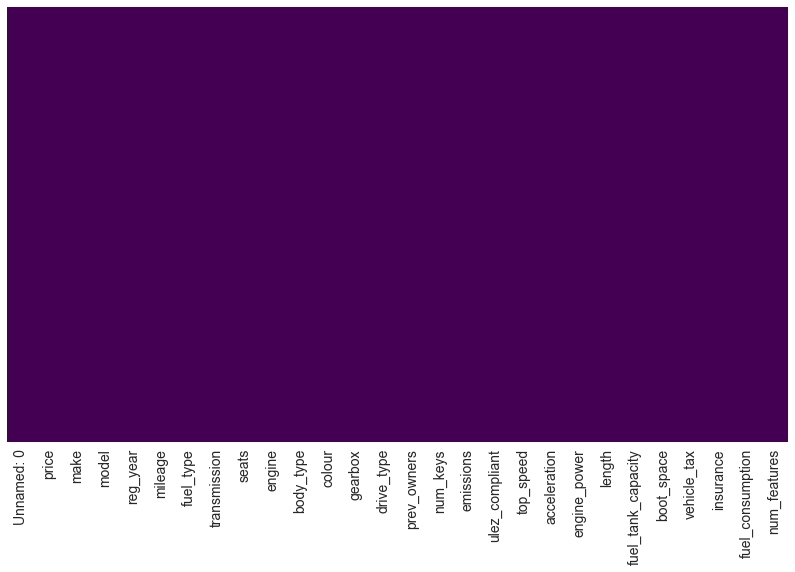

In [ ]:
## Check for missing values
# Realistically this won't show anything, as it checks for np.nan
# However, these are all strings, so missing values will be '' and not show up.
# Still good to double-check
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [ ]:
# Let's clean the numeric columns
class DataCleaner():
    ''' Data Cleaning class to prepare all the numeric columns '''
    def __init__(self):
        pass


    def clean_numeric(self, feature):
        ''' Extract the numeric element from a string (£1,200.00 -> 1200.00) '''
        if  isinstance(feature, str):
            return float(re.sub('[^0-9.]', '', feature))
        else:
            return self.replace_with_nan(feature)


    def replace_with_nan(self, feature):
        ''' Replace erroneous feature with np.nan '''
        return np.nan


    def check_contains_string(self, feature, string):
        ''' Make sure field is in expected form - e.g. contains 'g/km'
            else wrong data has been scraped. So replace with NaN '''
        if string in feature:
            return feature
        else:
            return self.replace_with_nan(feature)


    def check_contains_only_numeric(self, feature):
        ''' Some variables only contain numeric (e.g. seats).
            Remove any erroneous values that have crept in (e.g. 106g/km)'''
        if re.search('[^0-9.]', feature):
            return self.replace_with_nan(feature)
        else:
            return feature


    def clean_numeric_only(self, feature):
        ''' Specific clean method for features expecting only numeric values
            including: reg_year, seats, prev_owners, num_keys '''
        feature = self.check_contains_only_numeric(feature)
        if  isinstance(feature, str):
            feature = self.clean_numeric(feature)
            return feature
        else:
            return feature


    def clean_price(self, feature):
        ''' Specific clean method for cost feature '''
        # Enters as str
        feature = self.clean_numeric(feature)
        # Leaves as float or nan
        return feature


    def clean_reg_year(self, feature):
        ''' Specific clean method for reg_year feature '''
        # Enters as str. Leave as float
        return float(feature)


    def clean_mileage(self, feature):
        ''' Specific clean method for mileage feature '''
        # Enters as str
        feature = self.check_contains_string(feature, 'miles')
        # Leaves as str or nan
        feature = self.clean_numeric(feature)
        # Leaves as float or nan
        return feature


    def clean_seats(self, feature):
        ''' Specific clean method for seats feature '''
        # Enters as str. Leave as float or nan
        return self.clean_numeric_only(feature)


    def clean_engine(self, feature):
        ''' Specific clean method for engine feature '''
        # Enter as str
        if re.search('[^0-9L.]', feature):
            # Leave as nan
            return self.replace_with_nan(feature)
        else:
            # Leave as float or nan
            feature = self.clean_numeric(feature)
            return feature
    
    
    def clean_gearbox(self, feature):
        ''' Specific clean method for gearbox feature '''
        if re.search('[0-9]', feature):
            feature = self.clean_numeric(feature)
            return feature
        else:
            return self.replace_with_nan(feature)


    def clean_prev_owners(self, feature):
        ''' Specific clean method for prev_owners feature '''
        # Enter as str
        if  isinstance(feature, str):
            # Leave as float or nan
            return self.clean_numeric_only(feature)
        else:
            # Shouldn't be possible
            return feature


    def clean_num_keys(self, feature):
        ''' Specific clean method for num_keys feature '''
        if isinstance(feature, str):
            if feature == '2+':
                return self.clean_numeric_only('3')
            else:
                return self.clean_numeric_only(feature)
        else:
            return feature


    def clean_emissions(self, feature):
        ''' Specific clean method for emissions feature '''
        # Enters str
        feature = self.check_contains_string(feature, 'g/km')
        # Returns str or nan
        if isinstance(feature, str):
            # If str, return float or nan
            feature = self.clean_numeric(feature)
            return feature
        else:
            # Return nan
            return feature


    def clean_ulez_compliant(self, feature):
        ''' Specific clean method for ulez_compliant feature '''
        if feature == 'Yes':
            return 1
        elif feature == 'No':
            return 0
        else:
            return self.replace_with_nan(feature)


    def clean_top_speed(self, feature):
        ''' Specific clean method for top_speed feature '''
        feature = self.check_contains_string(feature, 'mph')
        if isinstance(feature, str):
            feature = self.clean_numeric(feature)
            return feature
        else:
            return feature


    def clean_acceleration(self, feature):
        ''' Specific clean method for acceleration feature '''
        feature = self.check_contains_string(feature, 'seconds')
        if isinstance(feature, str):
            feature = self.clean_numeric(feature)
            return feature
        else:
            return feature


    def clean_engine_power(self, feature):
        ''' Specific clean method for engine_power feature '''
        feature = self.check_contains_string(feature, 'bhp')
        if isinstance(feature, str):
            feature = self.clean_numeric(feature)
            return feature
        else:
            return feature


    def clean_length(self, feature):
        ''' Specific clean method for length feature '''
        feature = self.check_contains_string(feature, 'mm')
        if isinstance(feature, str):
            feature = self.clean_numeric(feature)
            return feature
        else:
            return feature


    def clean_fuel_tank_capacity(self, feature):
        ''' Specific clean method for fuel_tank_capacity feature '''
        feature = self.check_contains_string(feature, 'litres')
        if isinstance(feature, str):
            feature = self.clean_numeric(feature)
            return feature
        else:
            return feature


    def clean_boot_space(self, feature):
        ''' Specific clean method for boot_space feature '''
        feature = self.check_contains_string(feature, 'litres')
        if isinstance(feature, str):
            feature = self.clean_numeric(feature)
            return feature
        else:
            return feature


    def clean_vehicle_tax(self, feature):
        ''' Specific clean method for vehicle_tax feature '''
        if re.search('[^£0-9./year ]', feature):
            return self.replace_with_nan(feature)
        else:
            feature = self.clean_numeric(feature)
            return feature


    def clean_insurance(self, feature):
        ''' Specific clean method for insurance feature '''
        feature = self.check_contains_string(feature, 'Group')
        if isinstance(feature, str):
            idx = feature.find('.')
            feature = feature[idx+1:]
            feature = self.clean_numeric(feature)
            return feature
        else:
            return feature


    def clean_fuel_consumption(self, feature):
        ''' Specific clean method for fuel_consumption feature '''
        if re.search('mpg', feature) and re.search('approx', feature):
            idx = feature.find('mpg')
            feature = feature[:idx]
            feature = self.clean_numeric(feature)
            return feature
        else:
            return self.replace_with_nan(feature)


In [ ]:
# Another useful list of columns, containing only those that are affected
# by the DataCleaner() class
columns_to_clean = ['price',
                    'reg_year',
                    'mileage',
                    'seats',
                    'engine',
                    'gearbox',
                    'prev_owners',
                    'num_keys',
                    'emissions',
                    'ulez_compliant',
                    'top_speed',
                    'acceleration',
                    'engine_power',
                    'length',
                    'fuel_tank_capacity',
                    'boot_space',
                    'vehicle_tax',
                    'insurance',
                    'fuel_consumption'
                   ]

In [ ]:
# Instantiate DataCleaner object
data_cleaner = DataCleaner()

In [ ]:
# Work on a copy of the dataset, to not affect the original
cleaned_df = df.copy()
cleaned_df

price        make     model reg_year       mileage fuel_type  \
0     £14,350     Renault    Captur     2019   9,044 miles    Petrol   
1     £15,525       Skoda   Octavia     2017  29,578 miles    Diesel   
2     £11,550     Renault    Kadjar     2018  31,400 miles    Petrol   
3     £17,125  Volkswagen      Golf     2016  51,307 miles    Petrol   
4      £7,700     Peugeot      2008     2016  38,475 miles    Petrol   
...       ...         ...       ...      ...           ...       ...   
4381  £14,625        Ford      Kuga     2018  28,094 miles    Petrol   
4382   £9,525        Ford    Fiesta     2017  24,701 miles    Petrol   
4383  £17,725         BMW  3 Series     2018  31,775 miles    Diesel   
4384  £10,950        Ford    Fiesta     2018  13,236 miles    Petrol   
4385  £20,075         BMW  3 Series     2017  10,552 miles    Diesel   

     transmission seats engine         body_type  \
0          Manual     5   1.3L        5 door SUV   
1          Manual     5     2L     5 door Estate   
2          Manual     5   1.3L        5 door SUV   
3       Automatic     5     2L     5 door Estate   
4          Manual     5   1.2L        5 door SUV   
...           ...   ...    ...               ...   
4381       Manual     5   1.5L        5 door SUV   
4382       Manual     5     1L  5 door Hatchback   
4383    Automatic     5     2L     4 door Saloon   
4384       Manual     5     1L  5 door Hatchback   
4385    Automatic     5     3L     4 door Saloon   

                             colour             gearbox         drive_type  \
0                       Multicolour     Manual, 6 speed  Front wheel drive   
1                             Black     Manual, 6 speed  Front wheel drive   
2                              Grey     Manual, 6 speed  Front wheel drive   
3                              Grey  Automatic, 6 speed   Four wheel drive   
4                             Black     Manual, 5 speed  Front wheel drive   
...                             ...                 ...                ...   
4381                          White     Manual, 6 speed  Front wheel drive   
4382                         Silver     Manual, 5 speed           GJ67 LGV   
4383  Black Sapphire metallic paint  Automatic, 8 speed   Four wheel drive   
4384                         Silver     Manual, 6 speed  Front wheel drive   
4385  Black Sapphire metallic paint  Automatic, 8 speed   Rear wheel drive   

     prev_owners         num_keys         emissions ulez_compliant  \
0              1                2  146g/km (band G)            Yes   
1              1               2+  119g/km (band G)            Yes   
2              1                2  134g/km (band H)            Yes   
3              2                2  168g/km (band G)            Yes   
4              2                2  114g/km (band C)            Yes   
...          ...              ...               ...            ...   
4381           1                1  145g/km (band H)            Yes   
4382           2  99g/km (band E)               Yes        112 mph   
4383           1                2  123g/km (band G)            Yes   
4384           2                2  110g/km (band E)            Yes   
4385           1                2  131g/km (band H)            Yes   

         top_speed  acceleration engine_power         length  \
0          124 mph  10.2 seconds      128 bhp        4122 mm   
1          143 mph   8.3 seconds      181 bhp        4689 mm   
2          128 mph   9.4 seconds      158 bhp        4449 mm   
3          155 mph   5.3 seconds      296 bhp        4596 mm   
4          104 mph  13.5 seconds       82 bhp        4159 mm   
...            ...           ...          ...            ...   
4381       121 mph   9.7 seconds      148 bhp        4535 mm   
4382  10.5 seconds        98 bhp      3969 mm  Not available   
4383       142 mph   7.6 seconds      190 bhp        4633 mm   
4384       121 mph   9.9 seconds      123 bhp        4040 mm   
4385       155 mph   5.6 seconds    

In [ ]:
# Iterate through the list of column names, 
# applying the cleaning functions per DataFrame column.
# The eval() is fantastic for evaluating a string at run-time as if it were code.
# Essentially the opposite of an f-string!
for column in columns_to_clean:
    print(f'Cleaning: {column}')
    cleaned_df[column] = cleaned_df[column].apply(
        lambda x: eval(f'data_cleaner.clean_{column}(x)')
    )

Cleaning: price
Cleaning: reg_year
Cleaning: mileage
Cleaning: seats
Cleaning: engine
Cleaning: gearbox
Cleaning: prev_owners
Cleaning: num_keys
Cleaning: emissions
Cleaning: ulez_compliant
Cleaning: top_speed
Cleaning: acceleration
Cleaning: engine_power
Cleaning: length
Cleaning: fuel_tank_capacity
Cleaning: boot_space
Cleaning: vehicle_tax
Cleaning: insurance
Cleaning: fuel_consumption


In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
# Inspect the cleaned dataset
cleaned_df.head(50)

price           make            model  reg_year  mileage  \
0   14350.0        Renault           Captur    2019.0   9044.0   
1   15525.0          Skoda          Octavia    2017.0  29578.0   
2   11550.0        Renault           Kadjar    2018.0  31400.0   
3   17125.0     Volkswagen             Golf    2016.0  51307.0   
4    7700.0        Peugeot             2008    2016.0  38475.0   
5   15450.0         Nissan          Qashqai    2017.0  21006.0   
6   29700.0         Jaguar           F-PACE    2018.0  34561.0   
7    6975.0     Volkswagen              up!    2017.0  21406.0   
8   15800.0           Mini       Countryman    2017.0  26470.0   
9   12100.0           Seat            Ibiza    2019.0   6481.0   
10  20650.0           Audi               A3    2017.0  20720.0   
11  20500.0         Nissan          Qashqai    2019.0   5621.0   
12  14225.0        Renault           Captur    2019.0  10889.0   
13  18175.0  Mercedes-Benz          C Class    2015.0  31972.0   
14  10450.0         Suzuki            Ignis    2018.0   7165.0   
15  20075.0           Mini            Hatch    2019.0   6667.0   
16  17350.0  Mercedes-Benz          A Class    2018.0  14540.0   
17  10725.0         Nissan             Juke    2017.0  21824.0   
18  10575.0         Nissan            Micra    2018.0   9828.0   
19  23475.0  Mercedes-Benz        GLC Class    2017.0  40783.0   
20  10900.0            BMW         1 Series    2017.0  49336.0   
21  11650.0        Renault           Captur    2019.0   9420.0   
22   8450.0       Vauxhall            Corsa    2016.0   4980.0   
23  11550.0           Ford           Fiesta    2018.0  25973.0   
24  26675.0     Land Rover  Discovery Sport    2017.0  16598.0   
25   8825.0       Vauxhall             ADAM    2018.0  10738.0   
26  16875.0          Mazda          MX-5 RF    2018.0   9820.0   
27  11675.0           Ford           Fiesta    2019.0   3359.0   
28  31375.0           Audi               S5    2018.0  14388.0   
29  13675.0         Nissan          Qashqai    2016.0  23126.0   
30  10525.0            BMW         1 Series    2016.0  40926.0   
31   8925.0       Vauxhall            Corsa    2018.0  15250.0   
32  22525.0         Jaguar               XE    2018.0   9725.0   
33   8450.0           Ford              Ka+    2018.0   8495.0   
34  12175.0  Mercedes-Benz          A Class    2016.0  48548.0   
35  18275.0     Volkswagen             Golf    2017.0  34290.0   
36  10500.0        Hyundai              i30    2018.0  38122.0   
37  10250.0     Volkswagen             Polo    2016.0  35681.0   
38  17350.0            BMW               X1    2017.0  10392.0   
39  14525.0            BMW         1 Series    2017.0  22944.0   
40   9925.0        Renault           Captur    2018.0  38673.0   
41  15325.0           Ford            Focus    2019.0  12193.0   
42  12600.0     Volkswagen             Golf    2017.0  28511.0   
43   9375.0     Volkswagen             Polo    2016.0  29240.0   
44  20375.0            BMW               X3    2017.0  56526.0   
45   8700.0        Renault             Clio    2019.0  34831.0   
46  10975.0          Honda            Civic    2017.0  34390.0   
47   9775.0     Volkswagen             Polo    2017.0  21231.0   
48  15575.0        Hyundai            Ioniq    2017.0  30823.0   
49  31550.0           Audi               Q5    2018.0  10886.0   

         fuel_type transmission  seats  engine           body_type  \
0           Petrol       Manual    5.0     1.3          5 door SUV   
1           Diesel       Manual    5.0     2.0       5 door Estate   
2           Petrol       Manual    5.0     1.3          5 door SUV   
3           Petrol    Automatic    5.0     2.0       5 door Estate   
4           Petrol       Manual    5.0     1.2          5 door SUV   
5           Petrol    Automatic    5.0     1.2          5 door SUV   
6           Diesel    Automatic    5.0     2.0          5 door SUV   
7           Petrol       Manual    4.0     1.0    3 door Hatchback   
8        

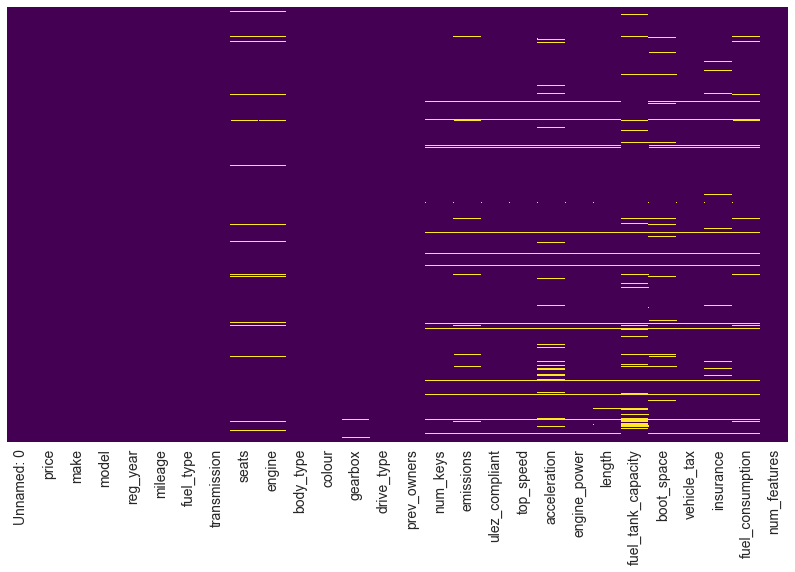

In [ ]:
# Inspect missing Values
sns.heatmap(cleaned_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [ ]:
# All the columns that we wanted to be numeric are now converted
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4386 entries, 0 to 4385
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               4386 non-null   float64
 1   make                4386 non-null   object 
 2   model               4386 non-null   object 
 3   reg_year            4386 non-null   float64
 4   mileage             4386 non-null   float64
 5   fuel_type           4386 non-null   object 
 6   transmission        4386 non-null   object 
 7   seats               4244 non-null   float64
 8   engine              4244 non-null   float64
 9   body_type           4386 non-null   object 
 10  colour              4386 non-null   object 
 11  gearbox             4374 non-null   float64
 12  drive_type          4386 non-null   object 
 13  prev_owners         4386 non-null   float64
 14  num_keys            4325 non-null   float64
 15  emissions           4280 non-null   float64
 16  ulez_c

In [ ]:
# View standard statistical attributes
cleaned_df.describe()

price     reg_year       mileage        seats       engine  \
count   4386.000000  4386.000000   4386.000000  4244.000000  4244.000000   
mean   16832.330141  2017.650251  21993.952804     5.010368     1.711122   
std     6400.770858     1.077338  12216.845231     0.582473     0.525847   
min     5275.000000  2013.000000    275.000000     2.000000     0.600000   
25%    12075.000000  2017.000000  13134.750000     5.000000     1.400000   
50%    15800.000000  2018.000000  19615.500000     5.000000     1.600000   
75%    20093.750000  2019.000000  29338.000000     5.000000     2.000000   
max    55125.000000  2020.000000  79836.000000     7.000000     5.000000   

           gearbox  prev_owners     num_keys    emissions  ulez_compliant  \
count  4374.000000  4386.000000  4325.000000  4280.000000     4325.000000   
mean      6.220165     1.286138     1.864971   128.233178        0.996994   
std       1.620740     0.592984     0.365341    27.964853        0.054749   
min       1.000000     1.000000     1.000000    12.000000        0.000000   
25%       6.000000     1.000000     2.000000   112.000000        1.000000   
50%       6.000000     1.000000     2.000000   126.000000        1.000000   
75%       7.000000     1.000000     2.000000   146.000000        1.000000   
max       9.000000     5.000000     3.000000   299.000000        1.000000   

         top_speed  acceleration  engine_power       length  \
count  4322.000000   4156.000000   4325.000000  4304.000000   
mean    126.787367      9.431328    160.030520  4418.095493   
std      15.549546      2.288508     65.218536   314.903695   
min      71.000000      3.500000     59.000000  2695.000000   
25%     114.000000      7.800000    116.000000  4252.750000   
50%     125.000000      9.400000    148.000000  4394.000000   
75%     139.000000     11.000000    187.000000  4663.000000   
max     170.000000     16.300000    597.000000  5370.000000   

       fuel_tank_capacity   boot_space  vehicle_tax    insurance  \
count         3989.000000  4191.000000  4324.000000  4249.000000   
mean            55.023314   417.811739   176.576087   468.192045   
std             23.097309   124.609439   115.601129   121.888249   
min              9.000000    65.000000     0.000000   180.000000   
25%             46.000000   335.000000   150.000000   383.000000   
50%             53.000000   406.000000   150.000000   454.000000   
75%             60.000000   503.000000   150.000000   545.000000   
max            590.000000  1790.000000   565.000000  1191.000000   

       fuel_consumption  num_features  
count       4294.000000   4386.000000  
mean          56.239108     33.033744  
std           36.864949      5.244425  
min           20.000000      9.000000  
25%           44.800000     30.000000  
50%           52.300000     33.000000  
75%           61.400000     36.000000  
max         1412.400000     63.000000

In [ ]:
# Save progress!
cleaned_df.to_csv('cazoo_cleaned.csv')

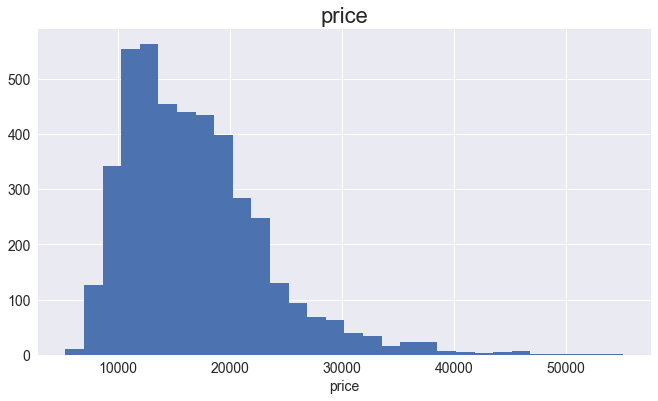

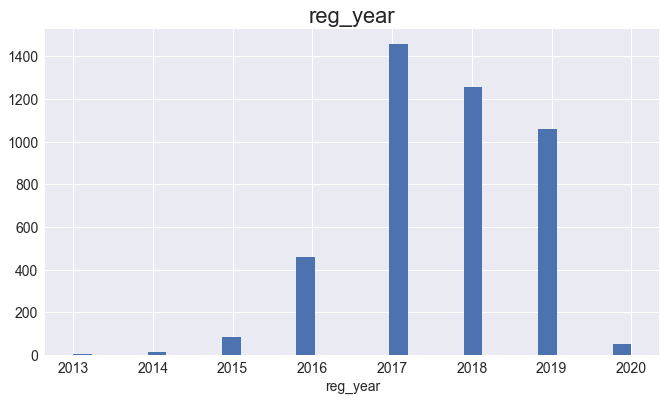

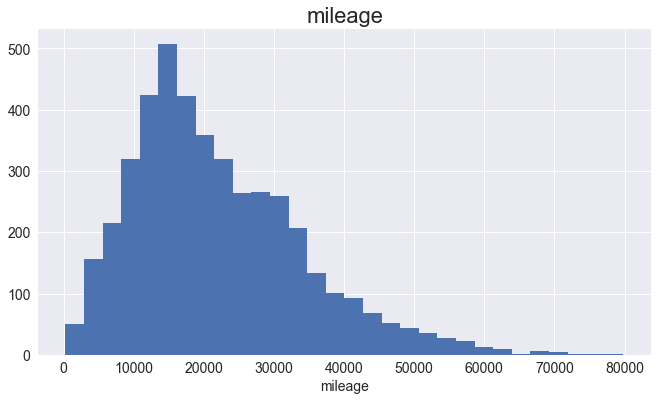

C:\Users\Justin\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Justin\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


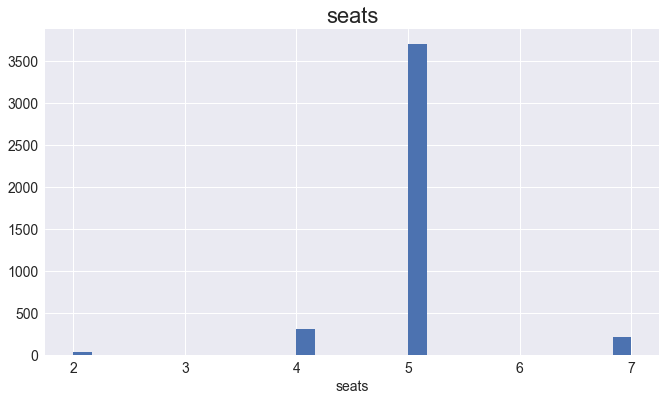

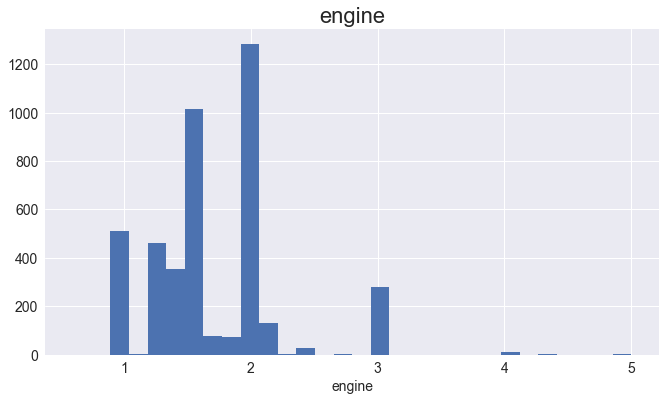

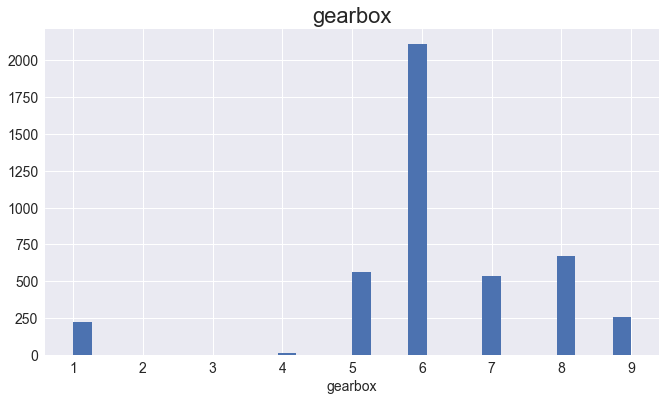

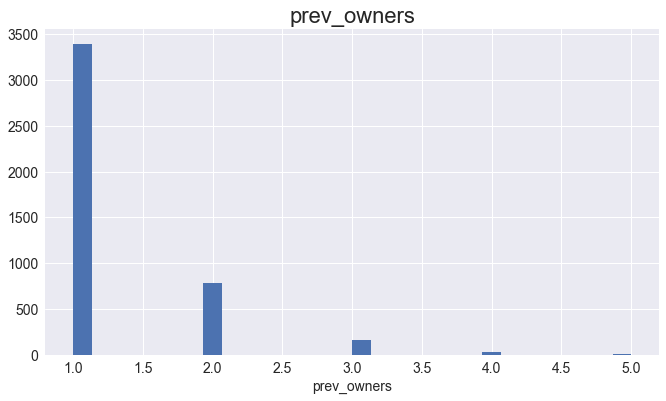

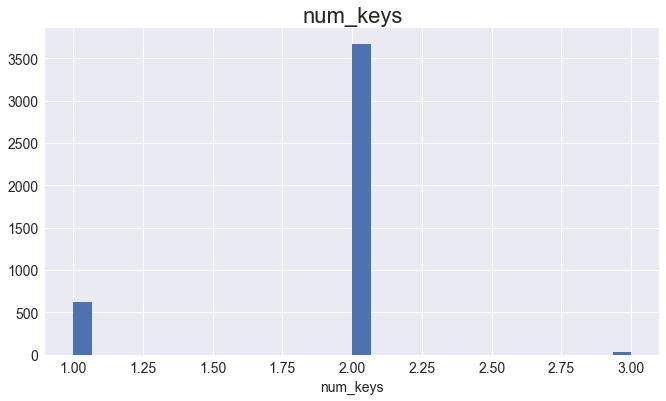

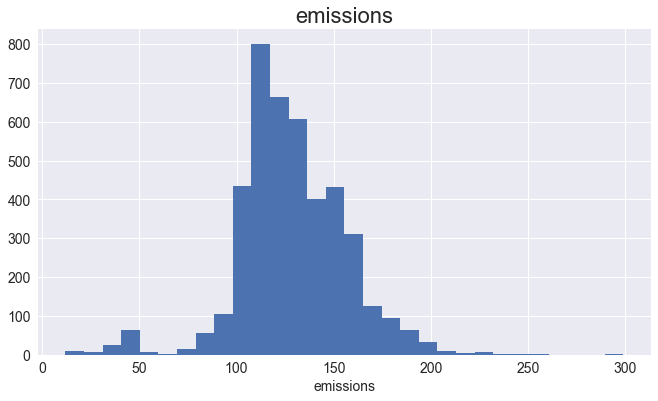

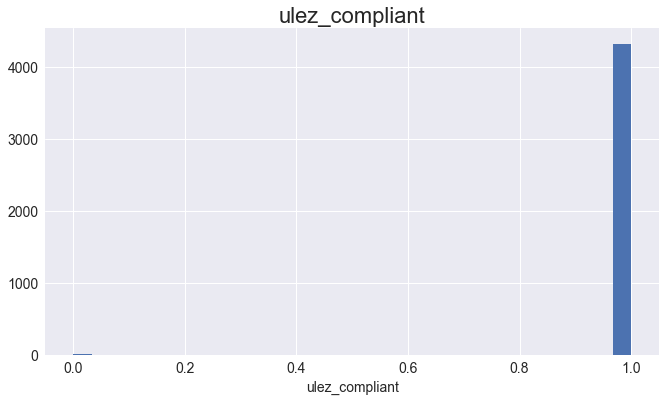

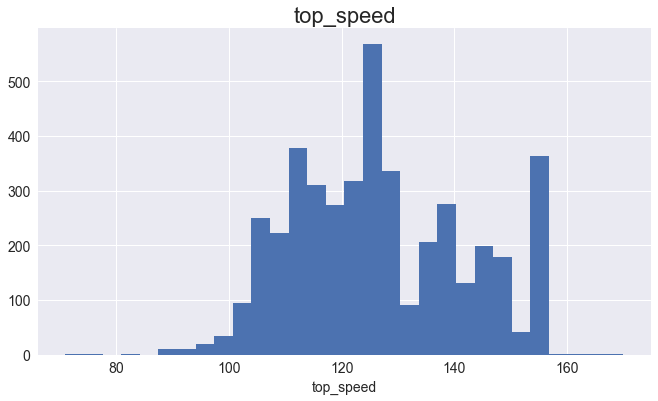

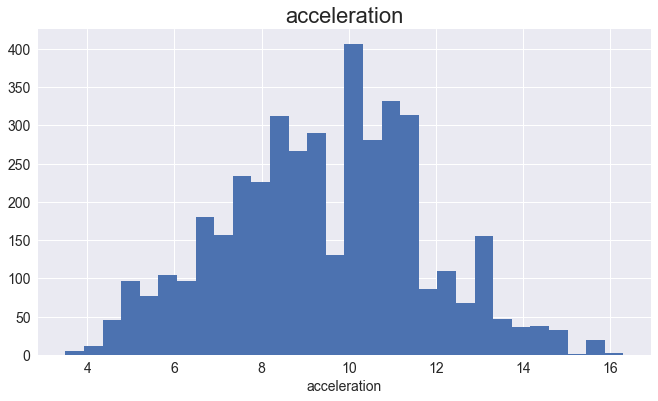

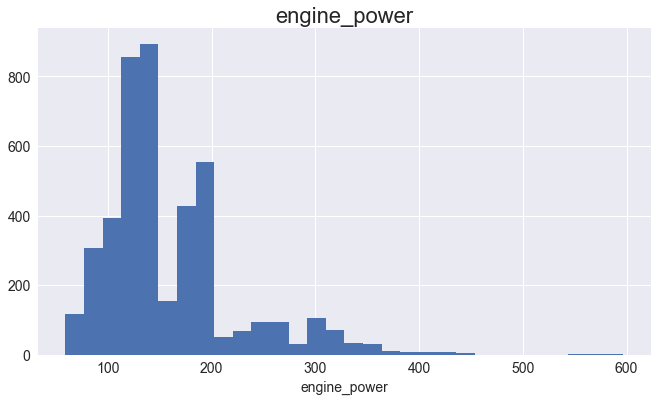

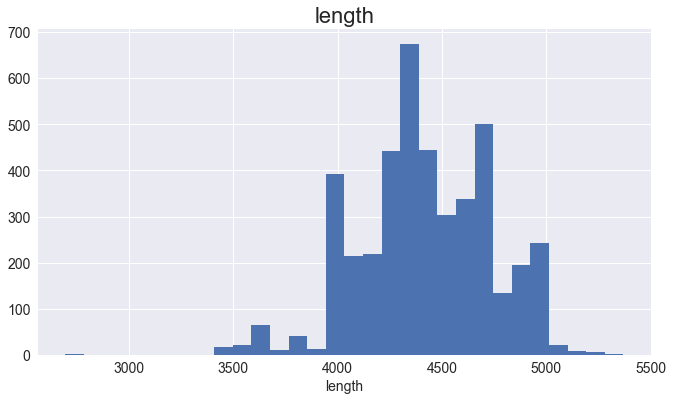

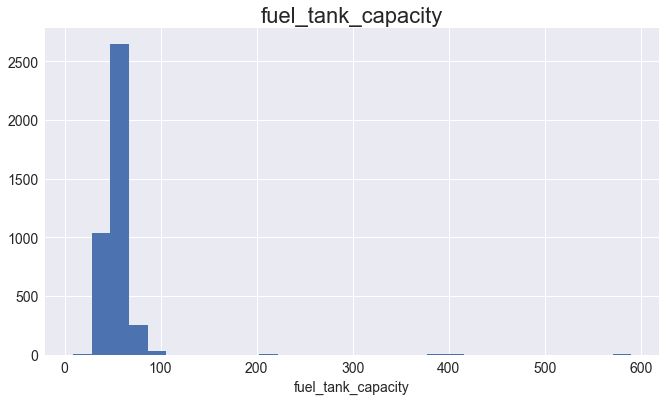

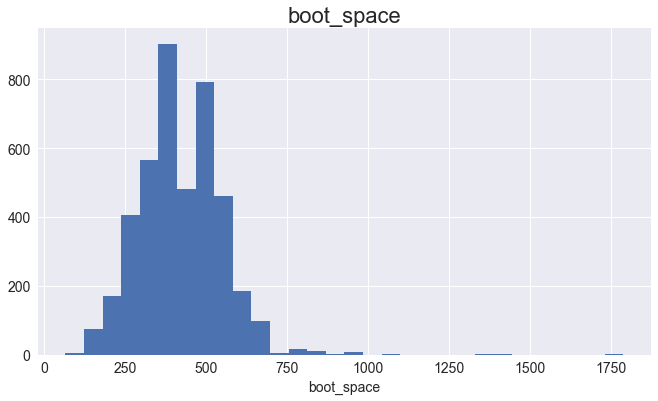

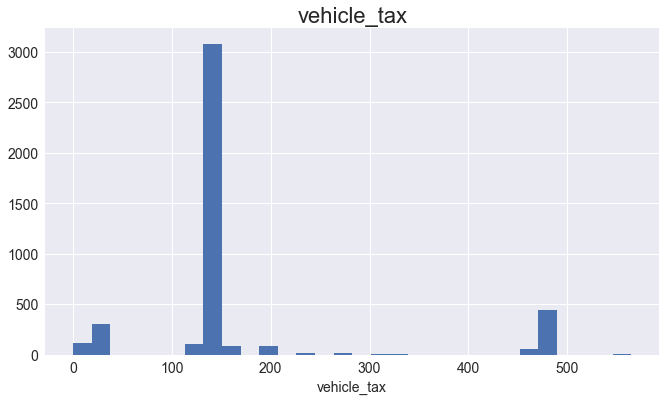

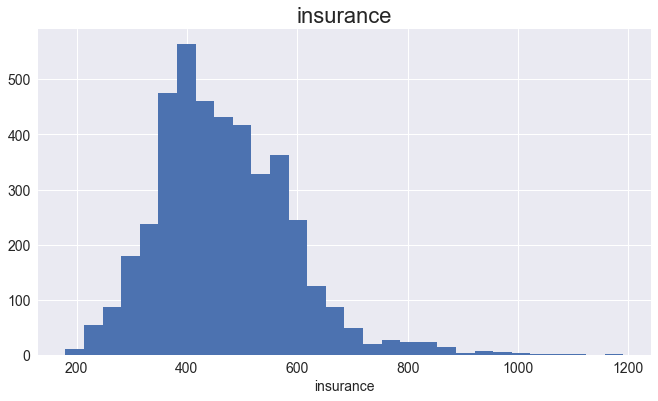

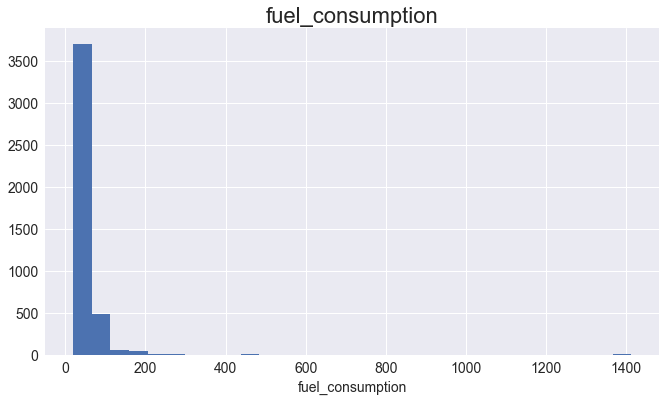

In [ ]:
# Let's inspect the distribution of the numeric features (and target)
for column in columns_to_clean:
    plt.figure(figsize=(11, 6))
    plt.hist(cleaned_df[column], bins=30)
    plt.title(column)
    plt.xlabel(column)
    plt.show()

## Establish a Performance Baseline with Only Numeric Variables
Before we go to the trouble of encoding the categorical features, we can establish a baseline performance by creating a model using only the numerical features.<br>
<br>
We will use Root Mean Squared Error as our performance metric:<br><br>
<center>
$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\hat{y_i} -y_i\Big)^2}}$
    
<br>

### Data preparation

In [ ]:
# Select only numeric features
numeric_vars = cleaned_df.select_dtypes(exclude='object').copy()

In [ ]:
# Separate features and target
X = numeric_vars.drop('price', axis=1)
y = numeric_vars['price']

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute median for missing values
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

## Some algorithms benefit from different scaling choies.
standardiser = StandardScaler()
standardiser.fit(X_train)

normaliser = MinMaxScaler()
normaliser.fit(X_train)

# Tree based models don't require any scaling
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Linear Regression and others benefit from standarising features
# by subtracting their mean and diving by the standard deviation.
# This method is robost to outliers
X_train_standard = standardiser.transform(X_train)
X_test_standard = standardiser.transform(X_test)

# Neural networks benefit from normalising values between [0, 1]
X_train_normal = normaliser.transform(X_train)
X_test_normal = normaliser.transform(X_test)

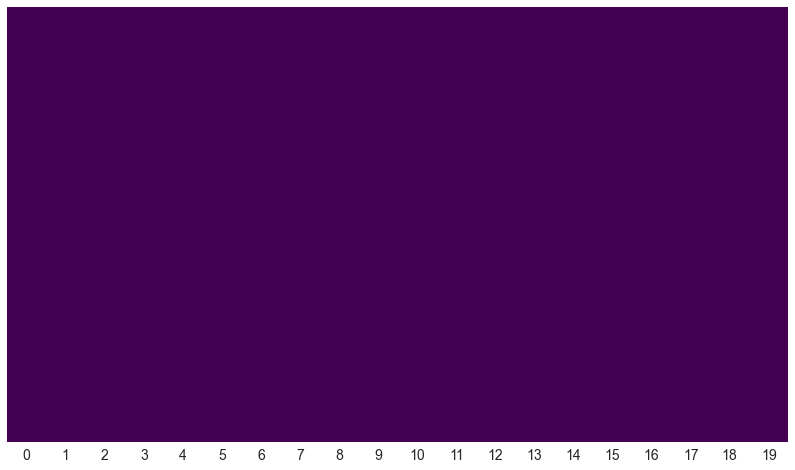

In [ ]:
# Inspect missing values to double-check the imputer replaced all missing
sns.heatmap(pd.DataFrame(X_train).isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

### Model selection
We will test out a few models using their default hyperparameters

In [ ]:
# Use a linear model with default values
lin_reg = LinearRegression()
lin_reg.fit(X_train_standard, y_train)
y_pred = lin_reg.predict(X_test_standard)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

2878.1784795687954

In [ ]:
# Use a random forest model with default values
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1902.813711305356

In [ ]:
# Use a gradient boosted model with default values (xgboost)
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1873.7961837265846

In [ ]:
# Use a gradient boosted model with default values (LightGBM)
lgb_reg = LGBMRegressor()
lgb_reg.fit(X_train, y_train)
y_pred = lgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1803.291193364139

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(X_test[0]))),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(lr=3e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(X_train_normal, y_train, epochs=100, verbose=0)

model.evaluate(X_test_normal, y_test)

28/28 [==============================] - 0s 1ms/step - loss: 4669734.0000 - root_mean_squared_error: 2160.9568


[4669734.0, 2160.956787109375]

We are seeing an RMSE baseline of roughly 1800 - 2000. Let's see if we can beat that by including categorical features.

## Feature Engineering
Now we will move onto feature engineering.<br>
This will include:
* One-hot encoding of categorical variables.
* Ordinal encoding of categorical variables where appropriate.

In [ ]:
# Used as a checkpoint to not need to re-run the previous code
cleaned_df = pd.read_csv('cazoo_cleaned.csv')

In [ ]:
# Separate categorical features
categorical_vars = cleaned_df.select_dtypes(include='object').copy()

In [ ]:
# Inspect the range of values each feature can take
for column in categorical_vars.columns:
    print(column)
    print(categorical_vars[column].value_counts())
    print()

make
Audi             443
BMW              428
Ford             425
Vauxhall         376
Mercedes-Benz    322
Volkswagen       322
Kia              206
Nissan           187
Hyundai          171
Seat             134
Land Rover       129
Skoda            129
Volvo            118
Jaguar           118
Toyota           114
Mini             112
Peugeot          107
Renault           99
Honda             88
Citroen           86
Mitsubishi        45
Suzuki            34
Jeep              33
Mazda             32
Fiat              24
Alfa Romeo        21
Lexus             20
DS                18
Abarth            14
Dacia             13
Porsche            9
Infiniti           3
Smart              2
Subaru             2
Maserati           1
Tesla              1
Name: make, dtype: int64

model
Fiesta     149
Golf       141
Focus      122
C Class    108
Qashqai    101
          ... 
ASX          1
500C         1
Stinger      1
X5M          1
Rifter       1
Name: model, Length: 272, dtype: int64

fu

Upon inspection, there are no features that I would consider Ordinal, so we won't be using that to encode them.<br>
<br>
One visible problem is the very high cardinality variables. If we one-hot encode them, they will add a large degree of complexity to our model, and could lead to model deterioration.<br>

### 'colour'
One solution for high cardinality could be to encode the top n values (top 5 for example), and encode the rest as 'other'. 'colour' has 103 different colours, but most of these are a single unique colour per car (see: 'Smoked Topaz'). We could encode the top 5 (white, black, grey, blue, silver) and group the rest as 'other'.<br>
<br>
We will investigate this option:

In [ ]:
# Create new dataset to investigate colour
check_colour_df = cleaned_df[['make', 'model', 'colour', 'price']].copy()

We can see in the table below that the single colour values take up many of the fields.<br>
<br>
I am also not convinced that colour will have predictive power. Clearly the most and least expensive cars are based on car make (BMW and Jeep, vs Fiat 500). The colour appears arbitrary.

In [ ]:
# Anonymous function to return the most common categorical value
get_max = lambda x: x.value_counts(dropna=False).index[0]
# Rename the lambda function to look nicer in the table
get_max.__name__ = "most frequent"

In [ ]:
# Aggregate by colour to see average price
colour_agg = check_colour_df.groupby('colour').agg(
    {'colour': 'count',
     'price': 'mean',
     'make': [get_max],
     'model': [get_max]}
).sort_values(('price', 'mean'), ascending=False)

colour_agg

colour     price          make         model
                            count      mean most frequent most frequent
colour                                                                 
Long Beach Blue                 2  39100.00           BMW           X5M
Mojito Clear Coat               2  37437.50          Jeep      Wrangler
Hellayella Clear Coat           1  37175.00          Jeep      Wrangler
Firecracker Red Clear Coat      2  36737.50          Jeep      Wrangler
Bright White Clear Coat         2  36700.00          Jeep      Wrangler
...                           ...       ...           ...           ...
Avantgarde Bordeaux             2   9337.50          Fiat           500
Groove Metal Grey               2   9250.00          Fiat           500
Pasodoble Red                   5   9030.00          Fiat           500
Bossa Nova White                4   8118.75          Fiat           500
Ambient White                   1   5500.00          Fiat         Panda

[103 rows x 4 columns]

Let's try grouping the colours

In [ ]:
# Create grouped colour feature
def group_colours(feature):
    if feature not in ('White', 'Black', 'Grey', 'Blue', 'Silver'):
        return 'Other'
    else:
        return feature

In [ ]:
# Create grouped colour feature
check_colour_df['colour_group'] = check_colour_df['colour'].apply(
    lambda x: group_colours(x))

In [ ]:
# View frequency of different colours.
# Surprising that White is the most common. I would have guessed Silver!
check_colour_df['colour_group'].value_counts()

Other     1247
White      741
Black      717
Grey       684
Blue       540
Silver     457
Name: colour_group, dtype: int64

In [ ]:
## A new aggregate based on these grouped colours
# make and model provide little information here,
# as it is just the most common car brands.
# Interesting to see BMW 3-Series to be most likely to have non-standard colours.
grouped_colour_agg = check_colour_df.groupby('colour_group').agg({
    'price': ['mean', 'count'],
    'make': [get_max],
    'model': [get_max]}
).sort_values(('price', 'mean'), ascending=False).head(50)

grouped_colour_agg

price                make         model
                      mean count most frequent most frequent
colour_group                                                
Grey          17454.422515   684          Audi          Golf
Black         17337.099024   717          Audi       C Class
Other         16935.565357  1247           BMW      3 Series
White         16711.437247   741          Audi        Fiesta
Blue          16242.453704   540          Ford         Focus
Silver        15720.623632   457      Vauxhall        Fiesta

We can see the price distribution across all colour groups are extremely similar, including even the outliers:

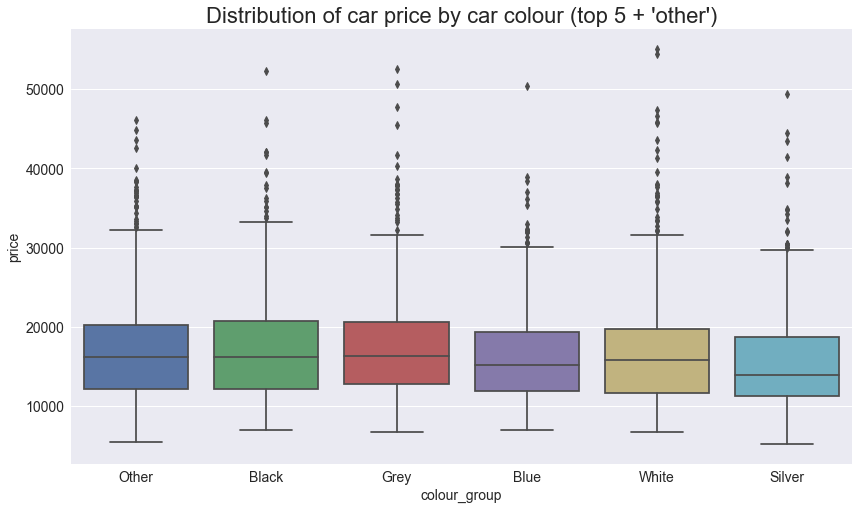

In [ ]:
sns.boxplot(x='colour_group', y='price', data=check_colour_df)
plt.title('Distribution of car price by car colour (top 5 + \'other\')')
plt.show()

The mean price is not much more informative:

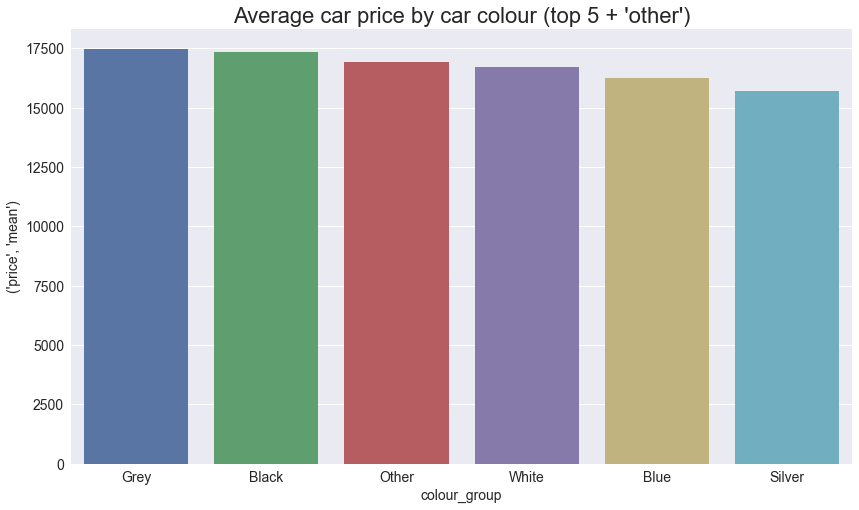

In [ ]:
sns.barplot(x=grouped_colour_agg.index, y=('price', 'mean'), data=grouped_colour_agg)
plt.title('Average car price by car colour (top 5 + \'other\')')
plt.show()

This feature will unlikely provide much value, particularly not to a linear model. But I will leave it in as it make be of use in a non-linear fashion for the tree based models. We can always remove it later during feature reduction.

### 'fuel_type'
I considered grouping 'electric', 'hybrid' and 'plug-in hybrid' into one category, but upon inspection, these different values are clearly distinct from one another:

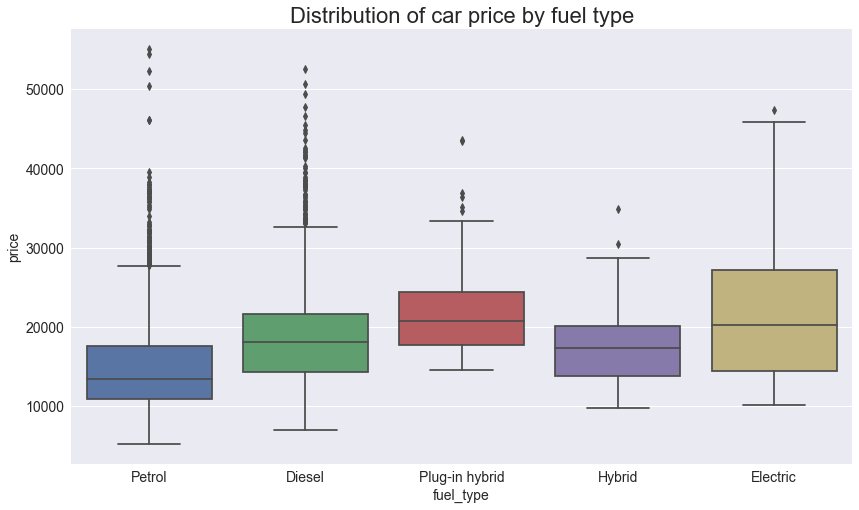

In [ ]:
sns.boxplot(x='fuel_type', y='price', data=cleaned_df)
plt.title('Distribution of car price by fuel type')
plt.show()

### 'body_type'
A similar story with 'body_type'. There are 20 different values, which is getting large for one-hot encoding. I had hoped to simplify and group by their sub-category (SUV, Hatchback, Saloon etc...) and ignore the number of doors, to create just 7 one-hot vectors.<br>
<br>
However, as we will see below, similar body_type sub-categories have vastly different distributions! As a result, cannot be considered interchangeable.

In [ ]:
# 20 different body types, with 7 'sub-categories' and number of doors from 2 to 5
print(len(cleaned_df['body_type'].value_counts()))
cleaned_df['body_type'].value_counts()

20


5 door SUV            1576
5 door Hatchback      1477
4 door Saloon          462
5 door Estate          252
5 door MPV             189
3 door Hatchback       134
2 door Coupe           101
2 door Convertible      75
3 door Coupe            31
5 door Saloon           27
5 door Coupe            17
4 door Coupe            11
4 door Hatchback        10
4 door MPV               9
4 door SUV               7
4 door Estate            4
2 door Saloon            1
2 door Hatchback         1
5 door Convertible       1
3 door Convertible       1
Name: body_type, dtype: int64

In [ ]:
# New DataFrame to work on, with only price and body_type
body_type_df = cleaned_df[['price', 'body_type']].copy()

In [ ]:
# Create function to return a body_types's 'sub-category'
def group_body_type(feature):
    if 'SUV' in feature:
        return 'SUV'
    elif 'Hatchback' in feature:
        return 'Hatchback'
    elif 'Saloon' in feature:
        return 'Saloon'
    elif 'Estate' in feature:
        return 'Estate'
    elif 'MPV' in feature:
        return 'MPV'
    elif 'Coupe' in feature:
        return 'Coupe'
    elif 'Convertible' in feature:
        return 'Convertible'
    else:
        return feature

In [ ]:
# Create new column for the grouped sub-categories
body_type_df['body_type_group'] = body_type_df['body_type'].apply(
    lambda x: group_body_type(x))

In [ ]:
# Sort DataFrame by body type group to ourder the groups together in the boxplot
body_type_df.sort_values(by='body_type_group', inplace=True)

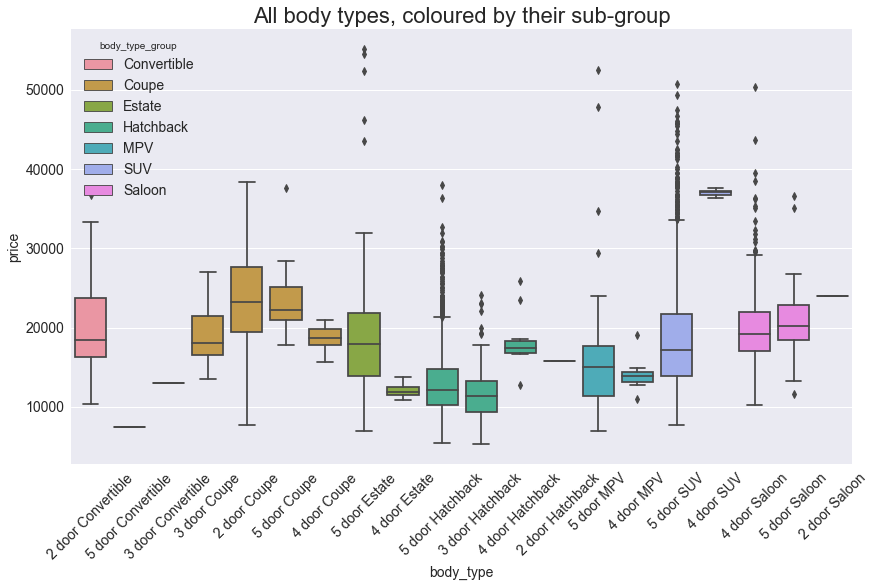

In [ ]:
## boxplot overview for distribution of all body_type values, 
# coloured by their respective sub-categories.
# Very little correlation between alike colours!
sns.boxplot(x='body_type', y='price', hue='body_type_group', 
            dodge=False, data=body_type_df)
plt.title('All body types, coloured by their sub-group')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Create set of sub-category names
body_types = set(body_type_df['body_type_group'].values)

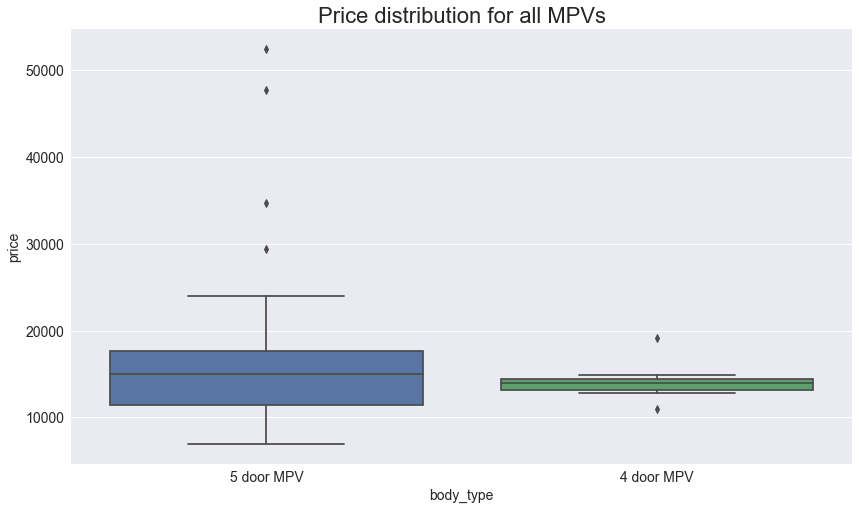

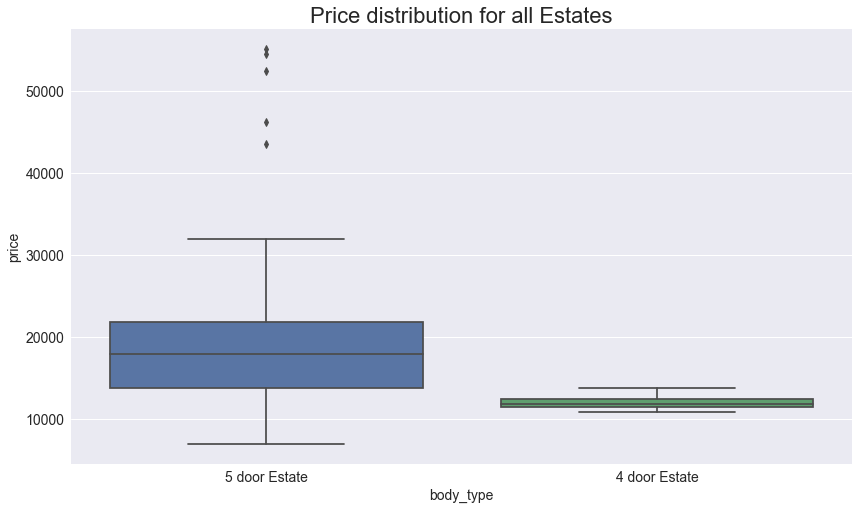

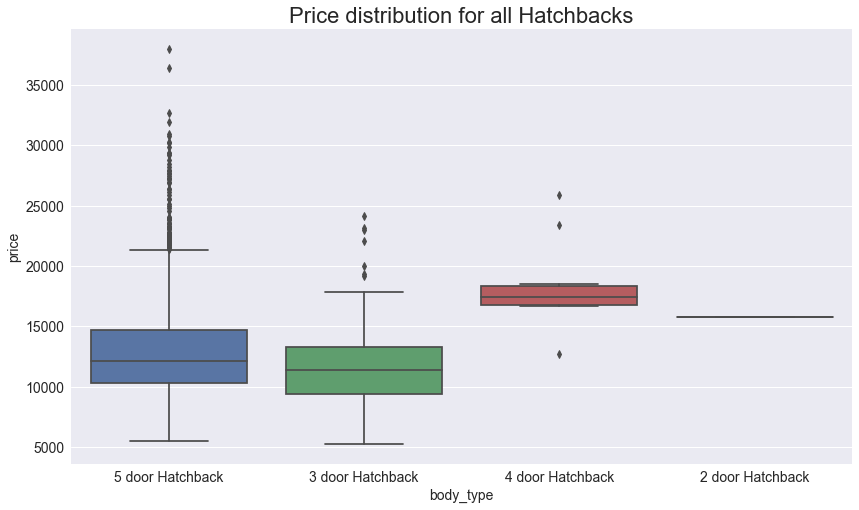

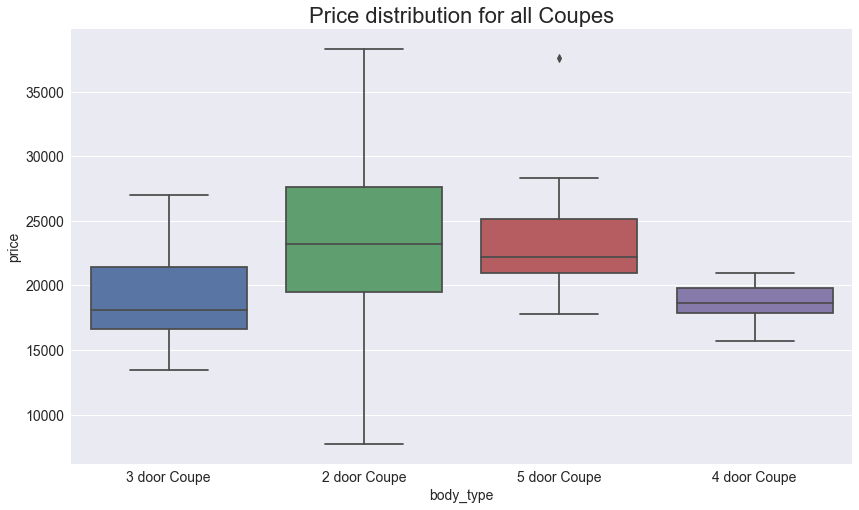

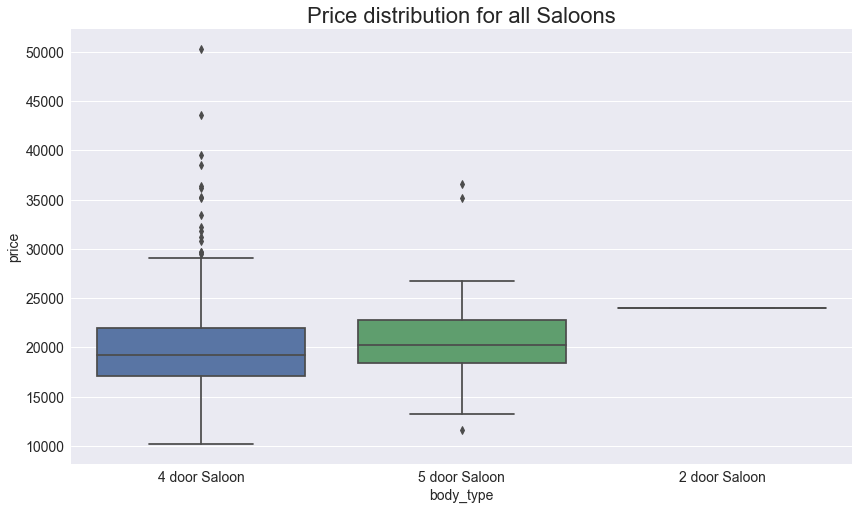

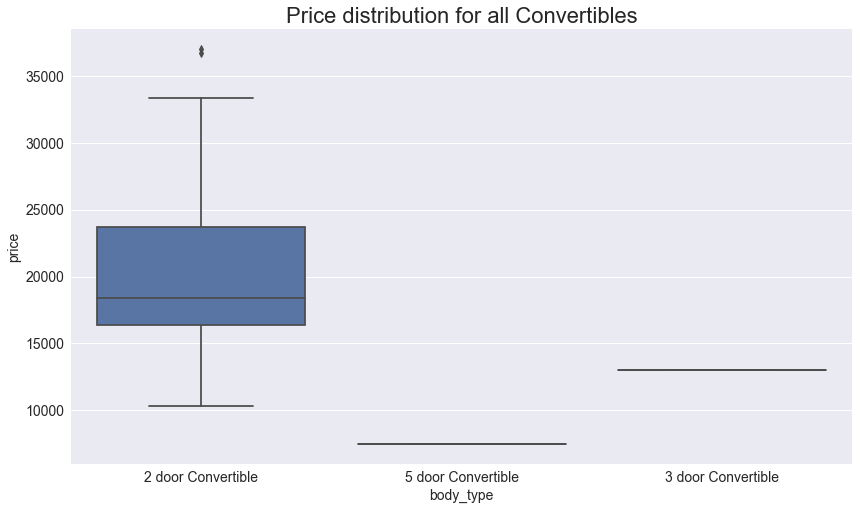

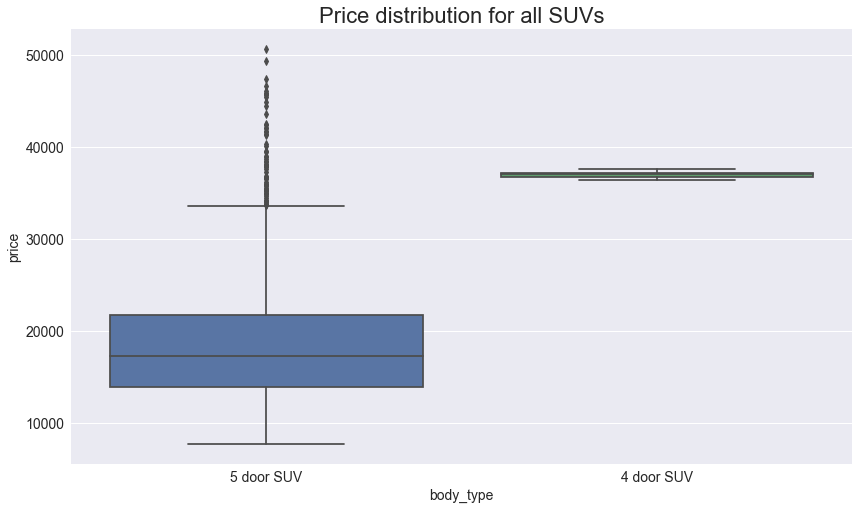

In [ ]:
## Let's take a closer look per sub-category.
# None of them appear to have similar distributions
for _ in range(len(body_types)):
    title = body_types.pop()
    temp_df = body_type_df[body_type_df['body_type_group']==title]
    sns.boxplot(x='body_type', y='price', data=temp_df)
    plt.title(f'Price distribution for all {title}s')
    plt.show()    

### Solution:
We will split this feature into 2; number of doors, and body type 'sub-category'.<br>
<br>
num_doors will be a numeric feature (2, 3, 4 or 5), and body_type will become 7 one-hot vectors.<br>
<br>
From 20 features to 8. Much better!

### 'make' and 'model'
'make' has 36 different car bands, and 'model' has 272 different types of car models. These are very large for One-Hot encoding. They are however, good candidates for representation learning using word embeddings, which we will use later.

### To summarise how we will handle each categorical feature:

* __make__ - cat2vec Embedding (far too high cardinality and can't be grouped like colour)
* __model__ - cat2vec Embedding (far too high cardinality and can't be grouped like colour)
* __fuel_type__ - one-hot {'petrol', 'diesel', 'hybrid', 'plugin_hybrid', 'electric'}
* __transmission__ - one-hot binary {'manual': 0, 'automatic': 1}
* __body_type__ - split into 2 features: num_doors, {'SUV', 'Hatchback', 'Saloon', 'Estate', 'MPV', 'Coupe', 'Convertible'}
* __colour__ - one-hot {'White', 'Black', 'Grey', 'Blue', 'Silver', 'Other'}
* __drive_type__ - one-hot {'fwd', 'rwd', '4x4', 'missing'}

### Data Cleaning and Preprocessing
Before feature engineering, we need to do a data little cleaning and preprocessing of the categorical features into groups, as previously mentioned.

In [ ]:
# First we build a class to clean the categorical data before feature engineering
class CategoricalPreprocessor:
    ''' Class to clean and prepare our categorical data '''
    def __init__(self):
        pass
    
    
    def clean_numeric(self, feature):
        ''' Extract the numeric element from a string (£1,200.00 -> 1200.00) '''
        return float(re.sub('[^0-9.]', '', feature))
        
    
    def group_body_type(self, feature):
        ''' Method to extract sub-categories from body_type '''
        if 'SUV' in feature:
            return 'SUV'
        elif 'Hatchback' in feature:
            return 'Hatchback'
        elif 'Saloon' in feature:
            return 'Saloon'
        elif 'Estate' in feature:
            return 'Estate'
        elif 'MPV' in feature:
            return 'MPV'
        elif 'Coupe' in feature:
            return 'Coupe'
        elif 'Convertible' in feature:
            return 'Convertible'
        else:
            return feature


    def group_colour(self, feature):
        ''' Method to group colours '''
        if feature not in ('White', 'Black', 'Grey', 'Blue', 'Silver'):
            return 'Other'
        else:
            return feature

        
    def group_drive_type(self, feature):
        ''' Method to clean missing values from drive_type '''
        if feature == 'Front wheel drive':
            return 'fwd'
        elif feature == 'Four wheel drive':
            return '4x4'
        elif feature == 'Rear wheel drive':
            return 'rwd'
        else:
            return 'missing'


In [ ]:
# Instantiate preprocessor class
categorical_preprocessor = CategoricalPreprocessor()

In [ ]:
# Generate new/clean features
categorical_vars['num_doors'] = categorical_vars['body_type'].apply(
    lambda x: categorical_preprocessor.clean_numeric(x))

categorical_vars['body_type'] = categorical_vars['body_type'].apply(
    lambda x: categorical_preprocessor.group_body_type(x))

categorical_vars['colour'] = categorical_vars['colour'].apply(
    lambda x: categorical_preprocessor.group_colour(x))

categorical_vars['drive_type'] = categorical_vars['drive_type'].apply(
    lambda x: categorical_preprocessor.group_drive_type(x))

In [ ]:
categorical_vars

make     model fuel_type transmission  body_type  colour  \
0        Renault    Captur    Petrol       Manual        SUV   Other   
1          Skoda   Octavia    Diesel       Manual     Estate   Black   
2        Renault    Kadjar    Petrol       Manual        SUV    Grey   
3     Volkswagen      Golf    Petrol    Automatic     Estate    Grey   
4        Peugeot      2008    Petrol       Manual        SUV   Black   
...          ...       ...       ...          ...        ...     ...   
4381        Ford      Kuga    Petrol       Manual        SUV   White   
4382        Ford    Fiesta    Petrol       Manual  Hatchback  Silver   
4383         BMW  3 Series    Diesel    Automatic     Saloon   Other   
4384        Ford    Fiesta    Petrol       Manual  Hatchback  Silver   
4385         BMW  3 Series    Diesel    Automatic     Saloon   Other   

     drive_type  num_doors  
0           fwd        5.0  
1           fwd        5.0  
2           fwd        5.0  
3           4x4        5.0  
4           fwd        5.0  
...         ...        ...  
4381        fwd        5.0  
4382    missing        5.0  
4383        4x4        4.0  
4384        fwd        5.0  
4385        rwd        4.0  

[4386 rows x 8 columns]

### One-Hot Encoding
Now we can create one-hot encoded features using the OneHotEncoder class from sklearn.

In [ ]:
# Feature name list to be one-hot encoded
onehot_vars = ['fuel_type', 'transmission', 'body_type', 'colour', 'drive_type']

In [ ]:
# Work on a copy of the dataset to not affect our last checkpoint
temp_df = categorical_vars[onehot_vars].copy()

In [ ]:
# Instantiate encoder
onehot_encoder = OneHotEncoder(drop='if_binary')

In [ ]:
# Create new numpy array with transformed encodings
encoded_df = onehot_encoder.fit_transform(temp_df).toarray()

In [ ]:
# Get new one-hot feature names list
columns = onehot_encoder.get_feature_names(onehot_vars)

In [ ]:
# Create pandas DataFrame
onehot_df = pd.DataFrame(encoded_df, columns=columns)

In [ ]:
# View
onehot_df

fuel_type_Diesel  fuel_type_Electric  fuel_type_Hybrid  \
0                  0.0                 0.0               0.0   
1                  1.0                 0.0               0.0   
2                  0.0                 0.0               0.0   
3                  0.0                 0.0               0.0   
4                  0.0                 0.0               0.0   
...                ...                 ...               ...   
4381               0.0                 0.0               0.0   
4382               0.0                 0.0               0.0   
4383               1.0                 0.0               0.0   
4384               0.0                 0.0               0.0   
4385               1.0                 0.0               0.0   

      fuel_type_Petrol  fuel_type_Plug-in hybrid  transmission_Manual  \
0                  1.0                       0.0                  1.0   
1                  0.0                       0.0                  1.0   
2                  1.0                       0.0                  1.0   
3                  1.0                       0.0                  0.0   
4                  1.0                       0.0                  1.0   
...                ...                       ...                  ...   
4381               1.0                       0.0                  1.0   
4382               1.0                       0.0                  1.0   
4383               0.0                       0.0                  0.0   
4384               1.0                       0.0                  1.0   
4385               0.0                       0.0                  0.0   

      body_type_Convertible  body_type_Coupe  body_type_Estate  \
0                       0.0              0.0               0.0   
1                       0.0              0.0               1.0   
2                       0.0              0.0               0.0   
3                       0.0              0.0               1.0   
4                       0.0              0.0               0.0   
...                     ...              ...               ...   
4381                    0.0              0.0               0.0   
4382                    0.0              0.0               0.0   
4383                    0.0              0.0               0.0   
4384                    0.0              0.0               0.0   
4385                    0.0              0.0               0.0   

      body_type_Hatchback  ...  colour_Black  colour_Blue  colour_Grey  \
0                     0.0  ...           0.0          0.0          0.0   
1                     0.0  ...           1.0          0.0          0.0   
2                     0.0  ...           0.0          0.0          1.0   
3                     0.0  ...           0.0          0.0          1.0   
4                     0.0  ...           1.0          0.0          0.0   
...                   ...  ...           ...          ...          ...   
4381                  0.0  ...           0.0          0.0          0.0   
4382                  1.0  ...           0.0          0.0          0.0   
4383                  0.0  ...           0.0          0.0          0.0   
4384                  1.0  ...           0.0          0.0          0.0   
4385                  0.0  ...           0.0          0.0          0.0   

      colour_Other  colour_Silver  colour_White  drive_type_4x4  \
0              1.0            0.0           0.0             0.0   
1              0.0            0.0           0.0             0.0   
2              0.0            0.0           0.0             0.0   
3              0.0            0.0           0.0             1.0   
4              0.0            0.0           0.0             0.0   
...            ...            ...           ...             ...   
4381           0.0            0.0           1.0             0.0   
4382           0.0            1.0           0.0             0.0   
4383           1.0            0.0           0.0             1.0   
4384    

In [ ]:
# New DataFrame of categorical features, with the features to be encoded removed,
# and replaced with their encoded features.
categorical_vars_2 = categorical_vars.drop(onehot_vars, axis=1).join(onehot_df).copy()

In [ ]:
# View
categorical_vars_2

make     model  num_doors  fuel_type_Diesel  fuel_type_Electric  \
0        Renault    Captur        5.0               0.0                 0.0   
1          Skoda   Octavia        5.0               1.0                 0.0   
2        Renault    Kadjar        5.0               0.0                 0.0   
3     Volkswagen      Golf        5.0               0.0                 0.0   
4        Peugeot      2008        5.0               0.0                 0.0   
...          ...       ...        ...               ...                 ...   
4381        Ford      Kuga        5.0               0.0                 0.0   
4382        Ford    Fiesta        5.0               0.0                 0.0   
4383         BMW  3 Series        4.0               1.0                 0.0   
4384        Ford    Fiesta        5.0               0.0                 0.0   
4385         BMW  3 Series        4.0               1.0                 0.0   

      fuel_type_Hybrid  fuel_type_Petrol  fuel_type_Plug-in hybrid  \
0                  0.0               1.0                       0.0   
1                  0.0               0.0                       0.0   
2                  0.0               1.0                       0.0   
3                  0.0               1.0                       0.0   
4                  0.0               1.0                       0.0   
...                ...               ...                       ...   
4381               0.0               1.0                       0.0   
4382               0.0               1.0                       0.0   
4383               0.0               0.0                       0.0   
4384               0.0               1.0                       0.0   
4385               0.0               0.0                       0.0   

      transmission_Manual  body_type_Convertible  ...  colour_Black  \
0                     1.0                    0.0  ...           0.0   
1                     1.0                    0.0  ...           1.0   
2                     1.0                    0.0  ...           0.0   
3                     0.0                    0.0  ...           0.0   
4                     1.0                    0.0  ...           1.0   
...                   ...                    ...  ...           ...   
4381                  1.0                    0.0  ...           0.0   
4382                  1.0                    0.0  ...           0.0   
4383                  0.0                    0.0  ...           0.0   
4384                  1.0                    0.0  ...           0.0   
4385                  0.0                    0.0  ...           0.0   

      colour_Blue  colour_Grey  colour_Other  colour_Silver  colour_White  \
0             0.0          0.0           1.0            0.0           0.0   
1             0.0          0.0           0.0            0.0           0.0   
2             0.0          1.0           0.0            0.0           0.0   
3             0.0          1.0           0.0            0.0           0.0   
4             0.0          0.0           0.0            0.0           0.0   
...           ...          ...           ...            ...           ...   
4381          0.0          0.0           0.0            0.0           1.0   
4382          0.0          0.0           0.0            1.0           0.0   
4383          0.0          0.0           1.0            0.0           0.0   
4384          0.0          0.0           0.0            1.0           0.0   
4385          0.0          0.0           1.0            0.0           0.0   

      drive_type_4x4  drive_type_fwd  drive_type_missing  drive_type_rwd  
0                0.0             1.0                 0.0             0.0  
1                0.0             1.0                 0.0             0.0  
2                0.0             1.0                 0.0             0.0  
3                1.0             0.0                 0.0             0.0  
4                0.0             1.0                 0.0             

## Representation Learning with Feature Embeddings
As mentioned earlier, both car make and car model, have very high cardinality, making them not good candidates for One-Hot encoding. Similarly, it would not be correct to do Ordinal Encoding, as the categories are not ordered.<br>
<br>
Instead, we can do what is called 'Representation Learning', in which we use Word Embeddings to learn their 'latent features'.<br>
<br>
The following book has an excellent explanation at to how this works: https://www.amazon.co.uk/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527/ref=sr_1_1?dchild=1&keywords=fastai&qid=1605996531&sr=8-1

In [ ]:
# New DataFrame to work on, with only make, model and price (X and y)
X_emb = cleaned_df[['make', 'model']].copy()
y_emb = cleaned_df['price'].copy()

# Remove whitespace, as words like 'Range Rover' will otherwise be treated as 2 words
X_emb['make'] = X_emb['make'].apply(lambda x: x.replace(' ', ''))
X_emb['model'] = X_emb['model'].apply(lambda x: x.replace(' ', ''))

In [ ]:
# Train test split
X_emb_train, X_emb_test, y_emb_train, y_emb_test = train_test_split(
    X_emb, y_emb, test_size=0.2, random_state=42)

In [ ]:
# Instantiate tokenizer class from TensorFlow for the 'make' columns
make_tokenizer = Tokenizer(filters='')
# Fit the tokenizer on X_train
make_tokenizer.fit_on_texts(X_emb_train['make'])
# Create vocabulary dictionary
make_word_index = make_tokenizer.word_index
# Let's take a look
print(make_word_index, '\n')

# Same for the 'model' column
model_tokenizer = Tokenizer(filters='')
model_tokenizer.fit_on_texts(X_emb_train['model'])
model_word_index = model_tokenizer.word_index
print(model_word_index)

{'audi': 1, 'ford': 2, 'bmw': 3, 'vauxhall': 4, 'mercedes-benz': 5, 'volkswagen': 6, 'kia': 7, 'nissan': 8, 'hyundai': 9, 'seat': 10, 'volvo': 11, 'landrover': 12, 'mini': 13, 'skoda': 14, 'toyota': 15, 'jaguar': 16, 'peugeot': 17, 'renault': 18, 'citroen': 19, 'honda': 20, 'mitsubishi': 21, 'suzuki': 22, 'jeep': 23, 'mazda': 24, 'fiat': 25, 'lexus': 26, 'alfaromeo': 27, 'abarth': 28, 'ds': 29, 'dacia': 30, 'porsche': 31, 'subaru': 32, 'infiniti': 33, 'tesla': 34, 'smart': 35, 'maserati': 36} 

{'fiesta': 1, 'golf': 2, 'focus': 3, 'cclass': 4, 'qashqai': 5, 'sportage': 6, 'corsa': 7, 'astra': 8, 'eclass': 9, 'tucson': 10, 'a3': 11, 'kuga': 12, 'hatch': 13, 'leon': 14, 'aclass': 15, '3series': 16, 'mokkax': 17, 'rangeroverevoque': 18, '1series': 19, 'polo': 20, 'xf': 21, 'v40': 22, 'jazz': 23, 'a1': 24, '3008': 25, 'juke': 26, '4series': 27, 'c3': 28, '5series': 29, 'outlander': 30, 'i10': 31, 'tiguan': 32, 'yaris': 33, 'crosslandx': 34, 'insignia': 35, 'x1': 36, 'captur': 37, 'discover

In [ ]:
# Generate sequences of tokens for train and test for both features
# e.g. [1, 3, ...] instead of ['Audi', 'BMW', ...]
make_train_labels = make_tokenizer.texts_to_sequences(X_emb_train['make'])
make_test_labels = make_tokenizer.texts_to_sequences(X_emb_test['make'])

model_train_labels = model_tokenizer.texts_to_sequences(X_emb_train['model'])
model_test_labels = model_tokenizer.texts_to_sequences(X_emb_test['model'])

In [ ]:
# We can check how many words were in the train set
num_make = len(make_word_index) # 36 out of total 36
num_model = len(model_word_index) # 264 out of total 272

In [ ]:
# Getting the feautes and labels into a format that is friendly with TensorFlow!
make_train_labels = tf.squeeze(tf.constant(make_train_labels))
model_train_labels = tf.squeeze(tf.constant(make_train_labels))

make_test_labels = tf.squeeze(tf.constant(make_test_labels))
model_test_labels = tf.squeeze(tf.constant(make_test_labels))

y_train_array = y_emb_train.to_numpy()
y_test_array = y_emb_test.to_numpy()

In [ ]:
make_test_labels

<tf.Tensor: shape=(878,), dtype=int32, numpy=
array([ 3, 11,  6, 14,  5,  7, 14,  2,  9,  8, 13,  5,  4,  7, 13,  2,  5,
       23, 16,  5,  5, 27,  6,  2,  3, 18,  5,  2,  2, 14,  3,  5, 29, 16,
        5, 16, 29, 24,  3, 18,  2,  4,  1, 19,  9, 10, 10,  5, 14,  1,  9,
        7,  9,  2, 16,  8,  6,  1, 11,  3,  8, 18, 14,  4,  4, 14,  8,  4,
        4,  5, 12,  5,  2,  6,  8,  1, 14,  9,  6, 14,  3,  3,  9,  6,  9,
        4,  6, 15,  2,  3, 12,  7,  2, 15, 12,  2,  6, 10, 17,  5,  1,  7,
        4, 14, 11,  3,  1,  5,  3, 22,  5, 18, 16, 13,  9, 19, 14,  4,  6,
        4,  3, 18,  1,  7, 15,  6,  4,  9,  7,  4, 17,  4,  1,  9, 12,  8,
       15, 20, 17,  4, 20, 29, 20,  9, 14,  3,  5,  8,  2,  6, 15,  6, 31,
       20,  2,  1,  2, 20,  3,  3,  9,  1, 10,  4, 13,  5,  3, 15, 20,  6,
        3,  1, 12,  3, 11,  4,  4,  9,  9,  2, 15, 10,  1, 10, 16, 20, 17,
       12,  2,  5, 15, 18,  6, 15,  5, 13,  7, 20,  5,  5, 16,  2, 10,  1,
       33,  1,  5,  8,  9, 11,  1, 18, 10,  5,  4,  7,

We will learn both embeddings in a single model. It is also possible (and simpler) to create two seperate models to learn an embedding each. However, make and model are indeed very related; there are example where a car brand may have a luxury model and a budget one (Ford Fiesta vs Mustang spring to mind, though a Mustang is not in this dataset). Thus it will be beneficialy to train the embedding layers in tandem to allow the model to learn how the values interact with one another.<br>
<br>
This is done using TensorFlow's Functional API which can handle multiple inputs (and almost limitless other exotic configurations).

In [ ]:
%%time 

# param grid for which to find the most favourable embedding dimensions
params = [[3, 3], [3, 5], [5, 5], [5, 10], [10, 10]]
# Hold each trained model's performance histories
histories = []

# [[make_dim ==  3, model_dim ==  3],
#  [make_dim ==  3, model_dim ==  5],
#  [make_dim ==  5, model_dim ==  5],
#  [make_dim ==  5, model_dim == 10],
#  [make_dim == 10, model_dim == 10]]
for param in params:
    make_dim = param[0]
    model_dim = param[1]
    
    ## Create the layers
    # First input
    input_make = tf.keras.layers.Input(shape=(1,))
    # Second input
    input_model = tf.keras.layers.Input(shape=(1,))
    # First embedding layer
    embedding_make = Embedding(input_dim=num_make+1, output_dim=make_dim,
                               name='embedding_make')(input_make)
    # Second embedding layer
    embedding_model = Embedding(input_dim=num_model+1, output_dim=model_dim,
                                name='embedding_model')(input_model)
    # Concatenate the output of both embedding layers
    concat = tf.keras.layers.Concatenate()([embedding_make, embedding_model])
    # A single neuron out with no activation function as this is a regression problem
    output = tf.keras.layers.Dense(1)(concat)
    
    # Create the model and feed it the layers to expect as inputs and outputs
    model = tf.keras.Model(inputs=[input_make, input_model],
                          outputs=output)
    # Compile the model, with MSE as a loss function and Adam for the optimizer
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(lr=3e-4),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    # Fit the model!
    history = model.fit((make_train_labels, model_train_labels), y_train_array,
                        validation_data=((make_test_labels, model_test_labels),
                                         y_test_array), epochs=2500, verbose=2)
    # List of performance histories
    histories.append(history)

Epoch 1/2500
110/110 - 0s - loss: 324859200.0000 - root_mean_squared_error: 18023.8516 - val_loss: 321993824.0000 - val_root_mean_squared_error: 17944.1855
Epoch 2/2500
110/110 - 0s - loss: 324855136.0000 - root_mean_squared_error: 18023.7383 - val_loss: 321989440.0000 - val_root_mean_squared_error: 17944.0645
Epoch 3/2500
110/110 - 0s - loss: 324850400.0000 - root_mean_squared_error: 18023.6074 - val_loss: 321984352.0000 - val_root_mean_squared_error: 17943.9219
Epoch 4/2500
110/110 - 0s - loss: 324844960.0000 - root_mean_squared_error: 18023.4551 - val_loss: 321978464.0000 - val_root_mean_squared_error: 17943.7578
Epoch 5/2500
110/110 - 0s - loss: 324838560.0000 - root_mean_squared_error: 18023.2773 - val_loss: 321971872.0000 - val_root_mean_squared_error: 17943.5742
Epoch 6/2500
110/110 - 0s - loss: 324831648.0000 - root_mean_squared_error: 18023.0859 - val_loss: 321964672.0000 - val_root_mean_squared_error: 17943.3750
Epoch 7/2500
110/110 - 0s - loss: 324823904.0000 - root_mean_squ

Epoch 54/2500
110/110 - 0s - loss: 323873408.0000 - root_mean_squared_error: 17996.4824 - val_loss: 321000640.0000 - val_root_mean_squared_error: 17916.4902
Epoch 55/2500
110/110 - 0s - loss: 323843200.0000 - root_mean_squared_error: 17995.6445 - val_loss: 320970464.0000 - val_root_mean_squared_error: 17915.6484
Epoch 56/2500
110/110 - 0s - loss: 323812640.0000 - root_mean_squared_error: 17994.7949 - val_loss: 320939872.0000 - val_root_mean_squared_error: 17914.7949
Epoch 57/2500
110/110 - 0s - loss: 323781568.0000 - root_mean_squared_error: 17993.9316 - val_loss: 320908928.0000 - val_root_mean_squared_error: 17913.9316
Epoch 58/2500
110/110 - 0s - loss: 323750336.0000 - root_mean_squared_error: 17993.0645 - val_loss: 320877536.0000 - val_root_mean_squared_error: 17913.0547
Epoch 59/2500
110/110 - 0s - loss: 323718560.0000 - root_mean_squared_error: 17992.1797 - val_loss: 320845824.0000 - val_root_mean_squared_error: 17912.1699
Epoch 60/2500
110/110 - 0s - loss: 323686496.0000 - root_m

Epoch 107/2500
110/110 - 0s - loss: 321771488.0000 - root_mean_squared_error: 17937.9902 - val_loss: 318901952.0000 - val_root_mean_squared_error: 17857.8262
Epoch 108/2500
110/110 - 0s - loss: 321722240.0000 - root_mean_squared_error: 17936.6172 - val_loss: 318852768.0000 - val_root_mean_squared_error: 17856.4492
Epoch 109/2500
110/110 - 0s - loss: 321672736.0000 - root_mean_squared_error: 17935.2363 - val_loss: 318803296.0000 - val_root_mean_squared_error: 17855.0645
Epoch 110/2500
110/110 - 0s - loss: 321622752.0000 - root_mean_squared_error: 17933.8438 - val_loss: 318753568.0000 - val_root_mean_squared_error: 17853.6719
Epoch 111/2500
110/110 - 0s - loss: 321572480.0000 - root_mean_squared_error: 17932.4414 - val_loss: 318703552.0000 - val_root_mean_squared_error: 17852.2695
Epoch 112/2500
110/110 - 0s - loss: 321521920.0000 - root_mean_squared_error: 17931.0332 - val_loss: 318652896.0000 - val_root_mean_squared_error: 17850.8516
Epoch 113/2500
110/110 - 0s - loss: 321471040.0000 -

Epoch 159/2500
110/110 - 0s - loss: 318754016.0000 - root_mean_squared_error: 17853.6836 - val_loss: 315893664.0000 - val_root_mean_squared_error: 17773.3984
Epoch 160/2500
110/110 - 0s - loss: 318687008.0000 - root_mean_squared_error: 17851.8066 - val_loss: 315826528.0000 - val_root_mean_squared_error: 17771.5098
Epoch 161/2500
110/110 - 0s - loss: 318619456.0000 - root_mean_squared_error: 17849.9141 - val_loss: 315759392.0000 - val_root_mean_squared_error: 17769.6191
Epoch 162/2500
110/110 - 0s - loss: 318551584.0000 - root_mean_squared_error: 17848.0137 - val_loss: 315691648.0000 - val_root_mean_squared_error: 17767.7129
Epoch 163/2500
110/110 - 0s - loss: 318483392.0000 - root_mean_squared_error: 17846.1035 - val_loss: 315623872.0000 - val_root_mean_squared_error: 17765.8066
Epoch 164/2500
110/110 - 0s - loss: 318415040.0000 - root_mean_squared_error: 17844.1875 - val_loss: 315555424.0000 - val_root_mean_squared_error: 17763.8789
Epoch 165/2500
110/110 - 0s - loss: 318346208.0000 -

Epoch 211/2500
110/110 - 0s - loss: 314818272.0000 - root_mean_squared_error: 17743.1191 - val_loss: 311972960.0000 - val_root_mean_squared_error: 17662.7559
Epoch 212/2500
110/110 - 0s - loss: 314733760.0000 - root_mean_squared_error: 17740.7363 - val_loss: 311889024.0000 - val_root_mean_squared_error: 17660.3809
Epoch 213/2500
110/110 - 0s - loss: 314649088.0000 - root_mean_squared_error: 17738.3516 - val_loss: 311804480.0000 - val_root_mean_squared_error: 17657.9863
Epoch 214/2500
110/110 - 0s - loss: 314564032.0000 - root_mean_squared_error: 17735.9531 - val_loss: 311719616.0000 - val_root_mean_squared_error: 17655.5840
Epoch 215/2500
110/110 - 0s - loss: 314478432.0000 - root_mean_squared_error: 17733.5391 - val_loss: 311634624.0000 - val_root_mean_squared_error: 17653.1758
Epoch 216/2500
110/110 - 0s - loss: 314392864.0000 - root_mean_squared_error: 17731.1270 - val_loss: 311549248.0000 - val_root_mean_squared_error: 17650.7578
Epoch 217/2500
110/110 - 0s - loss: 314306656.0000 -

Epoch 263/2500
110/110 - 0s - loss: 310005696.0000 - root_mean_squared_error: 17606.9785 - val_loss: 307181440.0000 - val_root_mean_squared_error: 17526.5918
Epoch 264/2500
110/110 - 0s - loss: 309904800.0000 - root_mean_squared_error: 17604.1133 - val_loss: 307080992.0000 - val_root_mean_squared_error: 17523.7266
Epoch 265/2500
110/110 - 0s - loss: 309803552.0000 - root_mean_squared_error: 17601.2363 - val_loss: 306980192.0000 - val_root_mean_squared_error: 17520.8496
Epoch 266/2500
110/110 - 0s - loss: 309701856.0000 - root_mean_squared_error: 17598.3477 - val_loss: 306878816.0000 - val_root_mean_squared_error: 17517.9570
Epoch 267/2500
110/110 - 0s - loss: 309599776.0000 - root_mean_squared_error: 17595.4473 - val_loss: 306777472.0000 - val_root_mean_squared_error: 17515.0645
Epoch 268/2500
110/110 - 0s - loss: 309497472.0000 - root_mean_squared_error: 17592.5410 - val_loss: 306675520.0000 - val_root_mean_squared_error: 17512.1543
Epoch 269/2500
110/110 - 0s - loss: 309394784.0000 -

Epoch 315/2500
110/110 - 0s - loss: 304340032.0000 - root_mean_squared_error: 17445.3438 - val_loss: 301543616.0000 - val_root_mean_squared_error: 17365.0117
Epoch 316/2500
110/110 - 0s - loss: 304223040.0000 - root_mean_squared_error: 17441.9902 - val_loss: 301427040.0000 - val_root_mean_squared_error: 17361.6543
Epoch 317/2500
110/110 - 0s - loss: 304105824.0000 - root_mean_squared_error: 17438.6309 - val_loss: 301310208.0000 - val_root_mean_squared_error: 17358.2891
Epoch 318/2500
110/110 - 0s - loss: 303988256.0000 - root_mean_squared_error: 17435.2598 - val_loss: 301193696.0000 - val_root_mean_squared_error: 17354.9336
Epoch 319/2500
110/110 - 0s - loss: 303870336.0000 - root_mean_squared_error: 17431.8770 - val_loss: 301076032.0000 - val_root_mean_squared_error: 17351.5430
Epoch 320/2500
110/110 - 0s - loss: 303752256.0000 - root_mean_squared_error: 17428.4902 - val_loss: 300958432.0000 - val_root_mean_squared_error: 17348.1543
Epoch 321/2500
110/110 - 0s - loss: 303633600.0000 -

Epoch 367/2500
110/110 - 0s - loss: 297858976.0000 - root_mean_squared_error: 17258.5918 - val_loss: 295096672.0000 - val_root_mean_squared_error: 17178.3789
Epoch 368/2500
110/110 - 0s - loss: 297726592.0000 - root_mean_squared_error: 17254.7559 - val_loss: 294965280.0000 - val_root_mean_squared_error: 17174.5527
Epoch 369/2500
110/110 - 0s - loss: 297593952.0000 - root_mean_squared_error: 17250.9121 - val_loss: 294833088.0000 - val_root_mean_squared_error: 17170.7051
Epoch 370/2500
110/110 - 0s - loss: 297460896.0000 - root_mean_squared_error: 17247.0547 - val_loss: 294700832.0000 - val_root_mean_squared_error: 17166.8535
Epoch 371/2500
110/110 - 0s - loss: 297327616.0000 - root_mean_squared_error: 17243.1895 - val_loss: 294568480.0000 - val_root_mean_squared_error: 17162.9980
Epoch 372/2500
110/110 - 0s - loss: 297194016.0000 - root_mean_squared_error: 17239.3164 - val_loss: 294435648.0000 - val_root_mean_squared_error: 17159.1270
Epoch 373/2500
110/110 - 0s - loss: 297060288.0000 -

Epoch 419/2500
110/110 - 0s - loss: 290600864.0000 - root_mean_squared_error: 17047.0195 - val_loss: 287879968.0000 - val_root_mean_squared_error: 16967.0254
Epoch 420/2500
110/110 - 0s - loss: 290454016.0000 - root_mean_squared_error: 17042.7109 - val_loss: 287734176.0000 - val_root_mean_squared_error: 16962.7285
Epoch 421/2500
110/110 - 0s - loss: 290306944.0000 - root_mean_squared_error: 17038.3965 - val_loss: 287587488.0000 - val_root_mean_squared_error: 16958.4043
Epoch 422/2500
110/110 - 0s - loss: 290159616.0000 - root_mean_squared_error: 17034.0723 - val_loss: 287441344.0000 - val_root_mean_squared_error: 16954.0957
Epoch 423/2500
110/110 - 0s - loss: 290012000.0000 - root_mean_squared_error: 17029.7383 - val_loss: 287294688.0000 - val_root_mean_squared_error: 16949.7695
Epoch 424/2500
110/110 - 0s - loss: 289864320.0000 - root_mean_squared_error: 17025.4023 - val_loss: 287147840.0000 - val_root_mean_squared_error: 16945.4375
Epoch 425/2500
110/110 - 0s - loss: 289716128.0000 -

Epoch 471/2500
110/110 - 0s - loss: 282615296.0000 - root_mean_squared_error: 16811.1660 - val_loss: 279941120.0000 - val_root_mean_squared_error: 16731.4414
Epoch 472/2500
110/110 - 0s - loss: 282454848.0000 - root_mean_squared_error: 16806.3926 - val_loss: 279781984.0000 - val_root_mean_squared_error: 16726.6855
Epoch 473/2500
110/110 - 0s - loss: 282294048.0000 - root_mean_squared_error: 16801.6094 - val_loss: 279622400.0000 - val_root_mean_squared_error: 16721.9141
Epoch 474/2500
110/110 - 0s - loss: 282132960.0000 - root_mean_squared_error: 16796.8145 - val_loss: 279461984.0000 - val_root_mean_squared_error: 16717.1172
Epoch 475/2500
110/110 - 0s - loss: 281971552.0000 - root_mean_squared_error: 16792.0078 - val_loss: 279301632.0000 - val_root_mean_squared_error: 16712.3203
Epoch 476/2500
110/110 - 0s - loss: 281809952.0000 - root_mean_squared_error: 16787.1953 - val_loss: 279140544.0000 - val_root_mean_squared_error: 16707.5000
Epoch 477/2500
110/110 - 0s - loss: 281647968.0000 -

Epoch 523/2500
110/110 - 0s - loss: 273936224.0000 - root_mean_squared_error: 16551.0195 - val_loss: 271316832.0000 - val_root_mean_squared_error: 16471.6973
Epoch 524/2500
110/110 - 0s - loss: 273762784.0000 - root_mean_squared_error: 16545.7793 - val_loss: 271144256.0000 - val_root_mean_squared_error: 16466.4590
Epoch 525/2500
110/110 - 0s - loss: 273589152.0000 - root_mean_squared_error: 16540.5312 - val_loss: 270971648.0000 - val_root_mean_squared_error: 16461.2168
Epoch 526/2500
110/110 - 0s - loss: 273415232.0000 - root_mean_squared_error: 16535.2715 - val_loss: 270798528.0000 - val_root_mean_squared_error: 16455.9570
Epoch 527/2500
110/110 - 0s - loss: 273240960.0000 - root_mean_squared_error: 16530.0020 - val_loss: 270625792.0000 - val_root_mean_squared_error: 16450.7070
Epoch 528/2500
110/110 - 0s - loss: 273066720.0000 - root_mean_squared_error: 16524.7305 - val_loss: 270452416.0000 - val_root_mean_squared_error: 16445.4375
Epoch 529/2500
110/110 - 0s - loss: 272892384.0000 -

Epoch 575/2500
110/110 - 0s - loss: 264624224.0000 - root_mean_squared_error: 16267.2744 - val_loss: 262065888.0000 - val_root_mean_squared_error: 16188.4492
Epoch 576/2500
110/110 - 0s - loss: 264439072.0000 - root_mean_squared_error: 16261.5830 - val_loss: 261881952.0000 - val_root_mean_squared_error: 16182.7676
Epoch 577/2500
110/110 - 0s - loss: 264253824.0000 - root_mean_squared_error: 16255.8857 - val_loss: 261697728.0000 - val_root_mean_squared_error: 16177.0742
Epoch 578/2500
110/110 - 0s - loss: 264068272.0000 - root_mean_squared_error: 16250.1777 - val_loss: 261513360.0000 - val_root_mean_squared_error: 16171.3750
Epoch 579/2500
110/110 - 0s - loss: 263882624.0000 - root_mean_squared_error: 16244.4648 - val_loss: 261329216.0000 - val_root_mean_squared_error: 16165.6807
Epoch 580/2500
110/110 - 0s - loss: 263696736.0000 - root_mean_squared_error: 16238.7422 - val_loss: 261144224.0000 - val_root_mean_squared_error: 16159.9570
Epoch 581/2500
110/110 - 0s - loss: 263510528.0000 -

Epoch 627/2500
110/110 - 0s - loss: 254729536.0000 - root_mean_squared_error: 15960.2490 - val_loss: 252239520.0000 - val_root_mean_squared_error: 15882.0498
Epoch 628/2500
110/110 - 0s - loss: 254534016.0000 - root_mean_squared_error: 15954.1221 - val_loss: 252045632.0000 - val_root_mean_squared_error: 15875.9453
Epoch 629/2500
110/110 - 0s - loss: 254338048.0000 - root_mean_squared_error: 15947.9795 - val_loss: 251850816.0000 - val_root_mean_squared_error: 15869.8086
Epoch 630/2500
110/110 - 0s - loss: 254141952.0000 - root_mean_squared_error: 15941.8301 - val_loss: 251655808.0000 - val_root_mean_squared_error: 15863.6631
Epoch 631/2500
110/110 - 0s - loss: 253945632.0000 - root_mean_squared_error: 15935.6719 - val_loss: 251460640.0000 - val_root_mean_squared_error: 15857.5107
Epoch 632/2500
110/110 - 0s - loss: 253749392.0000 - root_mean_squared_error: 15929.5137 - val_loss: 251265840.0000 - val_root_mean_squared_error: 15851.3672
Epoch 633/2500
110/110 - 0s - loss: 253552784.0000 -

Epoch 679/2500
110/110 - 0s - loss: 244312000.0000 - root_mean_squared_error: 15630.4834 - val_loss: 241897312.0000 - val_root_mean_squared_error: 15553.0479
Epoch 680/2500
110/110 - 0s - loss: 244106864.0000 - root_mean_squared_error: 15623.9199 - val_loss: 241693520.0000 - val_root_mean_squared_error: 15546.4951
Epoch 681/2500
110/110 - 0s - loss: 243901264.0000 - root_mean_squared_error: 15617.3389 - val_loss: 241489088.0000 - val_root_mean_squared_error: 15539.9189
Epoch 682/2500
110/110 - 0s - loss: 243695648.0000 - root_mean_squared_error: 15610.7539 - val_loss: 241284800.0000 - val_root_mean_squared_error: 15533.3447
Epoch 683/2500
110/110 - 0s - loss: 243489840.0000 - root_mean_squared_error: 15604.1611 - val_loss: 241080608.0000 - val_root_mean_squared_error: 15526.7705
Epoch 684/2500
110/110 - 0s - loss: 243283968.0000 - root_mean_squared_error: 15597.5625 - val_loss: 240876240.0000 - val_root_mean_squared_error: 15520.1885
Epoch 685/2500
110/110 - 0s - loss: 243078032.0000 -

Epoch 731/2500
110/110 - 0s - loss: 233424720.0000 - root_mean_squared_error: 15278.2432 - val_loss: 231092256.0000 - val_root_mean_squared_error: 15201.7188
Epoch 732/2500
110/110 - 0s - loss: 233211456.0000 - root_mean_squared_error: 15271.2627 - val_loss: 230880320.0000 - val_root_mean_squared_error: 15194.7461
Epoch 733/2500
110/110 - 0s - loss: 232997888.0000 - root_mean_squared_error: 15264.2686 - val_loss: 230668608.0000 - val_root_mean_squared_error: 15187.7783
Epoch 734/2500
110/110 - 0s - loss: 232784400.0000 - root_mean_squared_error: 15257.2734 - val_loss: 230456848.0000 - val_root_mean_squared_error: 15180.8057
Epoch 735/2500
110/110 - 0s - loss: 232570464.0000 - root_mean_squared_error: 15250.2607 - val_loss: 230245008.0000 - val_root_mean_squared_error: 15173.8262
Epoch 736/2500
110/110 - 0s - loss: 232356480.0000 - root_mean_squared_error: 15243.2441 - val_loss: 230032176.0000 - val_root_mean_squared_error: 15166.8115
Epoch 737/2500
110/110 - 0s - loss: 232142208.0000 -

Epoch 783/2500
110/110 - 0s - loss: 222151136.0000 - root_mean_squared_error: 14904.7354 - val_loss: 219909744.0000 - val_root_mean_squared_error: 14829.3545
Epoch 784/2500
110/110 - 0s - loss: 221930960.0000 - root_mean_squared_error: 14897.3477 - val_loss: 219690992.0000 - val_root_mean_squared_error: 14821.9766
Epoch 785/2500
110/110 - 0s - loss: 221710400.0000 - root_mean_squared_error: 14889.9434 - val_loss: 219473040.0000 - val_root_mean_squared_error: 14814.6221
Epoch 786/2500
110/110 - 0s - loss: 221489808.0000 - root_mean_squared_error: 14882.5332 - val_loss: 219253872.0000 - val_root_mean_squared_error: 14807.2236
Epoch 787/2500
110/110 - 0s - loss: 221268976.0000 - root_mean_squared_error: 14875.1123 - val_loss: 219034464.0000 - val_root_mean_squared_error: 14799.8125
Epoch 788/2500
110/110 - 0s - loss: 221048176.0000 - root_mean_squared_error: 14867.6895 - val_loss: 218815504.0000 - val_root_mean_squared_error: 14792.4141
Epoch 789/2500
110/110 - 0s - loss: 220827184.0000 -

Epoch 835/2500
110/110 - 0s - loss: 210547008.0000 - root_mean_squared_error: 14510.2383 - val_loss: 208403840.0000 - val_root_mean_squared_error: 14436.1992
Epoch 836/2500
110/110 - 0s - loss: 210321008.0000 - root_mean_squared_error: 14502.4482 - val_loss: 208180896.0000 - val_root_mean_squared_error: 14428.4756
Epoch 837/2500
110/110 - 0s - loss: 210095360.0000 - root_mean_squared_error: 14494.6670 - val_loss: 207957392.0000 - val_root_mean_squared_error: 14420.7275
Epoch 838/2500
110/110 - 0s - loss: 209869680.0000 - root_mean_squared_error: 14486.8799 - val_loss: 207733952.0000 - val_root_mean_squared_error: 14412.9785
Epoch 839/2500
110/110 - 0s - loss: 209643712.0000 - root_mean_squared_error: 14479.0781 - val_loss: 207509600.0000 - val_root_mean_squared_error: 14405.1934
Epoch 840/2500
110/110 - 0s - loss: 209417632.0000 - root_mean_squared_error: 14471.2695 - val_loss: 207286224.0000 - val_root_mean_squared_error: 14397.4385
Epoch 841/2500
110/110 - 0s - loss: 209191552.0000 -

Epoch 887/2500
110/110 - 0s - loss: 198703728.0000 - root_mean_squared_error: 14096.2314 - val_loss: 196669280.0000 - val_root_mean_squared_error: 14023.8828
Epoch 888/2500
110/110 - 0s - loss: 198474144.0000 - root_mean_squared_error: 14088.0850 - val_loss: 196441584.0000 - val_root_mean_squared_error: 14015.7617
Epoch 889/2500
110/110 - 0s - loss: 198244480.0000 - root_mean_squared_error: 14079.9316 - val_loss: 196214224.0000 - val_root_mean_squared_error: 14007.6484
Epoch 890/2500
110/110 - 0s - loss: 198014800.0000 - root_mean_squared_error: 14071.7734 - val_loss: 195986896.0000 - val_root_mean_squared_error: 13999.5322
Epoch 891/2500
110/110 - 0s - loss: 197785184.0000 - root_mean_squared_error: 14063.6123 - val_loss: 195759216.0000 - val_root_mean_squared_error: 13991.3975
Epoch 892/2500
110/110 - 0s - loss: 197555488.0000 - root_mean_squared_error: 14055.4434 - val_loss: 195531552.0000 - val_root_mean_squared_error: 13983.2598
Epoch 893/2500
110/110 - 0s - loss: 197325744.0000 -

Epoch 939/2500
110/110 - 0s - loss: 186698512.0000 - root_mean_squared_error: 13663.7666 - val_loss: 184778368.0000 - val_root_mean_squared_error: 13593.3203
Epoch 940/2500
110/110 - 0s - loss: 186466112.0000 - root_mean_squared_error: 13655.2598 - val_loss: 184547888.0000 - val_root_mean_squared_error: 13584.8408
Epoch 941/2500
110/110 - 0s - loss: 186233680.0000 - root_mean_squared_error: 13646.7461 - val_loss: 184317568.0000 - val_root_mean_squared_error: 13576.3604
Epoch 942/2500
110/110 - 0s - loss: 186001296.0000 - root_mean_squared_error: 13638.2295 - val_loss: 184087184.0000 - val_root_mean_squared_error: 13567.8730
Epoch 943/2500
110/110 - 0s - loss: 185768880.0000 - root_mean_squared_error: 13629.7061 - val_loss: 183856976.0000 - val_root_mean_squared_error: 13559.3867
Epoch 944/2500
110/110 - 0s - loss: 185536400.0000 - root_mean_squared_error: 13621.1748 - val_loss: 183627504.0000 - val_root_mean_squared_error: 13550.9229
Epoch 945/2500
110/110 - 0s - loss: 185303968.0000 -

Epoch 991/2500
110/110 - 0s - loss: 174607232.0000 - root_mean_squared_error: 13213.9033 - val_loss: 172809600.0000 - val_root_mean_squared_error: 13145.7061
Epoch 992/2500
110/110 - 0s - loss: 174374624.0000 - root_mean_squared_error: 13205.0986 - val_loss: 172579024.0000 - val_root_mean_squared_error: 13136.9336
Epoch 993/2500
110/110 - 0s - loss: 174141968.0000 - root_mean_squared_error: 13196.2861 - val_loss: 172348528.0000 - val_root_mean_squared_error: 13128.1582
Epoch 994/2500
110/110 - 0s - loss: 173909264.0000 - root_mean_squared_error: 13187.4658 - val_loss: 172118848.0000 - val_root_mean_squared_error: 13119.4072
Epoch 995/2500
110/110 - 0s - loss: 173676496.0000 - root_mean_squared_error: 13178.6377 - val_loss: 171888368.0000 - val_root_mean_squared_error: 13110.6201
Epoch 996/2500
110/110 - 0s - loss: 173443680.0000 - root_mean_squared_error: 13169.8018 - val_loss: 171658672.0000 - val_root_mean_squared_error: 13101.8574
Epoch 997/2500
110/110 - 0s - loss: 173211136.0000 -

Epoch 1043/2500
110/110 - 0s - loss: 162529072.0000 - root_mean_squared_error: 12748.6895 - val_loss: 160863168.0000 - val_root_mean_squared_error: 12683.1846
Epoch 1044/2500
110/110 - 0s - loss: 162297216.0000 - root_mean_squared_error: 12739.5928 - val_loss: 160634608.0000 - val_root_mean_squared_error: 12674.1709
Epoch 1045/2500
110/110 - 0s - loss: 162065536.0000 - root_mean_squared_error: 12730.4961 - val_loss: 160405296.0000 - val_root_mean_squared_error: 12665.1211
Epoch 1046/2500
110/110 - 0s - loss: 161833904.0000 - root_mean_squared_error: 12721.3955 - val_loss: 160176080.0000 - val_root_mean_squared_error: 12656.0693
Epoch 1047/2500
110/110 - 0s - loss: 161602384.0000 - root_mean_squared_error: 12712.2930 - val_loss: 159947152.0000 - val_root_mean_squared_error: 12647.0215
Epoch 1048/2500
110/110 - 0s - loss: 161370960.0000 - root_mean_squared_error: 12703.1865 - val_loss: 159718544.0000 - val_root_mean_squared_error: 12637.9805
Epoch 1049/2500
110/110 - 0s - loss: 161139664

Epoch 1095/2500
110/110 - 0s - loss: 150545984.0000 - root_mean_squared_error: 12269.7178 - val_loss: 149020816.0000 - val_root_mean_squared_error: 12207.4082
Epoch 1096/2500
110/110 - 0s - loss: 150316976.0000 - root_mean_squared_error: 12260.3828 - val_loss: 148794192.0000 - val_root_mean_squared_error: 12198.1221
Epoch 1097/2500
110/110 - 0s - loss: 150088048.0000 - root_mean_squared_error: 12251.0430 - val_loss: 148568480.0000 - val_root_mean_squared_error: 12188.8672
Epoch 1098/2500
110/110 - 0s - loss: 149859408.0000 - root_mean_squared_error: 12241.7080 - val_loss: 148343248.0000 - val_root_mean_squared_error: 12179.6240
Epoch 1099/2500
110/110 - 0s - loss: 149630576.0000 - root_mean_squared_error: 12232.3574 - val_loss: 148117456.0000 - val_root_mean_squared_error: 12170.3516
Epoch 1100/2500
110/110 - 0s - loss: 149401888.0000 - root_mean_squared_error: 12223.0068 - val_loss: 147890832.0000 - val_root_mean_squared_error: 12161.0371
Epoch 1101/2500
110/110 - 0s - loss: 149173376

Epoch 1147/2500
110/110 - 0s - loss: 138763984.0000 - root_mean_squared_error: 11779.8125 - val_loss: 137388656.0000 - val_root_mean_squared_error: 11721.2910
Epoch 1148/2500
110/110 - 0s - loss: 138539984.0000 - root_mean_squared_error: 11770.3008 - val_loss: 137167792.0000 - val_root_mean_squared_error: 11711.8652
Epoch 1149/2500
110/110 - 0s - loss: 138316160.0000 - root_mean_squared_error: 11760.7891 - val_loss: 136946864.0000 - val_root_mean_squared_error: 11702.4297
Epoch 1150/2500
110/110 - 0s - loss: 138092464.0000 - root_mean_squared_error: 11751.2754 - val_loss: 136726176.0000 - val_root_mean_squared_error: 11692.9971
Epoch 1151/2500
110/110 - 0s - loss: 137868768.0000 - root_mean_squared_error: 11741.7529 - val_loss: 136505696.0000 - val_root_mean_squared_error: 11683.5654
Epoch 1152/2500
110/110 - 0s - loss: 137645312.0000 - root_mean_squared_error: 11732.2344 - val_loss: 136285056.0000 - val_root_mean_squared_error: 11674.1191
Epoch 1153/2500
110/110 - 0s - loss: 137422128

Epoch 1199/2500
110/110 - 0s - loss: 127269912.0000 - root_mean_squared_error: 11281.3965 - val_loss: 126052792.0000 - val_root_mean_squared_error: 11227.3232
Epoch 1200/2500
110/110 - 0s - loss: 127052232.0000 - root_mean_squared_error: 11271.7451 - val_loss: 125838816.0000 - val_root_mean_squared_error: 11217.7900
Epoch 1201/2500
110/110 - 0s - loss: 126834800.0000 - root_mean_squared_error: 11262.0957 - val_loss: 125624096.0000 - val_root_mean_squared_error: 11208.2158
Epoch 1202/2500
110/110 - 0s - loss: 126617496.0000 - root_mean_squared_error: 11252.4443 - val_loss: 125411216.0000 - val_root_mean_squared_error: 11198.7148
Epoch 1203/2500
110/110 - 0s - loss: 126400560.0000 - root_mean_squared_error: 11242.8008 - val_loss: 125197256.0000 - val_root_mean_squared_error: 11189.1582
Epoch 1204/2500
110/110 - 0s - loss: 126183768.0000 - root_mean_squared_error: 11233.1553 - val_loss: 124983536.0000 - val_root_mean_squared_error: 11179.6035
Epoch 1205/2500
110/110 - 0s - loss: 125967200

Epoch 1251/2500
110/110 - 0s - loss: 116174784.0000 - root_mean_squared_error: 10778.4404 - val_loss: 115125640.0000 - val_root_mean_squared_error: 10729.6621
Epoch 1252/2500
110/110 - 0s - loss: 115965776.0000 - root_mean_squared_error: 10768.7402 - val_loss: 114919232.0000 - val_root_mean_squared_error: 10720.0391
Epoch 1253/2500
110/110 - 0s - loss: 115756992.0000 - root_mean_squared_error: 10759.0420 - val_loss: 114713936.0000 - val_root_mean_squared_error: 10710.4590
Epoch 1254/2500
110/110 - 0s - loss: 115548224.0000 - root_mean_squared_error: 10749.3359 - val_loss: 114508680.0000 - val_root_mean_squared_error: 10700.8730
Epoch 1255/2500
110/110 - 0s - loss: 115339648.0000 - root_mean_squared_error: 10739.6299 - val_loss: 114303720.0000 - val_root_mean_squared_error: 10691.2920
Epoch 1256/2500
110/110 - 0s - loss: 115131592.0000 - root_mean_squared_error: 10729.9395 - val_loss: 114098456.0000 - val_root_mean_squared_error: 10681.6875
Epoch 1257/2500
110/110 - 0s - loss: 114923528

Epoch 1303/2500
110/110 - 0s - loss: 105565728.0000 - root_mean_squared_error: 10274.5186 - val_loss: 104692000.0000 - val_root_mean_squared_error: 10231.9111
Epoch 1304/2500
110/110 - 0s - loss: 105367240.0000 - root_mean_squared_error: 10264.8545 - val_loss: 104497056.0000 - val_root_mean_squared_error: 10222.3799
Epoch 1305/2500
110/110 - 0s - loss: 105168784.0000 - root_mean_squared_error: 10255.1836 - val_loss: 104301552.0000 - val_root_mean_squared_error: 10212.8135
Epoch 1306/2500
110/110 - 0s - loss: 104970712.0000 - root_mean_squared_error: 10245.5215 - val_loss: 104107472.0000 - val_root_mean_squared_error: 10203.3066
Epoch 1307/2500
110/110 - 0s - loss: 104773040.0000 - root_mean_squared_error: 10235.8701 - val_loss: 103913328.0000 - val_root_mean_squared_error: 10193.7891
Epoch 1308/2500
110/110 - 0s - loss: 104575496.0000 - root_mean_squared_error: 10226.2158 - val_loss: 103719080.0000 - val_root_mean_squared_error: 10184.2568
Epoch 1309/2500
110/110 - 0s - loss: 104378040

Epoch 1356/2500
110/110 - 0s - loss: 95364696.0000 - root_mean_squared_error: 9765.4854 - val_loss: 94679304.0000 - val_root_mean_squared_error: 9730.3291
Epoch 1357/2500
110/110 - 0s - loss: 95178664.0000 - root_mean_squared_error: 9755.9551 - val_loss: 94497856.0000 - val_root_mean_squared_error: 9721.0010
Epoch 1358/2500
110/110 - 0s - loss: 94993168.0000 - root_mean_squared_error: 9746.4443 - val_loss: 94315304.0000 - val_root_mean_squared_error: 9711.6064
Epoch 1359/2500
110/110 - 0s - loss: 94807696.0000 - root_mean_squared_error: 9736.9248 - val_loss: 94133704.0000 - val_root_mean_squared_error: 9702.2529
Epoch 1360/2500
110/110 - 0s - loss: 94622632.0000 - root_mean_squared_error: 9727.4170 - val_loss: 93951064.0000 - val_root_mean_squared_error: 9692.8359
Epoch 1361/2500
110/110 - 0s - loss: 94437496.0000 - root_mean_squared_error: 9717.8955 - val_loss: 93771680.0000 - val_root_mean_squared_error: 9683.5781
Epoch 1362/2500
110/110 - 0s - loss: 94252696.0000 - root_mean_squared

Epoch 1409/2500
110/110 - 0s - loss: 85859352.0000 - root_mean_squared_error: 9266.0322 - val_loss: 85368952.0000 - val_root_mean_squared_error: 9239.5322
Epoch 1410/2500
110/110 - 0s - loss: 85686888.0000 - root_mean_squared_error: 9256.7217 - val_loss: 85200880.0000 - val_root_mean_squared_error: 9230.4326
Epoch 1411/2500
110/110 - 0s - loss: 85515112.0000 - root_mean_squared_error: 9247.4385 - val_loss: 85032920.0000 - val_root_mean_squared_error: 9221.3301
Epoch 1412/2500
110/110 - 0s - loss: 85343216.0000 - root_mean_squared_error: 9238.1396 - val_loss: 84864568.0000 - val_root_mean_squared_error: 9212.1963
Epoch 1413/2500
110/110 - 0s - loss: 85171656.0000 - root_mean_squared_error: 9228.8486 - val_loss: 84696920.0000 - val_root_mean_squared_error: 9203.0928
Epoch 1414/2500
110/110 - 0s - loss: 85000584.0000 - root_mean_squared_error: 9219.5762 - val_loss: 84529568.0000 - val_root_mean_squared_error: 9193.9961
Epoch 1415/2500
110/110 - 0s - loss: 84829728.0000 - root_mean_squared

Epoch 1462/2500
110/110 - 0s - loss: 77101120.0000 - root_mean_squared_error: 8780.7246 - val_loss: 76804032.0000 - val_root_mean_squared_error: 8763.7910
Epoch 1463/2500
110/110 - 0s - loss: 76943424.0000 - root_mean_squared_error: 8771.7402 - val_loss: 76649976.0000 - val_root_mean_squared_error: 8754.9971
Epoch 1464/2500
110/110 - 0s - loss: 76785944.0000 - root_mean_squared_error: 8762.7588 - val_loss: 76495504.0000 - val_root_mean_squared_error: 8746.1709
Epoch 1465/2500
110/110 - 0s - loss: 76628656.0000 - root_mean_squared_error: 8753.7793 - val_loss: 76341632.0000 - val_root_mean_squared_error: 8737.3701
Epoch 1466/2500
110/110 - 0s - loss: 76471808.0000 - root_mean_squared_error: 8744.8164 - val_loss: 76187864.0000 - val_root_mean_squared_error: 8728.5664
Epoch 1467/2500
110/110 - 0s - loss: 76315096.0000 - root_mean_squared_error: 8735.8516 - val_loss: 76035408.0000 - val_root_mean_squared_error: 8719.8281
Epoch 1468/2500
110/110 - 0s - loss: 76158664.0000 - root_mean_squared

Epoch 1515/2500
110/110 - 0s - loss: 69130200.0000 - root_mean_squared_error: 8314.4570 - val_loss: 69021336.0000 - val_root_mean_squared_error: 8307.9082
Epoch 1516/2500
110/110 - 0s - loss: 68987504.0000 - root_mean_squared_error: 8305.8721 - val_loss: 68882248.0000 - val_root_mean_squared_error: 8299.5332
Epoch 1517/2500
110/110 - 0s - loss: 68845320.0000 - root_mean_squared_error: 8297.3076 - val_loss: 68743616.0000 - val_root_mean_squared_error: 8291.1768
Epoch 1518/2500
110/110 - 0s - loss: 68703584.0000 - root_mean_squared_error: 8288.7627 - val_loss: 68604584.0000 - val_root_mean_squared_error: 8282.7881
Epoch 1519/2500
110/110 - 0s - loss: 68562032.0000 - root_mean_squared_error: 8280.2197 - val_loss: 68467296.0000 - val_root_mean_squared_error: 8274.4971
Epoch 1520/2500
110/110 - 0s - loss: 68420992.0000 - root_mean_squared_error: 8271.6982 - val_loss: 68329824.0000 - val_root_mean_squared_error: 8266.1855
Epoch 1521/2500
110/110 - 0s - loss: 68280112.0000 - root_mean_squared

Epoch 1568/2500
110/110 - 0s - loss: 61990432.0000 - root_mean_squared_error: 7873.4004 - val_loss: 62064764.0000 - val_root_mean_squared_error: 7878.1191
Epoch 1569/2500
110/110 - 0s - loss: 61863644.0000 - root_mean_squared_error: 7865.3447 - val_loss: 61942716.0000 - val_root_mean_squared_error: 7870.3696
Epoch 1570/2500
110/110 - 0s - loss: 61737480.0000 - root_mean_squared_error: 7857.3203 - val_loss: 61818868.0000 - val_root_mean_squared_error: 7862.4976
Epoch 1571/2500
110/110 - 0s - loss: 61611324.0000 - root_mean_squared_error: 7849.2881 - val_loss: 61695840.0000 - val_root_mean_squared_error: 7854.6699
Epoch 1572/2500
110/110 - 0s - loss: 61485548.0000 - root_mean_squared_error: 7841.2720 - val_loss: 61574108.0000 - val_root_mean_squared_error: 7846.9170
Epoch 1573/2500
110/110 - 0s - loss: 61360216.0000 - root_mean_squared_error: 7833.2764 - val_loss: 61452080.0000 - val_root_mean_squared_error: 7839.1377
Epoch 1574/2500
110/110 - 0s - loss: 61235120.0000 - root_mean_squared

Epoch 1621/2500
110/110 - 0s - loss: 55709172.0000 - root_mean_squared_error: 7463.8579 - val_loss: 55967696.0000 - val_root_mean_squared_error: 7481.1562
Epoch 1622/2500
110/110 - 0s - loss: 55598828.0000 - root_mean_squared_error: 7456.4624 - val_loss: 55861708.0000 - val_root_mean_squared_error: 7474.0688
Epoch 1623/2500
110/110 - 0s - loss: 55489160.0000 - root_mean_squared_error: 7449.1045 - val_loss: 55754464.0000 - val_root_mean_squared_error: 7466.8911
Epoch 1624/2500
110/110 - 0s - loss: 55379444.0000 - root_mean_squared_error: 7441.7368 - val_loss: 55649568.0000 - val_root_mean_squared_error: 7459.8638
Epoch 1625/2500
110/110 - 0s - loss: 55270140.0000 - root_mean_squared_error: 7434.3892 - val_loss: 55542624.0000 - val_root_mean_squared_error: 7452.6924
Epoch 1626/2500
110/110 - 0s - loss: 55161336.0000 - root_mean_squared_error: 7427.0679 - val_loss: 55436608.0000 - val_root_mean_squared_error: 7445.5762
Epoch 1627/2500
110/110 - 0s - loss: 55052664.0000 - root_mean_squared

Epoch 1674/2500
110/110 - 0s - loss: 50310376.0000 - root_mean_squared_error: 7092.9810 - val_loss: 50751420.0000 - val_root_mean_squared_error: 7124.0029
Epoch 1675/2500
110/110 - 0s - loss: 50217068.0000 - root_mean_squared_error: 7086.4004 - val_loss: 50662140.0000 - val_root_mean_squared_error: 7117.7344
Epoch 1676/2500
110/110 - 0s - loss: 50124316.0000 - root_mean_squared_error: 7079.8530 - val_loss: 50572420.0000 - val_root_mean_squared_error: 7111.4287
Epoch 1677/2500
110/110 - 0s - loss: 50031440.0000 - root_mean_squared_error: 7073.2905 - val_loss: 50483604.0000 - val_root_mean_squared_error: 7105.1816
Epoch 1678/2500
110/110 - 0s - loss: 49939080.0000 - root_mean_squared_error: 7066.7588 - val_loss: 50394072.0000 - val_root_mean_squared_error: 7098.8784
Epoch 1679/2500
110/110 - 0s - loss: 49846704.0000 - root_mean_squared_error: 7060.2197 - val_loss: 50305744.0000 - val_root_mean_squared_error: 7092.6543
Epoch 1680/2500
110/110 - 0s - loss: 49754860.0000 - root_mean_squared

Epoch 1727/2500
110/110 - 0s - loss: 45790168.0000 - root_mean_squared_error: 6766.8433 - val_loss: 46411308.0000 - val_root_mean_squared_error: 6812.5845
Epoch 1728/2500
110/110 - 0s - loss: 45713084.0000 - root_mean_squared_error: 6761.1450 - val_loss: 46338528.0000 - val_root_mean_squared_error: 6807.2407
Epoch 1729/2500
110/110 - 0s - loss: 45636480.0000 - root_mean_squared_error: 6755.4775 - val_loss: 46264880.0000 - val_root_mean_squared_error: 6801.8291
Epoch 1730/2500
110/110 - 0s - loss: 45560148.0000 - root_mean_squared_error: 6749.8257 - val_loss: 46191408.0000 - val_root_mean_squared_error: 6796.4263
Epoch 1731/2500
110/110 - 0s - loss: 45484136.0000 - root_mean_squared_error: 6744.1929 - val_loss: 46119216.0000 - val_root_mean_squared_error: 6791.1128
Epoch 1732/2500
110/110 - 0s - loss: 45408248.0000 - root_mean_squared_error: 6738.5645 - val_loss: 46045948.0000 - val_root_mean_squared_error: 6785.7163
Epoch 1733/2500
110/110 - 0s - loss: 45332740.0000 - root_mean_squared

Epoch 1780/2500
110/110 - 0s - loss: 42113544.0000 - root_mean_squared_error: 6489.4951 - val_loss: 42906268.0000 - val_root_mean_squared_error: 6550.2876
Epoch 1781/2500
110/110 - 0s - loss: 42051928.0000 - root_mean_squared_error: 6484.7456 - val_loss: 42848624.0000 - val_root_mean_squared_error: 6545.8862
Epoch 1782/2500
110/110 - 0s - loss: 41990732.0000 - root_mean_squared_error: 6480.0254 - val_loss: 42789688.0000 - val_root_mean_squared_error: 6541.3828
Epoch 1783/2500
110/110 - 0s - loss: 41929748.0000 - root_mean_squared_error: 6475.3184 - val_loss: 42731936.0000 - val_root_mean_squared_error: 6536.9668
Epoch 1784/2500
110/110 - 0s - loss: 41868988.0000 - root_mean_squared_error: 6470.6250 - val_loss: 42674664.0000 - val_root_mean_squared_error: 6532.5850
Epoch 1785/2500
110/110 - 0s - loss: 41808644.0000 - root_mean_squared_error: 6465.9604 - val_loss: 42617340.0000 - val_root_mean_squared_error: 6528.1958
Epoch 1786/2500
110/110 - 0s - loss: 41748332.0000 - root_mean_squared

Epoch 1833/2500
110/110 - 0s - loss: 39210224.0000 - root_mean_squared_error: 6261.8066 - val_loss: 40157492.0000 - val_root_mean_squared_error: 6336.9941
Epoch 1834/2500
110/110 - 0s - loss: 39161944.0000 - root_mean_squared_error: 6257.9507 - val_loss: 40112728.0000 - val_root_mean_squared_error: 6333.4609
Epoch 1835/2500
110/110 - 0s - loss: 39113896.0000 - root_mean_squared_error: 6254.1104 - val_loss: 40066820.0000 - val_root_mean_squared_error: 6329.8359
Epoch 1836/2500
110/110 - 0s - loss: 39066068.0000 - root_mean_squared_error: 6250.2856 - val_loss: 40021836.0000 - val_root_mean_squared_error: 6326.2812
Epoch 1837/2500
110/110 - 0s - loss: 39018480.0000 - root_mean_squared_error: 6246.4775 - val_loss: 39976652.0000 - val_root_mean_squared_error: 6322.7095
Epoch 1838/2500
110/110 - 0s - loss: 38971144.0000 - root_mean_squared_error: 6242.6870 - val_loss: 39932108.0000 - val_root_mean_squared_error: 6319.1855
Epoch 1839/2500
110/110 - 0s - loss: 38924140.0000 - root_mean_squared

Epoch 1886/2500
110/110 - 0s - loss: 36967420.0000 - root_mean_squared_error: 6080.0840 - val_loss: 38045940.0000 - val_root_mean_squared_error: 6168.1392
Epoch 1887/2500
110/110 - 0s - loss: 36930884.0000 - root_mean_squared_error: 6077.0786 - val_loss: 38011736.0000 - val_root_mean_squared_error: 6165.3657
Epoch 1888/2500
110/110 - 0s - loss: 36894388.0000 - root_mean_squared_error: 6074.0752 - val_loss: 37977328.0000 - val_root_mean_squared_error: 6162.5747
Epoch 1889/2500
110/110 - 0s - loss: 36858240.0000 - root_mean_squared_error: 6071.0986 - val_loss: 37943708.0000 - val_root_mean_squared_error: 6159.8462
Epoch 1890/2500
110/110 - 0s - loss: 36822228.0000 - root_mean_squared_error: 6068.1323 - val_loss: 37910252.0000 - val_root_mean_squared_error: 6157.1304
Epoch 1891/2500
110/110 - 0s - loss: 36786484.0000 - root_mean_squared_error: 6065.1860 - val_loss: 37875940.0000 - val_root_mean_squared_error: 6154.3433
Epoch 1892/2500
110/110 - 0s - loss: 36750980.0000 - root_mean_squared

Epoch 1939/2500
110/110 - 0s - loss: 35271492.0000 - root_mean_squared_error: 5938.9810 - val_loss: 36446328.0000 - val_root_mean_squared_error: 6037.0796
Epoch 1940/2500
110/110 - 0s - loss: 35243684.0000 - root_mean_squared_error: 5936.6392 - val_loss: 36420092.0000 - val_root_mean_squared_error: 6034.9062
Epoch 1941/2500
110/110 - 0s - loss: 35215912.0000 - root_mean_squared_error: 5934.2998 - val_loss: 36393808.0000 - val_root_mean_squared_error: 6032.7280
Epoch 1942/2500
110/110 - 0s - loss: 35188460.0000 - root_mean_squared_error: 5931.9863 - val_loss: 36368260.0000 - val_root_mean_squared_error: 6030.6104
Epoch 1943/2500
110/110 - 0s - loss: 35161072.0000 - root_mean_squared_error: 5929.6772 - val_loss: 36341764.0000 - val_root_mean_squared_error: 6028.4131
Epoch 1944/2500
110/110 - 0s - loss: 35133828.0000 - root_mean_squared_error: 5927.3794 - val_loss: 36316096.0000 - val_root_mean_squared_error: 6026.2837
Epoch 1945/2500
110/110 - 0s - loss: 35106708.0000 - root_mean_squared

Epoch 1992/2500
110/110 - 0s - loss: 33977112.0000 - root_mean_squared_error: 5828.9888 - val_loss: 35212804.0000 - val_root_mean_squared_error: 5934.0376
Epoch 1993/2500
110/110 - 0s - loss: 33955856.0000 - root_mean_squared_error: 5827.1655 - val_loss: 35192240.0000 - val_root_mean_squared_error: 5932.3047
Epoch 1994/2500
110/110 - 0s - loss: 33934708.0000 - root_mean_squared_error: 5825.3506 - val_loss: 35171364.0000 - val_root_mean_squared_error: 5930.5449
Epoch 1995/2500
110/110 - 0s - loss: 33913604.0000 - root_mean_squared_error: 5823.5386 - val_loss: 35151160.0000 - val_root_mean_squared_error: 5928.8413
Epoch 1996/2500
110/110 - 0s - loss: 33892428.0000 - root_mean_squared_error: 5821.7202 - val_loss: 35131696.0000 - val_root_mean_squared_error: 5927.1997
Epoch 1997/2500
110/110 - 0s - loss: 33871516.0000 - root_mean_squared_error: 5819.9238 - val_loss: 35110984.0000 - val_root_mean_squared_error: 5925.4521
Epoch 1998/2500
110/110 - 0s - loss: 33850616.0000 - root_mean_squared

Epoch 2045/2500
110/110 - 0s - loss: 32955898.0000 - root_mean_squared_error: 5740.7227 - val_loss: 34215700.0000 - val_root_mean_squared_error: 5849.4189
Epoch 2046/2500
110/110 - 0s - loss: 32938698.0000 - root_mean_squared_error: 5739.2246 - val_loss: 34198504.0000 - val_root_mean_squared_error: 5847.9487
Epoch 2047/2500
110/110 - 0s - loss: 32921584.0000 - root_mean_squared_error: 5737.7334 - val_loss: 34181452.0000 - val_root_mean_squared_error: 5846.4907
Epoch 2048/2500
110/110 - 0s - loss: 32904444.0000 - root_mean_squared_error: 5736.2397 - val_loss: 34164596.0000 - val_root_mean_squared_error: 5845.0488
Epoch 2049/2500
110/110 - 0s - loss: 32887252.0000 - root_mean_squared_error: 5734.7407 - val_loss: 34147748.0000 - val_root_mean_squared_error: 5843.6074
Epoch 2050/2500
110/110 - 0s - loss: 32870362.0000 - root_mean_squared_error: 5733.2681 - val_loss: 34130740.0000 - val_root_mean_squared_error: 5842.1519
Epoch 2051/2500
110/110 - 0s - loss: 32853342.0000 - root_mean_squared

Epoch 2098/2500
110/110 - 0s - loss: 32107944.0000 - root_mean_squared_error: 5666.3872 - val_loss: 33364496.0000 - val_root_mean_squared_error: 5776.2007
Epoch 2099/2500
110/110 - 0s - loss: 32093432.0000 - root_mean_squared_error: 5665.1064 - val_loss: 33349674.0000 - val_root_mean_squared_error: 5774.9175
Epoch 2100/2500
110/110 - 0s - loss: 32078784.0000 - root_mean_squared_error: 5663.8135 - val_loss: 33334954.0000 - val_root_mean_squared_error: 5773.6431
Epoch 2101/2500
110/110 - 0s - loss: 32064140.0000 - root_mean_squared_error: 5662.5205 - val_loss: 33319908.0000 - val_root_mean_squared_error: 5772.3398
Epoch 2102/2500
110/110 - 0s - loss: 32049446.0000 - root_mean_squared_error: 5661.2231 - val_loss: 33305146.0000 - val_root_mean_squared_error: 5771.0610
Epoch 2103/2500
110/110 - 0s - loss: 32035154.0000 - root_mean_squared_error: 5659.9604 - val_loss: 33290630.0000 - val_root_mean_squared_error: 5769.8032
Epoch 2104/2500
110/110 - 0s - loss: 32020720.0000 - root_mean_squared

Epoch 2151/2500
110/110 - 0s - loss: 31385630.0000 - root_mean_squared_error: 5602.2881 - val_loss: 32616494.0000 - val_root_mean_squared_error: 5711.0850
Epoch 2152/2500
110/110 - 0s - loss: 31372960.0000 - root_mean_squared_error: 5601.1572 - val_loss: 32603500.0000 - val_root_mean_squared_error: 5709.9473
Epoch 2153/2500
110/110 - 0s - loss: 31360252.0000 - root_mean_squared_error: 5600.0225 - val_loss: 32590374.0000 - val_root_mean_squared_error: 5708.7979
Epoch 2154/2500
110/110 - 0s - loss: 31347798.0000 - root_mean_squared_error: 5598.9106 - val_loss: 32576446.0000 - val_root_mean_squared_error: 5707.5781
Epoch 2155/2500
110/110 - 0s - loss: 31335134.0000 - root_mean_squared_error: 5597.7793 - val_loss: 32563772.0000 - val_root_mean_squared_error: 5706.4678
Epoch 2156/2500
110/110 - 0s - loss: 31322484.0000 - root_mean_squared_error: 5596.6494 - val_loss: 32550308.0000 - val_root_mean_squared_error: 5705.2876
Epoch 2157/2500
110/110 - 0s - loss: 31309878.0000 - root_mean_squared

Epoch 2204/2500
110/110 - 0s - loss: 30747928.0000 - root_mean_squared_error: 5545.0815 - val_loss: 31940142.0000 - val_root_mean_squared_error: 5651.5610
Epoch 2205/2500
110/110 - 0s - loss: 30736560.0000 - root_mean_squared_error: 5544.0562 - val_loss: 31927754.0000 - val_root_mean_squared_error: 5650.4648
Epoch 2206/2500
110/110 - 0s - loss: 30725130.0000 - root_mean_squared_error: 5543.0254 - val_loss: 31915712.0000 - val_root_mean_squared_error: 5649.3994
Epoch 2207/2500
110/110 - 0s - loss: 30713846.0000 - root_mean_squared_error: 5542.0073 - val_loss: 31903524.0000 - val_root_mean_squared_error: 5648.3203
Epoch 2208/2500
110/110 - 0s - loss: 30702572.0000 - root_mean_squared_error: 5540.9902 - val_loss: 31891624.0000 - val_root_mean_squared_error: 5647.2671
Epoch 2209/2500
110/110 - 0s - loss: 30691344.0000 - root_mean_squared_error: 5539.9771 - val_loss: 31879488.0000 - val_root_mean_squared_error: 5646.1924
Epoch 2210/2500
110/110 - 0s - loss: 30680100.0000 - root_mean_squared

Epoch 2257/2500
110/110 - 0s - loss: 30181724.0000 - root_mean_squared_error: 5493.7896 - val_loss: 31326042.0000 - val_root_mean_squared_error: 5596.9673
Epoch 2258/2500
110/110 - 0s - loss: 30171544.0000 - root_mean_squared_error: 5492.8628 - val_loss: 31315362.0000 - val_root_mean_squared_error: 5596.0132
Epoch 2259/2500
110/110 - 0s - loss: 30161462.0000 - root_mean_squared_error: 5491.9453 - val_loss: 31303942.0000 - val_root_mean_squared_error: 5594.9927
Epoch 2260/2500
110/110 - 0s - loss: 30151550.0000 - root_mean_squared_error: 5491.0425 - val_loss: 31293268.0000 - val_root_mean_squared_error: 5594.0386
Epoch 2261/2500
110/110 - 0s - loss: 30141498.0000 - root_mean_squared_error: 5490.1274 - val_loss: 31282316.0000 - val_root_mean_squared_error: 5593.0596
Epoch 2262/2500
110/110 - 0s - loss: 30131460.0000 - root_mean_squared_error: 5489.2129 - val_loss: 31270776.0000 - val_root_mean_squared_error: 5592.0278
Epoch 2263/2500
110/110 - 0s - loss: 30121394.0000 - root_mean_squared

Epoch 2310/2500
110/110 - 0s - loss: 29676414.0000 - root_mean_squared_error: 5447.6064 - val_loss: 30767678.0000 - val_root_mean_squared_error: 5546.8618
Epoch 2311/2500
110/110 - 0s - loss: 29667370.0000 - root_mean_squared_error: 5446.7759 - val_loss: 30757554.0000 - val_root_mean_squared_error: 5545.9492
Epoch 2312/2500
110/110 - 0s - loss: 29658526.0000 - root_mean_squared_error: 5445.9644 - val_loss: 30747732.0000 - val_root_mean_squared_error: 5545.0640
Epoch 2313/2500
110/110 - 0s - loss: 29649374.0000 - root_mean_squared_error: 5445.1240 - val_loss: 30737610.0000 - val_root_mean_squared_error: 5544.1509
Epoch 2314/2500
110/110 - 0s - loss: 29640534.0000 - root_mean_squared_error: 5444.3120 - val_loss: 30727410.0000 - val_root_mean_squared_error: 5543.2310
Epoch 2315/2500
110/110 - 0s - loss: 29631582.0000 - root_mean_squared_error: 5443.4897 - val_loss: 30717404.0000 - val_root_mean_squared_error: 5542.3286
Epoch 2316/2500
110/110 - 0s - loss: 29622694.0000 - root_mean_squared

Epoch 2363/2500
110/110 - 0s - loss: 29223742.0000 - root_mean_squared_error: 5405.8989 - val_loss: 30260336.0000 - val_root_mean_squared_error: 5500.9395
Epoch 2364/2500
110/110 - 0s - loss: 29215914.0000 - root_mean_squared_error: 5405.1748 - val_loss: 30251312.0000 - val_root_mean_squared_error: 5500.1191
Epoch 2365/2500
110/110 - 0s - loss: 29207680.0000 - root_mean_squared_error: 5404.4131 - val_loss: 30242168.0000 - val_root_mean_squared_error: 5499.2881
Epoch 2366/2500
110/110 - 0s - loss: 29199738.0000 - root_mean_squared_error: 5403.6782 - val_loss: 30232748.0000 - val_root_mean_squared_error: 5498.4316
Epoch 2367/2500
110/110 - 0s - loss: 29191714.0000 - root_mean_squared_error: 5402.9355 - val_loss: 30223692.0000 - val_root_mean_squared_error: 5497.6079
Epoch 2368/2500
110/110 - 0s - loss: 29183678.0000 - root_mean_squared_error: 5402.1919 - val_loss: 30214566.0000 - val_root_mean_squared_error: 5496.7778
Epoch 2369/2500
110/110 - 0s - loss: 29175674.0000 - root_mean_squared

Epoch 2416/2500
110/110 - 0s - loss: 28819326.0000 - root_mean_squared_error: 5368.3633 - val_loss: 29799660.0000 - val_root_mean_squared_error: 5458.9062
Epoch 2417/2500
110/110 - 0s - loss: 28812324.0000 - root_mean_squared_error: 5367.7114 - val_loss: 29791404.0000 - val_root_mean_squared_error: 5458.1504
Epoch 2418/2500
110/110 - 0s - loss: 28805068.0000 - root_mean_squared_error: 5367.0352 - val_loss: 29783276.0000 - val_root_mean_squared_error: 5457.4058
Epoch 2419/2500
110/110 - 0s - loss: 28797788.0000 - root_mean_squared_error: 5366.3569 - val_loss: 29774976.0000 - val_root_mean_squared_error: 5456.6450
Epoch 2420/2500
110/110 - 0s - loss: 28790706.0000 - root_mean_squared_error: 5365.6973 - val_loss: 29766922.0000 - val_root_mean_squared_error: 5455.9072
Epoch 2421/2500
110/110 - 0s - loss: 28783666.0000 - root_mean_squared_error: 5365.0410 - val_loss: 29758856.0000 - val_root_mean_squared_error: 5455.1680
Epoch 2422/2500
110/110 - 0s - loss: 28776540.0000 - root_mean_squared

Epoch 2469/2500
110/110 - 0s - loss: 28459114.0000 - root_mean_squared_error: 5334.7085 - val_loss: 29385284.0000 - val_root_mean_squared_error: 5420.8193
Epoch 2470/2500
110/110 - 0s - loss: 28452580.0000 - root_mean_squared_error: 5334.0962 - val_loss: 29377794.0000 - val_root_mean_squared_error: 5420.1284
Epoch 2471/2500
110/110 - 0s - loss: 28446352.0000 - root_mean_squared_error: 5333.5122 - val_loss: 29370260.0000 - val_root_mean_squared_error: 5419.4336
Epoch 2472/2500
110/110 - 0s - loss: 28439856.0000 - root_mean_squared_error: 5332.9033 - val_loss: 29363048.0000 - val_root_mean_squared_error: 5418.7681
Epoch 2473/2500
110/110 - 0s - loss: 28433448.0000 - root_mean_squared_error: 5332.3022 - val_loss: 29355810.0000 - val_root_mean_squared_error: 5418.1001
Epoch 2474/2500
110/110 - 0s - loss: 28427070.0000 - root_mean_squared_error: 5331.7041 - val_loss: 29348242.0000 - val_root_mean_squared_error: 5417.4019
Epoch 2475/2500
110/110 - 0s - loss: 28420838.0000 - root_mean_squared

Epoch 22/2500
110/110 - 0s - loss: 324572992.0000 - root_mean_squared_error: 18015.9102 - val_loss: 321700160.0000 - val_root_mean_squared_error: 17936.0020
Epoch 23/2500
110/110 - 0s - loss: 324550848.0000 - root_mean_squared_error: 18015.2949 - val_loss: 321677792.0000 - val_root_mean_squared_error: 17935.3789
Epoch 24/2500
110/110 - 0s - loss: 324528096.0000 - root_mean_squared_error: 18014.6641 - val_loss: 321654816.0000 - val_root_mean_squared_error: 17934.7383
Epoch 25/2500
110/110 - 0s - loss: 324504640.0000 - root_mean_squared_error: 18014.0117 - val_loss: 321631168.0000 - val_root_mean_squared_error: 17934.0781
Epoch 26/2500
110/110 - 0s - loss: 324480608.0000 - root_mean_squared_error: 18013.3457 - val_loss: 321607072.0000 - val_root_mean_squared_error: 17933.4062
Epoch 27/2500
110/110 - 0s - loss: 324455936.0000 - root_mean_squared_error: 18012.6602 - val_loss: 321582240.0000 - val_root_mean_squared_error: 17932.7148
Epoch 28/2500
110/110 - 0s - loss: 324430656.0000 - root_m

Epoch 75/2500
110/110 - 0s - loss: 322645152.0000 - root_mean_squared_error: 17962.3262 - val_loss: 319769952.0000 - val_root_mean_squared_error: 17882.1133
Epoch 76/2500
110/110 - 0s - loss: 322595232.0000 - root_mean_squared_error: 17960.9355 - val_loss: 319720160.0000 - val_root_mean_squared_error: 17880.7207
Epoch 77/2500
110/110 - 0s - loss: 322544960.0000 - root_mean_squared_error: 17959.5371 - val_loss: 319669952.0000 - val_root_mean_squared_error: 17879.3164
Epoch 78/2500
110/110 - 0s - loss: 322494272.0000 - root_mean_squared_error: 17958.1250 - val_loss: 319619168.0000 - val_root_mean_squared_error: 17877.8965
Epoch 79/2500
110/110 - 0s - loss: 322442944.0000 - root_mean_squared_error: 17956.6973 - val_loss: 319568032.0000 - val_root_mean_squared_error: 17876.4668
Epoch 80/2500
110/110 - 0s - loss: 322391328.0000 - root_mean_squared_error: 17955.2598 - val_loss: 319516352.0000 - val_root_mean_squared_error: 17875.0195
Epoch 81/2500
110/110 - 0s - loss: 322339104.0000 - root_m

110/110 - 0s - loss: 319434048.0000 - root_mean_squared_error: 17872.7188 - val_loss: 316565824.0000 - val_root_mean_squared_error: 17792.2969
Epoch 128/2500
110/110 - 0s - loss: 319360064.0000 - root_mean_squared_error: 17870.6484 - val_loss: 316492288.0000 - val_root_mean_squared_error: 17790.2305
Epoch 129/2500
110/110 - 0s - loss: 319285664.0000 - root_mean_squared_error: 17868.5664 - val_loss: 316417920.0000 - val_root_mean_squared_error: 17788.1406
Epoch 130/2500
110/110 - 0s - loss: 319210656.0000 - root_mean_squared_error: 17866.4668 - val_loss: 316343392.0000 - val_root_mean_squared_error: 17786.0449
Epoch 131/2500
110/110 - 0s - loss: 319135328.0000 - root_mean_squared_error: 17864.3594 - val_loss: 316268160.0000 - val_root_mean_squared_error: 17783.9297
Epoch 132/2500
110/110 - 0s - loss: 319059328.0000 - root_mean_squared_error: 17862.2324 - val_loss: 316192384.0000 - val_root_mean_squared_error: 17781.7988
Epoch 133/2500
110/110 - 0s - loss: 318983104.0000 - root_mean_squa

Epoch 179/2500
110/110 - 0s - loss: 314988384.0000 - root_mean_squared_error: 17747.9121 - val_loss: 312136448.0000 - val_root_mean_squared_error: 17667.3828
Epoch 180/2500
110/110 - 0s - loss: 314891168.0000 - root_mean_squared_error: 17745.1738 - val_loss: 312039616.0000 - val_root_mean_squared_error: 17664.6426
Epoch 181/2500
110/110 - 0s - loss: 314793440.0000 - root_mean_squared_error: 17742.4199 - val_loss: 311942176.0000 - val_root_mean_squared_error: 17661.8848
Epoch 182/2500
110/110 - 0s - loss: 314695424.0000 - root_mean_squared_error: 17739.6562 - val_loss: 311844544.0000 - val_root_mean_squared_error: 17659.1211
Epoch 183/2500
110/110 - 0s - loss: 314596640.0000 - root_mean_squared_error: 17736.8730 - val_loss: 311746240.0000 - val_root_mean_squared_error: 17656.3379
Epoch 184/2500
110/110 - 0s - loss: 314497728.0000 - root_mean_squared_error: 17734.0840 - val_loss: 311647552.0000 - val_root_mean_squared_error: 17653.5430
Epoch 185/2500
110/110 - 0s - loss: 314398304.0000 -

Epoch 231/2500
110/110 - 0s - loss: 309357696.0000 - root_mean_squared_error: 17588.5664 - val_loss: 306529856.0000 - val_root_mean_squared_error: 17507.9941
Epoch 232/2500
110/110 - 0s - loss: 309238144.0000 - root_mean_squared_error: 17585.1680 - val_loss: 306410400.0000 - val_root_mean_squared_error: 17504.5820
Epoch 233/2500
110/110 - 0s - loss: 309117856.0000 - root_mean_squared_error: 17581.7480 - val_loss: 306290720.0000 - val_root_mean_squared_error: 17501.1641
Epoch 234/2500
110/110 - 0s - loss: 308997216.0000 - root_mean_squared_error: 17578.3164 - val_loss: 306171040.0000 - val_root_mean_squared_error: 17497.7441
Epoch 235/2500
110/110 - 0s - loss: 308876256.0000 - root_mean_squared_error: 17574.8750 - val_loss: 306050432.0000 - val_root_mean_squared_error: 17494.2969
Epoch 236/2500
110/110 - 0s - loss: 308754720.0000 - root_mean_squared_error: 17571.4180 - val_loss: 305929664.0000 - val_root_mean_squared_error: 17490.8457
Epoch 237/2500
110/110 - 0s - loss: 308633024.0000 -

Epoch 283/2500
110/110 - 0s - loss: 302595360.0000 - root_mean_squared_error: 17395.2676 - val_loss: 299799520.0000 - val_root_mean_squared_error: 17314.7207
Epoch 284/2500
110/110 - 0s - loss: 302454432.0000 - root_mean_squared_error: 17391.2168 - val_loss: 299659168.0000 - val_root_mean_squared_error: 17310.6660
Epoch 285/2500
110/110 - 0s - loss: 302313024.0000 - root_mean_squared_error: 17387.1504 - val_loss: 299518624.0000 - val_root_mean_squared_error: 17306.6055
Epoch 286/2500
110/110 - 0s - loss: 302171424.0000 - root_mean_squared_error: 17383.0781 - val_loss: 299377472.0000 - val_root_mean_squared_error: 17302.5273
Epoch 287/2500
110/110 - 0s - loss: 302029312.0000 - root_mean_squared_error: 17378.9902 - val_loss: 299236192.0000 - val_root_mean_squared_error: 17298.4453
Epoch 288/2500
110/110 - 0s - loss: 301886944.0000 - root_mean_squared_error: 17374.8945 - val_loss: 299094496.0000 - val_root_mean_squared_error: 17294.3496
Epoch 289/2500
110/110 - 0s - loss: 301744224.0000 -

Epoch 335/2500
110/110 - 0s - loss: 294758080.0000 - root_mean_squared_error: 17168.5195 - val_loss: 292003808.0000 - val_root_mean_squared_error: 17088.1191
Epoch 336/2500
110/110 - 0s - loss: 294597248.0000 - root_mean_squared_error: 17163.8359 - val_loss: 291843296.0000 - val_root_mean_squared_error: 17083.4219
Epoch 337/2500
110/110 - 0s - loss: 294435904.0000 - root_mean_squared_error: 17159.1348 - val_loss: 291683424.0000 - val_root_mean_squared_error: 17078.7422
Epoch 338/2500
110/110 - 0s - loss: 294274432.0000 - root_mean_squared_error: 17154.4297 - val_loss: 291522400.0000 - val_root_mean_squared_error: 17074.0273
Epoch 339/2500
110/110 - 0s - loss: 294112352.0000 - root_mean_squared_error: 17149.7051 - val_loss: 291361216.0000 - val_root_mean_squared_error: 17069.3066
Epoch 340/2500
110/110 - 0s - loss: 293949856.0000 - root_mean_squared_error: 17144.9668 - val_loss: 291199776.0000 - val_root_mean_squared_error: 17064.5762
Epoch 341/2500
110/110 - 0s - loss: 293787264.0000 -

Epoch 387/2500
110/110 - 0s - loss: 285908288.0000 - root_mean_squared_error: 16908.8223 - val_loss: 283203200.0000 - val_root_mean_squared_error: 16828.6426
Epoch 388/2500
110/110 - 0s - loss: 285728544.0000 - root_mean_squared_error: 16903.5078 - val_loss: 283024800.0000 - val_root_mean_squared_error: 16823.3418
Epoch 389/2500
110/110 - 0s - loss: 285548640.0000 - root_mean_squared_error: 16898.1836 - val_loss: 282845856.0000 - val_root_mean_squared_error: 16818.0215
Epoch 390/2500
110/110 - 0s - loss: 285368192.0000 - root_mean_squared_error: 16892.8438 - val_loss: 282666176.0000 - val_root_mean_squared_error: 16812.6797
Epoch 391/2500
110/110 - 0s - loss: 285187264.0000 - root_mean_squared_error: 16887.4883 - val_loss: 282486272.0000 - val_root_mean_squared_error: 16807.3281
Epoch 392/2500
110/110 - 0s - loss: 285006336.0000 - root_mean_squared_error: 16882.1309 - val_loss: 282306432.0000 - val_root_mean_squared_error: 16801.9766
Epoch 393/2500
110/110 - 0s - loss: 284824992.0000 -

Epoch 439/2500
110/110 - 0s - loss: 276110656.0000 - root_mean_squared_error: 16616.5781 - val_loss: 273464672.0000 - val_root_mean_squared_error: 16536.7676
Epoch 440/2500
110/110 - 0s - loss: 275913664.0000 - root_mean_squared_error: 16610.6484 - val_loss: 273268448.0000 - val_root_mean_squared_error: 16530.8340
Epoch 441/2500
110/110 - 0s - loss: 275716128.0000 - root_mean_squared_error: 16604.7012 - val_loss: 273072640.0000 - val_root_mean_squared_error: 16524.9102
Epoch 442/2500
110/110 - 0s - loss: 275518304.0000 - root_mean_squared_error: 16598.7441 - val_loss: 272876064.0000 - val_root_mean_squared_error: 16518.9609
Epoch 443/2500
110/110 - 0s - loss: 275320320.0000 - root_mean_squared_error: 16592.7793 - val_loss: 272678880.0000 - val_root_mean_squared_error: 16512.9922
Epoch 444/2500
110/110 - 0s - loss: 275122048.0000 - root_mean_squared_error: 16586.8027 - val_loss: 272482144.0000 - val_root_mean_squared_error: 16507.0332
Epoch 445/2500
110/110 - 0s - loss: 274923264.0000 -

Epoch 491/2500
110/110 - 0s - loss: 265444112.0000 - root_mean_squared_error: 16292.4561 - val_loss: 262865920.0000 - val_root_mean_squared_error: 16213.1406
Epoch 492/2500
110/110 - 0s - loss: 265230848.0000 - root_mean_squared_error: 16285.9092 - val_loss: 262654240.0000 - val_root_mean_squared_error: 16206.6113
Epoch 493/2500
110/110 - 0s - loss: 265017408.0000 - root_mean_squared_error: 16279.3555 - val_loss: 262442208.0000 - val_root_mean_squared_error: 16200.0684
Epoch 494/2500
110/110 - 0s - loss: 264803824.0000 - root_mean_squared_error: 16272.7939 - val_loss: 262230544.0000 - val_root_mean_squared_error: 16193.5342
Epoch 495/2500
110/110 - 0s - loss: 264589968.0000 - root_mean_squared_error: 16266.2217 - val_loss: 262017488.0000 - val_root_mean_squared_error: 16186.9541
Epoch 496/2500
110/110 - 0s - loss: 264375984.0000 - root_mean_squared_error: 16259.6426 - val_loss: 261805216.0000 - val_root_mean_squared_error: 16180.3965
Epoch 497/2500
110/110 - 0s - loss: 264161696.0000 -

Epoch 543/2500
110/110 - 0s - loss: 253995280.0000 - root_mean_squared_error: 15937.2295 - val_loss: 251495456.0000 - val_root_mean_squared_error: 15858.6084
Epoch 544/2500
110/110 - 0s - loss: 253768064.0000 - root_mean_squared_error: 15930.0996 - val_loss: 251269648.0000 - val_root_mean_squared_error: 15851.4873
Epoch 545/2500
110/110 - 0s - loss: 253540640.0000 - root_mean_squared_error: 15922.9600 - val_loss: 251043648.0000 - val_root_mean_squared_error: 15844.3574
Epoch 546/2500
110/110 - 0s - loss: 253312800.0000 - root_mean_squared_error: 15915.8037 - val_loss: 250818192.0000 - val_root_mean_squared_error: 15837.2402
Epoch 547/2500
110/110 - 0s - loss: 253084784.0000 - root_mean_squared_error: 15908.6387 - val_loss: 250591696.0000 - val_root_mean_squared_error: 15830.0879
Epoch 548/2500
110/110 - 0s - loss: 252856624.0000 - root_mean_squared_error: 15901.4658 - val_loss: 250363824.0000 - val_root_mean_squared_error: 15822.8896
Epoch 549/2500
110/110 - 0s - loss: 252627840.0000 -

Epoch 595/2500
110/110 - 0s - loss: 241852784.0000 - root_mean_squared_error: 15551.6172 - val_loss: 239439664.0000 - val_root_mean_squared_error: 15473.8379
Epoch 596/2500
110/110 - 0s - loss: 241613504.0000 - root_mean_squared_error: 15543.9219 - val_loss: 239203264.0000 - val_root_mean_squared_error: 15466.1973
Epoch 597/2500
110/110 - 0s - loss: 241373904.0000 - root_mean_squared_error: 15536.2129 - val_loss: 238965168.0000 - val_root_mean_squared_error: 15458.4980
Epoch 598/2500
110/110 - 0s - loss: 241134224.0000 - root_mean_squared_error: 15528.4971 - val_loss: 238726752.0000 - val_root_mean_squared_error: 15450.7852
Epoch 599/2500
110/110 - 0s - loss: 240894096.0000 - root_mean_squared_error: 15520.7637 - val_loss: 238488288.0000 - val_root_mean_squared_error: 15443.0664
Epoch 600/2500
110/110 - 0s - loss: 240653728.0000 - root_mean_squared_error: 15513.0176 - val_loss: 238249584.0000 - val_root_mean_squared_error: 15435.3359
Epoch 601/2500
110/110 - 0s - loss: 240413264.0000 -

Epoch 647/2500
110/110 - 0s - loss: 229122576.0000 - root_mean_squared_error: 15136.7959 - val_loss: 226807520.0000 - val_root_mean_squared_error: 15060.1299
Epoch 648/2500
110/110 - 0s - loss: 228872704.0000 - root_mean_squared_error: 15128.5391 - val_loss: 226559712.0000 - val_root_mean_squared_error: 15051.9004
Epoch 649/2500
110/110 - 0s - loss: 228622768.0000 - root_mean_squared_error: 15120.2764 - val_loss: 226311712.0000 - val_root_mean_squared_error: 15043.6602
Epoch 650/2500
110/110 - 0s - loss: 228372384.0000 - root_mean_squared_error: 15111.9951 - val_loss: 226064320.0000 - val_root_mean_squared_error: 15035.4355
Epoch 651/2500
110/110 - 0s - loss: 228122000.0000 - root_mean_squared_error: 15103.7080 - val_loss: 225814400.0000 - val_root_mean_squared_error: 15027.1221
Epoch 652/2500
110/110 - 0s - loss: 227871152.0000 - root_mean_squared_error: 15095.4014 - val_loss: 225566272.0000 - val_root_mean_squared_error: 15018.8643
Epoch 653/2500
110/110 - 0s - loss: 227620416.0000 -

Epoch 699/2500
110/110 - 0s - loss: 215906496.0000 - root_mean_squared_error: 14693.7568 - val_loss: 213699584.0000 - val_root_mean_squared_error: 14618.4668
Epoch 700/2500
110/110 - 0s - loss: 215648480.0000 - root_mean_squared_error: 14684.9746 - val_loss: 213444656.0000 - val_root_mean_squared_error: 14609.7451
Epoch 701/2500
110/110 - 0s - loss: 215390096.0000 - root_mean_squared_error: 14676.1748 - val_loss: 213188288.0000 - val_root_mean_squared_error: 14600.9688
Epoch 702/2500
110/110 - 0s - loss: 215131920.0000 - root_mean_squared_error: 14667.3760 - val_loss: 212931552.0000 - val_root_mean_squared_error: 14592.1748
Epoch 703/2500
110/110 - 0s - loss: 214873408.0000 - root_mean_squared_error: 14658.5605 - val_loss: 212675424.0000 - val_root_mean_squared_error: 14583.3955
Epoch 704/2500
110/110 - 0s - loss: 214614832.0000 - root_mean_squared_error: 14649.7383 - val_loss: 212419648.0000 - val_root_mean_squared_error: 14574.6230
Epoch 705/2500
110/110 - 0s - loss: 214356240.0000 -

Epoch 751/2500
110/110 - 0s - loss: 202321008.0000 - root_mean_squared_error: 14223.9590 - val_loss: 200233904.0000 - val_root_mean_squared_error: 14150.4033
Epoch 752/2500
110/110 - 0s - loss: 202056416.0000 - root_mean_squared_error: 14214.6553 - val_loss: 199972336.0000 - val_root_mean_squared_error: 14141.1572
Epoch 753/2500
110/110 - 0s - loss: 201791984.0000 - root_mean_squared_error: 14205.3506 - val_loss: 199709888.0000 - val_root_mean_squared_error: 14131.8750
Epoch 754/2500
110/110 - 0s - loss: 201527184.0000 - root_mean_squared_error: 14196.0273 - val_loss: 199447504.0000 - val_root_mean_squared_error: 14122.5889
Epoch 755/2500
110/110 - 0s - loss: 201262192.0000 - root_mean_squared_error: 14186.6904 - val_loss: 199185296.0000 - val_root_mean_squared_error: 14113.3018
Epoch 756/2500
110/110 - 0s - loss: 200997424.0000 - root_mean_squared_error: 14177.3564 - val_loss: 198922320.0000 - val_root_mean_squared_error: 14103.9824
Epoch 757/2500
110/110 - 0s - loss: 200732336.0000 -

Epoch 803/2500
110/110 - 0s - loss: 188478720.0000 - root_mean_squared_error: 13728.7549 - val_loss: 186524400.0000 - val_root_mean_squared_error: 13657.3936
Epoch 804/2500
110/110 - 0s - loss: 188211280.0000 - root_mean_squared_error: 13719.0117 - val_loss: 186259552.0000 - val_root_mean_squared_error: 13647.6943
Epoch 805/2500
110/110 - 0s - loss: 187943552.0000 - root_mean_squared_error: 13709.2510 - val_loss: 185994432.0000 - val_root_mean_squared_error: 13637.9775
Epoch 806/2500
110/110 - 0s - loss: 187675920.0000 - root_mean_squared_error: 13699.4863 - val_loss: 185728240.0000 - val_root_mean_squared_error: 13628.2148
Epoch 807/2500
110/110 - 0s - loss: 187408064.0000 - root_mean_squared_error: 13689.7061 - val_loss: 185464480.0000 - val_root_mean_squared_error: 13618.5342
Epoch 808/2500
110/110 - 0s - loss: 187140544.0000 - root_mean_squared_error: 13679.9326 - val_loss: 185198768.0000 - val_root_mean_squared_error: 13608.7754
Epoch 809/2500
110/110 - 0s - loss: 186872576.0000 -

Epoch 855/2500
110/110 - 0s - loss: 174513744.0000 - root_mean_squared_error: 13210.3652 - val_loss: 172700560.0000 - val_root_mean_squared_error: 13141.5586
Epoch 856/2500
110/110 - 0s - loss: 174244496.0000 - root_mean_squared_error: 13200.1699 - val_loss: 172433776.0000 - val_root_mean_squared_error: 13131.4043
Epoch 857/2500
110/110 - 0s - loss: 173975456.0000 - root_mean_squared_error: 13189.9756 - val_loss: 172167296.0000 - val_root_mean_squared_error: 13121.2539
Epoch 858/2500
110/110 - 0s - loss: 173706624.0000 - root_mean_squared_error: 13179.7812 - val_loss: 171901056.0000 - val_root_mean_squared_error: 13111.1045
Epoch 859/2500
110/110 - 0s - loss: 173437888.0000 - root_mean_squared_error: 13169.5820 - val_loss: 171635952.0000 - val_root_mean_squared_error: 13100.9902
Epoch 860/2500
110/110 - 0s - loss: 173169088.0000 - root_mean_squared_error: 13159.3730 - val_loss: 171369984.0000 - val_root_mean_squared_error: 13090.8359
Epoch 861/2500
110/110 - 0s - loss: 172900576.0000 -

Epoch 907/2500
110/110 - 0s - loss: 160572032.0000 - root_mean_squared_error: 12671.7021 - val_loss: 158909440.0000 - val_root_mean_squared_error: 12605.9287
Epoch 908/2500
110/110 - 0s - loss: 160304688.0000 - root_mean_squared_error: 12661.1484 - val_loss: 158645712.0000 - val_root_mean_squared_error: 12595.4639
Epoch 909/2500
110/110 - 0s - loss: 160037568.0000 - root_mean_squared_error: 12650.5957 - val_loss: 158380560.0000 - val_root_mean_squared_error: 12584.9336
Epoch 910/2500
110/110 - 0s - loss: 159770384.0000 - root_mean_squared_error: 12640.0312 - val_loss: 158118016.0000 - val_root_mean_squared_error: 12574.4990
Epoch 911/2500
110/110 - 0s - loss: 159503456.0000 - root_mean_squared_error: 12629.4678 - val_loss: 157852928.0000 - val_root_mean_squared_error: 12563.9531
Epoch 912/2500
110/110 - 0s - loss: 159236432.0000 - root_mean_squared_error: 12618.8916 - val_loss: 157589696.0000 - val_root_mean_squared_error: 12553.4736
Epoch 913/2500
110/110 - 0s - loss: 158969808.0000 -

Epoch 959/2500
110/110 - 0s - loss: 146793824.0000 - root_mean_squared_error: 12115.8506 - val_loss: 145295056.0000 - val_root_mean_squared_error: 12053.8398
Epoch 960/2500
110/110 - 0s - loss: 146531408.0000 - root_mean_squared_error: 12105.0156 - val_loss: 145036544.0000 - val_root_mean_squared_error: 12043.1123
Epoch 961/2500
110/110 - 0s - loss: 146269248.0000 - root_mean_squared_error: 12094.1826 - val_loss: 144777776.0000 - val_root_mean_squared_error: 12032.3633
Epoch 962/2500
110/110 - 0s - loss: 146006576.0000 - root_mean_squared_error: 12083.3184 - val_loss: 144519136.0000 - val_root_mean_squared_error: 12021.6113
Epoch 963/2500
110/110 - 0s - loss: 145744224.0000 - root_mean_squared_error: 12072.4570 - val_loss: 144260032.0000 - val_root_mean_squared_error: 12010.8301
Epoch 964/2500
110/110 - 0s - loss: 145481824.0000 - root_mean_squared_error: 12061.5850 - val_loss: 144000720.0000 - val_root_mean_squared_error: 12000.0303
Epoch 965/2500
110/110 - 0s - loss: 145219424.0000 -

Epoch 1011/2500
110/110 - 0s - loss: 133306888.0000 - root_mean_squared_error: 11545.8604 - val_loss: 131983992.0000 - val_root_mean_squared_error: 11488.4287
Epoch 1012/2500
110/110 - 0s - loss: 133051672.0000 - root_mean_squared_error: 11534.8027 - val_loss: 131731616.0000 - val_root_mean_squared_error: 11477.4395
Epoch 1013/2500
110/110 - 0s - loss: 132796648.0000 - root_mean_squared_error: 11523.7432 - val_loss: 131479960.0000 - val_root_mean_squared_error: 11466.4707
Epoch 1014/2500
110/110 - 0s - loss: 132541824.0000 - root_mean_squared_error: 11512.6807 - val_loss: 131229648.0000 - val_root_mean_squared_error: 11455.5508
Epoch 1015/2500
110/110 - 0s - loss: 132287240.0000 - root_mean_squared_error: 11501.6191 - val_loss: 130977904.0000 - val_root_mean_squared_error: 11444.5576
Epoch 1016/2500
110/110 - 0s - loss: 132032240.0000 - root_mean_squared_error: 11490.5283 - val_loss: 130726904.0000 - val_root_mean_squared_error: 11433.5869
Epoch 1017/2500
110/110 - 0s - loss: 131777808

Epoch 1063/2500
110/110 - 0s - loss: 120284272.0000 - root_mean_squared_error: 10967.4189 - val_loss: 119150392.0000 - val_root_mean_squared_error: 10915.6035
Epoch 1064/2500
110/110 - 0s - loss: 120039344.0000 - root_mean_squared_error: 10956.2471 - val_loss: 118908120.0000 - val_root_mean_squared_error: 10904.5000
Epoch 1065/2500
110/110 - 0s - loss: 119794352.0000 - root_mean_squared_error: 10945.0605 - val_loss: 118667632.0000 - val_root_mean_squared_error: 10893.4678
Epoch 1066/2500
110/110 - 0s - loss: 119549832.0000 - root_mean_squared_error: 10933.8848 - val_loss: 118426424.0000 - val_root_mean_squared_error: 10882.3906
Epoch 1067/2500
110/110 - 0s - loss: 119305232.0000 - root_mean_squared_error: 10922.6934 - val_loss: 118186144.0000 - val_root_mean_squared_error: 10871.3447
Epoch 1068/2500
110/110 - 0s - loss: 119061088.0000 - root_mean_squared_error: 10911.5117 - val_loss: 117946600.0000 - val_root_mean_squared_error: 10860.3223
Epoch 1069/2500
110/110 - 0s - loss: 118817608

Epoch 1115/2500
110/110 - 0s - loss: 107870840.0000 - root_mean_squared_error: 10386.0889 - val_loss: 106938288.0000 - val_root_mean_squared_error: 10341.0967
Epoch 1116/2500
110/110 - 0s - loss: 107639208.0000 - root_mean_squared_error: 10374.9316 - val_loss: 106710552.0000 - val_root_mean_squared_error: 10330.0801
Epoch 1117/2500
110/110 - 0s - loss: 107407800.0000 - root_mean_squared_error: 10363.7734 - val_loss: 106483752.0000 - val_root_mean_squared_error: 10319.0967
Epoch 1118/2500
110/110 - 0s - loss: 107177064.0000 - root_mean_squared_error: 10352.6357 - val_loss: 106255976.0000 - val_root_mean_squared_error: 10308.0537
Epoch 1119/2500
110/110 - 0s - loss: 106946592.0000 - root_mean_squared_error: 10341.4990 - val_loss: 106029096.0000 - val_root_mean_squared_error: 10297.0430
Epoch 1120/2500
110/110 - 0s - loss: 106716112.0000 - root_mean_squared_error: 10330.3486 - val_loss: 105803680.0000 - val_root_mean_squared_error: 10286.0918
Epoch 1121/2500
110/110 - 0s - loss: 106485904

Epoch 1167/2500
110/110 - 0s - loss: 96220536.0000 - root_mean_squared_error: 9809.2070 - val_loss: 95501696.0000 - val_root_mean_squared_error: 9772.4971
Epoch 1168/2500
110/110 - 0s - loss: 96004840.0000 - root_mean_squared_error: 9798.2061 - val_loss: 95289208.0000 - val_root_mean_squared_error: 9761.6191
Epoch 1169/2500
110/110 - 0s - loss: 95789344.0000 - root_mean_squared_error: 9787.2031 - val_loss: 95079904.0000 - val_root_mean_squared_error: 9750.8926
Epoch 1170/2500
110/110 - 0s - loss: 95574168.0000 - root_mean_squared_error: 9776.2041 - val_loss: 94868288.0000 - val_root_mean_squared_error: 9740.0352
Epoch 1171/2500
110/110 - 0s - loss: 95359416.0000 - root_mean_squared_error: 9765.2148 - val_loss: 94656544.0000 - val_root_mean_squared_error: 9729.1592
Epoch 1172/2500
110/110 - 0s - loss: 95144848.0000 - root_mean_squared_error: 9754.2217 - val_loss: 94447880.0000 - val_root_mean_squared_error: 9718.4297
Epoch 1173/2500
110/110 - 0s - loss: 94930992.0000 - root_mean_squared

Epoch 1220/2500
110/110 - 0s - loss: 85245896.0000 - root_mean_squared_error: 9232.8701 - val_loss: 84752136.0000 - val_root_mean_squared_error: 9206.0928
Epoch 1221/2500
110/110 - 0s - loss: 85048344.0000 - root_mean_squared_error: 9222.1660 - val_loss: 84559496.0000 - val_root_mean_squared_error: 9195.6240
Epoch 1222/2500
110/110 - 0s - loss: 84851088.0000 - root_mean_squared_error: 9211.4648 - val_loss: 84365768.0000 - val_root_mean_squared_error: 9185.0840
Epoch 1223/2500
110/110 - 0s - loss: 84653792.0000 - root_mean_squared_error: 9200.7500 - val_loss: 84172928.0000 - val_root_mean_squared_error: 9174.5801
Epoch 1224/2500
110/110 - 0s - loss: 84457056.0000 - root_mean_squared_error: 9190.0518 - val_loss: 83980296.0000 - val_root_mean_squared_error: 9164.0762
Epoch 1225/2500
110/110 - 0s - loss: 84260720.0000 - root_mean_squared_error: 9179.3643 - val_loss: 83787040.0000 - val_root_mean_squared_error: 9153.5264
Epoch 1226/2500
110/110 - 0s - loss: 84064776.0000 - root_mean_squared

Epoch 1273/2500
110/110 - 0s - loss: 75272680.0000 - root_mean_squared_error: 8675.9834 - val_loss: 75003696.0000 - val_root_mean_squared_error: 8660.4678
Epoch 1274/2500
110/110 - 0s - loss: 75094624.0000 - root_mean_squared_error: 8665.7158 - val_loss: 74828992.0000 - val_root_mean_squared_error: 8650.3750
Epoch 1275/2500
110/110 - 0s - loss: 74916712.0000 - root_mean_squared_error: 8655.4443 - val_loss: 74655640.0000 - val_root_mean_squared_error: 8640.3496
Epoch 1276/2500
110/110 - 0s - loss: 74739328.0000 - root_mean_squared_error: 8645.1914 - val_loss: 74482752.0000 - val_root_mean_squared_error: 8630.3389
Epoch 1277/2500
110/110 - 0s - loss: 74562632.0000 - root_mean_squared_error: 8634.9658 - val_loss: 74309712.0000 - val_root_mean_squared_error: 8620.3086
Epoch 1278/2500
110/110 - 0s - loss: 74386096.0000 - root_mean_squared_error: 8624.7373 - val_loss: 74137544.0000 - val_root_mean_squared_error: 8610.3164
Epoch 1279/2500
110/110 - 0s - loss: 74210376.0000 - root_mean_squared

Epoch 1326/2500
110/110 - 0s - loss: 66373456.0000 - root_mean_squared_error: 8146.9907 - val_loss: 66322104.0000 - val_root_mean_squared_error: 8143.8384
Epoch 1327/2500
110/110 - 0s - loss: 66215880.0000 - root_mean_squared_error: 8137.3140 - val_loss: 66168416.0000 - val_root_mean_squared_error: 8134.3970
Epoch 1328/2500
110/110 - 0s - loss: 66058788.0000 - root_mean_squared_error: 8127.6558 - val_loss: 66014528.0000 - val_root_mean_squared_error: 8124.9326
Epoch 1329/2500
110/110 - 0s - loss: 65902380.0000 - root_mean_squared_error: 8118.0283 - val_loss: 65862504.0000 - val_root_mean_squared_error: 8115.5718
Epoch 1330/2500
110/110 - 0s - loss: 65746368.0000 - root_mean_squared_error: 8108.4136 - val_loss: 65710204.0000 - val_root_mean_squared_error: 8106.1831
Epoch 1331/2500
110/110 - 0s - loss: 65590384.0000 - root_mean_squared_error: 8098.7891 - val_loss: 65560220.0000 - val_root_mean_squared_error: 8096.9268
Epoch 1332/2500
110/110 - 0s - loss: 65434916.0000 - root_mean_squared

Epoch 1379/2500
110/110 - 0s - loss: 58585512.0000 - root_mean_squared_error: 7654.1172 - val_loss: 58746316.0000 - val_root_mean_squared_error: 7664.6147
Epoch 1380/2500
110/110 - 0s - loss: 58449368.0000 - root_mean_squared_error: 7645.2188 - val_loss: 58615436.0000 - val_root_mean_squared_error: 7656.0718
Epoch 1381/2500
110/110 - 0s - loss: 58314128.0000 - root_mean_squared_error: 7636.3687 - val_loss: 58483744.0000 - val_root_mean_squared_error: 7647.4663
Epoch 1382/2500
110/110 - 0s - loss: 58179192.0000 - root_mean_squared_error: 7627.5283 - val_loss: 58352928.0000 - val_root_mean_squared_error: 7638.9087
Epoch 1383/2500
110/110 - 0s - loss: 58044656.0000 - root_mean_squared_error: 7618.7046 - val_loss: 58222416.0000 - val_root_mean_squared_error: 7630.3613
Epoch 1384/2500
110/110 - 0s - loss: 57910604.0000 - root_mean_squared_error: 7609.9019 - val_loss: 58091784.0000 - val_root_mean_squared_error: 7621.7969
Epoch 1385/2500
110/110 - 0s - loss: 57776756.0000 - root_mean_squared

Epoch 1432/2500
110/110 - 0s - loss: 51958300.0000 - root_mean_squared_error: 7208.2104 - val_loss: 52333200.0000 - val_root_mean_squared_error: 7234.1689
Epoch 1433/2500
110/110 - 0s - loss: 51844532.0000 - root_mean_squared_error: 7200.3149 - val_loss: 52222468.0000 - val_root_mean_squared_error: 7226.5112
Epoch 1434/2500
110/110 - 0s - loss: 51731112.0000 - root_mean_squared_error: 7192.4346 - val_loss: 52112288.0000 - val_root_mean_squared_error: 7218.8843
Epoch 1435/2500
110/110 - 0s - loss: 51618160.0000 - root_mean_squared_error: 7184.5781 - val_loss: 52005312.0000 - val_root_mean_squared_error: 7211.4707
Epoch 1436/2500
110/110 - 0s - loss: 51505964.0000 - root_mean_squared_error: 7176.7656 - val_loss: 51895728.0000 - val_root_mean_squared_error: 7203.8691
Epoch 1437/2500
110/110 - 0s - loss: 51393968.0000 - root_mean_squared_error: 7168.9585 - val_loss: 51787492.0000 - val_root_mean_squared_error: 7196.3525
Epoch 1438/2500
110/110 - 0s - loss: 51282260.0000 - root_mean_squared

Epoch 1485/2500
110/110 - 0s - loss: 46504980.0000 - root_mean_squared_error: 6819.4561 - val_loss: 47089636.0000 - val_root_mean_squared_error: 6862.1890
Epoch 1486/2500
110/110 - 0s - loss: 46413152.0000 - root_mean_squared_error: 6812.7197 - val_loss: 47000892.0000 - val_root_mean_squared_error: 6855.7197
Epoch 1487/2500
110/110 - 0s - loss: 46321356.0000 - root_mean_squared_error: 6805.9795 - val_loss: 46913356.0000 - val_root_mean_squared_error: 6849.3325
Epoch 1488/2500
110/110 - 0s - loss: 46230024.0000 - root_mean_squared_error: 6799.2666 - val_loss: 46826256.0000 - val_root_mean_squared_error: 6842.9712
Epoch 1489/2500
110/110 - 0s - loss: 46139164.0000 - root_mean_squared_error: 6792.5815 - val_loss: 46739316.0000 - val_root_mean_squared_error: 6836.6157
Epoch 1490/2500
110/110 - 0s - loss: 46048776.0000 - root_mean_squared_error: 6785.9248 - val_loss: 46652240.0000 - val_root_mean_squared_error: 6830.2446
Epoch 1491/2500
110/110 - 0s - loss: 45958936.0000 - root_mean_squared

Epoch 1538/2500
110/110 - 0s - loss: 42174996.0000 - root_mean_squared_error: 6494.2280 - val_loss: 42957984.0000 - val_root_mean_squared_error: 6554.2339
Epoch 1539/2500
110/110 - 0s - loss: 42103868.0000 - root_mean_squared_error: 6488.7495 - val_loss: 42891228.0000 - val_root_mean_squared_error: 6549.1396
Epoch 1540/2500
110/110 - 0s - loss: 42033036.0000 - root_mean_squared_error: 6483.2891 - val_loss: 42824912.0000 - val_root_mean_squared_error: 6544.0747
Epoch 1541/2500
110/110 - 0s - loss: 41962744.0000 - root_mean_squared_error: 6477.8657 - val_loss: 42756892.0000 - val_root_mean_squared_error: 6538.8755
Epoch 1542/2500
110/110 - 0s - loss: 41892476.0000 - root_mean_squared_error: 6472.4399 - val_loss: 42690356.0000 - val_root_mean_squared_error: 6533.7856
Epoch 1543/2500
110/110 - 0s - loss: 41822856.0000 - root_mean_squared_error: 6467.0591 - val_loss: 42623812.0000 - val_root_mean_squared_error: 6528.6914
Epoch 1544/2500
110/110 - 0s - loss: 41753472.0000 - root_mean_squared

Epoch 1591/2500
110/110 - 0s - loss: 38876400.0000 - root_mean_squared_error: 6235.0942 - val_loss: 39838364.0000 - val_root_mean_squared_error: 6311.7642
Epoch 1592/2500
110/110 - 0s - loss: 38822620.0000 - root_mean_squared_error: 6230.7803 - val_loss: 39787384.0000 - val_root_mean_squared_error: 6307.7241
Epoch 1593/2500
110/110 - 0s - loss: 38769360.0000 - root_mean_squared_error: 6226.5044 - val_loss: 39737200.0000 - val_root_mean_squared_error: 6303.7451
Epoch 1594/2500
110/110 - 0s - loss: 38716184.0000 - root_mean_squared_error: 6222.2329 - val_loss: 39687160.0000 - val_root_mean_squared_error: 6299.7744
Epoch 1595/2500
110/110 - 0s - loss: 38663852.0000 - root_mean_squared_error: 6218.0264 - val_loss: 39636680.0000 - val_root_mean_squared_error: 6295.7666
Epoch 1596/2500
110/110 - 0s - loss: 38611296.0000 - root_mean_squared_error: 6213.7988 - val_loss: 39589432.0000 - val_root_mean_squared_error: 6292.0132
Epoch 1597/2500
110/110 - 0s - loss: 38559612.0000 - root_mean_squared

Epoch 1644/2500
110/110 - 0s - loss: 36433720.0000 - root_mean_squared_error: 6036.0352 - val_loss: 37538352.0000 - val_root_mean_squared_error: 6126.8550
Epoch 1645/2500
110/110 - 0s - loss: 36394488.0000 - root_mean_squared_error: 6032.7847 - val_loss: 37501660.0000 - val_root_mean_squared_error: 6123.8599
Epoch 1646/2500
110/110 - 0s - loss: 36355464.0000 - root_mean_squared_error: 6029.5493 - val_loss: 37464968.0000 - val_root_mean_squared_error: 6120.8633
Epoch 1647/2500
110/110 - 0s - loss: 36316928.0000 - root_mean_squared_error: 6026.3530 - val_loss: 37427784.0000 - val_root_mean_squared_error: 6117.8252
Epoch 1648/2500
110/110 - 0s - loss: 36278112.0000 - root_mean_squared_error: 6023.1313 - val_loss: 37393480.0000 - val_root_mean_squared_error: 6115.0210
Epoch 1649/2500
110/110 - 0s - loss: 36240312.0000 - root_mean_squared_error: 6019.9927 - val_loss: 37357116.0000 - val_root_mean_squared_error: 6112.0469
Epoch 1650/2500
110/110 - 0s - loss: 36202096.0000 - root_mean_squared

Epoch 1697/2500
110/110 - 0s - loss: 34659048.0000 - root_mean_squared_error: 5887.1934 - val_loss: 35863904.0000 - val_root_mean_squared_error: 5988.6479
Epoch 1698/2500
110/110 - 0s - loss: 34630576.0000 - root_mean_squared_error: 5884.7749 - val_loss: 35836244.0000 - val_root_mean_squared_error: 5986.3379
Epoch 1699/2500
110/110 - 0s - loss: 34602224.0000 - root_mean_squared_error: 5882.3657 - val_loss: 35808976.0000 - val_root_mean_squared_error: 5984.0601
Epoch 1700/2500
110/110 - 0s - loss: 34573900.0000 - root_mean_squared_error: 5879.9575 - val_loss: 35782416.0000 - val_root_mean_squared_error: 5981.8403
Epoch 1701/2500
110/110 - 0s - loss: 34545744.0000 - root_mean_squared_error: 5877.5630 - val_loss: 35755544.0000 - val_root_mean_squared_error: 5979.5938
Epoch 1702/2500
110/110 - 0s - loss: 34517680.0000 - root_mean_squared_error: 5875.1748 - val_loss: 35728808.0000 - val_root_mean_squared_error: 5977.3579
Epoch 1703/2500
110/110 - 0s - loss: 34489956.0000 - root_mean_squared

Epoch 1750/2500
110/110 - 0s - loss: 33336692.0000 - root_mean_squared_error: 5773.7935 - val_loss: 34590476.0000 - val_root_mean_squared_error: 5881.3667
Epoch 1751/2500
110/110 - 0s - loss: 33314974.0000 - root_mean_squared_error: 5771.9126 - val_loss: 34569028.0000 - val_root_mean_squared_error: 5879.5430
Epoch 1752/2500
110/110 - 0s - loss: 33293288.0000 - root_mean_squared_error: 5770.0337 - val_loss: 34548116.0000 - val_root_mean_squared_error: 5877.7646
Epoch 1753/2500
110/110 - 0s - loss: 33271728.0000 - root_mean_squared_error: 5768.1650 - val_loss: 34527100.0000 - val_root_mean_squared_error: 5875.9766
Epoch 1754/2500
110/110 - 0s - loss: 33250250.0000 - root_mean_squared_error: 5766.3027 - val_loss: 34506068.0000 - val_root_mean_squared_error: 5874.1865
Epoch 1755/2500
110/110 - 0s - loss: 33229136.0000 - root_mean_squared_error: 5764.4717 - val_loss: 34485060.0000 - val_root_mean_squared_error: 5872.3979
Epoch 1756/2500
110/110 - 0s - loss: 33207704.0000 - root_mean_squared

Epoch 1803/2500
110/110 - 0s - loss: 32305394.0000 - root_mean_squared_error: 5683.7832 - val_loss: 33565172.0000 - val_root_mean_squared_error: 5793.5459
Epoch 1804/2500
110/110 - 0s - loss: 32287854.0000 - root_mean_squared_error: 5682.2402 - val_loss: 33547430.0000 - val_root_mean_squared_error: 5792.0142
Epoch 1805/2500
110/110 - 0s - loss: 32270400.0000 - root_mean_squared_error: 5680.7041 - val_loss: 33529726.0000 - val_root_mean_squared_error: 5790.4858
Epoch 1806/2500
110/110 - 0s - loss: 32252988.0000 - root_mean_squared_error: 5679.1714 - val_loss: 33512278.0000 - val_root_mean_squared_error: 5788.9790
Epoch 1807/2500
110/110 - 0s - loss: 32235720.0000 - root_mean_squared_error: 5677.6509 - val_loss: 33494506.0000 - val_root_mean_squared_error: 5787.4438
Epoch 1808/2500
110/110 - 0s - loss: 32218456.0000 - root_mean_squared_error: 5676.1304 - val_loss: 33476958.0000 - val_root_mean_squared_error: 5785.9277
Epoch 1809/2500
110/110 - 0s - loss: 32201152.0000 - root_mean_squared

Epoch 1856/2500
110/110 - 0s - loss: 31445342.0000 - root_mean_squared_error: 5607.6147 - val_loss: 32681966.0000 - val_root_mean_squared_error: 5716.8145
Epoch 1857/2500
110/110 - 0s - loss: 31430562.0000 - root_mean_squared_error: 5606.2969 - val_loss: 32666158.0000 - val_root_mean_squared_error: 5715.4316
Epoch 1858/2500
110/110 - 0s - loss: 31415732.0000 - root_mean_squared_error: 5604.9736 - val_loss: 32650756.0000 - val_root_mean_squared_error: 5714.0840
Epoch 1859/2500
110/110 - 0s - loss: 31400968.0000 - root_mean_squared_error: 5603.6567 - val_loss: 32635010.0000 - val_root_mean_squared_error: 5712.7061
Epoch 1860/2500
110/110 - 0s - loss: 31386162.0000 - root_mean_squared_error: 5602.3354 - val_loss: 32619894.0000 - val_root_mean_squared_error: 5711.3828
Epoch 1861/2500
110/110 - 0s - loss: 31371364.0000 - root_mean_squared_error: 5601.0146 - val_loss: 32603926.0000 - val_root_mean_squared_error: 5709.9849
Epoch 1862/2500
110/110 - 0s - loss: 31356694.0000 - root_mean_squared

Epoch 1909/2500
110/110 - 0s - loss: 30709738.0000 - root_mean_squared_error: 5541.6367 - val_loss: 31901722.0000 - val_root_mean_squared_error: 5648.1611
Epoch 1910/2500
110/110 - 0s - loss: 30696904.0000 - root_mean_squared_error: 5540.4785 - val_loss: 31887706.0000 - val_root_mean_squared_error: 5646.9199
Epoch 1911/2500
110/110 - 0s - loss: 30684116.0000 - root_mean_squared_error: 5539.3247 - val_loss: 31873498.0000 - val_root_mean_squared_error: 5645.6621
Epoch 1912/2500
110/110 - 0s - loss: 30671386.0000 - root_mean_squared_error: 5538.1753 - val_loss: 31860296.0000 - val_root_mean_squared_error: 5644.4927
Epoch 1913/2500
110/110 - 0s - loss: 30658534.0000 - root_mean_squared_error: 5537.0151 - val_loss: 31846136.0000 - val_root_mean_squared_error: 5643.2383
Epoch 1914/2500
110/110 - 0s - loss: 30645800.0000 - root_mean_squared_error: 5535.8647 - val_loss: 31832486.0000 - val_root_mean_squared_error: 5642.0283
Epoch 1915/2500
110/110 - 0s - loss: 30632984.0000 - root_mean_squared

Epoch 1962/2500
110/110 - 0s - loss: 30067110.0000 - root_mean_squared_error: 5483.3486 - val_loss: 31202358.0000 - val_root_mean_squared_error: 5585.9072
Epoch 1963/2500
110/110 - 0s - loss: 30055826.0000 - root_mean_squared_error: 5482.3193 - val_loss: 31189716.0000 - val_root_mean_squared_error: 5584.7754
Epoch 1964/2500
110/110 - 0s - loss: 30044586.0000 - root_mean_squared_error: 5481.2944 - val_loss: 31177310.0000 - val_root_mean_squared_error: 5583.6646
Epoch 1965/2500
110/110 - 0s - loss: 30033340.0000 - root_mean_squared_error: 5480.2681 - val_loss: 31165606.0000 - val_root_mean_squared_error: 5582.6162
Epoch 1966/2500
110/110 - 0s - loss: 30021970.0000 - root_mean_squared_error: 5479.2310 - val_loss: 31153114.0000 - val_root_mean_squared_error: 5581.4976
Epoch 1967/2500
110/110 - 0s - loss: 30010802.0000 - root_mean_squared_error: 5478.2114 - val_loss: 31140090.0000 - val_root_mean_squared_error: 5580.3306
Epoch 1968/2500
110/110 - 0s - loss: 29999604.0000 - root_mean_squared

Epoch 2015/2500
110/110 - 0s - loss: 29504890.0000 - root_mean_squared_error: 5431.8403 - val_loss: 30579356.0000 - val_root_mean_squared_error: 5529.8604
Epoch 2016/2500
110/110 - 0s - loss: 29494966.0000 - root_mean_squared_error: 5430.9268 - val_loss: 30567902.0000 - val_root_mean_squared_error: 5528.8247
Epoch 2017/2500
110/110 - 0s - loss: 29484920.0000 - root_mean_squared_error: 5430.0020 - val_loss: 30556736.0000 - val_root_mean_squared_error: 5527.8149
Epoch 2018/2500
110/110 - 0s - loss: 29475090.0000 - root_mean_squared_error: 5429.0967 - val_loss: 30545456.0000 - val_root_mean_squared_error: 5526.7944
Epoch 2019/2500
110/110 - 0s - loss: 29465032.0000 - root_mean_squared_error: 5428.1704 - val_loss: 30534280.0000 - val_root_mean_squared_error: 5525.7832
Epoch 2020/2500
110/110 - 0s - loss: 29455158.0000 - root_mean_squared_error: 5427.2607 - val_loss: 30523578.0000 - val_root_mean_squared_error: 5524.8149
Epoch 2021/2500
110/110 - 0s - loss: 29445366.0000 - root_mean_squared

Epoch 2068/2500
110/110 - 0s - loss: 29008884.0000 - root_mean_squared_error: 5385.9897 - val_loss: 30019814.0000 - val_root_mean_squared_error: 5479.0342
Epoch 2069/2500
110/110 - 0s - loss: 29000126.0000 - root_mean_squared_error: 5385.1763 - val_loss: 30010168.0000 - val_root_mean_squared_error: 5478.1538
Epoch 2070/2500
110/110 - 0s - loss: 28991572.0000 - root_mean_squared_error: 5384.3823 - val_loss: 30000522.0000 - val_root_mean_squared_error: 5477.2734
Epoch 2071/2500
110/110 - 0s - loss: 28982748.0000 - root_mean_squared_error: 5383.5630 - val_loss: 29990588.0000 - val_root_mean_squared_error: 5476.3662
Epoch 2072/2500
110/110 - 0s - loss: 28974166.0000 - root_mean_squared_error: 5382.7656 - val_loss: 29980358.0000 - val_root_mean_squared_error: 5475.4321
Epoch 2073/2500
110/110 - 0s - loss: 28965404.0000 - root_mean_squared_error: 5381.9517 - val_loss: 29970938.0000 - val_root_mean_squared_error: 5474.5718
Epoch 2074/2500
110/110 - 0s - loss: 28956658.0000 - root_mean_squared

Epoch 2121/2500
110/110 - 0s - loss: 28572626.0000 - root_mean_squared_error: 5345.3369 - val_loss: 29520194.0000 - val_root_mean_squared_error: 5433.2490
Epoch 2122/2500
110/110 - 0s - loss: 28564878.0000 - root_mean_squared_error: 5344.6118 - val_loss: 29511344.0000 - val_root_mean_squared_error: 5432.4346
Epoch 2123/2500
110/110 - 0s - loss: 28557198.0000 - root_mean_squared_error: 5343.8936 - val_loss: 29502776.0000 - val_root_mean_squared_error: 5431.6460
Epoch 2124/2500
110/110 - 0s - loss: 28549524.0000 - root_mean_squared_error: 5343.1753 - val_loss: 29493838.0000 - val_root_mean_squared_error: 5430.8228
Epoch 2125/2500
110/110 - 0s - loss: 28541968.0000 - root_mean_squared_error: 5342.4683 - val_loss: 29484972.0000 - val_root_mean_squared_error: 5430.0068
Epoch 2126/2500
110/110 - 0s - loss: 28534344.0000 - root_mean_squared_error: 5341.7549 - val_loss: 29476130.0000 - val_root_mean_squared_error: 5429.1924
Epoch 2127/2500
110/110 - 0s - loss: 28526736.0000 - root_mean_squared

Epoch 2174/2500
110/110 - 0s - loss: 28190470.0000 - root_mean_squared_error: 5309.4697 - val_loss: 29077252.0000 - val_root_mean_squared_error: 5392.3325
Epoch 2175/2500
110/110 - 0s - loss: 28183758.0000 - root_mean_squared_error: 5308.8379 - val_loss: 29068864.0000 - val_root_mean_squared_error: 5391.5547
Epoch 2176/2500
110/110 - 0s - loss: 28177084.0000 - root_mean_squared_error: 5308.2090 - val_loss: 29061360.0000 - val_root_mean_squared_error: 5390.8589
Epoch 2177/2500
110/110 - 0s - loss: 28170266.0000 - root_mean_squared_error: 5307.5669 - val_loss: 29053450.0000 - val_root_mean_squared_error: 5390.1250
Epoch 2178/2500
110/110 - 0s - loss: 28163506.0000 - root_mean_squared_error: 5306.9302 - val_loss: 29045744.0000 - val_root_mean_squared_error: 5389.4102
Epoch 2179/2500
110/110 - 0s - loss: 28156836.0000 - root_mean_squared_error: 5306.3018 - val_loss: 29037962.0000 - val_root_mean_squared_error: 5388.6885
Epoch 2180/2500
110/110 - 0s - loss: 28150200.0000 - root_mean_squared

Epoch 2227/2500
110/110 - 0s - loss: 27855572.0000 - root_mean_squared_error: 5277.8379 - val_loss: 28683460.0000 - val_root_mean_squared_error: 5355.6943
Epoch 2228/2500
110/110 - 0s - loss: 27849628.0000 - root_mean_squared_error: 5277.2749 - val_loss: 28676038.0000 - val_root_mean_squared_error: 5355.0010
Epoch 2229/2500
110/110 - 0s - loss: 27843600.0000 - root_mean_squared_error: 5276.7036 - val_loss: 28669220.0000 - val_root_mean_squared_error: 5354.3647
Epoch 2230/2500
110/110 - 0s - loss: 27837836.0000 - root_mean_squared_error: 5276.1572 - val_loss: 28662644.0000 - val_root_mean_squared_error: 5353.7505
Epoch 2231/2500
110/110 - 0s - loss: 27831888.0000 - root_mean_squared_error: 5275.5938 - val_loss: 28655142.0000 - val_root_mean_squared_error: 5353.0498
Epoch 2232/2500
110/110 - 0s - loss: 27826172.0000 - root_mean_squared_error: 5275.0518 - val_loss: 28648478.0000 - val_root_mean_squared_error: 5352.4272
Epoch 2233/2500
110/110 - 0s - loss: 27820244.0000 - root_mean_squared

Epoch 2280/2500
110/110 - 0s - loss: 27561202.0000 - root_mean_squared_error: 5249.8765 - val_loss: 28333088.0000 - val_root_mean_squared_error: 5322.8833
Epoch 2281/2500
110/110 - 0s - loss: 27556078.0000 - root_mean_squared_error: 5249.3882 - val_loss: 28327016.0000 - val_root_mean_squared_error: 5322.3130
Epoch 2282/2500
110/110 - 0s - loss: 27550906.0000 - root_mean_squared_error: 5248.8955 - val_loss: 28320486.0000 - val_root_mean_squared_error: 5321.6997
Epoch 2283/2500
110/110 - 0s - loss: 27545772.0000 - root_mean_squared_error: 5248.4067 - val_loss: 28314822.0000 - val_root_mean_squared_error: 5321.1675
Epoch 2284/2500
110/110 - 0s - loss: 27540686.0000 - root_mean_squared_error: 5247.9219 - val_loss: 28308176.0000 - val_root_mean_squared_error: 5320.5430
Epoch 2285/2500
110/110 - 0s - loss: 27535502.0000 - root_mean_squared_error: 5247.4282 - val_loss: 28302398.0000 - val_root_mean_squared_error: 5320.0000
Epoch 2286/2500
110/110 - 0s - loss: 27530430.0000 - root_mean_squared

Epoch 2333/2500
110/110 - 0s - loss: 27304262.0000 - root_mean_squared_error: 5225.3481 - val_loss: 28024318.0000 - val_root_mean_squared_error: 5293.7998
Epoch 2334/2500
110/110 - 0s - loss: 27299744.0000 - root_mean_squared_error: 5224.9155 - val_loss: 28018898.0000 - val_root_mean_squared_error: 5293.2881
Epoch 2335/2500
110/110 - 0s - loss: 27295296.0000 - root_mean_squared_error: 5224.4902 - val_loss: 28013328.0000 - val_root_mean_squared_error: 5292.7617
Epoch 2336/2500
110/110 - 0s - loss: 27290858.0000 - root_mean_squared_error: 5224.0654 - val_loss: 28008204.0000 - val_root_mean_squared_error: 5292.2778
Epoch 2337/2500
110/110 - 0s - loss: 27286340.0000 - root_mean_squared_error: 5223.6328 - val_loss: 28002554.0000 - val_root_mean_squared_error: 5291.7441
Epoch 2338/2500
110/110 - 0s - loss: 27281892.0000 - root_mean_squared_error: 5223.2070 - val_loss: 27997302.0000 - val_root_mean_squared_error: 5291.2476
Epoch 2339/2500
110/110 - 0s - loss: 27277604.0000 - root_mean_squared

Epoch 2386/2500
110/110 - 0s - loss: 27079686.0000 - root_mean_squared_error: 5203.8145 - val_loss: 27751542.0000 - val_root_mean_squared_error: 5267.9731
Epoch 2387/2500
110/110 - 0s - loss: 27075678.0000 - root_mean_squared_error: 5203.4297 - val_loss: 27746476.0000 - val_root_mean_squared_error: 5267.4922
Epoch 2388/2500
110/110 - 0s - loss: 27071804.0000 - root_mean_squared_error: 5203.0571 - val_loss: 27741506.0000 - val_root_mean_squared_error: 5267.0205
Epoch 2389/2500
110/110 - 0s - loss: 27067914.0000 - root_mean_squared_error: 5202.6831 - val_loss: 27736544.0000 - val_root_mean_squared_error: 5266.5493
Epoch 2390/2500
110/110 - 0s - loss: 27063876.0000 - root_mean_squared_error: 5202.2954 - val_loss: 27732122.0000 - val_root_mean_squared_error: 5266.1299
Epoch 2391/2500
110/110 - 0s - loss: 27059942.0000 - root_mean_squared_error: 5201.9170 - val_loss: 27727228.0000 - val_root_mean_squared_error: 5265.6650
Epoch 2392/2500
110/110 - 0s - loss: 27055946.0000 - root_mean_squared

Epoch 2439/2500
110/110 - 0s - loss: 26882038.0000 - root_mean_squared_error: 5184.7891 - val_loss: 27508732.0000 - val_root_mean_squared_error: 5244.8770
Epoch 2440/2500
110/110 - 0s - loss: 26878610.0000 - root_mean_squared_error: 5184.4585 - val_loss: 27504424.0000 - val_root_mean_squared_error: 5244.4658
Epoch 2441/2500
110/110 - 0s - loss: 26875138.0000 - root_mean_squared_error: 5184.1235 - val_loss: 27499946.0000 - val_root_mean_squared_error: 5244.0391
Epoch 2442/2500
110/110 - 0s - loss: 26871636.0000 - root_mean_squared_error: 5183.7856 - val_loss: 27495370.0000 - val_root_mean_squared_error: 5243.6025
Epoch 2443/2500
110/110 - 0s - loss: 26868088.0000 - root_mean_squared_error: 5183.4438 - val_loss: 27491482.0000 - val_root_mean_squared_error: 5243.2319
Epoch 2444/2500
110/110 - 0s - loss: 26864684.0000 - root_mean_squared_error: 5183.1152 - val_loss: 27487228.0000 - val_root_mean_squared_error: 5242.8262
Epoch 2445/2500
110/110 - 0s - loss: 26861220.0000 - root_mean_squared

Epoch 2492/2500
110/110 - 0s - loss: 26706866.0000 - root_mean_squared_error: 5167.8687 - val_loss: 27291140.0000 - val_root_mean_squared_error: 5224.0923
Epoch 2493/2500
110/110 - 0s - loss: 26703868.0000 - root_mean_squared_error: 5167.5786 - val_loss: 27287438.0000 - val_root_mean_squared_error: 5223.7378
Epoch 2494/2500
110/110 - 0s - loss: 26700788.0000 - root_mean_squared_error: 5167.2808 - val_loss: 27283684.0000 - val_root_mean_squared_error: 5223.3784
Epoch 2495/2500
110/110 - 0s - loss: 26697678.0000 - root_mean_squared_error: 5166.9795 - val_loss: 27279874.0000 - val_root_mean_squared_error: 5223.0137
Epoch 2496/2500
110/110 - 0s - loss: 26694682.0000 - root_mean_squared_error: 5166.6895 - val_loss: 27275780.0000 - val_root_mean_squared_error: 5222.6221
Epoch 2497/2500
110/110 - 0s - loss: 26691560.0000 - root_mean_squared_error: 5166.3877 - val_loss: 27271864.0000 - val_root_mean_squared_error: 5222.2471
Epoch 2498/2500
110/110 - 0s - loss: 26688462.0000 - root_mean_squared

Epoch 45/2500
110/110 - 0s - loss: 323679456.0000 - root_mean_squared_error: 17991.0938 - val_loss: 320801440.0000 - val_root_mean_squared_error: 17910.9316
Epoch 46/2500
110/110 - 0s - loss: 323635680.0000 - root_mean_squared_error: 17989.8770 - val_loss: 320757664.0000 - val_root_mean_squared_error: 17909.7090
Epoch 47/2500
110/110 - 0s - loss: 323591296.0000 - root_mean_squared_error: 17988.6426 - val_loss: 320713344.0000 - val_root_mean_squared_error: 17908.4707
Epoch 48/2500
110/110 - 0s - loss: 323546336.0000 - root_mean_squared_error: 17987.3945 - val_loss: 320668160.0000 - val_root_mean_squared_error: 17907.2090
Epoch 49/2500
110/110 - 0s - loss: 323500640.0000 - root_mean_squared_error: 17986.1230 - val_loss: 320622496.0000 - val_root_mean_squared_error: 17905.9355
Epoch 50/2500
110/110 - 0s - loss: 323454112.0000 - root_mean_squared_error: 17984.8301 - val_loss: 320576160.0000 - val_root_mean_squared_error: 17904.6406
Epoch 51/2500
110/110 - 0s - loss: 323407360.0000 - root_m

Epoch 98/2500
110/110 - 0s - loss: 320518240.0000 - root_mean_squared_error: 17903.0234 - val_loss: 317643424.0000 - val_root_mean_squared_error: 17822.5547
Epoch 99/2500
110/110 - 0s - loss: 320442560.0000 - root_mean_squared_error: 17900.9102 - val_loss: 317568224.0000 - val_root_mean_squared_error: 17820.4434
Epoch 100/2500
110/110 - 0s - loss: 320366336.0000 - root_mean_squared_error: 17898.7812 - val_loss: 317492000.0000 - val_root_mean_squared_error: 17818.3047
Epoch 101/2500
110/110 - 0s - loss: 320289664.0000 - root_mean_squared_error: 17896.6387 - val_loss: 317415712.0000 - val_root_mean_squared_error: 17816.1641
Epoch 102/2500
110/110 - 0s - loss: 320212320.0000 - root_mean_squared_error: 17894.4766 - val_loss: 317338624.0000 - val_root_mean_squared_error: 17814.0000
Epoch 103/2500
110/110 - 0s - loss: 320134432.0000 - root_mean_squared_error: 17892.3008 - val_loss: 317260896.0000 - val_root_mean_squared_error: 17811.8184
Epoch 104/2500
110/110 - 0s - loss: 320056000.0000 - r

Epoch 150/2500
110/110 - 0s - loss: 315828832.0000 - root_mean_squared_error: 17771.5742 - val_loss: 312969568.0000 - val_root_mean_squared_error: 17690.9453
Epoch 151/2500
110/110 - 0s - loss: 315723616.0000 - root_mean_squared_error: 17768.6133 - val_loss: 312864864.0000 - val_root_mean_squared_error: 17687.9863
Epoch 152/2500
110/110 - 0s - loss: 315617856.0000 - root_mean_squared_error: 17765.6367 - val_loss: 312759424.0000 - val_root_mean_squared_error: 17685.0059
Epoch 153/2500
110/110 - 0s - loss: 315511680.0000 - root_mean_squared_error: 17762.6484 - val_loss: 312653984.0000 - val_root_mean_squared_error: 17682.0234
Epoch 154/2500
110/110 - 0s - loss: 315404960.0000 - root_mean_squared_error: 17759.6445 - val_loss: 312547200.0000 - val_root_mean_squared_error: 17679.0039
Epoch 155/2500
110/110 - 0s - loss: 315297696.0000 - root_mean_squared_error: 17756.6230 - val_loss: 312440448.0000 - val_root_mean_squared_error: 17675.9844
Epoch 156/2500
110/110 - 0s - loss: 315189952.0000 -

Epoch 202/2500
110/110 - 0s - loss: 309644192.0000 - root_mean_squared_error: 17596.7090 - val_loss: 306810656.0000 - val_root_mean_squared_error: 17516.0117
Epoch 203/2500
110/110 - 0s - loss: 309511168.0000 - root_mean_squared_error: 17592.9297 - val_loss: 306678112.0000 - val_root_mean_squared_error: 17512.2266
Epoch 204/2500
110/110 - 0s - loss: 309377600.0000 - root_mean_squared_error: 17589.1328 - val_loss: 306544928.0000 - val_root_mean_squared_error: 17508.4238
Epoch 205/2500
110/110 - 0s - loss: 309243360.0000 - root_mean_squared_error: 17585.3164 - val_loss: 306411520.0000 - val_root_mean_squared_error: 17504.6133
Epoch 206/2500
110/110 - 0s - loss: 309108832.0000 - root_mean_squared_error: 17581.4902 - val_loss: 306277344.0000 - val_root_mean_squared_error: 17500.7812
Epoch 207/2500
110/110 - 0s - loss: 308973408.0000 - root_mean_squared_error: 17577.6387 - val_loss: 306143040.0000 - val_root_mean_squared_error: 17496.9434
Epoch 208/2500
110/110 - 0s - loss: 308837664.0000 -

Epoch 254/2500
110/110 - 0s - loss: 302036640.0000 - root_mean_squared_error: 17379.2012 - val_loss: 299239392.0000 - val_root_mean_squared_error: 17298.5371
Epoch 255/2500
110/110 - 0s - loss: 301876736.0000 - root_mean_squared_error: 17374.5996 - val_loss: 299080768.0000 - val_root_mean_squared_error: 17293.9512
Epoch 256/2500
110/110 - 0s - loss: 301716544.0000 - root_mean_squared_error: 17369.9902 - val_loss: 298920864.0000 - val_root_mean_squared_error: 17289.3281
Epoch 257/2500
110/110 - 0s - loss: 301555648.0000 - root_mean_squared_error: 17365.3574 - val_loss: 298761568.0000 - val_root_mean_squared_error: 17284.7207
Epoch 258/2500
110/110 - 0s - loss: 301394368.0000 - root_mean_squared_error: 17360.7129 - val_loss: 298600448.0000 - val_root_mean_squared_error: 17280.0586
Epoch 259/2500
110/110 - 0s - loss: 301232608.0000 - root_mean_squared_error: 17356.0547 - val_loss: 298439584.0000 - val_root_mean_squared_error: 17275.4043
Epoch 260/2500
110/110 - 0s - loss: 301070624.0000 -

Epoch 306/2500
110/110 - 0s - loss: 293085280.0000 - root_mean_squared_error: 17119.7344 - val_loss: 290335744.0000 - val_root_mean_squared_error: 17039.2422
Epoch 307/2500
110/110 - 0s - loss: 292900480.0000 - root_mean_squared_error: 17114.3359 - val_loss: 290151936.0000 - val_root_mean_squared_error: 17033.8477
Epoch 308/2500
110/110 - 0s - loss: 292715264.0000 - root_mean_squared_error: 17108.9238 - val_loss: 289967872.0000 - val_root_mean_squared_error: 17028.4434
Epoch 309/2500
110/110 - 0s - loss: 292529696.0000 - root_mean_squared_error: 17103.5000 - val_loss: 289782752.0000 - val_root_mean_squared_error: 17023.0059
Epoch 310/2500
110/110 - 0s - loss: 292343456.0000 - root_mean_squared_error: 17098.0547 - val_loss: 289597600.0000 - val_root_mean_squared_error: 17017.5684
Epoch 311/2500
110/110 - 0s - loss: 292156864.0000 - root_mean_squared_error: 17092.5977 - val_loss: 289412480.0000 - val_root_mean_squared_error: 17012.1270
Epoch 312/2500
110/110 - 0s - loss: 291970080.0000 -

Epoch 358/2500
110/110 - 0s - loss: 282886912.0000 - root_mean_squared_error: 16819.2422 - val_loss: 280194912.0000 - val_root_mean_squared_error: 16739.0234
Epoch 359/2500
110/110 - 0s - loss: 282679200.0000 - root_mean_squared_error: 16813.0664 - val_loss: 279988608.0000 - val_root_mean_squared_error: 16732.8594
Epoch 360/2500
110/110 - 0s - loss: 282471072.0000 - root_mean_squared_error: 16806.8750 - val_loss: 279781888.0000 - val_root_mean_squared_error: 16726.6816
Epoch 361/2500
110/110 - 0s - loss: 282262336.0000 - root_mean_squared_error: 16800.6641 - val_loss: 279575040.0000 - val_root_mean_squared_error: 16720.4980
Epoch 362/2500
110/110 - 0s - loss: 282053216.0000 - root_mean_squared_error: 16794.4395 - val_loss: 279366656.0000 - val_root_mean_squared_error: 16714.2656
Epoch 363/2500
110/110 - 0s - loss: 281843680.0000 - root_mean_squared_error: 16788.2012 - val_loss: 279158112.0000 - val_root_mean_squared_error: 16708.0254
Epoch 364/2500
110/110 - 0s - loss: 281633856.0000 -

Epoch 410/2500
110/110 - 0s - loss: 271534112.0000 - root_mean_squared_error: 16478.2930 - val_loss: 268912256.0000 - val_root_mean_squared_error: 16398.5449
Epoch 411/2500
110/110 - 0s - loss: 271305344.0000 - root_mean_squared_error: 16471.3496 - val_loss: 268684320.0000 - val_root_mean_squared_error: 16391.5938
Epoch 412/2500
110/110 - 0s - loss: 271076064.0000 - root_mean_squared_error: 16464.3887 - val_loss: 268456128.0000 - val_root_mean_squared_error: 16384.6309
Epoch 413/2500
110/110 - 0s - loss: 270846432.0000 - root_mean_squared_error: 16457.4121 - val_loss: 268229456.0000 - val_root_mean_squared_error: 16377.7119
Epoch 414/2500
110/110 - 0s - loss: 270616640.0000 - root_mean_squared_error: 16450.4297 - val_loss: 268000368.0000 - val_root_mean_squared_error: 16370.7168
Epoch 415/2500
110/110 - 0s - loss: 270386144.0000 - root_mean_squared_error: 16443.4219 - val_loss: 267771600.0000 - val_root_mean_squared_error: 16363.7285
Epoch 416/2500
110/110 - 0s - loss: 270155104.0000 -

Epoch 462/2500
110/110 - 0s - loss: 259146608.0000 - root_mean_squared_error: 16098.0312 - val_loss: 256607520.0000 - val_root_mean_squared_error: 16018.9736
Epoch 463/2500
110/110 - 0s - loss: 258899184.0000 - root_mean_squared_error: 16090.3447 - val_loss: 256362096.0000 - val_root_mean_squared_error: 16011.3115
Epoch 464/2500
110/110 - 0s - loss: 258651552.0000 - root_mean_squared_error: 16082.6475 - val_loss: 256116240.0000 - val_root_mean_squared_error: 16003.6318
Epoch 465/2500
110/110 - 0s - loss: 258403456.0000 - root_mean_squared_error: 16074.9326 - val_loss: 255869424.0000 - val_root_mean_squared_error: 15995.9189
Epoch 466/2500
110/110 - 0s - loss: 258154880.0000 - root_mean_squared_error: 16067.1992 - val_loss: 255623184.0000 - val_root_mean_squared_error: 15988.2197
Epoch 467/2500
110/110 - 0s - loss: 257906320.0000 - root_mean_squared_error: 16059.4619 - val_loss: 255375872.0000 - val_root_mean_squared_error: 15980.4844
Epoch 468/2500
110/110 - 0s - loss: 257657392.0000 -

Epoch 514/2500
110/110 - 0s - loss: 245854256.0000 - root_mean_squared_error: 15679.7402 - val_loss: 243412256.0000 - val_root_mean_squared_error: 15601.6748
Epoch 515/2500
110/110 - 0s - loss: 245590832.0000 - root_mean_squared_error: 15671.3379 - val_loss: 243149264.0000 - val_root_mean_squared_error: 15593.2441
Epoch 516/2500
110/110 - 0s - loss: 245326896.0000 - root_mean_squared_error: 15662.9150 - val_loss: 242887552.0000 - val_root_mean_squared_error: 15584.8496
Epoch 517/2500
110/110 - 0s - loss: 245062960.0000 - root_mean_squared_error: 15654.4873 - val_loss: 242625312.0000 - val_root_mean_squared_error: 15576.4346
Epoch 518/2500
110/110 - 0s - loss: 244798368.0000 - root_mean_squared_error: 15646.0332 - val_loss: 242363584.0000 - val_root_mean_squared_error: 15568.0312
Epoch 519/2500
110/110 - 0s - loss: 244533584.0000 - root_mean_squared_error: 15637.5693 - val_loss: 242100576.0000 - val_root_mean_squared_error: 15559.5811
Epoch 520/2500
110/110 - 0s - loss: 244268480.0000 -

Epoch 566/2500
110/110 - 0s - loss: 231779088.0000 - root_mean_squared_error: 15224.2930 - val_loss: 229441856.0000 - val_root_mean_squared_error: 15147.3379
Epoch 567/2500
110/110 - 0s - loss: 231501936.0000 - root_mean_squared_error: 15215.1875 - val_loss: 229165712.0000 - val_root_mean_squared_error: 15138.2207
Epoch 568/2500
110/110 - 0s - loss: 231224016.0000 - root_mean_squared_error: 15206.0518 - val_loss: 228890944.0000 - val_root_mean_squared_error: 15129.1426
Epoch 569/2500
110/110 - 0s - loss: 230945744.0000 - root_mean_squared_error: 15196.8994 - val_loss: 228614400.0000 - val_root_mean_squared_error: 15120.0000
Epoch 570/2500
110/110 - 0s - loss: 230667280.0000 - root_mean_squared_error: 15187.7344 - val_loss: 228338640.0000 - val_root_mean_squared_error: 15110.8779
Epoch 571/2500
110/110 - 0s - loss: 230388800.0000 - root_mean_squared_error: 15178.5635 - val_loss: 228061488.0000 - val_root_mean_squared_error: 15101.7051
Epoch 572/2500
110/110 - 0s - loss: 230109920.0000 -

Epoch 618/2500
110/110 - 0s - loss: 217063264.0000 - root_mean_squared_error: 14733.0674 - val_loss: 214845280.0000 - val_root_mean_squared_error: 14657.6016
Epoch 619/2500
110/110 - 0s - loss: 216775568.0000 - root_mean_squared_error: 14723.2998 - val_loss: 214559712.0000 - val_root_mean_squared_error: 14647.8564
Epoch 620/2500
110/110 - 0s - loss: 216487472.0000 - root_mean_squared_error: 14713.5137 - val_loss: 214274816.0000 - val_root_mean_squared_error: 14638.1289
Epoch 621/2500
110/110 - 0s - loss: 216199392.0000 - root_mean_squared_error: 14703.7207 - val_loss: 213988704.0000 - val_root_mean_squared_error: 14628.3525
Epoch 622/2500
110/110 - 0s - loss: 215911008.0000 - root_mean_squared_error: 14693.9102 - val_loss: 213702704.0000 - val_root_mean_squared_error: 14618.5742
Epoch 623/2500
110/110 - 0s - loss: 215622352.0000 - root_mean_squared_error: 14684.0850 - val_loss: 213416592.0000 - val_root_mean_squared_error: 14608.7852
Epoch 624/2500
110/110 - 0s - loss: 215333680.0000 -

Epoch 670/2500
110/110 - 0s - loss: 201877872.0000 - root_mean_squared_error: 14208.3730 - val_loss: 199792368.0000 - val_root_mean_squared_error: 14134.7930
Epoch 671/2500
110/110 - 0s - loss: 201581920.0000 - root_mean_squared_error: 14197.9551 - val_loss: 199499664.0000 - val_root_mean_squared_error: 14124.4346
Epoch 672/2500
110/110 - 0s - loss: 201286000.0000 - root_mean_squared_error: 14187.5293 - val_loss: 199205808.0000 - val_root_mean_squared_error: 14114.0283
Epoch 673/2500
110/110 - 0s - loss: 200990032.0000 - root_mean_squared_error: 14177.0957 - val_loss: 198912800.0000 - val_root_mean_squared_error: 14103.6445
Epoch 674/2500
110/110 - 0s - loss: 200694336.0000 - root_mean_squared_error: 14166.6631 - val_loss: 198618992.0000 - val_root_mean_squared_error: 14093.2246
Epoch 675/2500
110/110 - 0s - loss: 200398192.0000 - root_mean_squared_error: 14156.2070 - val_loss: 198326160.0000 - val_root_mean_squared_error: 14082.8320
Epoch 676/2500
110/110 - 0s - loss: 200102272.0000 -

Epoch 722/2500
110/110 - 0s - loss: 186385984.0000 - root_mean_squared_error: 13652.3252 - val_loss: 184446112.0000 - val_root_mean_squared_error: 13581.0938
Epoch 723/2500
110/110 - 0s - loss: 186086176.0000 - root_mean_squared_error: 13641.3408 - val_loss: 184149760.0000 - val_root_mean_squared_error: 13570.1787
Epoch 724/2500
110/110 - 0s - loss: 185786336.0000 - root_mean_squared_error: 13630.3457 - val_loss: 183852704.0000 - val_root_mean_squared_error: 13559.2295
Epoch 725/2500
110/110 - 0s - loss: 185486400.0000 - root_mean_squared_error: 13619.3389 - val_loss: 183555568.0000 - val_root_mean_squared_error: 13548.2686
Epoch 726/2500
110/110 - 0s - loss: 185186576.0000 - root_mean_squared_error: 13608.3271 - val_loss: 183258864.0000 - val_root_mean_squared_error: 13537.3135
Epoch 727/2500
110/110 - 0s - loss: 184886832.0000 - root_mean_squared_error: 13597.3096 - val_loss: 182961584.0000 - val_root_mean_squared_error: 13526.3291
Epoch 728/2500
110/110 - 0s - loss: 184586752.0000 -

Epoch 774/2500
110/110 - 0s - loss: 170763424.0000 - root_mean_squared_error: 13067.6484 - val_loss: 168982816.0000 - val_root_mean_squared_error: 12999.3389
Epoch 775/2500
110/110 - 0s - loss: 170462656.0000 - root_mean_squared_error: 13056.1348 - val_loss: 168685872.0000 - val_root_mean_squared_error: 12987.9121
Epoch 776/2500
110/110 - 0s - loss: 170161888.0000 - root_mean_squared_error: 13044.6113 - val_loss: 168388432.0000 - val_root_mean_squared_error: 12976.4570
Epoch 777/2500
110/110 - 0s - loss: 169861264.0000 - root_mean_squared_error: 13033.0830 - val_loss: 168090880.0000 - val_root_mean_squared_error: 12964.9863
Epoch 778/2500
110/110 - 0s - loss: 169560704.0000 - root_mean_squared_error: 13021.5479 - val_loss: 167794240.0000 - val_root_mean_squared_error: 12953.5420
Epoch 779/2500
110/110 - 0s - loss: 169260320.0000 - root_mean_squared_error: 13010.0088 - val_loss: 167496672.0000 - val_root_mean_squared_error: 12942.0508
Epoch 780/2500
110/110 - 0s - loss: 168959952.0000 -

Epoch 826/2500
110/110 - 0s - loss: 155212448.0000 - root_mean_squared_error: 12458.4287 - val_loss: 153609504.0000 - val_root_mean_squared_error: 12393.9297
Epoch 827/2500
110/110 - 0s - loss: 154915840.0000 - root_mean_squared_error: 12446.5195 - val_loss: 153315600.0000 - val_root_mean_squared_error: 12382.0674
Epoch 828/2500
110/110 - 0s - loss: 154619152.0000 - root_mean_squared_error: 12434.5947 - val_loss: 153023984.0000 - val_root_mean_squared_error: 12370.2861
Epoch 829/2500
110/110 - 0s - loss: 154322832.0000 - root_mean_squared_error: 12422.6738 - val_loss: 152729984.0000 - val_root_mean_squared_error: 12358.3975
Epoch 830/2500
110/110 - 0s - loss: 154026432.0000 - root_mean_squared_error: 12410.7383 - val_loss: 152437680.0000 - val_root_mean_squared_error: 12346.5654
Epoch 831/2500
110/110 - 0s - loss: 153730128.0000 - root_mean_squared_error: 12398.7959 - val_loss: 152145552.0000 - val_root_mean_squared_error: 12334.7295
Epoch 832/2500
110/110 - 0s - loss: 153433920.0000 -

Epoch 878/2500
110/110 - 0s - loss: 139930688.0000 - root_mean_squared_error: 11829.2305 - val_loss: 138516480.0000 - val_root_mean_squared_error: 11769.3027
Epoch 879/2500
110/110 - 0s - loss: 139640160.0000 - root_mean_squared_error: 11816.9434 - val_loss: 138229680.0000 - val_root_mean_squared_error: 11757.1123
Epoch 880/2500
110/110 - 0s - loss: 139350128.0000 - root_mean_squared_error: 11804.6650 - val_loss: 137943328.0000 - val_root_mean_squared_error: 11744.9277
Epoch 881/2500
110/110 - 0s - loss: 139060752.0000 - root_mean_squared_error: 11792.4023 - val_loss: 137656480.0000 - val_root_mean_squared_error: 11732.7100
Epoch 882/2500
110/110 - 0s - loss: 138771040.0000 - root_mean_squared_error: 11780.1123 - val_loss: 137372016.0000 - val_root_mean_squared_error: 11720.5811
Epoch 883/2500
110/110 - 0s - loss: 138481968.0000 - root_mean_squared_error: 11767.8359 - val_loss: 137086464.0000 - val_root_mean_squared_error: 11708.3926
Epoch 884/2500
110/110 - 0s - loss: 138192752.0000 -

Epoch 930/2500
110/110 - 0s - loss: 125125384.0000 - root_mean_squared_error: 11185.9463 - val_loss: 123918024.0000 - val_root_mean_squared_error: 11131.8477
Epoch 931/2500
110/110 - 0s - loss: 124846488.0000 - root_mean_squared_error: 11173.4727 - val_loss: 123642664.0000 - val_root_mean_squared_error: 11119.4727
Epoch 932/2500
110/110 - 0s - loss: 124567896.0000 - root_mean_squared_error: 11160.9990 - val_loss: 123370336.0000 - val_root_mean_squared_error: 11107.2197
Epoch 933/2500
110/110 - 0s - loss: 124289752.0000 - root_mean_squared_error: 11148.5312 - val_loss: 123094688.0000 - val_root_mean_squared_error: 11094.8047
Epoch 934/2500
110/110 - 0s - loss: 124011824.0000 - root_mean_squared_error: 11136.0596 - val_loss: 122819416.0000 - val_root_mean_squared_error: 11082.3926
Epoch 935/2500
110/110 - 0s - loss: 123733744.0000 - root_mean_squared_error: 11123.5674 - val_loss: 122547376.0000 - val_root_mean_squared_error: 11070.1123
Epoch 936/2500
110/110 - 0s - loss: 123456840.0000 -

Epoch 982/2500
110/110 - 0s - loss: 111010528.0000 - root_mean_squared_error: 10536.1533 - val_loss: 110025800.0000 - val_root_mean_squared_error: 10489.3184
Epoch 983/2500
110/110 - 0s - loss: 110747312.0000 - root_mean_squared_error: 10523.6553 - val_loss: 109767200.0000 - val_root_mean_squared_error: 10476.9844
Epoch 984/2500
110/110 - 0s - loss: 110484384.0000 - root_mean_squared_error: 10511.1553 - val_loss: 109507560.0000 - val_root_mean_squared_error: 10464.5859
Epoch 985/2500
110/110 - 0s - loss: 110221800.0000 - root_mean_squared_error: 10498.6572 - val_loss: 109249696.0000 - val_root_mean_squared_error: 10452.2578
Epoch 986/2500
110/110 - 0s - loss: 109959728.0000 - root_mean_squared_error: 10486.1680 - val_loss: 108992872.0000 - val_root_mean_squared_error: 10439.9648
Epoch 987/2500
110/110 - 0s - loss: 109697888.0000 - root_mean_squared_error: 10473.6758 - val_loss: 108734880.0000 - val_root_mean_squared_error: 10427.6016
Epoch 988/2500
110/110 - 0s - loss: 109436192.0000 -

Epoch 1034/2500
110/110 - 0s - loss: 97811872.0000 - root_mean_squared_error: 9889.9883 - val_loss: 97063368.0000 - val_root_mean_squared_error: 9852.0742
Epoch 1035/2500
110/110 - 0s - loss: 97568744.0000 - root_mean_squared_error: 9877.6895 - val_loss: 96825696.0000 - val_root_mean_squared_error: 9840.0049
Epoch 1036/2500
110/110 - 0s - loss: 97325552.0000 - root_mean_squared_error: 9865.3711 - val_loss: 96588304.0000 - val_root_mean_squared_error: 9827.9346
Epoch 1037/2500
110/110 - 0s - loss: 97083024.0000 - root_mean_squared_error: 9853.0723 - val_loss: 96350760.0000 - val_root_mean_squared_error: 9815.8428
Epoch 1038/2500
110/110 - 0s - loss: 96840760.0000 - root_mean_squared_error: 9840.7705 - val_loss: 96113080.0000 - val_root_mean_squared_error: 9803.7275
Epoch 1039/2500
110/110 - 0s - loss: 96598792.0000 - root_mean_squared_error: 9828.4688 - val_loss: 95875224.0000 - val_root_mean_squared_error: 9791.5898
Epoch 1040/2500
110/110 - 0s - loss: 96357320.0000 - root_mean_squared

Epoch 1087/2500
110/110 - 0s - loss: 85482480.0000 - root_mean_squared_error: 9245.6738 - val_loss: 84988256.0000 - val_root_mean_squared_error: 9218.9072
Epoch 1088/2500
110/110 - 0s - loss: 85261928.0000 - root_mean_squared_error: 9233.7383 - val_loss: 84773464.0000 - val_root_mean_squared_error: 9207.2510
Epoch 1089/2500
110/110 - 0s - loss: 85041896.0000 - root_mean_squared_error: 9221.8164 - val_loss: 84557488.0000 - val_root_mean_squared_error: 9195.5146
Epoch 1090/2500
110/110 - 0s - loss: 84822160.0000 - root_mean_squared_error: 9209.8945 - val_loss: 84341968.0000 - val_root_mean_squared_error: 9183.7881
Epoch 1091/2500
110/110 - 0s - loss: 84602248.0000 - root_mean_squared_error: 9197.9482 - val_loss: 84127816.0000 - val_root_mean_squared_error: 9172.1221
Epoch 1092/2500
110/110 - 0s - loss: 84383096.0000 - root_mean_squared_error: 9186.0273 - val_loss: 83912360.0000 - val_root_mean_squared_error: 9160.3691
Epoch 1093/2500
110/110 - 0s - loss: 84163952.0000 - root_mean_squared

Epoch 1140/2500
110/110 - 0s - loss: 74393552.0000 - root_mean_squared_error: 8625.1699 - val_loss: 74149752.0000 - val_root_mean_squared_error: 8611.0254
Epoch 1141/2500
110/110 - 0s - loss: 74196584.0000 - root_mean_squared_error: 8613.7441 - val_loss: 73956592.0000 - val_root_mean_squared_error: 8599.8018
Epoch 1142/2500
110/110 - 0s - loss: 74000304.0000 - root_mean_squared_error: 8602.3428 - val_loss: 73766704.0000 - val_root_mean_squared_error: 8588.7549
Epoch 1143/2500
110/110 - 0s - loss: 73804344.0000 - root_mean_squared_error: 8590.9453 - val_loss: 73576088.0000 - val_root_mean_squared_error: 8577.6504
Epoch 1144/2500
110/110 - 0s - loss: 73609360.0000 - root_mean_squared_error: 8579.5898 - val_loss: 73384304.0000 - val_root_mean_squared_error: 8566.4639
Epoch 1145/2500
110/110 - 0s - loss: 73414536.0000 - root_mean_squared_error: 8568.2285 - val_loss: 73194256.0000 - val_root_mean_squared_error: 8555.3643
Epoch 1146/2500
110/110 - 0s - loss: 73219968.0000 - root_mean_squared

Epoch 1193/2500
110/110 - 0s - loss: 64647624.0000 - root_mean_squared_error: 8040.3745 - val_loss: 64647348.0000 - val_root_mean_squared_error: 8040.3574
Epoch 1194/2500
110/110 - 0s - loss: 64477608.0000 - root_mean_squared_error: 8029.7949 - val_loss: 64480188.0000 - val_root_mean_squared_error: 8029.9556
Epoch 1195/2500
110/110 - 0s - loss: 64307860.0000 - root_mean_squared_error: 8019.2183 - val_loss: 64315692.0000 - val_root_mean_squared_error: 8019.7065
Epoch 1196/2500
110/110 - 0s - loss: 64138236.0000 - root_mean_squared_error: 8008.6353 - val_loss: 64151404.0000 - val_root_mean_squared_error: 8009.4570
Epoch 1197/2500
110/110 - 0s - loss: 63969284.0000 - root_mean_squared_error: 7998.0801 - val_loss: 63986840.0000 - val_root_mean_squared_error: 7999.1772
Epoch 1198/2500
110/110 - 0s - loss: 63800572.0000 - root_mean_squared_error: 7987.5259 - val_loss: 63822636.0000 - val_root_mean_squared_error: 7988.9072
Epoch 1199/2500
110/110 - 0s - loss: 63632332.0000 - root_mean_squared

Epoch 1246/2500
110/110 - 0s - loss: 56307204.0000 - root_mean_squared_error: 7503.8125 - val_loss: 56543812.0000 - val_root_mean_squared_error: 7519.5620
Epoch 1247/2500
110/110 - 0s - loss: 56163660.0000 - root_mean_squared_error: 7494.2417 - val_loss: 56406072.0000 - val_root_mean_squared_error: 7510.3975
Epoch 1248/2500
110/110 - 0s - loss: 56020424.0000 - root_mean_squared_error: 7484.6792 - val_loss: 56267780.0000 - val_root_mean_squared_error: 7501.1851
Epoch 1249/2500
110/110 - 0s - loss: 55877860.0000 - root_mean_squared_error: 7475.1494 - val_loss: 56128920.0000 - val_root_mean_squared_error: 7491.9238
Epoch 1250/2500
110/110 - 0s - loss: 55736016.0000 - root_mean_squared_error: 7465.6558 - val_loss: 55990944.0000 - val_root_mean_squared_error: 7482.7095
Epoch 1251/2500
110/110 - 0s - loss: 55594848.0000 - root_mean_squared_error: 7456.1953 - val_loss: 55855104.0000 - val_root_mean_squared_error: 7473.6274
Epoch 1252/2500
110/110 - 0s - loss: 55454068.0000 - root_mean_squared

Epoch 1299/2500
110/110 - 0s - loss: 49415824.0000 - root_mean_squared_error: 7029.6392 - val_loss: 49888892.0000 - val_root_mean_squared_error: 7063.2070
Epoch 1300/2500
110/110 - 0s - loss: 49299600.0000 - root_mean_squared_error: 7021.3672 - val_loss: 49775828.0000 - val_root_mean_squared_error: 7055.1987
Epoch 1301/2500
110/110 - 0s - loss: 49184256.0000 - root_mean_squared_error: 7013.1489 - val_loss: 49665204.0000 - val_root_mean_squared_error: 7047.3545
Epoch 1302/2500
110/110 - 0s - loss: 49069268.0000 - root_mean_squared_error: 7004.9458 - val_loss: 49554784.0000 - val_root_mean_squared_error: 7039.5161
Epoch 1303/2500
110/110 - 0s - loss: 48954928.0000 - root_mean_squared_error: 6996.7798 - val_loss: 49444244.0000 - val_root_mean_squared_error: 7031.6602
Epoch 1304/2500
110/110 - 0s - loss: 48840888.0000 - root_mean_squared_error: 6988.6255 - val_loss: 49335080.0000 - val_root_mean_squared_error: 7023.8936
Epoch 1305/2500
110/110 - 0s - loss: 48727504.0000 - root_mean_squared

Epoch 1352/2500
110/110 - 0s - loss: 43961932.0000 - root_mean_squared_error: 6630.3794 - val_loss: 44663060.0000 - val_root_mean_squared_error: 6683.0425
Epoch 1353/2500
110/110 - 0s - loss: 43872092.0000 - root_mean_squared_error: 6623.6011 - val_loss: 44577640.0000 - val_root_mean_squared_error: 6676.6489
Epoch 1354/2500
110/110 - 0s - loss: 43782676.0000 - root_mean_squared_error: 6616.8477 - val_loss: 44491472.0000 - val_root_mean_squared_error: 6670.1929
Epoch 1355/2500
110/110 - 0s - loss: 43693768.0000 - root_mean_squared_error: 6610.1260 - val_loss: 44407456.0000 - val_root_mean_squared_error: 6663.8921
Epoch 1356/2500
110/110 - 0s - loss: 43605284.0000 - root_mean_squared_error: 6603.4297 - val_loss: 44323572.0000 - val_root_mean_squared_error: 6657.5952
Epoch 1357/2500
110/110 - 0s - loss: 43517244.0000 - root_mean_squared_error: 6596.7603 - val_loss: 44239548.0000 - val_root_mean_squared_error: 6651.2817
Epoch 1358/2500
110/110 - 0s - loss: 43429824.0000 - root_mean_squared

Epoch 1405/2500
110/110 - 0s - loss: 39847188.0000 - root_mean_squared_error: 6312.4629 - val_loss: 40757540.0000 - val_root_mean_squared_error: 6384.1631
Epoch 1406/2500
110/110 - 0s - loss: 39781272.0000 - root_mean_squared_error: 6307.2397 - val_loss: 40695980.0000 - val_root_mean_squared_error: 6379.3403
Epoch 1407/2500
110/110 - 0s - loss: 39715968.0000 - root_mean_squared_error: 6302.0605 - val_loss: 40634084.0000 - val_root_mean_squared_error: 6374.4868
Epoch 1408/2500
110/110 - 0s - loss: 39651012.0000 - root_mean_squared_error: 6296.9048 - val_loss: 40573160.0000 - val_root_mean_squared_error: 6369.7065
Epoch 1409/2500
110/110 - 0s - loss: 39586504.0000 - root_mean_squared_error: 6291.7808 - val_loss: 40511392.0000 - val_root_mean_squared_error: 6364.8560
Epoch 1410/2500
110/110 - 0s - loss: 39522128.0000 - root_mean_squared_error: 6286.6626 - val_loss: 40450944.0000 - val_root_mean_squared_error: 6360.1055
Epoch 1411/2500
110/110 - 0s - loss: 39458728.0000 - root_mean_squared

Epoch 1458/2500
110/110 - 0s - loss: 36886460.0000 - root_mean_squared_error: 6073.4224 - val_loss: 37967700.0000 - val_root_mean_squared_error: 6161.7935
Epoch 1459/2500
110/110 - 0s - loss: 36840264.0000 - root_mean_squared_error: 6069.6182 - val_loss: 37923780.0000 - val_root_mean_squared_error: 6158.2285
Epoch 1460/2500
110/110 - 0s - loss: 36794068.0000 - root_mean_squared_error: 6065.8115 - val_loss: 37880472.0000 - val_root_mean_squared_error: 6154.7114
Epoch 1461/2500
110/110 - 0s - loss: 36748256.0000 - root_mean_squared_error: 6062.0342 - val_loss: 37837472.0000 - val_root_mean_squared_error: 6151.2173
Epoch 1462/2500
110/110 - 0s - loss: 36702520.0000 - root_mean_squared_error: 6058.2603 - val_loss: 37795148.0000 - val_root_mean_squared_error: 6147.7759
Epoch 1463/2500
110/110 - 0s - loss: 36657420.0000 - root_mean_squared_error: 6054.5371 - val_loss: 37752380.0000 - val_root_mean_squared_error: 6144.2964
Epoch 1464/2500
110/110 - 0s - loss: 36612696.0000 - root_mean_squared

Epoch 1511/2500
110/110 - 0s - loss: 34808892.0000 - root_mean_squared_error: 5899.9062 - val_loss: 36006520.0000 - val_root_mean_squared_error: 6000.5435
Epoch 1512/2500
110/110 - 0s - loss: 34776184.0000 - root_mean_squared_error: 5897.1333 - val_loss: 35975264.0000 - val_root_mean_squared_error: 5997.9385
Epoch 1513/2500
110/110 - 0s - loss: 34743780.0000 - root_mean_squared_error: 5894.3853 - val_loss: 35944516.0000 - val_root_mean_squared_error: 5995.3745
Epoch 1514/2500
110/110 - 0s - loss: 34711392.0000 - root_mean_squared_error: 5891.6377 - val_loss: 35914444.0000 - val_root_mean_squared_error: 5992.8662
Epoch 1515/2500
110/110 - 0s - loss: 34679292.0000 - root_mean_squared_error: 5888.9126 - val_loss: 35883172.0000 - val_root_mean_squared_error: 5990.2563
Epoch 1516/2500
110/110 - 0s - loss: 34647028.0000 - root_mean_squared_error: 5886.1729 - val_loss: 35853024.0000 - val_root_mean_squared_error: 5987.7393
Epoch 1517/2500
110/110 - 0s - loss: 34615312.0000 - root_mean_squared

Epoch 1564/2500
110/110 - 0s - loss: 33312610.0000 - root_mean_squared_error: 5771.7075 - val_loss: 34567468.0000 - val_root_mean_squared_error: 5879.4106
Epoch 1565/2500
110/110 - 0s - loss: 33288434.0000 - root_mean_squared_error: 5769.6128 - val_loss: 34543596.0000 - val_root_mean_squared_error: 5877.3799
Epoch 1566/2500
110/110 - 0s - loss: 33264288.0000 - root_mean_squared_error: 5767.5200 - val_loss: 34520060.0000 - val_root_mean_squared_error: 5875.3774
Epoch 1567/2500
110/110 - 0s - loss: 33240582.0000 - root_mean_squared_error: 5765.4644 - val_loss: 34496464.0000 - val_root_mean_squared_error: 5873.3691
Epoch 1568/2500
110/110 - 0s - loss: 33216860.0000 - root_mean_squared_error: 5763.4067 - val_loss: 34473532.0000 - val_root_mean_squared_error: 5871.4165
Epoch 1569/2500
110/110 - 0s - loss: 33193206.0000 - root_mean_squared_error: 5761.3545 - val_loss: 34450712.0000 - val_root_mean_squared_error: 5869.4727
Epoch 1570/2500
110/110 - 0s - loss: 33169564.0000 - root_mean_squared

Epoch 1617/2500
110/110 - 0s - loss: 32170752.0000 - root_mean_squared_error: 5671.9268 - val_loss: 33428794.0000 - val_root_mean_squared_error: 5781.7642
Epoch 1618/2500
110/110 - 0s - loss: 32151766.0000 - root_mean_squared_error: 5670.2529 - val_loss: 33409582.0000 - val_root_mean_squared_error: 5780.1021
Epoch 1619/2500
110/110 - 0s - loss: 32132902.0000 - root_mean_squared_error: 5668.5889 - val_loss: 33390412.0000 - val_root_mean_squared_error: 5778.4438
Epoch 1620/2500
110/110 - 0s - loss: 32113966.0000 - root_mean_squared_error: 5666.9185 - val_loss: 33371392.0000 - val_root_mean_squared_error: 5776.7979
Epoch 1621/2500
110/110 - 0s - loss: 32095170.0000 - root_mean_squared_error: 5665.2598 - val_loss: 33351726.0000 - val_root_mean_squared_error: 5775.0952
Epoch 1622/2500
110/110 - 0s - loss: 32076290.0000 - root_mean_squared_error: 5663.5933 - val_loss: 33332686.0000 - val_root_mean_squared_error: 5773.4468
Epoch 1623/2500
110/110 - 0s - loss: 32057372.0000 - root_mean_squared

Epoch 1670/2500
110/110 - 0s - loss: 31243532.0000 - root_mean_squared_error: 5589.5913 - val_loss: 32469418.0000 - val_root_mean_squared_error: 5698.1943
Epoch 1671/2500
110/110 - 0s - loss: 31227432.0000 - root_mean_squared_error: 5588.1509 - val_loss: 32452184.0000 - val_root_mean_squared_error: 5696.6816
Epoch 1672/2500
110/110 - 0s - loss: 31211760.0000 - root_mean_squared_error: 5586.7485 - val_loss: 32435636.0000 - val_root_mean_squared_error: 5695.2290
Epoch 1673/2500
110/110 - 0s - loss: 31195822.0000 - root_mean_squared_error: 5585.3218 - val_loss: 32419264.0000 - val_root_mean_squared_error: 5693.7915
Epoch 1674/2500
110/110 - 0s - loss: 31180202.0000 - root_mean_squared_error: 5583.9233 - val_loss: 32402540.0000 - val_root_mean_squared_error: 5692.3228
Epoch 1675/2500
110/110 - 0s - loss: 31164488.0000 - root_mean_squared_error: 5582.5161 - val_loss: 32386044.0000 - val_root_mean_squared_error: 5690.8735
Epoch 1676/2500
110/110 - 0s - loss: 31148838.0000 - root_mean_squared

Epoch 1723/2500
110/110 - 0s - loss: 30459748.0000 - root_mean_squared_error: 5519.0352 - val_loss: 31631672.0000 - val_root_mean_squared_error: 5624.2041
Epoch 1724/2500
110/110 - 0s - loss: 30446172.0000 - root_mean_squared_error: 5517.8052 - val_loss: 31617406.0000 - val_root_mean_squared_error: 5622.9355
Epoch 1725/2500
110/110 - 0s - loss: 30432682.0000 - root_mean_squared_error: 5516.5825 - val_loss: 31602160.0000 - val_root_mean_squared_error: 5621.5801
Epoch 1726/2500
110/110 - 0s - loss: 30419008.0000 - root_mean_squared_error: 5515.3428 - val_loss: 31587674.0000 - val_root_mean_squared_error: 5620.2915
Epoch 1727/2500
110/110 - 0s - loss: 30405630.0000 - root_mean_squared_error: 5514.1299 - val_loss: 31572980.0000 - val_root_mean_squared_error: 5618.9839
Epoch 1728/2500
110/110 - 0s - loss: 30391902.0000 - root_mean_squared_error: 5512.8853 - val_loss: 31558390.0000 - val_root_mean_squared_error: 5617.6855
Epoch 1729/2500
110/110 - 0s - loss: 30378566.0000 - root_mean_squared

Epoch 1776/2500
110/110 - 0s - loss: 29783308.0000 - root_mean_squared_error: 5457.4087 - val_loss: 30889426.0000 - val_root_mean_squared_error: 5557.8257
Epoch 1777/2500
110/110 - 0s - loss: 29771370.0000 - root_mean_squared_error: 5456.3145 - val_loss: 30876360.0000 - val_root_mean_squared_error: 5556.6499
Epoch 1778/2500
110/110 - 0s - loss: 29759660.0000 - root_mean_squared_error: 5455.2417 - val_loss: 30863066.0000 - val_root_mean_squared_error: 5555.4536
Epoch 1779/2500
110/110 - 0s - loss: 29747816.0000 - root_mean_squared_error: 5454.1558 - val_loss: 30850412.0000 - val_root_mean_squared_error: 5554.3149
Epoch 1780/2500
110/110 - 0s - loss: 29736162.0000 - root_mean_squared_error: 5453.0874 - val_loss: 30837254.0000 - val_root_mean_squared_error: 5553.1299
Epoch 1781/2500
110/110 - 0s - loss: 29724520.0000 - root_mean_squared_error: 5452.0200 - val_loss: 30824036.0000 - val_root_mean_squared_error: 5551.9399
Epoch 1782/2500
110/110 - 0s - loss: 29712648.0000 - root_mean_squared

Epoch 1829/2500
110/110 - 0s - loss: 29195860.0000 - root_mean_squared_error: 5403.3193 - val_loss: 30231490.0000 - val_root_mean_squared_error: 5498.3169
Epoch 1830/2500
110/110 - 0s - loss: 29185514.0000 - root_mean_squared_error: 5402.3618 - val_loss: 30219470.0000 - val_root_mean_squared_error: 5497.2236
Epoch 1831/2500
110/110 - 0s - loss: 29175474.0000 - root_mean_squared_error: 5401.4326 - val_loss: 30208070.0000 - val_root_mean_squared_error: 5496.1870
Epoch 1832/2500
110/110 - 0s - loss: 29165216.0000 - root_mean_squared_error: 5400.4829 - val_loss: 30196720.0000 - val_root_mean_squared_error: 5495.1543
Epoch 1833/2500
110/110 - 0s - loss: 29155076.0000 - root_mean_squared_error: 5399.5439 - val_loss: 30184984.0000 - val_root_mean_squared_error: 5494.0864
Epoch 1834/2500
110/110 - 0s - loss: 29144860.0000 - root_mean_squared_error: 5398.5981 - val_loss: 30173858.0000 - val_root_mean_squared_error: 5493.0737
Epoch 1835/2500
110/110 - 0s - loss: 29134778.0000 - root_mean_squared

Epoch 1882/2500
110/110 - 0s - loss: 28686548.0000 - root_mean_squared_error: 5355.9824 - val_loss: 29650946.0000 - val_root_mean_squared_error: 5445.2681
Epoch 1883/2500
110/110 - 0s - loss: 28677638.0000 - root_mean_squared_error: 5355.1504 - val_loss: 29640904.0000 - val_root_mean_squared_error: 5444.3462
Epoch 1884/2500
110/110 - 0s - loss: 28668688.0000 - root_mean_squared_error: 5354.3149 - val_loss: 29630842.0000 - val_root_mean_squared_error: 5443.4219
Epoch 1885/2500
110/110 - 0s - loss: 28659866.0000 - root_mean_squared_error: 5353.4912 - val_loss: 29619986.0000 - val_root_mean_squared_error: 5442.4248
Epoch 1886/2500
110/110 - 0s - loss: 28651106.0000 - root_mean_squared_error: 5352.6729 - val_loss: 29609914.0000 - val_root_mean_squared_error: 5441.4990
Epoch 1887/2500
110/110 - 0s - loss: 28642208.0000 - root_mean_squared_error: 5351.8413 - val_loss: 29599530.0000 - val_root_mean_squared_error: 5440.5449
Epoch 1888/2500
110/110 - 0s - loss: 28633342.0000 - root_mean_squared

Epoch 1935/2500
110/110 - 0s - loss: 28246852.0000 - root_mean_squared_error: 5314.7769 - val_loss: 29141746.0000 - val_root_mean_squared_error: 5398.3096
Epoch 1936/2500
110/110 - 0s - loss: 28239188.0000 - root_mean_squared_error: 5314.0557 - val_loss: 29133240.0000 - val_root_mean_squared_error: 5397.5215
Epoch 1937/2500
110/110 - 0s - loss: 28231586.0000 - root_mean_squared_error: 5313.3403 - val_loss: 29124056.0000 - val_root_mean_squared_error: 5396.6709
Epoch 1938/2500
110/110 - 0s - loss: 28223956.0000 - root_mean_squared_error: 5312.6226 - val_loss: 29115150.0000 - val_root_mean_squared_error: 5395.8457
Epoch 1939/2500
110/110 - 0s - loss: 28216382.0000 - root_mean_squared_error: 5311.9097 - val_loss: 29106158.0000 - val_root_mean_squared_error: 5395.0122
Epoch 1940/2500
110/110 - 0s - loss: 28208736.0000 - root_mean_squared_error: 5311.1895 - val_loss: 29097370.0000 - val_root_mean_squared_error: 5394.1978
Epoch 1941/2500
110/110 - 0s - loss: 28201386.0000 - root_mean_squared

Epoch 1988/2500
110/110 - 0s - loss: 27868138.0000 - root_mean_squared_error: 5279.0283 - val_loss: 28697736.0000 - val_root_mean_squared_error: 5357.0269
Epoch 1989/2500
110/110 - 0s - loss: 27861604.0000 - root_mean_squared_error: 5278.4092 - val_loss: 28690388.0000 - val_root_mean_squared_error: 5356.3408
Epoch 1990/2500
110/110 - 0s - loss: 27855150.0000 - root_mean_squared_error: 5277.7979 - val_loss: 28681982.0000 - val_root_mean_squared_error: 5355.5562
Epoch 1991/2500
110/110 - 0s - loss: 27848380.0000 - root_mean_squared_error: 5277.1562 - val_loss: 28674522.0000 - val_root_mean_squared_error: 5354.8599
Epoch 1992/2500
110/110 - 0s - loss: 27841804.0000 - root_mean_squared_error: 5276.5332 - val_loss: 28666598.0000 - val_root_mean_squared_error: 5354.1196
Epoch 1993/2500
110/110 - 0s - loss: 27835230.0000 - root_mean_squared_error: 5275.9102 - val_loss: 28658876.0000 - val_root_mean_squared_error: 5353.3984
Epoch 1994/2500
110/110 - 0s - loss: 27828864.0000 - root_mean_squared

Epoch 2041/2500
110/110 - 0s - loss: 27540718.0000 - root_mean_squared_error: 5247.9253 - val_loss: 28308292.0000 - val_root_mean_squared_error: 5320.5537
Epoch 2042/2500
110/110 - 0s - loss: 27534942.0000 - root_mean_squared_error: 5247.3750 - val_loss: 28301256.0000 - val_root_mean_squared_error: 5319.8926
Epoch 2043/2500
110/110 - 0s - loss: 27529274.0000 - root_mean_squared_error: 5246.8345 - val_loss: 28294776.0000 - val_root_mean_squared_error: 5319.2832
Epoch 2044/2500
110/110 - 0s - loss: 27523588.0000 - root_mean_squared_error: 5246.2930 - val_loss: 28287834.0000 - val_root_mean_squared_error: 5318.6309
Epoch 2045/2500
110/110 - 0s - loss: 27517800.0000 - root_mean_squared_error: 5245.7412 - val_loss: 28281038.0000 - val_root_mean_squared_error: 5317.9917
Epoch 2046/2500
110/110 - 0s - loss: 27512148.0000 - root_mean_squared_error: 5245.2021 - val_loss: 28274144.0000 - val_root_mean_squared_error: 5317.3438
Epoch 2047/2500
110/110 - 0s - loss: 27506560.0000 - root_mean_squared

Epoch 2094/2500
110/110 - 0s - loss: 27257486.0000 - root_mean_squared_error: 5220.8701 - val_loss: 27967516.0000 - val_root_mean_squared_error: 5288.4321
Epoch 2095/2500
110/110 - 0s - loss: 27252552.0000 - root_mean_squared_error: 5220.3975 - val_loss: 27961496.0000 - val_root_mean_squared_error: 5287.8633
Epoch 2096/2500
110/110 - 0s - loss: 27247550.0000 - root_mean_squared_error: 5219.9185 - val_loss: 27955666.0000 - val_root_mean_squared_error: 5287.3120
Epoch 2097/2500
110/110 - 0s - loss: 27242660.0000 - root_mean_squared_error: 5219.4502 - val_loss: 27949644.0000 - val_root_mean_squared_error: 5286.7422
Epoch 2098/2500
110/110 - 0s - loss: 27237764.0000 - root_mean_squared_error: 5218.9810 - val_loss: 27943628.0000 - val_root_mean_squared_error: 5286.1733
Epoch 2099/2500
110/110 - 0s - loss: 27232872.0000 - root_mean_squared_error: 5218.5122 - val_loss: 27937662.0000 - val_root_mean_squared_error: 5285.6089
Epoch 2100/2500
110/110 - 0s - loss: 27227976.0000 - root_mean_squared

Epoch 2147/2500
110/110 - 0s - loss: 27013066.0000 - root_mean_squared_error: 5197.4097 - val_loss: 27669380.0000 - val_root_mean_squared_error: 5260.1694
Epoch 2148/2500
110/110 - 0s - loss: 27008888.0000 - root_mean_squared_error: 5197.0078 - val_loss: 27663860.0000 - val_root_mean_squared_error: 5259.6445
Epoch 2149/2500
110/110 - 0s - loss: 27004542.0000 - root_mean_squared_error: 5196.5894 - val_loss: 27658672.0000 - val_root_mean_squared_error: 5259.1514
Epoch 2150/2500
110/110 - 0s - loss: 27000258.0000 - root_mean_squared_error: 5196.1772 - val_loss: 27653288.0000 - val_root_mean_squared_error: 5258.6392
Epoch 2151/2500
110/110 - 0s - loss: 26995996.0000 - root_mean_squared_error: 5195.7671 - val_loss: 27648312.0000 - val_root_mean_squared_error: 5258.1660
Epoch 2152/2500
110/110 - 0s - loss: 26991720.0000 - root_mean_squared_error: 5195.3555 - val_loss: 27642934.0000 - val_root_mean_squared_error: 5257.6548
Epoch 2153/2500
110/110 - 0s - loss: 26987390.0000 - root_mean_squared

Epoch 2200/2500
110/110 - 0s - loss: 26801192.0000 - root_mean_squared_error: 5176.9868 - val_loss: 27407908.0000 - val_root_mean_squared_error: 5235.2563
Epoch 2201/2500
110/110 - 0s - loss: 26797528.0000 - root_mean_squared_error: 5176.6328 - val_loss: 27402970.0000 - val_root_mean_squared_error: 5234.7847
Epoch 2202/2500
110/110 - 0s - loss: 26793878.0000 - root_mean_squared_error: 5176.2803 - val_loss: 27398322.0000 - val_root_mean_squared_error: 5234.3408
Epoch 2203/2500
110/110 - 0s - loss: 26790300.0000 - root_mean_squared_error: 5175.9346 - val_loss: 27393784.0000 - val_root_mean_squared_error: 5233.9072
Epoch 2204/2500
110/110 - 0s - loss: 26786558.0000 - root_mean_squared_error: 5175.5732 - val_loss: 27389358.0000 - val_root_mean_squared_error: 5233.4844
Epoch 2205/2500
110/110 - 0s - loss: 26782880.0000 - root_mean_squared_error: 5175.2178 - val_loss: 27384524.0000 - val_root_mean_squared_error: 5233.0225
Epoch 2206/2500
110/110 - 0s - loss: 26779414.0000 - root_mean_squared

Epoch 2253/2500
110/110 - 0s - loss: 26617454.0000 - root_mean_squared_error: 5159.2104 - val_loss: 27178782.0000 - val_root_mean_squared_error: 5213.3271
Epoch 2254/2500
110/110 - 0s - loss: 26614182.0000 - root_mean_squared_error: 5158.8936 - val_loss: 27174842.0000 - val_root_mean_squared_error: 5212.9492
Epoch 2255/2500
110/110 - 0s - loss: 26610968.0000 - root_mean_squared_error: 5158.5820 - val_loss: 27170666.0000 - val_root_mean_squared_error: 5212.5488
Epoch 2256/2500
110/110 - 0s - loss: 26607758.0000 - root_mean_squared_error: 5158.2710 - val_loss: 27166962.0000 - val_root_mean_squared_error: 5212.1934
Epoch 2257/2500
110/110 - 0s - loss: 26604612.0000 - root_mean_squared_error: 5157.9658 - val_loss: 27162512.0000 - val_root_mean_squared_error: 5211.7666
Epoch 2258/2500
110/110 - 0s - loss: 26601266.0000 - root_mean_squared_error: 5157.6416 - val_loss: 27158776.0000 - val_root_mean_squared_error: 5211.4082
Epoch 2259/2500
110/110 - 0s - loss: 26598144.0000 - root_mean_squared

Epoch 2306/2500
110/110 - 0s - loss: 26456164.0000 - root_mean_squared_error: 5143.5557 - val_loss: 26975374.0000 - val_root_mean_squared_error: 5193.7822
Epoch 2307/2500
110/110 - 0s - loss: 26453140.0000 - root_mean_squared_error: 5143.2617 - val_loss: 26971868.0000 - val_root_mean_squared_error: 5193.4448
Epoch 2308/2500
110/110 - 0s - loss: 26450332.0000 - root_mean_squared_error: 5142.9888 - val_loss: 26968578.0000 - val_root_mean_squared_error: 5193.1279
Epoch 2309/2500
110/110 - 0s - loss: 26447542.0000 - root_mean_squared_error: 5142.7173 - val_loss: 26964588.0000 - val_root_mean_squared_error: 5192.7437
Epoch 2310/2500
110/110 - 0s - loss: 26444866.0000 - root_mean_squared_error: 5142.4570 - val_loss: 26960732.0000 - val_root_mean_squared_error: 5192.3726
Epoch 2311/2500
110/110 - 0s - loss: 26441784.0000 - root_mean_squared_error: 5142.1577 - val_loss: 26957488.0000 - val_root_mean_squared_error: 5192.0601
Epoch 2312/2500
110/110 - 0s - loss: 26438972.0000 - root_mean_squared

Epoch 2359/2500
110/110 - 0s - loss: 26314154.0000 - root_mean_squared_error: 5129.7324 - val_loss: 26794772.0000 - val_root_mean_squared_error: 5176.3667
Epoch 2360/2500
110/110 - 0s - loss: 26311646.0000 - root_mean_squared_error: 5129.4878 - val_loss: 26791250.0000 - val_root_mean_squared_error: 5176.0264
Epoch 2361/2500
110/110 - 0s - loss: 26309140.0000 - root_mean_squared_error: 5129.2437 - val_loss: 26788140.0000 - val_root_mean_squared_error: 5175.7261
Epoch 2362/2500
110/110 - 0s - loss: 26306648.0000 - root_mean_squared_error: 5129.0005 - val_loss: 26784992.0000 - val_root_mean_squared_error: 5175.4219
Epoch 2363/2500
110/110 - 0s - loss: 26304146.0000 - root_mean_squared_error: 5128.7568 - val_loss: 26781948.0000 - val_root_mean_squared_error: 5175.1279
Epoch 2364/2500
110/110 - 0s - loss: 26301688.0000 - root_mean_squared_error: 5128.5171 - val_loss: 26778312.0000 - val_root_mean_squared_error: 5174.7764
Epoch 2365/2500
110/110 - 0s - loss: 26299108.0000 - root_mean_squared

Epoch 2412/2500
110/110 - 0s - loss: 26188816.0000 - root_mean_squared_error: 5117.5010 - val_loss: 26632042.0000 - val_root_mean_squared_error: 5160.6240
Epoch 2413/2500
110/110 - 0s - loss: 26186658.0000 - root_mean_squared_error: 5117.2900 - val_loss: 26629276.0000 - val_root_mean_squared_error: 5160.3560
Epoch 2414/2500
110/110 - 0s - loss: 26184610.0000 - root_mean_squared_error: 5117.0898 - val_loss: 26626660.0000 - val_root_mean_squared_error: 5160.1025
Epoch 2415/2500
110/110 - 0s - loss: 26182342.0000 - root_mean_squared_error: 5116.8682 - val_loss: 26623528.0000 - val_root_mean_squared_error: 5159.7993
Epoch 2416/2500
110/110 - 0s - loss: 26180044.0000 - root_mean_squared_error: 5116.6440 - val_loss: 26620562.0000 - val_root_mean_squared_error: 5159.5117
Epoch 2417/2500
110/110 - 0s - loss: 26177940.0000 - root_mean_squared_error: 5116.4380 - val_loss: 26617828.0000 - val_root_mean_squared_error: 5159.2471
Epoch 2418/2500
110/110 - 0s - loss: 26175682.0000 - root_mean_squared

Epoch 2465/2500
110/110 - 0s - loss: 26077736.0000 - root_mean_squared_error: 5106.6362 - val_loss: 26485502.0000 - val_root_mean_squared_error: 5146.4067
Epoch 2466/2500
110/110 - 0s - loss: 26075782.0000 - root_mean_squared_error: 5106.4453 - val_loss: 26483252.0000 - val_root_mean_squared_error: 5146.1880
Epoch 2467/2500
110/110 - 0s - loss: 26073602.0000 - root_mean_squared_error: 5106.2314 - val_loss: 26480514.0000 - val_root_mean_squared_error: 5145.9219
Epoch 2468/2500
110/110 - 0s - loss: 26071838.0000 - root_mean_squared_error: 5106.0591 - val_loss: 26478254.0000 - val_root_mean_squared_error: 5145.7026
Epoch 2469/2500
110/110 - 0s - loss: 26069826.0000 - root_mean_squared_error: 5105.8618 - val_loss: 26475298.0000 - val_root_mean_squared_error: 5145.4150
Epoch 2470/2500
110/110 - 0s - loss: 26067944.0000 - root_mean_squared_error: 5105.6777 - val_loss: 26472852.0000 - val_root_mean_squared_error: 5145.1777
Epoch 2471/2500
110/110 - 0s - loss: 26065890.0000 - root_mean_squared

Epoch 18/2500
110/110 - 0s - loss: 324505888.0000 - root_mean_squared_error: 18014.0469 - val_loss: 321627264.0000 - val_root_mean_squared_error: 17933.9688
Epoch 19/2500
110/110 - 0s - loss: 324471040.0000 - root_mean_squared_error: 18013.0801 - val_loss: 321592096.0000 - val_root_mean_squared_error: 17932.9883
Epoch 20/2500
110/110 - 0s - loss: 324435040.0000 - root_mean_squared_error: 18012.0801 - val_loss: 321555616.0000 - val_root_mean_squared_error: 17931.9727
Epoch 21/2500
110/110 - 0s - loss: 324397760.0000 - root_mean_squared_error: 18011.0449 - val_loss: 321517792.0000 - val_root_mean_squared_error: 17930.9180
Epoch 22/2500
110/110 - 0s - loss: 324359136.0000 - root_mean_squared_error: 18009.9727 - val_loss: 321478976.0000 - val_root_mean_squared_error: 17929.8340
Epoch 23/2500
110/110 - 0s - loss: 324319456.0000 - root_mean_squared_error: 18008.8711 - val_loss: 321438880.0000 - val_root_mean_squared_error: 17928.7168
Epoch 24/2500
110/110 - 0s - loss: 324278592.0000 - root_m

Epoch 71/2500
110/110 - 0s - loss: 321207712.0000 - root_mean_squared_error: 17922.2695 - val_loss: 318322240.0000 - val_root_mean_squared_error: 17841.5879
Epoch 72/2500
110/110 - 0s - loss: 321120096.0000 - root_mean_squared_error: 17919.8242 - val_loss: 318234656.0000 - val_root_mean_squared_error: 17839.1328
Epoch 73/2500
110/110 - 0s - loss: 321031680.0000 - root_mean_squared_error: 17917.3574 - val_loss: 318146336.0000 - val_root_mean_squared_error: 17836.6562
Epoch 74/2500
110/110 - 0s - loss: 320942240.0000 - root_mean_squared_error: 17914.8613 - val_loss: 318056960.0000 - val_root_mean_squared_error: 17834.1523
Epoch 75/2500
110/110 - 0s - loss: 320851968.0000 - root_mean_squared_error: 17912.3418 - val_loss: 317966784.0000 - val_root_mean_squared_error: 17831.6230
Epoch 76/2500
110/110 - 0s - loss: 320760768.0000 - root_mean_squared_error: 17909.7949 - val_loss: 317875680.0000 - val_root_mean_squared_error: 17829.0684
Epoch 77/2500
110/110 - 0s - loss: 320668736.0000 - root_m

110/110 - 0s - loss: 315493440.0000 - root_mean_squared_error: 17762.1348 - val_loss: 312620160.0000 - val_root_mean_squared_error: 17681.0684
Epoch 124/2500
110/110 - 0s - loss: 315360960.0000 - root_mean_squared_error: 17758.4062 - val_loss: 312487936.0000 - val_root_mean_squared_error: 17677.3281
Epoch 125/2500
110/110 - 0s - loss: 315227712.0000 - root_mean_squared_error: 17754.6523 - val_loss: 312355232.0000 - val_root_mean_squared_error: 17673.5742
Epoch 126/2500
110/110 - 0s - loss: 315093600.0000 - root_mean_squared_error: 17750.8770 - val_loss: 312221152.0000 - val_root_mean_squared_error: 17669.7812
Epoch 127/2500
110/110 - 0s - loss: 314958592.0000 - root_mean_squared_error: 17747.0723 - val_loss: 312086624.0000 - val_root_mean_squared_error: 17665.9727
Epoch 128/2500
110/110 - 0s - loss: 314822912.0000 - root_mean_squared_error: 17743.2500 - val_loss: 311951392.0000 - val_root_mean_squared_error: 17662.1465
Epoch 129/2500
110/110 - 0s - loss: 314686208.0000 - root_mean_squa

Epoch 175/2500
110/110 - 0s - loss: 307524768.0000 - root_mean_squared_error: 17536.3848 - val_loss: 304680416.0000 - val_root_mean_squared_error: 17455.0977
Epoch 176/2500
110/110 - 0s - loss: 307350528.0000 - root_mean_squared_error: 17531.4160 - val_loss: 304506880.0000 - val_root_mean_squared_error: 17450.1250
Epoch 177/2500
110/110 - 0s - loss: 307175456.0000 - root_mean_squared_error: 17526.4219 - val_loss: 304333280.0000 - val_root_mean_squared_error: 17445.1504
Epoch 178/2500
110/110 - 0s - loss: 306999648.0000 - root_mean_squared_error: 17521.4062 - val_loss: 304157568.0000 - val_root_mean_squared_error: 17440.1133
Epoch 179/2500
110/110 - 0s - loss: 306822880.0000 - root_mean_squared_error: 17516.3613 - val_loss: 303982048.0000 - val_root_mean_squared_error: 17435.0801
Epoch 180/2500
110/110 - 0s - loss: 306645632.0000 - root_mean_squared_error: 17511.3008 - val_loss: 303805120.0000 - val_root_mean_squared_error: 17430.0059
Epoch 181/2500
110/110 - 0s - loss: 306467424.0000 -

Epoch 227/2500
110/110 - 0s - loss: 297453024.0000 - root_mean_squared_error: 17246.8262 - val_loss: 294652800.0000 - val_root_mean_squared_error: 17165.4531
Epoch 228/2500
110/110 - 0s - loss: 297239808.0000 - root_mean_squared_error: 17240.6445 - val_loss: 294440928.0000 - val_root_mean_squared_error: 17159.2812
Epoch 229/2500
110/110 - 0s - loss: 297025696.0000 - root_mean_squared_error: 17234.4336 - val_loss: 294227488.0000 - val_root_mean_squared_error: 17153.0605
Epoch 230/2500
110/110 - 0s - loss: 296810944.0000 - root_mean_squared_error: 17228.2012 - val_loss: 294013792.0000 - val_root_mean_squared_error: 17146.8301
Epoch 231/2500
110/110 - 0s - loss: 296595296.0000 - root_mean_squared_error: 17221.9414 - val_loss: 293799616.0000 - val_root_mean_squared_error: 17140.5840
Epoch 232/2500
110/110 - 0s - loss: 296379040.0000 - root_mean_squared_error: 17215.6621 - val_loss: 293583936.0000 - val_root_mean_squared_error: 17134.2910
Epoch 233/2500
110/110 - 0s - loss: 296161952.0000 -

Epoch 279/2500
110/110 - 0s - loss: 285432224.0000 - root_mean_squared_error: 16894.7402 - val_loss: 282693824.0000 - val_root_mean_squared_error: 16813.5020
Epoch 280/2500
110/110 - 0s - loss: 285183104.0000 - root_mean_squared_error: 16887.3652 - val_loss: 282445824.0000 - val_root_mean_squared_error: 16806.1250
Epoch 281/2500
110/110 - 0s - loss: 284933408.0000 - root_mean_squared_error: 16879.9707 - val_loss: 282197632.0000 - val_root_mean_squared_error: 16798.7383
Epoch 282/2500
110/110 - 0s - loss: 284683008.0000 - root_mean_squared_error: 16872.5527 - val_loss: 281949344.0000 - val_root_mean_squared_error: 16791.3477
Epoch 283/2500
110/110 - 0s - loss: 284431872.0000 - root_mean_squared_error: 16865.1074 - val_loss: 281699072.0000 - val_root_mean_squared_error: 16783.8926
Epoch 284/2500
110/110 - 0s - loss: 284179904.0000 - root_mean_squared_error: 16857.6367 - val_loss: 281448704.0000 - val_root_mean_squared_error: 16776.4336
Epoch 285/2500
110/110 - 0s - loss: 283927264.0000 -

Epoch 331/2500
110/110 - 0s - loss: 271642080.0000 - root_mean_squared_error: 16481.5684 - val_loss: 268984832.0000 - val_root_mean_squared_error: 16400.7578
Epoch 332/2500
110/110 - 0s - loss: 271360864.0000 - root_mean_squared_error: 16473.0352 - val_loss: 268705376.0000 - val_root_mean_squared_error: 16392.2344
Epoch 333/2500
110/110 - 0s - loss: 271078944.0000 - root_mean_squared_error: 16464.4746 - val_loss: 268425104.0000 - val_root_mean_squared_error: 16383.6836
Epoch 334/2500
110/110 - 0s - loss: 270796512.0000 - root_mean_squared_error: 16455.8965 - val_loss: 268143952.0000 - val_root_mean_squared_error: 16375.1016
Epoch 335/2500
110/110 - 0s - loss: 270513568.0000 - root_mean_squared_error: 16447.2969 - val_loss: 267862448.0000 - val_root_mean_squared_error: 16366.5039
Epoch 336/2500
110/110 - 0s - loss: 270230080.0000 - root_mean_squared_error: 16438.6758 - val_loss: 267580608.0000 - val_root_mean_squared_error: 16357.8916
Epoch 337/2500
110/110 - 0s - loss: 269946080.0000 -

Epoch 383/2500
110/110 - 0s - loss: 256294464.0000 - root_mean_squared_error: 16009.1992 - val_loss: 253734752.0000 - val_root_mean_squared_error: 15929.0537
Epoch 384/2500
110/110 - 0s - loss: 255985632.0000 - root_mean_squared_error: 15999.5508 - val_loss: 253427360.0000 - val_root_mean_squared_error: 15919.4023
Epoch 385/2500
110/110 - 0s - loss: 255676224.0000 - root_mean_squared_error: 15989.8789 - val_loss: 253120672.0000 - val_root_mean_squared_error: 15909.7666
Epoch 386/2500
110/110 - 0s - loss: 255366368.0000 - root_mean_squared_error: 15980.1865 - val_loss: 252811808.0000 - val_root_mean_squared_error: 15900.0566
Epoch 387/2500
110/110 - 0s - loss: 255055904.0000 - root_mean_squared_error: 15970.4697 - val_loss: 252503232.0000 - val_root_mean_squared_error: 15890.3506
Epoch 388/2500
110/110 - 0s - loss: 254745008.0000 - root_mean_squared_error: 15960.7334 - val_loss: 252194960.0000 - val_root_mean_squared_error: 15880.6475
Epoch 389/2500
110/110 - 0s - loss: 254433632.0000 -

Epoch 435/2500
110/110 - 0s - loss: 239629136.0000 - root_mean_squared_error: 15479.9590 - val_loss: 237184752.0000 - val_root_mean_squared_error: 15400.8037
Epoch 436/2500
110/110 - 0s - loss: 239297312.0000 - root_mean_squared_error: 15469.2373 - val_loss: 236854976.0000 - val_root_mean_squared_error: 15390.0938
Epoch 437/2500
110/110 - 0s - loss: 238965440.0000 - root_mean_squared_error: 15458.5068 - val_loss: 236525344.0000 - val_root_mean_squared_error: 15379.3809
Epoch 438/2500
110/110 - 0s - loss: 238632656.0000 - root_mean_squared_error: 15447.7393 - val_loss: 236196448.0000 - val_root_mean_squared_error: 15368.6836
Epoch 439/2500
110/110 - 0s - loss: 238300000.0000 - root_mean_squared_error: 15436.9688 - val_loss: 235865568.0000 - val_root_mean_squared_error: 15357.9150
Epoch 440/2500
110/110 - 0s - loss: 237966672.0000 - root_mean_squared_error: 15426.1680 - val_loss: 235535472.0000 - val_root_mean_squared_error: 15347.1650
Epoch 441/2500
110/110 - 0s - loss: 237632784.0000 -

Epoch 487/2500
110/110 - 0s - loss: 221902208.0000 - root_mean_squared_error: 14896.3828 - val_loss: 219597040.0000 - val_root_mean_squared_error: 14818.8066
Epoch 488/2500
110/110 - 0s - loss: 221552832.0000 - root_mean_squared_error: 14884.6514 - val_loss: 219251056.0000 - val_root_mean_squared_error: 14807.1289
Epoch 489/2500
110/110 - 0s - loss: 221203152.0000 - root_mean_squared_error: 14872.9004 - val_loss: 218904368.0000 - val_root_mean_squared_error: 14795.4170
Epoch 490/2500
110/110 - 0s - loss: 220853312.0000 - root_mean_squared_error: 14861.1338 - val_loss: 218556160.0000 - val_root_mean_squared_error: 14783.6445
Epoch 491/2500
110/110 - 0s - loss: 220502960.0000 - root_mean_squared_error: 14849.3418 - val_loss: 218208736.0000 - val_root_mean_squared_error: 14771.8896
Epoch 492/2500
110/110 - 0s - loss: 220152320.0000 - root_mean_squared_error: 14837.5312 - val_loss: 217861056.0000 - val_root_mean_squared_error: 14760.1172
Epoch 493/2500
110/110 - 0s - loss: 219801280.0000 -

Epoch 539/2500
110/110 - 0s - loss: 203394128.0000 - root_mean_squared_error: 14261.6309 - val_loss: 201246096.0000 - val_root_mean_squared_error: 14186.1230
Epoch 540/2500
110/110 - 0s - loss: 203032736.0000 - root_mean_squared_error: 14248.9561 - val_loss: 200887008.0000 - val_root_mean_squared_error: 14173.4609
Epoch 541/2500
110/110 - 0s - loss: 202670880.0000 - root_mean_squared_error: 14236.2520 - val_loss: 200528736.0000 - val_root_mean_squared_error: 14160.8174
Epoch 542/2500
110/110 - 0s - loss: 202308864.0000 - root_mean_squared_error: 14223.5322 - val_loss: 200171072.0000 - val_root_mean_squared_error: 14148.1826
Epoch 543/2500
110/110 - 0s - loss: 201946928.0000 - root_mean_squared_error: 14210.8027 - val_loss: 199811184.0000 - val_root_mean_squared_error: 14135.4580
Epoch 544/2500
110/110 - 0s - loss: 201584800.0000 - root_mean_squared_error: 14198.0566 - val_loss: 199452848.0000 - val_root_mean_squared_error: 14122.7773
Epoch 545/2500
110/110 - 0s - loss: 201222640.0000 -

Epoch 591/2500
110/110 - 0s - loss: 184405520.0000 - root_mean_squared_error: 13579.5996 - val_loss: 182435728.0000 - val_root_mean_squared_error: 13506.8770
Epoch 592/2500
110/110 - 0s - loss: 184037824.0000 - root_mean_squared_error: 13566.0537 - val_loss: 182069792.0000 - val_root_mean_squared_error: 13493.3242
Epoch 593/2500
110/110 - 0s - loss: 183669792.0000 - root_mean_squared_error: 13552.4824 - val_loss: 181706944.0000 - val_root_mean_squared_error: 13479.8721
Epoch 594/2500
110/110 - 0s - loss: 183302368.0000 - root_mean_squared_error: 13538.9209 - val_loss: 181343392.0000 - val_root_mean_squared_error: 13466.3799
Epoch 595/2500
110/110 - 0s - loss: 182934736.0000 - root_mean_squared_error: 13525.3369 - val_loss: 180978608.0000 - val_root_mean_squared_error: 13452.8291
Epoch 596/2500
110/110 - 0s - loss: 182567088.0000 - root_mean_squared_error: 13511.7393 - val_loss: 180614480.0000 - val_root_mean_squared_error: 13439.2891
Epoch 597/2500
110/110 - 0s - loss: 182199424.0000 -

Epoch 643/2500
110/110 - 0s - loss: 165278480.0000 - root_mean_squared_error: 12856.0674 - val_loss: 163507680.0000 - val_root_mean_squared_error: 12787.0117
Epoch 644/2500
110/110 - 0s - loss: 164911904.0000 - root_mean_squared_error: 12841.8027 - val_loss: 163144400.0000 - val_root_mean_squared_error: 12772.7988
Epoch 645/2500
110/110 - 0s - loss: 164545104.0000 - root_mean_squared_error: 12827.5137 - val_loss: 162782512.0000 - val_root_mean_squared_error: 12758.6250
Epoch 646/2500
110/110 - 0s - loss: 164178416.0000 - root_mean_squared_error: 12813.2129 - val_loss: 162419632.0000 - val_root_mean_squared_error: 12744.3965
Epoch 647/2500
110/110 - 0s - loss: 163812288.0000 - root_mean_squared_error: 12798.9170 - val_loss: 162056736.0000 - val_root_mean_squared_error: 12730.1504
Epoch 648/2500
110/110 - 0s - loss: 163445488.0000 - root_mean_squared_error: 12784.5801 - val_loss: 161694832.0000 - val_root_mean_squared_error: 12715.9287
Epoch 649/2500
110/110 - 0s - loss: 163078688.0000 -

Epoch 695/2500
110/110 - 0s - loss: 146373344.0000 - root_mean_squared_error: 12098.4854 - val_loss: 144827088.0000 - val_root_mean_squared_error: 12034.4131
Epoch 696/2500
110/110 - 0s - loss: 146014592.0000 - root_mean_squared_error: 12083.6494 - val_loss: 144472064.0000 - val_root_mean_squared_error: 12019.6533
Epoch 697/2500
110/110 - 0s - loss: 145655488.0000 - root_mean_squared_error: 12068.7812 - val_loss: 144117792.0000 - val_root_mean_squared_error: 12004.9072
Epoch 698/2500
110/110 - 0s - loss: 145296528.0000 - root_mean_squared_error: 12053.9014 - val_loss: 143764352.0000 - val_root_mean_squared_error: 11990.1777
Epoch 699/2500
110/110 - 0s - loss: 144938192.0000 - root_mean_squared_error: 12039.0283 - val_loss: 143409040.0000 - val_root_mean_squared_error: 11975.3516
Epoch 700/2500
110/110 - 0s - loss: 144579520.0000 - root_mean_squared_error: 12024.1221 - val_loss: 143055440.0000 - val_root_mean_squared_error: 11960.5781
Epoch 701/2500
110/110 - 0s - loss: 144221376.0000 -

Epoch 747/2500
110/110 - 0s - loss: 128045720.0000 - root_mean_squared_error: 11315.7285 - val_loss: 126746808.0000 - val_root_mean_squared_error: 11258.1885
Epoch 748/2500
110/110 - 0s - loss: 127701456.0000 - root_mean_squared_error: 11300.5068 - val_loss: 126407968.0000 - val_root_mean_squared_error: 11243.1299
Epoch 749/2500
110/110 - 0s - loss: 127357920.0000 - root_mean_squared_error: 11285.2969 - val_loss: 126068592.0000 - val_root_mean_squared_error: 11228.0273
Epoch 750/2500
110/110 - 0s - loss: 127014520.0000 - root_mean_squared_error: 11270.0723 - val_loss: 125729344.0000 - val_root_mean_squared_error: 11212.9102
Epoch 751/2500
110/110 - 0s - loss: 126671496.0000 - root_mean_squared_error: 11254.8428 - val_loss: 125391960.0000 - val_root_mean_squared_error: 11197.8555
Epoch 752/2500
110/110 - 0s - loss: 126329232.0000 - root_mean_squared_error: 11239.6279 - val_loss: 125055080.0000 - val_root_mean_squared_error: 11182.8027
Epoch 753/2500
110/110 - 0s - loss: 125986832.0000 -

Epoch 799/2500
110/110 - 0s - loss: 110707528.0000 - root_mean_squared_error: 10521.7646 - val_loss: 109678768.0000 - val_root_mean_squared_error: 10472.7627
Epoch 800/2500
110/110 - 0s - loss: 110386248.0000 - root_mean_squared_error: 10506.4863 - val_loss: 109364624.0000 - val_root_mean_squared_error: 10457.7539
Epoch 801/2500
110/110 - 0s - loss: 110065264.0000 - root_mean_squared_error: 10491.1992 - val_loss: 109049056.0000 - val_root_mean_squared_error: 10442.6553
Epoch 802/2500
110/110 - 0s - loss: 109745536.0000 - root_mean_squared_error: 10475.9502 - val_loss: 108732928.0000 - val_root_mean_squared_error: 10427.5078
Epoch 803/2500
110/110 - 0s - loss: 109425792.0000 - root_mean_squared_error: 10460.6787 - val_loss: 108418704.0000 - val_root_mean_squared_error: 10412.4307
Epoch 804/2500
110/110 - 0s - loss: 109106736.0000 - root_mean_squared_error: 10445.4170 - val_loss: 108105208.0000 - val_root_mean_squared_error: 10397.3652
Epoch 805/2500
110/110 - 0s - loss: 108788432.0000 -

Epoch 852/2500
110/110 - 0s - loss: 94449144.0000 - root_mean_squared_error: 9718.4951 - val_loss: 93720168.0000 - val_root_mean_squared_error: 9680.9180
Epoch 853/2500
110/110 - 0s - loss: 94158752.0000 - root_mean_squared_error: 9703.5430 - val_loss: 93435608.0000 - val_root_mean_squared_error: 9666.2100
Epoch 854/2500
110/110 - 0s - loss: 93869080.0000 - root_mean_squared_error: 9688.6055 - val_loss: 93151136.0000 - val_root_mean_squared_error: 9651.4834
Epoch 855/2500
110/110 - 0s - loss: 93580024.0000 - root_mean_squared_error: 9673.6768 - val_loss: 92868544.0000 - val_root_mean_squared_error: 9636.8330
Epoch 856/2500
110/110 - 0s - loss: 93291600.0000 - root_mean_squared_error: 9658.7578 - val_loss: 92584920.0000 - val_root_mean_squared_error: 9622.1055
Epoch 857/2500
110/110 - 0s - loss: 93003456.0000 - root_mean_squared_error: 9643.8301 - val_loss: 92303880.0000 - val_root_mean_squared_error: 9607.4912
Epoch 858/2500
110/110 - 0s - loss: 92716000.0000 - root_mean_squared_error:

Epoch 906/2500
110/110 - 0s - loss: 79683984.0000 - root_mean_squared_error: 8926.5889 - val_loss: 79272824.0000 - val_root_mean_squared_error: 8903.5283
Epoch 907/2500
110/110 - 0s - loss: 79428912.0000 - root_mean_squared_error: 8912.2900 - val_loss: 79023464.0000 - val_root_mean_squared_error: 8889.5146
Epoch 908/2500
110/110 - 0s - loss: 79174560.0000 - root_mean_squared_error: 8898.0088 - val_loss: 78776072.0000 - val_root_mean_squared_error: 8875.5889
Epoch 909/2500
110/110 - 0s - loss: 78920944.0000 - root_mean_squared_error: 8883.7461 - val_loss: 78528568.0000 - val_root_mean_squared_error: 8861.6348
Epoch 910/2500
110/110 - 0s - loss: 78668032.0000 - root_mean_squared_error: 8869.5000 - val_loss: 78281584.0000 - val_root_mean_squared_error: 8847.6885
Epoch 911/2500
110/110 - 0s - loss: 78415928.0000 - root_mean_squared_error: 8855.2764 - val_loss: 78034088.0000 - val_root_mean_squared_error: 8833.6904
Epoch 912/2500
110/110 - 0s - loss: 78164376.0000 - root_mean_squared_error:

Epoch 960/2500
110/110 - 0s - loss: 66928332.0000 - root_mean_squared_error: 8180.9736 - val_loss: 66831120.0000 - val_root_mean_squared_error: 8175.0303
Epoch 961/2500
110/110 - 0s - loss: 66712176.0000 - root_mean_squared_error: 8167.7524 - val_loss: 66619228.0000 - val_root_mean_squared_error: 8162.0601
Epoch 962/2500
110/110 - 0s - loss: 66496712.0000 - root_mean_squared_error: 8154.5518 - val_loss: 66407504.0000 - val_root_mean_squared_error: 8149.0801
Epoch 963/2500
110/110 - 0s - loss: 66281488.0000 - root_mean_squared_error: 8141.3442 - val_loss: 66200264.0000 - val_root_mean_squared_error: 8136.3545
Epoch 964/2500
110/110 - 0s - loss: 66067496.0000 - root_mean_squared_error: 8128.1914 - val_loss: 65991244.0000 - val_root_mean_squared_error: 8123.4995
Epoch 965/2500
110/110 - 0s - loss: 65854124.0000 - root_mean_squared_error: 8115.0552 - val_loss: 65783152.0000 - val_root_mean_squared_error: 8110.6812
Epoch 966/2500
110/110 - 0s - loss: 65641356.0000 - root_mean_squared_error:

Epoch 1014/2500
110/110 - 0s - loss: 56333428.0000 - root_mean_squared_error: 7505.5596 - val_loss: 56534616.0000 - val_root_mean_squared_error: 7518.9507
Epoch 1015/2500
110/110 - 0s - loss: 56158108.0000 - root_mean_squared_error: 7493.8716 - val_loss: 56366096.0000 - val_root_mean_squared_error: 7507.7358
Epoch 1016/2500
110/110 - 0s - loss: 55983852.0000 - root_mean_squared_error: 7482.2358 - val_loss: 56195828.0000 - val_root_mean_squared_error: 7496.3877
Epoch 1017/2500
110/110 - 0s - loss: 55809968.0000 - root_mean_squared_error: 7470.6069 - val_loss: 56029132.0000 - val_root_mean_squared_error: 7485.2607
Epoch 1018/2500
110/110 - 0s - loss: 55637072.0000 - root_mean_squared_error: 7459.0264 - val_loss: 55861640.0000 - val_root_mean_squared_error: 7474.0645
Epoch 1019/2500
110/110 - 0s - loss: 55464736.0000 - root_mean_squared_error: 7447.4648 - val_loss: 55694892.0000 - val_root_mean_squared_error: 7462.9009
Epoch 1020/2500
110/110 - 0s - loss: 55292992.0000 - root_mean_squared

Epoch 1067/2500
110/110 - 0s - loss: 48119200.0000 - root_mean_squared_error: 6936.8003 - val_loss: 48615584.0000 - val_root_mean_squared_error: 6972.4878
Epoch 1068/2500
110/110 - 0s - loss: 47984504.0000 - root_mean_squared_error: 6927.0850 - val_loss: 48485868.0000 - val_root_mean_squared_error: 6963.1797
Epoch 1069/2500
110/110 - 0s - loss: 47851112.0000 - root_mean_squared_error: 6917.4497 - val_loss: 48357376.0000 - val_root_mean_squared_error: 6953.9468
Epoch 1070/2500
110/110 - 0s - loss: 47718120.0000 - root_mean_squared_error: 6907.8306 - val_loss: 48231036.0000 - val_root_mean_squared_error: 6944.8569
Epoch 1071/2500
110/110 - 0s - loss: 47585928.0000 - root_mean_squared_error: 6898.2554 - val_loss: 48104636.0000 - val_root_mean_squared_error: 6935.7505
Epoch 1072/2500
110/110 - 0s - loss: 47454588.0000 - root_mean_squared_error: 6888.7290 - val_loss: 47978168.0000 - val_root_mean_squared_error: 6926.6274
Epoch 1073/2500
110/110 - 0s - loss: 47323968.0000 - root_mean_squared

Epoch 1120/2500
110/110 - 0s - loss: 42019448.0000 - root_mean_squared_error: 6482.2412 - val_loss: 42794140.0000 - val_root_mean_squared_error: 6541.7231
Epoch 1121/2500
110/110 - 0s - loss: 41923172.0000 - root_mean_squared_error: 6474.8105 - val_loss: 42704088.0000 - val_root_mean_squared_error: 6534.8364
Epoch 1122/2500
110/110 - 0s - loss: 41827928.0000 - root_mean_squared_error: 6467.4517 - val_loss: 42610976.0000 - val_root_mean_squared_error: 6527.7085
Epoch 1123/2500
110/110 - 0s - loss: 41733080.0000 - root_mean_squared_error: 6460.1147 - val_loss: 42522792.0000 - val_root_mean_squared_error: 6520.9502
Epoch 1124/2500
110/110 - 0s - loss: 41639436.0000 - root_mean_squared_error: 6452.8628 - val_loss: 42432828.0000 - val_root_mean_squared_error: 6514.0483
Epoch 1125/2500
110/110 - 0s - loss: 41545832.0000 - root_mean_squared_error: 6445.6055 - val_loss: 42345532.0000 - val_root_mean_squared_error: 6507.3442
Epoch 1126/2500
110/110 - 0s - loss: 41453212.0000 - root_mean_squared

Epoch 1173/2500
110/110 - 0s - loss: 37788504.0000 - root_mean_squared_error: 6147.2354 - val_loss: 38799924.0000 - val_root_mean_squared_error: 6228.9585
Epoch 1174/2500
110/110 - 0s - loss: 37724084.0000 - root_mean_squared_error: 6141.9937 - val_loss: 38740356.0000 - val_root_mean_squared_error: 6224.1753
Epoch 1175/2500
110/110 - 0s - loss: 37660480.0000 - root_mean_squared_error: 6136.8135 - val_loss: 38679588.0000 - val_root_mean_squared_error: 6219.2915
Epoch 1176/2500
110/110 - 0s - loss: 37596972.0000 - root_mean_squared_error: 6131.6372 - val_loss: 38621400.0000 - val_root_mean_squared_error: 6214.6118
Epoch 1177/2500
110/110 - 0s - loss: 37534556.0000 - root_mean_squared_error: 6126.5454 - val_loss: 38561992.0000 - val_root_mean_squared_error: 6209.8301
Epoch 1178/2500
110/110 - 0s - loss: 37472676.0000 - root_mean_squared_error: 6121.4932 - val_loss: 38504020.0000 - val_root_mean_squared_error: 6205.1606
Epoch 1179/2500
110/110 - 0s - loss: 37411324.0000 - root_mean_squared

Epoch 1226/2500
110/110 - 0s - loss: 35015260.0000 - root_mean_squared_error: 5917.3691 - val_loss: 36190596.0000 - val_root_mean_squared_error: 6015.8618
Epoch 1227/2500
110/110 - 0s - loss: 34973840.0000 - root_mean_squared_error: 5913.8687 - val_loss: 36151708.0000 - val_root_mean_squared_error: 6012.6289
Epoch 1228/2500
110/110 - 0s - loss: 34932292.0000 - root_mean_squared_error: 5910.3545 - val_loss: 36112908.0000 - val_root_mean_squared_error: 6009.4019
Epoch 1229/2500
110/110 - 0s - loss: 34891192.0000 - root_mean_squared_error: 5906.8765 - val_loss: 36073288.0000 - val_root_mean_squared_error: 6006.1040
Epoch 1230/2500
110/110 - 0s - loss: 34850604.0000 - root_mean_squared_error: 5903.4399 - val_loss: 36034960.0000 - val_root_mean_squared_error: 6002.9126
Epoch 1231/2500
110/110 - 0s - loss: 34809928.0000 - root_mean_squared_error: 5899.9941 - val_loss: 35996484.0000 - val_root_mean_squared_error: 5999.7070
Epoch 1232/2500
110/110 - 0s - loss: 34770024.0000 - root_mean_squared

Epoch 1279/2500
110/110 - 0s - loss: 33182620.0000 - root_mean_squared_error: 5760.4355 - val_loss: 34432028.0000 - val_root_mean_squared_error: 5867.8809
Epoch 1280/2500
110/110 - 0s - loss: 33153480.0000 - root_mean_squared_error: 5757.9058 - val_loss: 34404208.0000 - val_root_mean_squared_error: 5865.5103
Epoch 1281/2500
110/110 - 0s - loss: 33124518.0000 - root_mean_squared_error: 5755.3901 - val_loss: 34375984.0000 - val_root_mean_squared_error: 5863.1035
Epoch 1282/2500
110/110 - 0s - loss: 33096134.0000 - root_mean_squared_error: 5752.9238 - val_loss: 34347424.0000 - val_root_mean_squared_error: 5860.6675
Epoch 1283/2500
110/110 - 0s - loss: 33067564.0000 - root_mean_squared_error: 5750.4404 - val_loss: 34318920.0000 - val_root_mean_squared_error: 5858.2354
Epoch 1284/2500
110/110 - 0s - loss: 33039434.0000 - root_mean_squared_error: 5747.9941 - val_loss: 34291412.0000 - val_root_mean_squared_error: 5855.8867
Epoch 1285/2500
110/110 - 0s - loss: 33011206.0000 - root_mean_squared

Epoch 1332/2500
110/110 - 0s - loss: 31846840.0000 - root_mean_squared_error: 5643.3003 - val_loss: 33092998.0000 - val_root_mean_squared_error: 5752.6514
Epoch 1333/2500
110/110 - 0s - loss: 31824760.0000 - root_mean_squared_error: 5641.3438 - val_loss: 33070166.0000 - val_root_mean_squared_error: 5750.6665
Epoch 1334/2500
110/110 - 0s - loss: 31802768.0000 - root_mean_squared_error: 5639.3945 - val_loss: 33048116.0000 - val_root_mean_squared_error: 5748.7490
Epoch 1335/2500
110/110 - 0s - loss: 31781030.0000 - root_mean_squared_error: 5637.4668 - val_loss: 33025162.0000 - val_root_mean_squared_error: 5746.7524
Epoch 1336/2500
110/110 - 0s - loss: 31759172.0000 - root_mean_squared_error: 5635.5278 - val_loss: 33002558.0000 - val_root_mean_squared_error: 5744.7852
Epoch 1337/2500
110/110 - 0s - loss: 31737378.0000 - root_mean_squared_error: 5633.5938 - val_loss: 32980586.0000 - val_root_mean_squared_error: 5742.8726
Epoch 1338/2500
110/110 - 0s - loss: 31716166.0000 - root_mean_squared

Epoch 1385/2500
110/110 - 0s - loss: 30793800.0000 - root_mean_squared_error: 5549.2163 - val_loss: 31989174.0000 - val_root_mean_squared_error: 5655.8975
Epoch 1386/2500
110/110 - 0s - loss: 30776068.0000 - root_mean_squared_error: 5547.6182 - val_loss: 31969950.0000 - val_root_mean_squared_error: 5654.1978
Epoch 1387/2500
110/110 - 0s - loss: 30757900.0000 - root_mean_squared_error: 5545.9805 - val_loss: 31950596.0000 - val_root_mean_squared_error: 5652.4858
Epoch 1388/2500
110/110 - 0s - loss: 30740048.0000 - root_mean_squared_error: 5544.3706 - val_loss: 31931444.0000 - val_root_mean_squared_error: 5650.7915
Epoch 1389/2500
110/110 - 0s - loss: 30722240.0000 - root_mean_squared_error: 5542.7646 - val_loss: 31912438.0000 - val_root_mean_squared_error: 5649.1094
Epoch 1390/2500
110/110 - 0s - loss: 30704676.0000 - root_mean_squared_error: 5541.1802 - val_loss: 31893338.0000 - val_root_mean_squared_error: 5647.4189
Epoch 1391/2500
110/110 - 0s - loss: 30686850.0000 - root_mean_squared

Epoch 1438/2500
110/110 - 0s - loss: 29924056.0000 - root_mean_squared_error: 5470.2886 - val_loss: 31042970.0000 - val_root_mean_squared_error: 5571.6221
Epoch 1439/2500
110/110 - 0s - loss: 29909268.0000 - root_mean_squared_error: 5468.9365 - val_loss: 31026728.0000 - val_root_mean_squared_error: 5570.1641
Epoch 1440/2500
110/110 - 0s - loss: 29894074.0000 - root_mean_squared_error: 5467.5474 - val_loss: 31010118.0000 - val_root_mean_squared_error: 5568.6729
Epoch 1441/2500
110/110 - 0s - loss: 29879402.0000 - root_mean_squared_error: 5466.2056 - val_loss: 30993546.0000 - val_root_mean_squared_error: 5567.1846
Epoch 1442/2500
110/110 - 0s - loss: 29864540.0000 - root_mean_squared_error: 5464.8457 - val_loss: 30977132.0000 - val_root_mean_squared_error: 5565.7104
Epoch 1443/2500
110/110 - 0s - loss: 29849724.0000 - root_mean_squared_error: 5463.4902 - val_loss: 30960836.0000 - val_root_mean_squared_error: 5564.2461
Epoch 1444/2500
110/110 - 0s - loss: 29835106.0000 - root_mean_squared

Epoch 1491/2500
110/110 - 0s - loss: 29191898.0000 - root_mean_squared_error: 5402.9526 - val_loss: 30224858.0000 - val_root_mean_squared_error: 5497.7139
Epoch 1492/2500
110/110 - 0s - loss: 29179246.0000 - root_mean_squared_error: 5401.7817 - val_loss: 30209800.0000 - val_root_mean_squared_error: 5496.3442
Epoch 1493/2500
110/110 - 0s - loss: 29166798.0000 - root_mean_squared_error: 5400.6294 - val_loss: 30195482.0000 - val_root_mean_squared_error: 5495.0415
Epoch 1494/2500
110/110 - 0s - loss: 29154114.0000 - root_mean_squared_error: 5399.4551 - val_loss: 30182004.0000 - val_root_mean_squared_error: 5493.8149
Epoch 1495/2500
110/110 - 0s - loss: 29141590.0000 - root_mean_squared_error: 5398.2949 - val_loss: 30167910.0000 - val_root_mean_squared_error: 5492.5322
Epoch 1496/2500
110/110 - 0s - loss: 29129280.0000 - root_mean_squared_error: 5397.1548 - val_loss: 30153390.0000 - val_root_mean_squared_error: 5491.2104
Epoch 1497/2500
110/110 - 0s - loss: 29116856.0000 - root_mean_squared

Epoch 1544/2500
110/110 - 0s - loss: 28579518.0000 - root_mean_squared_error: 5345.9814 - val_loss: 29524660.0000 - val_root_mean_squared_error: 5433.6597
Epoch 1545/2500
110/110 - 0s - loss: 28569140.0000 - root_mean_squared_error: 5345.0107 - val_loss: 29513064.0000 - val_root_mean_squared_error: 5432.5928
Epoch 1546/2500
110/110 - 0s - loss: 28558576.0000 - root_mean_squared_error: 5344.0225 - val_loss: 29500910.0000 - val_root_mean_squared_error: 5431.4741
Epoch 1547/2500
110/110 - 0s - loss: 28548404.0000 - root_mean_squared_error: 5343.0708 - val_loss: 29488968.0000 - val_root_mean_squared_error: 5430.3745
Epoch 1548/2500
110/110 - 0s - loss: 28537816.0000 - root_mean_squared_error: 5342.0796 - val_loss: 29476662.0000 - val_root_mean_squared_error: 5429.2412
Epoch 1549/2500
110/110 - 0s - loss: 28527464.0000 - root_mean_squared_error: 5341.1108 - val_loss: 29464760.0000 - val_root_mean_squared_error: 5428.1450
Epoch 1550/2500
110/110 - 0s - loss: 28517230.0000 - root_mean_squared

Epoch 1597/2500
110/110 - 0s - loss: 28069252.0000 - root_mean_squared_error: 5298.0425 - val_loss: 28931574.0000 - val_root_mean_squared_error: 5378.8076
Epoch 1598/2500
110/110 - 0s - loss: 28060434.0000 - root_mean_squared_error: 5297.2100 - val_loss: 28921508.0000 - val_root_mean_squared_error: 5377.8721
Epoch 1599/2500
110/110 - 0s - loss: 28051696.0000 - root_mean_squared_error: 5296.3853 - val_loss: 28910898.0000 - val_root_mean_squared_error: 5376.8857
Epoch 1600/2500
110/110 - 0s - loss: 28043016.0000 - root_mean_squared_error: 5295.5659 - val_loss: 28901072.0000 - val_root_mean_squared_error: 5375.9717
Epoch 1601/2500
110/110 - 0s - loss: 28034416.0000 - root_mean_squared_error: 5294.7534 - val_loss: 28890670.0000 - val_root_mean_squared_error: 5375.0044
Epoch 1602/2500
110/110 - 0s - loss: 28025586.0000 - root_mean_squared_error: 5293.9199 - val_loss: 28880474.0000 - val_root_mean_squared_error: 5374.0557
Epoch 1603/2500
110/110 - 0s - loss: 28017082.0000 - root_mean_squared

Epoch 1650/2500
110/110 - 0s - loss: 27641318.0000 - root_mean_squared_error: 5257.5010 - val_loss: 28424766.0000 - val_root_mean_squared_error: 5331.4883
Epoch 1651/2500
110/110 - 0s - loss: 27634094.0000 - root_mean_squared_error: 5256.8140 - val_loss: 28416270.0000 - val_root_mean_squared_error: 5330.6914
Epoch 1652/2500
110/110 - 0s - loss: 27626604.0000 - root_mean_squared_error: 5256.1016 - val_loss: 28407444.0000 - val_root_mean_squared_error: 5329.8633
Epoch 1653/2500
110/110 - 0s - loss: 27619174.0000 - root_mean_squared_error: 5255.3945 - val_loss: 28398690.0000 - val_root_mean_squared_error: 5329.0420
Epoch 1654/2500
110/110 - 0s - loss: 27612030.0000 - root_mean_squared_error: 5254.7148 - val_loss: 28389764.0000 - val_root_mean_squared_error: 5328.2046
Epoch 1655/2500
110/110 - 0s - loss: 27604744.0000 - root_mean_squared_error: 5254.0215 - val_loss: 28381634.0000 - val_root_mean_squared_error: 5327.4414
Epoch 1656/2500
110/110 - 0s - loss: 27597310.0000 - root_mean_squared

Epoch 1703/2500
110/110 - 0s - loss: 27284924.0000 - root_mean_squared_error: 5223.4971 - val_loss: 27998420.0000 - val_root_mean_squared_error: 5291.3535
Epoch 1704/2500
110/110 - 0s - loss: 27278678.0000 - root_mean_squared_error: 5222.8994 - val_loss: 27990784.0000 - val_root_mean_squared_error: 5290.6318
Epoch 1705/2500
110/110 - 0s - loss: 27272408.0000 - root_mean_squared_error: 5222.2993 - val_loss: 27983320.0000 - val_root_mean_squared_error: 5289.9263
Epoch 1706/2500
110/110 - 0s - loss: 27266458.0000 - root_mean_squared_error: 5221.7295 - val_loss: 27976092.0000 - val_root_mean_squared_error: 5289.2432
Epoch 1707/2500
110/110 - 0s - loss: 27260460.0000 - root_mean_squared_error: 5221.1553 - val_loss: 27968832.0000 - val_root_mean_squared_error: 5288.5566
Epoch 1708/2500
110/110 - 0s - loss: 27254358.0000 - root_mean_squared_error: 5220.5708 - val_loss: 27961386.0000 - val_root_mean_squared_error: 5287.8525
Epoch 1709/2500
110/110 - 0s - loss: 27248266.0000 - root_mean_squared

Epoch 1756/2500
110/110 - 0s - loss: 26986204.0000 - root_mean_squared_error: 5194.8247 - val_loss: 27635250.0000 - val_root_mean_squared_error: 5256.9238
Epoch 1757/2500
110/110 - 0s - loss: 26981074.0000 - root_mean_squared_error: 5194.3311 - val_loss: 27629072.0000 - val_root_mean_squared_error: 5256.3364
Epoch 1758/2500
110/110 - 0s - loss: 26976100.0000 - root_mean_squared_error: 5193.8521 - val_loss: 27622738.0000 - val_root_mean_squared_error: 5255.7339
Epoch 1759/2500
110/110 - 0s - loss: 26970876.0000 - root_mean_squared_error: 5193.3491 - val_loss: 27616468.0000 - val_root_mean_squared_error: 5255.1372
Epoch 1760/2500
110/110 - 0s - loss: 26965766.0000 - root_mean_squared_error: 5192.8574 - val_loss: 27610538.0000 - val_root_mean_squared_error: 5254.5732
Epoch 1761/2500
110/110 - 0s - loss: 26960748.0000 - root_mean_squared_error: 5192.3740 - val_loss: 27604440.0000 - val_root_mean_squared_error: 5253.9927
Epoch 1762/2500
110/110 - 0s - loss: 26955624.0000 - root_mean_squared

Epoch 1809/2500
110/110 - 0s - loss: 26735928.0000 - root_mean_squared_error: 5170.6797 - val_loss: 27325622.0000 - val_root_mean_squared_error: 5227.3916
Epoch 1810/2500
110/110 - 0s - loss: 26731560.0000 - root_mean_squared_error: 5170.2573 - val_loss: 27320696.0000 - val_root_mean_squared_error: 5226.9204
Epoch 1811/2500
110/110 - 0s - loss: 26727094.0000 - root_mean_squared_error: 5169.8252 - val_loss: 27315354.0000 - val_root_mean_squared_error: 5226.4092
Epoch 1812/2500
110/110 - 0s - loss: 26722748.0000 - root_mean_squared_error: 5169.4048 - val_loss: 27309906.0000 - val_root_mean_squared_error: 5225.8882
Epoch 1813/2500
110/110 - 0s - loss: 26718534.0000 - root_mean_squared_error: 5168.9976 - val_loss: 27304604.0000 - val_root_mean_squared_error: 5225.3809
Epoch 1814/2500
110/110 - 0s - loss: 26714054.0000 - root_mean_squared_error: 5168.5640 - val_loss: 27298942.0000 - val_root_mean_squared_error: 5224.8389
Epoch 1815/2500
110/110 - 0s - loss: 26709816.0000 - root_mean_squared

Epoch 1862/2500
110/110 - 0s - loss: 26522982.0000 - root_mean_squared_error: 5150.0469 - val_loss: 27059706.0000 - val_root_mean_squared_error: 5201.8945
Epoch 1863/2500
110/110 - 0s - loss: 26519400.0000 - root_mean_squared_error: 5149.6992 - val_loss: 27055102.0000 - val_root_mean_squared_error: 5201.4521
Epoch 1864/2500
110/110 - 0s - loss: 26515716.0000 - root_mean_squared_error: 5149.3413 - val_loss: 27050516.0000 - val_root_mean_squared_error: 5201.0112
Epoch 1865/2500
110/110 - 0s - loss: 26512098.0000 - root_mean_squared_error: 5148.9902 - val_loss: 27045908.0000 - val_root_mean_squared_error: 5200.5679
Epoch 1866/2500
110/110 - 0s - loss: 26508512.0000 - root_mean_squared_error: 5148.6416 - val_loss: 27041456.0000 - val_root_mean_squared_error: 5200.1401
Epoch 1867/2500
110/110 - 0s - loss: 26504804.0000 - root_mean_squared_error: 5148.2817 - val_loss: 27036928.0000 - val_root_mean_squared_error: 5199.7046
Epoch 1868/2500
110/110 - 0s - loss: 26501164.0000 - root_mean_squared

Epoch 1915/2500
110/110 - 0s - loss: 26343516.0000 - root_mean_squared_error: 5132.5933 - val_loss: 26830984.0000 - val_root_mean_squared_error: 5179.8633
Epoch 1916/2500
110/110 - 0s - loss: 26340194.0000 - root_mean_squared_error: 5132.2700 - val_loss: 26826934.0000 - val_root_mean_squared_error: 5179.4722
Epoch 1917/2500
110/110 - 0s - loss: 26337062.0000 - root_mean_squared_error: 5131.9648 - val_loss: 26822796.0000 - val_root_mean_squared_error: 5179.0728
Epoch 1918/2500
110/110 - 0s - loss: 26333956.0000 - root_mean_squared_error: 5131.6621 - val_loss: 26818924.0000 - val_root_mean_squared_error: 5178.6992
Epoch 1919/2500
110/110 - 0s - loss: 26330950.0000 - root_mean_squared_error: 5131.3691 - val_loss: 26814744.0000 - val_root_mean_squared_error: 5178.2954
Epoch 1920/2500
110/110 - 0s - loss: 26327798.0000 - root_mean_squared_error: 5131.0620 - val_loss: 26810584.0000 - val_root_mean_squared_error: 5177.8936
Epoch 1921/2500
110/110 - 0s - loss: 26324780.0000 - root_mean_squared

Epoch 1968/2500
110/110 - 0s - loss: 26188308.0000 - root_mean_squared_error: 5117.4512 - val_loss: 26630182.0000 - val_root_mean_squared_error: 5160.4438
Epoch 1969/2500
110/110 - 0s - loss: 26185658.0000 - root_mean_squared_error: 5117.1924 - val_loss: 26626746.0000 - val_root_mean_squared_error: 5160.1108
Epoch 1970/2500
110/110 - 0s - loss: 26182964.0000 - root_mean_squared_error: 5116.9292 - val_loss: 26623146.0000 - val_root_mean_squared_error: 5159.7622
Epoch 1971/2500
110/110 - 0s - loss: 26180212.0000 - root_mean_squared_error: 5116.6602 - val_loss: 26619472.0000 - val_root_mean_squared_error: 5159.4062
Epoch 1972/2500
110/110 - 0s - loss: 26177544.0000 - root_mean_squared_error: 5116.3994 - val_loss: 26615848.0000 - val_root_mean_squared_error: 5159.0552
Epoch 1973/2500
110/110 - 0s - loss: 26174996.0000 - root_mean_squared_error: 5116.1504 - val_loss: 26612492.0000 - val_root_mean_squared_error: 5158.7295
Epoch 1974/2500
110/110 - 0s - loss: 26172308.0000 - root_mean_squared

Epoch 2021/2500
110/110 - 0s - loss: 26053918.0000 - root_mean_squared_error: 5104.3037 - val_loss: 26452946.0000 - val_root_mean_squared_error: 5143.2427
Epoch 2022/2500
110/110 - 0s - loss: 26051420.0000 - root_mean_squared_error: 5104.0591 - val_loss: 26449918.0000 - val_root_mean_squared_error: 5142.9482
Epoch 2023/2500
110/110 - 0s - loss: 26049288.0000 - root_mean_squared_error: 5103.8501 - val_loss: 26446414.0000 - val_root_mean_squared_error: 5142.6079
Epoch 2024/2500
110/110 - 0s - loss: 26046814.0000 - root_mean_squared_error: 5103.6079 - val_loss: 26443464.0000 - val_root_mean_squared_error: 5142.3208
Epoch 2025/2500
110/110 - 0s - loss: 26044476.0000 - root_mean_squared_error: 5103.3789 - val_loss: 26440518.0000 - val_root_mean_squared_error: 5142.0342
Epoch 2026/2500
110/110 - 0s - loss: 26042100.0000 - root_mean_squared_error: 5103.1460 - val_loss: 26437348.0000 - val_root_mean_squared_error: 5141.7261
Epoch 2027/2500
110/110 - 0s - loss: 26039848.0000 - root_mean_squared

Epoch 2074/2500
110/110 - 0s - loss: 25936598.0000 - root_mean_squared_error: 5092.7988 - val_loss: 26295122.0000 - val_root_mean_squared_error: 5127.8770
Epoch 2075/2500
110/110 - 0s - loss: 25934452.0000 - root_mean_squared_error: 5092.5879 - val_loss: 26292340.0000 - val_root_mean_squared_error: 5127.6055
Epoch 2076/2500
110/110 - 0s - loss: 25932328.0000 - root_mean_squared_error: 5092.3794 - val_loss: 26289444.0000 - val_root_mean_squared_error: 5127.3232
Epoch 2077/2500
110/110 - 0s - loss: 25930230.0000 - root_mean_squared_error: 5092.1733 - val_loss: 26286496.0000 - val_root_mean_squared_error: 5127.0356
Epoch 2078/2500
110/110 - 0s - loss: 25928318.0000 - root_mean_squared_error: 5091.9858 - val_loss: 26283376.0000 - val_root_mean_squared_error: 5126.7314
Epoch 2079/2500
110/110 - 0s - loss: 25926212.0000 - root_mean_squared_error: 5091.7788 - val_loss: 26280648.0000 - val_root_mean_squared_error: 5126.4653
Epoch 2080/2500
110/110 - 0s - loss: 25924214.0000 - root_mean_squared

Epoch 2127/2500
110/110 - 0s - loss: 25832784.0000 - root_mean_squared_error: 5082.5962 - val_loss: 26153188.0000 - val_root_mean_squared_error: 5114.0186
Epoch 2128/2500
110/110 - 0s - loss: 25830992.0000 - root_mean_squared_error: 5082.4199 - val_loss: 26150674.0000 - val_root_mean_squared_error: 5113.7729
Epoch 2129/2500
110/110 - 0s - loss: 25829082.0000 - root_mean_squared_error: 5082.2319 - val_loss: 26147644.0000 - val_root_mean_squared_error: 5113.4766
Epoch 2130/2500
110/110 - 0s - loss: 25827448.0000 - root_mean_squared_error: 5082.0713 - val_loss: 26145108.0000 - val_root_mean_squared_error: 5113.2285
Epoch 2131/2500
110/110 - 0s - loss: 25825584.0000 - root_mean_squared_error: 5081.8877 - val_loss: 26142878.0000 - val_root_mean_squared_error: 5113.0107
Epoch 2132/2500
110/110 - 0s - loss: 25823586.0000 - root_mean_squared_error: 5081.6914 - val_loss: 26140500.0000 - val_root_mean_squared_error: 5112.7783
Epoch 2133/2500
110/110 - 0s - loss: 25821798.0000 - root_mean_squared

Epoch 2180/2500
110/110 - 0s - loss: 25740586.0000 - root_mean_squared_error: 5073.5181 - val_loss: 26024128.0000 - val_root_mean_squared_error: 5101.3848
Epoch 2181/2500
110/110 - 0s - loss: 25739086.0000 - root_mean_squared_error: 5073.3701 - val_loss: 26021498.0000 - val_root_mean_squared_error: 5101.1270
Epoch 2182/2500
110/110 - 0s - loss: 25737386.0000 - root_mean_squared_error: 5073.2026 - val_loss: 26018980.0000 - val_root_mean_squared_error: 5100.8804
Epoch 2183/2500
110/110 - 0s - loss: 25735712.0000 - root_mean_squared_error: 5073.0376 - val_loss: 26016730.0000 - val_root_mean_squared_error: 5100.6597
Epoch 2184/2500
110/110 - 0s - loss: 25734076.0000 - root_mean_squared_error: 5072.8765 - val_loss: 26014424.0000 - val_root_mean_squared_error: 5100.4336
Epoch 2185/2500
110/110 - 0s - loss: 25732564.0000 - root_mean_squared_error: 5072.7275 - val_loss: 26012050.0000 - val_root_mean_squared_error: 5100.2012
Epoch 2186/2500
110/110 - 0s - loss: 25730878.0000 - root_mean_squared

Epoch 2233/2500
110/110 - 0s - loss: 25658140.0000 - root_mean_squared_error: 5065.3862 - val_loss: 25906944.0000 - val_root_mean_squared_error: 5089.8862
Epoch 2234/2500
110/110 - 0s - loss: 25656742.0000 - root_mean_squared_error: 5065.2485 - val_loss: 25904462.0000 - val_root_mean_squared_error: 5089.6426
Epoch 2235/2500
110/110 - 0s - loss: 25655448.0000 - root_mean_squared_error: 5065.1206 - val_loss: 25902222.0000 - val_root_mean_squared_error: 5089.4224
Epoch 2236/2500
110/110 - 0s - loss: 25654048.0000 - root_mean_squared_error: 5064.9824 - val_loss: 25900552.0000 - val_root_mean_squared_error: 5089.2583
Epoch 2237/2500
110/110 - 0s - loss: 25652534.0000 - root_mean_squared_error: 5064.8330 - val_loss: 25898406.0000 - val_root_mean_squared_error: 5089.0479
Epoch 2238/2500
110/110 - 0s - loss: 25651100.0000 - root_mean_squared_error: 5064.6914 - val_loss: 25896122.0000 - val_root_mean_squared_error: 5088.8232
Epoch 2239/2500
110/110 - 0s - loss: 25649482.0000 - root_mean_squared

Epoch 2286/2500
110/110 - 0s - loss: 25584440.0000 - root_mean_squared_error: 5058.1064 - val_loss: 25798156.0000 - val_root_mean_squared_error: 5079.1885
Epoch 2287/2500
110/110 - 0s - loss: 25583018.0000 - root_mean_squared_error: 5057.9658 - val_loss: 25796304.0000 - val_root_mean_squared_error: 5079.0063
Epoch 2288/2500
110/110 - 0s - loss: 25581540.0000 - root_mean_squared_error: 5057.8198 - val_loss: 25793774.0000 - val_root_mean_squared_error: 5078.7573
Epoch 2289/2500
110/110 - 0s - loss: 25580366.0000 - root_mean_squared_error: 5057.7036 - val_loss: 25792492.0000 - val_root_mean_squared_error: 5078.6309
Epoch 2290/2500
110/110 - 0s - loss: 25579180.0000 - root_mean_squared_error: 5057.5864 - val_loss: 25789944.0000 - val_root_mean_squared_error: 5078.3799
Epoch 2291/2500
110/110 - 0s - loss: 25577574.0000 - root_mean_squared_error: 5057.4277 - val_loss: 25788334.0000 - val_root_mean_squared_error: 5078.2217
Epoch 2292/2500
110/110 - 0s - loss: 25576342.0000 - root_mean_squared

Epoch 2339/2500
110/110 - 0s - loss: 25517142.0000 - root_mean_squared_error: 5051.4497 - val_loss: 25699452.0000 - val_root_mean_squared_error: 5069.4629
Epoch 2340/2500
110/110 - 0s - loss: 25515950.0000 - root_mean_squared_error: 5051.3315 - val_loss: 25697758.0000 - val_root_mean_squared_error: 5069.2954
Epoch 2341/2500
110/110 - 0s - loss: 25514714.0000 - root_mean_squared_error: 5051.2090 - val_loss: 25695386.0000 - val_root_mean_squared_error: 5069.0615
Epoch 2342/2500
110/110 - 0s - loss: 25513650.0000 - root_mean_squared_error: 5051.1040 - val_loss: 25693756.0000 - val_root_mean_squared_error: 5068.9009
Epoch 2343/2500
110/110 - 0s - loss: 25512318.0000 - root_mean_squared_error: 5050.9722 - val_loss: 25692036.0000 - val_root_mean_squared_error: 5068.7314
Epoch 2344/2500
110/110 - 0s - loss: 25511178.0000 - root_mean_squared_error: 5050.8594 - val_loss: 25690440.0000 - val_root_mean_squared_error: 5068.5737
Epoch 2345/2500
110/110 - 0s - loss: 25509986.0000 - root_mean_squared

Epoch 2392/2500
110/110 - 0s - loss: 25455720.0000 - root_mean_squared_error: 5045.3662 - val_loss: 25606606.0000 - val_root_mean_squared_error: 5060.2969
Epoch 2393/2500
110/110 - 0s - loss: 25454650.0000 - root_mean_squared_error: 5045.2603 - val_loss: 25605190.0000 - val_root_mean_squared_error: 5060.1572
Epoch 2394/2500
110/110 - 0s - loss: 25453460.0000 - root_mean_squared_error: 5045.1421 - val_loss: 25603342.0000 - val_root_mean_squared_error: 5059.9746
Epoch 2395/2500
110/110 - 0s - loss: 25452270.0000 - root_mean_squared_error: 5045.0244 - val_loss: 25601510.0000 - val_root_mean_squared_error: 5059.7935
Epoch 2396/2500
110/110 - 0s - loss: 25451466.0000 - root_mean_squared_error: 5044.9448 - val_loss: 25600264.0000 - val_root_mean_squared_error: 5059.6704
Epoch 2397/2500
110/110 - 0s - loss: 25450248.0000 - root_mean_squared_error: 5044.8237 - val_loss: 25598818.0000 - val_root_mean_squared_error: 5059.5273
Epoch 2398/2500
110/110 - 0s - loss: 25449168.0000 - root_mean_squared

Epoch 2445/2500
110/110 - 0s - loss: 25399310.0000 - root_mean_squared_error: 5039.7729 - val_loss: 25521340.0000 - val_root_mean_squared_error: 5051.8652
Epoch 2446/2500
110/110 - 0s - loss: 25398278.0000 - root_mean_squared_error: 5039.6704 - val_loss: 25519404.0000 - val_root_mean_squared_error: 5051.6733
Epoch 2447/2500
110/110 - 0s - loss: 25397328.0000 - root_mean_squared_error: 5039.5762 - val_loss: 25518216.0000 - val_root_mean_squared_error: 5051.5557
Epoch 2448/2500
110/110 - 0s - loss: 25396314.0000 - root_mean_squared_error: 5039.4756 - val_loss: 25516218.0000 - val_root_mean_squared_error: 5051.3579
Epoch 2449/2500
110/110 - 0s - loss: 25395334.0000 - root_mean_squared_error: 5039.3784 - val_loss: 25515318.0000 - val_root_mean_squared_error: 5051.2690
Epoch 2450/2500
110/110 - 0s - loss: 25394228.0000 - root_mean_squared_error: 5039.2686 - val_loss: 25513484.0000 - val_root_mean_squared_error: 5051.0874
Epoch 2451/2500
110/110 - 0s - loss: 25393152.0000 - root_mean_squared

Epoch 2498/2500
110/110 - 0s - loss: 25347112.0000 - root_mean_squared_error: 5034.5913 - val_loss: 25440968.0000 - val_root_mean_squared_error: 5043.9038
Epoch 2499/2500
110/110 - 0s - loss: 25346272.0000 - root_mean_squared_error: 5034.5083 - val_loss: 25439514.0000 - val_root_mean_squared_error: 5043.7598
Epoch 2500/2500
110/110 - 0s - loss: 25345286.0000 - root_mean_squared_error: 5034.4102 - val_loss: 25437852.0000 - val_root_mean_squared_error: 5043.5952
Epoch 1/2500
110/110 - 1s - loss: 324858176.0000 - root_mean_squared_error: 18023.8223 - val_loss: 321992096.0000 - val_root_mean_squared_error: 17944.1387
Epoch 2/2500
110/110 - 0s - loss: 324852064.0000 - root_mean_squared_error: 18023.6523 - val_loss: 321984736.0000 - val_root_mean_squared_error: 17943.9336
Epoch 3/2500
110/110 - 0s - loss: 324843232.0000 - root_mean_squared_error: 18023.4082 - val_loss: 321974720.0000 - val_root_mean_squared_error: 17943.6543
Epoch 4/2500
110/110 - 0s - loss: 324831840.0000 - root_mean_square

Epoch 51/2500
110/110 - 0s - loss: 322165888.0000 - root_mean_squared_error: 17948.9805 - val_loss: 319273568.0000 - val_root_mean_squared_error: 17868.2285
Epoch 52/2500
110/110 - 0s - loss: 322074944.0000 - root_mean_squared_error: 17946.4473 - val_loss: 319182816.0000 - val_root_mean_squared_error: 17865.6875
Epoch 53/2500
110/110 - 0s - loss: 321982784.0000 - root_mean_squared_error: 17943.8789 - val_loss: 319090336.0000 - val_root_mean_squared_error: 17863.0996
Epoch 54/2500
110/110 - 0s - loss: 321889248.0000 - root_mean_squared_error: 17941.2715 - val_loss: 318996960.0000 - val_root_mean_squared_error: 17860.4863
Epoch 55/2500
110/110 - 0s - loss: 321794688.0000 - root_mean_squared_error: 17938.6367 - val_loss: 318902048.0000 - val_root_mean_squared_error: 17857.8281
Epoch 56/2500
110/110 - 0s - loss: 321698688.0000 - root_mean_squared_error: 17935.9609 - val_loss: 318805952.0000 - val_root_mean_squared_error: 17855.1387
Epoch 57/2500
110/110 - 0s - loss: 321601632.0000 - root_m

Epoch 104/2500
110/110 - 0s - loss: 315706400.0000 - root_mean_squared_error: 17768.1289 - val_loss: 312823488.0000 - val_root_mean_squared_error: 17686.8164
Epoch 105/2500
110/110 - 0s - loss: 315553472.0000 - root_mean_squared_error: 17763.8242 - val_loss: 312671104.0000 - val_root_mean_squared_error: 17682.5078
Epoch 106/2500
110/110 - 0s - loss: 315399552.0000 - root_mean_squared_error: 17759.4922 - val_loss: 312517344.0000 - val_root_mean_squared_error: 17678.1602
Epoch 107/2500
110/110 - 0s - loss: 315244256.0000 - root_mean_squared_error: 17755.1191 - val_loss: 312362432.0000 - val_root_mean_squared_error: 17673.7773
Epoch 108/2500
110/110 - 0s - loss: 315088032.0000 - root_mean_squared_error: 17750.7188 - val_loss: 312206880.0000 - val_root_mean_squared_error: 17669.3770
Epoch 109/2500
110/110 - 0s - loss: 314930656.0000 - root_mean_squared_error: 17746.2852 - val_loss: 312050112.0000 - val_root_mean_squared_error: 17664.9395
Epoch 110/2500
110/110 - 0s - loss: 314772224.0000 -

Epoch 156/2500
110/110 - 0s - loss: 306303296.0000 - root_mean_squared_error: 17501.5234 - val_loss: 303451584.0000 - val_root_mean_squared_error: 17419.8613
Epoch 157/2500
110/110 - 0s - loss: 306094464.0000 - root_mean_squared_error: 17495.5547 - val_loss: 303243968.0000 - val_root_mean_squared_error: 17413.9023
Epoch 158/2500
110/110 - 0s - loss: 305884640.0000 - root_mean_squared_error: 17489.5586 - val_loss: 303035584.0000 - val_root_mean_squared_error: 17407.9180
Epoch 159/2500
110/110 - 0s - loss: 305673792.0000 - root_mean_squared_error: 17483.5293 - val_loss: 302825152.0000 - val_root_mean_squared_error: 17401.8730
Epoch 160/2500
110/110 - 0s - loss: 305461664.0000 - root_mean_squared_error: 17477.4609 - val_loss: 302614432.0000 - val_root_mean_squared_error: 17395.8164
Epoch 161/2500
110/110 - 0s - loss: 305248896.0000 - root_mean_squared_error: 17471.3730 - val_loss: 302401760.0000 - val_root_mean_squared_error: 17389.7031
Epoch 162/2500
110/110 - 0s - loss: 305034816.0000 -

Epoch 208/2500
110/110 - 0s - loss: 294109472.0000 - root_mean_squared_error: 17149.6211 - val_loss: 291312192.0000 - val_root_mean_squared_error: 17067.8711
Epoch 209/2500
110/110 - 0s - loss: 293849760.0000 - root_mean_squared_error: 17142.0469 - val_loss: 291054272.0000 - val_root_mean_squared_error: 17060.3125
Epoch 210/2500
110/110 - 0s - loss: 293588864.0000 - root_mean_squared_error: 17134.4355 - val_loss: 290795104.0000 - val_root_mean_squared_error: 17052.7148
Epoch 211/2500
110/110 - 0s - loss: 293327104.0000 - root_mean_squared_error: 17126.7949 - val_loss: 290533696.0000 - val_root_mean_squared_error: 17045.0488
Epoch 212/2500
110/110 - 0s - loss: 293064512.0000 - root_mean_squared_error: 17119.1270 - val_loss: 290272608.0000 - val_root_mean_squared_error: 17037.3887
Epoch 213/2500
110/110 - 0s - loss: 292801056.0000 - root_mean_squared_error: 17111.4297 - val_loss: 290010592.0000 - val_root_mean_squared_error: 17029.6973
Epoch 214/2500
110/110 - 0s - loss: 292536480.0000 -

Epoch 260/2500
110/110 - 0s - loss: 279382496.0000 - root_mean_squared_error: 16714.7383 - val_loss: 276663744.0000 - val_root_mean_squared_error: 16633.2129
Epoch 261/2500
110/110 - 0s - loss: 279076096.0000 - root_mean_squared_error: 16705.5703 - val_loss: 276358880.0000 - val_root_mean_squared_error: 16624.0449
Epoch 262/2500
110/110 - 0s - loss: 278768800.0000 - root_mean_squared_error: 16696.3711 - val_loss: 276052896.0000 - val_root_mean_squared_error: 16614.8398
Epoch 263/2500
110/110 - 0s - loss: 278460608.0000 - root_mean_squared_error: 16687.1387 - val_loss: 275747040.0000 - val_root_mean_squared_error: 16605.6328
Epoch 264/2500
110/110 - 0s - loss: 278151744.0000 - root_mean_squared_error: 16677.8828 - val_loss: 275440192.0000 - val_root_mean_squared_error: 16596.3906
Epoch 265/2500
110/110 - 0s - loss: 277842304.0000 - root_mean_squared_error: 16668.6016 - val_loss: 275131520.0000 - val_root_mean_squared_error: 16587.0898
Epoch 266/2500
110/110 - 0s - loss: 277532000.0000 -

Epoch 312/2500
110/110 - 0s - loss: 262420528.0000 - root_mean_squared_error: 16199.3994 - val_loss: 259804304.0000 - val_root_mean_squared_error: 16118.4463
Epoch 313/2500
110/110 - 0s - loss: 262074688.0000 - root_mean_squared_error: 16188.7207 - val_loss: 259460544.0000 - val_root_mean_squared_error: 16107.7793
Epoch 314/2500
110/110 - 0s - loss: 261728416.0000 - root_mean_squared_error: 16178.0225 - val_loss: 259116240.0000 - val_root_mean_squared_error: 16097.0879
Epoch 315/2500
110/110 - 0s - loss: 261380992.0000 - root_mean_squared_error: 16167.2812 - val_loss: 258771616.0000 - val_root_mean_squared_error: 16086.3799
Epoch 316/2500
110/110 - 0s - loss: 261032768.0000 - root_mean_squared_error: 16156.5088 - val_loss: 258425296.0000 - val_root_mean_squared_error: 16075.6123
Epoch 317/2500
110/110 - 0s - loss: 260683632.0000 - root_mean_squared_error: 16145.7002 - val_loss: 258079056.0000 - val_root_mean_squared_error: 16064.8389
Epoch 318/2500
110/110 - 0s - loss: 260333808.0000 -

Epoch 364/2500
110/110 - 0s - loss: 243568352.0000 - root_mean_squared_error: 15606.6768 - val_loss: 241081040.0000 - val_root_mean_squared_error: 15526.7842
Epoch 365/2500
110/110 - 0s - loss: 243190272.0000 - root_mean_squared_error: 15594.5586 - val_loss: 240703216.0000 - val_root_mean_squared_error: 15514.6133
Epoch 366/2500
110/110 - 0s - loss: 242811008.0000 - root_mean_squared_error: 15582.3945 - val_loss: 240329168.0000 - val_root_mean_squared_error: 15502.5537
Epoch 367/2500
110/110 - 0s - loss: 242431776.0000 - root_mean_squared_error: 15570.2207 - val_loss: 239950496.0000 - val_root_mean_squared_error: 15490.3359
Epoch 368/2500
110/110 - 0s - loss: 242051264.0000 - root_mean_squared_error: 15557.9971 - val_loss: 239573728.0000 - val_root_mean_squared_error: 15478.1689
Epoch 369/2500
110/110 - 0s - loss: 241670560.0000 - root_mean_squared_error: 15545.7568 - val_loss: 239194880.0000 - val_root_mean_squared_error: 15465.9268
Epoch 370/2500
110/110 - 0s - loss: 241289312.0000 -

Epoch 416/2500
110/110 - 0s - loss: 223215536.0000 - root_mean_squared_error: 14940.3994 - val_loss: 220878848.0000 - val_root_mean_squared_error: 14861.9932
Epoch 417/2500
110/110 - 0s - loss: 222811840.0000 - root_mean_squared_error: 14926.8828 - val_loss: 220478784.0000 - val_root_mean_squared_error: 14848.5283
Epoch 418/2500
110/110 - 0s - loss: 222407744.0000 - root_mean_squared_error: 14913.3408 - val_loss: 220078064.0000 - val_root_mean_squared_error: 14835.0283
Epoch 419/2500
110/110 - 0s - loss: 222003200.0000 - root_mean_squared_error: 14899.7715 - val_loss: 219677040.0000 - val_root_mean_squared_error: 14821.5059
Epoch 420/2500
110/110 - 0s - loss: 221598688.0000 - root_mean_squared_error: 14886.1914 - val_loss: 219274960.0000 - val_root_mean_squared_error: 14807.9355
Epoch 421/2500
110/110 - 0s - loss: 221193664.0000 - root_mean_squared_error: 14872.5811 - val_loss: 218873296.0000 - val_root_mean_squared_error: 14794.3672
Epoch 422/2500
110/110 - 0s - loss: 220788576.0000 -

Epoch 468/2500
110/110 - 0s - loss: 201805088.0000 - root_mean_squared_error: 14205.8115 - val_loss: 199650224.0000 - val_root_mean_squared_error: 14129.7637
Epoch 469/2500
110/110 - 0s - loss: 201385904.0000 - root_mean_squared_error: 14191.0498 - val_loss: 199235008.0000 - val_root_mean_squared_error: 14115.0635
Epoch 470/2500
110/110 - 0s - loss: 200966944.0000 - root_mean_squared_error: 14176.2812 - val_loss: 198819760.0000 - val_root_mean_squared_error: 14100.3457
Epoch 471/2500
110/110 - 0s - loss: 200547504.0000 - root_mean_squared_error: 14161.4795 - val_loss: 198404608.0000 - val_root_mean_squared_error: 14085.6172
Epoch 472/2500
110/110 - 0s - loss: 200127952.0000 - root_mean_squared_error: 14146.6582 - val_loss: 197988224.0000 - val_root_mean_squared_error: 14070.8291
Epoch 473/2500
110/110 - 0s - loss: 199708112.0000 - root_mean_squared_error: 14131.8125 - val_loss: 197572640.0000 - val_root_mean_squared_error: 14056.0537
Epoch 474/2500
110/110 - 0s - loss: 199288160.0000 -

Epoch 520/2500
110/110 - 0s - loss: 179819792.0000 - root_mean_squared_error: 13409.6904 - val_loss: 177875328.0000 - val_root_mean_squared_error: 13336.9912
Epoch 521/2500
110/110 - 0s - loss: 179394880.0000 - root_mean_squared_error: 13393.8369 - val_loss: 177455760.0000 - val_root_mean_squared_error: 13321.2520
Epoch 522/2500
110/110 - 0s - loss: 178969968.0000 - root_mean_squared_error: 13377.9658 - val_loss: 177034416.0000 - val_root_mean_squared_error: 13305.4277
Epoch 523/2500
110/110 - 0s - loss: 178544800.0000 - root_mean_squared_error: 13362.0654 - val_loss: 176613760.0000 - val_root_mean_squared_error: 13289.6113
Epoch 524/2500
110/110 - 0s - loss: 178119344.0000 - root_mean_squared_error: 13346.1357 - val_loss: 176192512.0000 - val_root_mean_squared_error: 13273.7529
Epoch 525/2500
110/110 - 0s - loss: 177694256.0000 - root_mean_squared_error: 13330.2012 - val_loss: 175770944.0000 - val_root_mean_squared_error: 13257.8633
Epoch 526/2500
110/110 - 0s - loss: 177268896.0000 -

Epoch 572/2500
110/110 - 0s - loss: 157765008.0000 - root_mean_squared_error: 12560.4541 - val_loss: 156060304.0000 - val_root_mean_squared_error: 12492.4102
Epoch 573/2500
110/110 - 0s - loss: 157343600.0000 - root_mean_squared_error: 12543.6680 - val_loss: 155645488.0000 - val_root_mean_squared_error: 12475.7959
Epoch 574/2500
110/110 - 0s - loss: 156922464.0000 - root_mean_squared_error: 12526.8701 - val_loss: 155228848.0000 - val_root_mean_squared_error: 12459.0869
Epoch 575/2500
110/110 - 0s - loss: 156501008.0000 - root_mean_squared_error: 12510.0361 - val_loss: 154812848.0000 - val_root_mean_squared_error: 12442.3809
Epoch 576/2500
110/110 - 0s - loss: 156079728.0000 - root_mean_squared_error: 12493.1875 - val_loss: 154396256.0000 - val_root_mean_squared_error: 12425.6289
Epoch 577/2500
110/110 - 0s - loss: 155658688.0000 - root_mean_squared_error: 12476.3252 - val_loss: 153980160.0000 - val_root_mean_squared_error: 12408.8740
Epoch 578/2500
110/110 - 0s - loss: 155237552.0000 -

Epoch 624/2500
110/110 - 0s - loss: 136200704.0000 - root_mean_squared_error: 11670.5059 - val_loss: 134770768.0000 - val_root_mean_squared_error: 11609.0811
Epoch 625/2500
110/110 - 0s - loss: 135794864.0000 - root_mean_squared_error: 11653.1055 - val_loss: 134368336.0000 - val_root_mean_squared_error: 11591.7354
Epoch 626/2500
110/110 - 0s - loss: 135388912.0000 - root_mean_squared_error: 11635.6738 - val_loss: 133969536.0000 - val_root_mean_squared_error: 11574.5205
Epoch 627/2500
110/110 - 0s - loss: 134983280.0000 - root_mean_squared_error: 11618.2305 - val_loss: 133571584.0000 - val_root_mean_squared_error: 11557.3174
Epoch 628/2500
110/110 - 0s - loss: 134577952.0000 - root_mean_squared_error: 11600.7734 - val_loss: 133171000.0000 - val_root_mean_squared_error: 11539.9736
Epoch 629/2500
110/110 - 0s - loss: 134173048.0000 - root_mean_squared_error: 11583.3086 - val_loss: 132771128.0000 - val_root_mean_squared_error: 11522.6357
Epoch 630/2500
110/110 - 0s - loss: 133768408.0000 -

Epoch 676/2500
110/110 - 0s - loss: 115709448.0000 - root_mean_squared_error: 10756.8330 - val_loss: 114582456.0000 - val_root_mean_squared_error: 10704.3193
Epoch 677/2500
110/110 - 0s - loss: 115330192.0000 - root_mean_squared_error: 10739.1895 - val_loss: 114211968.0000 - val_root_mean_squared_error: 10687.0000
Epoch 678/2500
110/110 - 0s - loss: 114951864.0000 - root_mean_squared_error: 10721.5605 - val_loss: 113840696.0000 - val_root_mean_squared_error: 10669.6152
Epoch 679/2500
110/110 - 0s - loss: 114574352.0000 - root_mean_squared_error: 10703.9414 - val_loss: 113466048.0000 - val_root_mean_squared_error: 10652.0439
Epoch 680/2500
110/110 - 0s - loss: 114196824.0000 - root_mean_squared_error: 10686.2910 - val_loss: 113096448.0000 - val_root_mean_squared_error: 10634.6816
Epoch 681/2500
110/110 - 0s - loss: 113820264.0000 - root_mean_squared_error: 10668.6582 - val_loss: 112727376.0000 - val_root_mean_squared_error: 10617.3145
Epoch 682/2500
110/110 - 0s - loss: 113444304.0000 -

110/110 - 0s - loss: 96907200.0000 - root_mean_squared_error: 9844.1455 - val_loss: 96121504.0000 - val_root_mean_squared_error: 9804.1572
Epoch 729/2500
110/110 - 0s - loss: 96566128.0000 - root_mean_squared_error: 9826.8066 - val_loss: 95787648.0000 - val_root_mean_squared_error: 9787.1162
Epoch 730/2500
110/110 - 0s - loss: 96225536.0000 - root_mean_squared_error: 9809.4619 - val_loss: 95452304.0000 - val_root_mean_squared_error: 9769.9697
Epoch 731/2500
110/110 - 0s - loss: 95885920.0000 - root_mean_squared_error: 9792.1357 - val_loss: 95121544.0000 - val_root_mean_squared_error: 9753.0273
Epoch 732/2500
110/110 - 0s - loss: 95547016.0000 - root_mean_squared_error: 9774.8154 - val_loss: 94788712.0000 - val_root_mean_squared_error: 9735.9492
Epoch 733/2500
110/110 - 0s - loss: 95209480.0000 - root_mean_squared_error: 9757.5342 - val_loss: 94456392.0000 - val_root_mean_squared_error: 9718.8682
Epoch 734/2500
110/110 - 0s - loss: 94872048.0000 - root_mean_squared_error: 9740.2285 - va

Epoch 782/2500
110/110 - 0s - loss: 79699536.0000 - root_mean_squared_error: 8927.4600 - val_loss: 79283992.0000 - val_root_mean_squared_error: 8904.1562
Epoch 783/2500
110/110 - 0s - loss: 79404968.0000 - root_mean_squared_error: 8910.9463 - val_loss: 78995696.0000 - val_root_mean_squared_error: 8887.9521
Epoch 784/2500
110/110 - 0s - loss: 79111360.0000 - root_mean_squared_error: 8894.4570 - val_loss: 78708488.0000 - val_root_mean_squared_error: 8871.7803
Epoch 785/2500
110/110 - 0s - loss: 78818872.0000 - root_mean_squared_error: 8877.9990 - val_loss: 78423688.0000 - val_root_mean_squared_error: 8855.7148
Epoch 786/2500
110/110 - 0s - loss: 78527504.0000 - root_mean_squared_error: 8861.5742 - val_loss: 78138968.0000 - val_root_mean_squared_error: 8839.6250
Epoch 787/2500
110/110 - 0s - loss: 78237040.0000 - root_mean_squared_error: 8845.1709 - val_loss: 77853904.0000 - val_root_mean_squared_error: 8823.4863
Epoch 788/2500
110/110 - 0s - loss: 77947416.0000 - root_mean_squared_error:

Epoch 836/2500
110/110 - 0s - loss: 65181680.0000 - root_mean_squared_error: 8073.5171 - val_loss: 65124048.0000 - val_root_mean_squared_error: 8069.9473
Epoch 837/2500
110/110 - 0s - loss: 64939744.0000 - root_mean_squared_error: 8058.5200 - val_loss: 64888516.0000 - val_root_mean_squared_error: 8055.3408
Epoch 838/2500
110/110 - 0s - loss: 64699156.0000 - root_mean_squared_error: 8043.5786 - val_loss: 64653432.0000 - val_root_mean_squared_error: 8040.7358
Epoch 839/2500
110/110 - 0s - loss: 64458744.0000 - root_mean_squared_error: 8028.6201 - val_loss: 64419496.0000 - val_root_mean_squared_error: 8026.1758
Epoch 840/2500
110/110 - 0s - loss: 64219628.0000 - root_mean_squared_error: 8013.7148 - val_loss: 64185408.0000 - val_root_mean_squared_error: 8011.5796
Epoch 841/2500
110/110 - 0s - loss: 63981636.0000 - root_mean_squared_error: 7998.8521 - val_loss: 63955644.0000 - val_root_mean_squared_error: 7997.2271
Epoch 842/2500
110/110 - 0s - loss: 63744872.0000 - root_mean_squared_error:

Epoch 890/2500
110/110 - 0s - loss: 53556780.0000 - root_mean_squared_error: 7318.2500 - val_loss: 53842372.0000 - val_root_mean_squared_error: 7337.7363
Epoch 891/2500
110/110 - 0s - loss: 53369448.0000 - root_mean_squared_error: 7305.4395 - val_loss: 53662536.0000 - val_root_mean_squared_error: 7325.4717
Epoch 892/2500
110/110 - 0s - loss: 53183528.0000 - root_mean_squared_error: 7292.7036 - val_loss: 53483344.0000 - val_root_mean_squared_error: 7313.2310
Epoch 893/2500
110/110 - 0s - loss: 52998216.0000 - root_mean_squared_error: 7279.9873 - val_loss: 53304612.0000 - val_root_mean_squared_error: 7301.0010
Epoch 894/2500
110/110 - 0s - loss: 52814356.0000 - root_mean_squared_error: 7267.3486 - val_loss: 53127288.0000 - val_root_mean_squared_error: 7288.8467
Epoch 895/2500
110/110 - 0s - loss: 52631824.0000 - root_mean_squared_error: 7254.7793 - val_loss: 52949156.0000 - val_root_mean_squared_error: 7276.6172
Epoch 896/2500
110/110 - 0s - loss: 52450148.0000 - root_mean_squared_error:

Epoch 944/2500
110/110 - 0s - loss: 44916028.0000 - root_mean_squared_error: 6701.9419 - val_loss: 45542392.0000 - val_root_mean_squared_error: 6748.5103
Epoch 945/2500
110/110 - 0s - loss: 44783628.0000 - root_mean_squared_error: 6692.0571 - val_loss: 45416080.0000 - val_root_mean_squared_error: 6739.1455
Epoch 946/2500
110/110 - 0s - loss: 44652020.0000 - root_mean_squared_error: 6682.2168 - val_loss: 45289408.0000 - val_root_mean_squared_error: 6729.7407
Epoch 947/2500
110/110 - 0s - loss: 44521032.0000 - root_mean_squared_error: 6672.4082 - val_loss: 45165832.0000 - val_root_mean_squared_error: 6720.5527
Epoch 948/2500
110/110 - 0s - loss: 44391060.0000 - root_mean_squared_error: 6662.6616 - val_loss: 45043064.0000 - val_root_mean_squared_error: 6711.4131
Epoch 949/2500
110/110 - 0s - loss: 44262244.0000 - root_mean_squared_error: 6652.9878 - val_loss: 44919292.0000 - val_root_mean_squared_error: 6702.1855
Epoch 950/2500
110/110 - 0s - loss: 44134312.0000 - root_mean_squared_error:

Epoch 998/2500
110/110 - 0s - loss: 39055688.0000 - root_mean_squared_error: 6249.4551 - val_loss: 39986644.0000 - val_root_mean_squared_error: 6323.4995
Epoch 999/2500
110/110 - 0s - loss: 38970128.0000 - root_mean_squared_error: 6242.6060 - val_loss: 39905896.0000 - val_root_mean_squared_error: 6317.1113
Epoch 1000/2500
110/110 - 0s - loss: 38885620.0000 - root_mean_squared_error: 6235.8335 - val_loss: 39825516.0000 - val_root_mean_squared_error: 6310.7461
Epoch 1001/2500
110/110 - 0s - loss: 38801836.0000 - root_mean_squared_error: 6229.1118 - val_loss: 39747024.0000 - val_root_mean_squared_error: 6304.5239
Epoch 1002/2500
110/110 - 0s - loss: 38718376.0000 - root_mean_squared_error: 6222.4092 - val_loss: 39668896.0000 - val_root_mean_squared_error: 6298.3247
Epoch 1003/2500
110/110 - 0s - loss: 38636112.0000 - root_mean_squared_error: 6215.7954 - val_loss: 39591468.0000 - val_root_mean_squared_error: 6292.1753
Epoch 1004/2500
110/110 - 0s - loss: 38554188.0000 - root_mean_squared_e

Epoch 1051/2500
110/110 - 0s - loss: 35454636.0000 - root_mean_squared_error: 5954.3794 - val_loss: 36597652.0000 - val_root_mean_squared_error: 6049.5991
Epoch 1052/2500
110/110 - 0s - loss: 35402096.0000 - root_mean_squared_error: 5949.9658 - val_loss: 36547616.0000 - val_root_mean_squared_error: 6045.4624
Epoch 1053/2500
110/110 - 0s - loss: 35349852.0000 - root_mean_squared_error: 5945.5742 - val_loss: 36499192.0000 - val_root_mean_squared_error: 6041.4561
Epoch 1054/2500
110/110 - 0s - loss: 35298840.0000 - root_mean_squared_error: 5941.2827 - val_loss: 36450732.0000 - val_root_mean_squared_error: 6037.4443
Epoch 1055/2500
110/110 - 0s - loss: 35247484.0000 - root_mean_squared_error: 5936.9590 - val_loss: 36402856.0000 - val_root_mean_squared_error: 6033.4780
Epoch 1056/2500
110/110 - 0s - loss: 35196876.0000 - root_mean_squared_error: 5932.6953 - val_loss: 36354216.0000 - val_root_mean_squared_error: 6029.4458
Epoch 1057/2500
110/110 - 0s - loss: 35146620.0000 - root_mean_squared

Epoch 1104/2500
110/110 - 0s - loss: 33225284.0000 - root_mean_squared_error: 5764.1377 - val_loss: 34465980.0000 - val_root_mean_squared_error: 5870.7734
Epoch 1105/2500
110/110 - 0s - loss: 33191772.0000 - root_mean_squared_error: 5761.2300 - val_loss: 34433148.0000 - val_root_mean_squared_error: 5867.9766
Epoch 1106/2500
110/110 - 0s - loss: 33158092.0000 - root_mean_squared_error: 5758.3062 - val_loss: 34399836.0000 - val_root_mean_squared_error: 5865.1372
Epoch 1107/2500
110/110 - 0s - loss: 33124904.0000 - root_mean_squared_error: 5755.4238 - val_loss: 34367424.0000 - val_root_mean_squared_error: 5862.3735
Epoch 1108/2500
110/110 - 0s - loss: 33091958.0000 - root_mean_squared_error: 5752.5610 - val_loss: 34335480.0000 - val_root_mean_squared_error: 5859.6484
Epoch 1109/2500
110/110 - 0s - loss: 33059210.0000 - root_mean_squared_error: 5749.7139 - val_loss: 34303676.0000 - val_root_mean_squared_error: 5856.9341
Epoch 1110/2500
110/110 - 0s - loss: 33026910.0000 - root_mean_squared

Epoch 1157/2500
110/110 - 0s - loss: 31706244.0000 - root_mean_squared_error: 5630.8296 - val_loss: 32941450.0000 - val_root_mean_squared_error: 5739.4644
Epoch 1158/2500
110/110 - 0s - loss: 31681638.0000 - root_mean_squared_error: 5628.6445 - val_loss: 32916072.0000 - val_root_mean_squared_error: 5737.2529
Epoch 1159/2500
110/110 - 0s - loss: 31657198.0000 - root_mean_squared_error: 5626.4731 - val_loss: 32890948.0000 - val_root_mean_squared_error: 5735.0630
Epoch 1160/2500
110/110 - 0s - loss: 31632700.0000 - root_mean_squared_error: 5624.2954 - val_loss: 32865416.0000 - val_root_mean_squared_error: 5732.8364
Epoch 1161/2500
110/110 - 0s - loss: 31608146.0000 - root_mean_squared_error: 5622.1123 - val_loss: 32840146.0000 - val_root_mean_squared_error: 5730.6323
Epoch 1162/2500
110/110 - 0s - loss: 31583668.0000 - root_mean_squared_error: 5619.9351 - val_loss: 32815370.0000 - val_root_mean_squared_error: 5728.4702
Epoch 1163/2500
110/110 - 0s - loss: 31559574.0000 - root_mean_squared

Epoch 1210/2500
110/110 - 0s - loss: 30536856.0000 - root_mean_squared_error: 5526.0161 - val_loss: 31706140.0000 - val_root_mean_squared_error: 5630.8203
Epoch 1211/2500
110/110 - 0s - loss: 30517334.0000 - root_mean_squared_error: 5524.2495 - val_loss: 31685798.0000 - val_root_mean_squared_error: 5629.0142
Epoch 1212/2500
110/110 - 0s - loss: 30497824.0000 - root_mean_squared_error: 5522.4834 - val_loss: 31664438.0000 - val_root_mean_squared_error: 5627.1162
Epoch 1213/2500
110/110 - 0s - loss: 30478168.0000 - root_mean_squared_error: 5520.7036 - val_loss: 31643060.0000 - val_root_mean_squared_error: 5625.2163
Epoch 1214/2500
110/110 - 0s - loss: 30458766.0000 - root_mean_squared_error: 5518.9463 - val_loss: 31621746.0000 - val_root_mean_squared_error: 5623.3218
Epoch 1215/2500
110/110 - 0s - loss: 30439648.0000 - root_mean_squared_error: 5517.2139 - val_loss: 31601268.0000 - val_root_mean_squared_error: 5621.5005
Epoch 1216/2500
110/110 - 0s - loss: 30420140.0000 - root_mean_squared

Epoch 1263/2500
110/110 - 0s - loss: 29593428.0000 - root_mean_squared_error: 5439.9844 - val_loss: 30670068.0000 - val_root_mean_squared_error: 5538.0562
Epoch 1264/2500
110/110 - 0s - loss: 29577592.0000 - root_mean_squared_error: 5438.5283 - val_loss: 30652512.0000 - val_root_mean_squared_error: 5536.4712
Epoch 1265/2500
110/110 - 0s - loss: 29561736.0000 - root_mean_squared_error: 5437.0703 - val_loss: 30633930.0000 - val_root_mean_squared_error: 5534.7925
Epoch 1266/2500
110/110 - 0s - loss: 29545604.0000 - root_mean_squared_error: 5435.5869 - val_loss: 30616150.0000 - val_root_mean_squared_error: 5533.1860
Epoch 1267/2500
110/110 - 0s - loss: 29529830.0000 - root_mean_squared_error: 5434.1357 - val_loss: 30598100.0000 - val_root_mean_squared_error: 5531.5552
Epoch 1268/2500
110/110 - 0s - loss: 29513688.0000 - root_mean_squared_error: 5432.6504 - val_loss: 30581000.0000 - val_root_mean_squared_error: 5530.0093
Epoch 1269/2500
110/110 - 0s - loss: 29498016.0000 - root_mean_squared

Epoch 1316/2500
110/110 - 0s - loss: 28824062.0000 - root_mean_squared_error: 5368.8047 - val_loss: 29800548.0000 - val_root_mean_squared_error: 5458.9878
Epoch 1317/2500
110/110 - 0s - loss: 28810664.0000 - root_mean_squared_error: 5367.5566 - val_loss: 29785350.0000 - val_root_mean_squared_error: 5457.5957
Epoch 1318/2500
110/110 - 0s - loss: 28797808.0000 - root_mean_squared_error: 5366.3589 - val_loss: 29771132.0000 - val_root_mean_squared_error: 5456.2930
Epoch 1319/2500
110/110 - 0s - loss: 28784684.0000 - root_mean_squared_error: 5365.1357 - val_loss: 29755874.0000 - val_root_mean_squared_error: 5454.8945
Epoch 1320/2500
110/110 - 0s - loss: 28771708.0000 - root_mean_squared_error: 5363.9268 - val_loss: 29741030.0000 - val_root_mean_squared_error: 5453.5337
Epoch 1321/2500
110/110 - 0s - loss: 28758648.0000 - root_mean_squared_error: 5362.7090 - val_loss: 29726416.0000 - val_root_mean_squared_error: 5452.1938
Epoch 1322/2500
110/110 - 0s - loss: 28745674.0000 - root_mean_squared

Epoch 1369/2500
110/110 - 0s - loss: 28196340.0000 - root_mean_squared_error: 5310.0225 - val_loss: 29075396.0000 - val_root_mean_squared_error: 5392.1606
Epoch 1370/2500
110/110 - 0s - loss: 28185800.0000 - root_mean_squared_error: 5309.0303 - val_loss: 29063318.0000 - val_root_mean_squared_error: 5391.0405
Epoch 1371/2500
110/110 - 0s - loss: 28175242.0000 - root_mean_squared_error: 5308.0356 - val_loss: 29051106.0000 - val_root_mean_squared_error: 5389.9077
Epoch 1372/2500
110/110 - 0s - loss: 28164552.0000 - root_mean_squared_error: 5307.0283 - val_loss: 29038334.0000 - val_root_mean_squared_error: 5388.7227
Epoch 1373/2500
110/110 - 0s - loss: 28154074.0000 - root_mean_squared_error: 5306.0415 - val_loss: 29026014.0000 - val_root_mean_squared_error: 5387.5796
Epoch 1374/2500
110/110 - 0s - loss: 28143746.0000 - root_mean_squared_error: 5305.0679 - val_loss: 29014078.0000 - val_root_mean_squared_error: 5386.4717
Epoch 1375/2500
110/110 - 0s - loss: 28133304.0000 - root_mean_squared

Epoch 1422/2500
110/110 - 0s - loss: 27685586.0000 - root_mean_squared_error: 5261.7095 - val_loss: 28473736.0000 - val_root_mean_squared_error: 5336.0786
Epoch 1423/2500
110/110 - 0s - loss: 27677020.0000 - root_mean_squared_error: 5260.8955 - val_loss: 28463366.0000 - val_root_mean_squared_error: 5335.1069
Epoch 1424/2500
110/110 - 0s - loss: 27668172.0000 - root_mean_squared_error: 5260.0542 - val_loss: 28452470.0000 - val_root_mean_squared_error: 5334.0854
Epoch 1425/2500
110/110 - 0s - loss: 27659646.0000 - root_mean_squared_error: 5259.2437 - val_loss: 28442428.0000 - val_root_mean_squared_error: 5333.1445
Epoch 1426/2500
110/110 - 0s - loss: 27651040.0000 - root_mean_squared_error: 5258.4258 - val_loss: 28432548.0000 - val_root_mean_squared_error: 5332.2178
Epoch 1427/2500
110/110 - 0s - loss: 27642506.0000 - root_mean_squared_error: 5257.6143 - val_loss: 28422224.0000 - val_root_mean_squared_error: 5331.2500
Epoch 1428/2500
110/110 - 0s - loss: 27633826.0000 - root_mean_squared

Epoch 1475/2500
110/110 - 0s - loss: 27269680.0000 - root_mean_squared_error: 5222.0381 - val_loss: 27975958.0000 - val_root_mean_squared_error: 5289.2305
Epoch 1476/2500
110/110 - 0s - loss: 27262710.0000 - root_mean_squared_error: 5221.3706 - val_loss: 27967576.0000 - val_root_mean_squared_error: 5288.4380
Epoch 1477/2500
110/110 - 0s - loss: 27255736.0000 - root_mean_squared_error: 5220.7026 - val_loss: 27959400.0000 - val_root_mean_squared_error: 5287.6650
Epoch 1478/2500
110/110 - 0s - loss: 27248562.0000 - root_mean_squared_error: 5220.0156 - val_loss: 27950712.0000 - val_root_mean_squared_error: 5286.8433
Epoch 1479/2500
110/110 - 0s - loss: 27241814.0000 - root_mean_squared_error: 5219.3691 - val_loss: 27942506.0000 - val_root_mean_squared_error: 5286.0674
Epoch 1480/2500
110/110 - 0s - loss: 27235044.0000 - root_mean_squared_error: 5218.7207 - val_loss: 27934044.0000 - val_root_mean_squared_error: 5285.2666
Epoch 1481/2500
110/110 - 0s - loss: 27228326.0000 - root_mean_squared

Epoch 1528/2500
110/110 - 0s - loss: 26933044.0000 - root_mean_squared_error: 5189.7056 - val_loss: 27566334.0000 - val_root_mean_squared_error: 5250.3652
Epoch 1529/2500
110/110 - 0s - loss: 26927092.0000 - root_mean_squared_error: 5189.1323 - val_loss: 27559384.0000 - val_root_mean_squared_error: 5249.7031
Epoch 1530/2500
110/110 - 0s - loss: 26921474.0000 - root_mean_squared_error: 5188.5908 - val_loss: 27552286.0000 - val_root_mean_squared_error: 5249.0273
Epoch 1531/2500
110/110 - 0s - loss: 26916012.0000 - root_mean_squared_error: 5188.0645 - val_loss: 27545330.0000 - val_root_mean_squared_error: 5248.3647
Epoch 1532/2500
110/110 - 0s - loss: 26910334.0000 - root_mean_squared_error: 5187.5171 - val_loss: 27538952.0000 - val_root_mean_squared_error: 5247.7568
Epoch 1533/2500
110/110 - 0s - loss: 26904462.0000 - root_mean_squared_error: 5186.9512 - val_loss: 27531792.0000 - val_root_mean_squared_error: 5247.0747
Epoch 1534/2500
110/110 - 0s - loss: 26898782.0000 - root_mean_squared

Epoch 1581/2500
110/110 - 0s - loss: 26656808.0000 - root_mean_squared_error: 5163.0229 - val_loss: 27223732.0000 - val_root_mean_squared_error: 5217.6367
Epoch 1582/2500
110/110 - 0s - loss: 26652120.0000 - root_mean_squared_error: 5162.5693 - val_loss: 27217202.0000 - val_root_mean_squared_error: 5217.0107
Epoch 1583/2500
110/110 - 0s - loss: 26647506.0000 - root_mean_squared_error: 5162.1221 - val_loss: 27211702.0000 - val_root_mean_squared_error: 5216.4839
Epoch 1584/2500
110/110 - 0s - loss: 26642890.0000 - root_mean_squared_error: 5161.6753 - val_loss: 27206338.0000 - val_root_mean_squared_error: 5215.9697
Epoch 1585/2500
110/110 - 0s - loss: 26638040.0000 - root_mean_squared_error: 5161.2051 - val_loss: 27200190.0000 - val_root_mean_squared_error: 5215.3804
Epoch 1586/2500
110/110 - 0s - loss: 26633450.0000 - root_mean_squared_error: 5160.7607 - val_loss: 27194630.0000 - val_root_mean_squared_error: 5214.8472
Epoch 1587/2500
110/110 - 0s - loss: 26628942.0000 - root_mean_squared

Epoch 1634/2500
110/110 - 0s - loss: 26428688.0000 - root_mean_squared_error: 5140.8838 - val_loss: 26936326.0000 - val_root_mean_squared_error: 5190.0220
Epoch 1635/2500
110/110 - 0s - loss: 26424952.0000 - root_mean_squared_error: 5140.5205 - val_loss: 26931262.0000 - val_root_mean_squared_error: 5189.5337
Epoch 1636/2500
110/110 - 0s - loss: 26420908.0000 - root_mean_squared_error: 5140.1274 - val_loss: 26926918.0000 - val_root_mean_squared_error: 5189.1152
Epoch 1637/2500
110/110 - 0s - loss: 26417316.0000 - root_mean_squared_error: 5139.7778 - val_loss: 26921970.0000 - val_root_mean_squared_error: 5188.6387
Epoch 1638/2500
110/110 - 0s - loss: 26413608.0000 - root_mean_squared_error: 5139.4170 - val_loss: 26916888.0000 - val_root_mean_squared_error: 5188.1489
Epoch 1639/2500
110/110 - 0s - loss: 26409430.0000 - root_mean_squared_error: 5139.0107 - val_loss: 26912594.0000 - val_root_mean_squared_error: 5187.7349
Epoch 1640/2500
110/110 - 0s - loss: 26405660.0000 - root_mean_squared

Epoch 1687/2500
110/110 - 0s - loss: 26238598.0000 - root_mean_squared_error: 5122.3623 - val_loss: 26692290.0000 - val_root_mean_squared_error: 5166.4580
Epoch 1688/2500
110/110 - 0s - loss: 26235372.0000 - root_mean_squared_error: 5122.0479 - val_loss: 26687738.0000 - val_root_mean_squared_error: 5166.0176
Epoch 1689/2500
110/110 - 0s - loss: 26232176.0000 - root_mean_squared_error: 5121.7358 - val_loss: 26683558.0000 - val_root_mean_squared_error: 5165.6128
Epoch 1690/2500
110/110 - 0s - loss: 26228634.0000 - root_mean_squared_error: 5121.3896 - val_loss: 26679562.0000 - val_root_mean_squared_error: 5165.2261
Epoch 1691/2500
110/110 - 0s - loss: 26225630.0000 - root_mean_squared_error: 5121.0967 - val_loss: 26674804.0000 - val_root_mean_squared_error: 5164.7656
Epoch 1692/2500
110/110 - 0s - loss: 26222268.0000 - root_mean_squared_error: 5120.7681 - val_loss: 26670722.0000 - val_root_mean_squared_error: 5164.3706
Epoch 1693/2500
110/110 - 0s - loss: 26218988.0000 - root_mean_squared

Epoch 1740/2500
110/110 - 0s - loss: 26077426.0000 - root_mean_squared_error: 5106.6060 - val_loss: 26480880.0000 - val_root_mean_squared_error: 5145.9575
Epoch 1741/2500
110/110 - 0s - loss: 26074634.0000 - root_mean_squared_error: 5106.3325 - val_loss: 26476880.0000 - val_root_mean_squared_error: 5145.5688
Epoch 1742/2500
110/110 - 0s - loss: 26071900.0000 - root_mean_squared_error: 5106.0649 - val_loss: 26473076.0000 - val_root_mean_squared_error: 5145.1992
Epoch 1743/2500
110/110 - 0s - loss: 26068904.0000 - root_mean_squared_error: 5105.7715 - val_loss: 26469724.0000 - val_root_mean_squared_error: 5144.8735
Epoch 1744/2500
110/110 - 0s - loss: 26066284.0000 - root_mean_squared_error: 5105.5151 - val_loss: 26465824.0000 - val_root_mean_squared_error: 5144.4946
Epoch 1745/2500
110/110 - 0s - loss: 26063456.0000 - root_mean_squared_error: 5105.2383 - val_loss: 26461964.0000 - val_root_mean_squared_error: 5144.1191
Epoch 1746/2500
110/110 - 0s - loss: 26060664.0000 - root_mean_squared

Epoch 1793/2500
110/110 - 0s - loss: 25939806.0000 - root_mean_squared_error: 5093.1138 - val_loss: 26296696.0000 - val_root_mean_squared_error: 5128.0303
Epoch 1794/2500
110/110 - 0s - loss: 25937352.0000 - root_mean_squared_error: 5092.8726 - val_loss: 26293532.0000 - val_root_mean_squared_error: 5127.7217
Epoch 1795/2500
110/110 - 0s - loss: 25935024.0000 - root_mean_squared_error: 5092.6440 - val_loss: 26289904.0000 - val_root_mean_squared_error: 5127.3682
Epoch 1796/2500
110/110 - 0s - loss: 25932652.0000 - root_mean_squared_error: 5092.4111 - val_loss: 26286898.0000 - val_root_mean_squared_error: 5127.0752
Epoch 1797/2500
110/110 - 0s - loss: 25930338.0000 - root_mean_squared_error: 5092.1841 - val_loss: 26283840.0000 - val_root_mean_squared_error: 5126.7769
Epoch 1798/2500
110/110 - 0s - loss: 25928044.0000 - root_mean_squared_error: 5091.9590 - val_loss: 26280558.0000 - val_root_mean_squared_error: 5126.4565
Epoch 1799/2500
110/110 - 0s - loss: 25925622.0000 - root_mean_squared

Epoch 1846/2500
110/110 - 0s - loss: 25820756.0000 - root_mean_squared_error: 5081.4126 - val_loss: 26132982.0000 - val_root_mean_squared_error: 5112.0430
Epoch 1847/2500
110/110 - 0s - loss: 25818624.0000 - root_mean_squared_error: 5081.2031 - val_loss: 26129912.0000 - val_root_mean_squared_error: 5111.7427
Epoch 1848/2500
110/110 - 0s - loss: 25816448.0000 - root_mean_squared_error: 5080.9888 - val_loss: 26127436.0000 - val_root_mean_squared_error: 5111.5005
Epoch 1849/2500
110/110 - 0s - loss: 25814368.0000 - root_mean_squared_error: 5080.7842 - val_loss: 26123798.0000 - val_root_mean_squared_error: 5111.1445
Epoch 1850/2500
110/110 - 0s - loss: 25812262.0000 - root_mean_squared_error: 5080.5771 - val_loss: 26121782.0000 - val_root_mean_squared_error: 5110.9473
Epoch 1851/2500
110/110 - 0s - loss: 25810290.0000 - root_mean_squared_error: 5080.3828 - val_loss: 26118220.0000 - val_root_mean_squared_error: 5110.5986
Epoch 1852/2500
110/110 - 0s - loss: 25808126.0000 - root_mean_squared

Epoch 1899/2500
110/110 - 0s - loss: 25716828.0000 - root_mean_squared_error: 5071.1763 - val_loss: 25987324.0000 - val_root_mean_squared_error: 5097.7764
Epoch 1900/2500
110/110 - 0s - loss: 25715048.0000 - root_mean_squared_error: 5071.0005 - val_loss: 25984756.0000 - val_root_mean_squared_error: 5097.5244
Epoch 1901/2500
110/110 - 0s - loss: 25713364.0000 - root_mean_squared_error: 5070.8345 - val_loss: 25982090.0000 - val_root_mean_squared_error: 5097.2632
Epoch 1902/2500
110/110 - 0s - loss: 25711308.0000 - root_mean_squared_error: 5070.6318 - val_loss: 25979862.0000 - val_root_mean_squared_error: 5097.0444
Epoch 1903/2500
110/110 - 0s - loss: 25709438.0000 - root_mean_squared_error: 5070.4478 - val_loss: 25976856.0000 - val_root_mean_squared_error: 5096.7495
Epoch 1904/2500
110/110 - 0s - loss: 25707754.0000 - root_mean_squared_error: 5070.2812 - val_loss: 25974956.0000 - val_root_mean_squared_error: 5096.5630
Epoch 1905/2500
110/110 - 0s - loss: 25705784.0000 - root_mean_squared

Epoch 1952/2500
110/110 - 0s - loss: 25625288.0000 - root_mean_squared_error: 5062.1426 - val_loss: 25855960.0000 - val_root_mean_squared_error: 5084.8755
Epoch 1953/2500
110/110 - 0s - loss: 25623714.0000 - root_mean_squared_error: 5061.9873 - val_loss: 25853750.0000 - val_root_mean_squared_error: 5084.6582
Epoch 1954/2500
110/110 - 0s - loss: 25622078.0000 - root_mean_squared_error: 5061.8257 - val_loss: 25850684.0000 - val_root_mean_squared_error: 5084.3569
Epoch 1955/2500
110/110 - 0s - loss: 25620454.0000 - root_mean_squared_error: 5061.6650 - val_loss: 25848996.0000 - val_root_mean_squared_error: 5084.1909
Epoch 1956/2500
110/110 - 0s - loss: 25618748.0000 - root_mean_squared_error: 5061.4966 - val_loss: 25846570.0000 - val_root_mean_squared_error: 5083.9521
Epoch 1957/2500
110/110 - 0s - loss: 25617262.0000 - root_mean_squared_error: 5061.3496 - val_loss: 25844212.0000 - val_root_mean_squared_error: 5083.7202
Epoch 1958/2500
110/110 - 0s - loss: 25615530.0000 - root_mean_squared

Epoch 2005/2500
110/110 - 0s - loss: 25543836.0000 - root_mean_squared_error: 5054.0908 - val_loss: 25736288.0000 - val_root_mean_squared_error: 5073.0947
Epoch 2006/2500
110/110 - 0s - loss: 25542504.0000 - root_mean_squared_error: 5053.9595 - val_loss: 25734248.0000 - val_root_mean_squared_error: 5072.8936
Epoch 2007/2500
110/110 - 0s - loss: 25541140.0000 - root_mean_squared_error: 5053.8242 - val_loss: 25732220.0000 - val_root_mean_squared_error: 5072.6934
Epoch 2008/2500
110/110 - 0s - loss: 25539516.0000 - root_mean_squared_error: 5053.6636 - val_loss: 25729652.0000 - val_root_mean_squared_error: 5072.4404
Epoch 2009/2500
110/110 - 0s - loss: 25538056.0000 - root_mean_squared_error: 5053.5190 - val_loss: 25728076.0000 - val_root_mean_squared_error: 5072.2852
Epoch 2010/2500
110/110 - 0s - loss: 25536892.0000 - root_mean_squared_error: 5053.4038 - val_loss: 25726438.0000 - val_root_mean_squared_error: 5072.1235
Epoch 2011/2500
110/110 - 0s - loss: 25535690.0000 - root_mean_squared

Epoch 2058/2500
110/110 - 0s - loss: 25471012.0000 - root_mean_squared_error: 5046.8813 - val_loss: 25627982.0000 - val_root_mean_squared_error: 5062.4087
Epoch 2059/2500
110/110 - 0s - loss: 25469772.0000 - root_mean_squared_error: 5046.7588 - val_loss: 25625854.0000 - val_root_mean_squared_error: 5062.1987
Epoch 2060/2500
110/110 - 0s - loss: 25468306.0000 - root_mean_squared_error: 5046.6133 - val_loss: 25623942.0000 - val_root_mean_squared_error: 5062.0098
Epoch 2061/2500
110/110 - 0s - loss: 25466992.0000 - root_mean_squared_error: 5046.4829 - val_loss: 25622062.0000 - val_root_mean_squared_error: 5061.8242
Epoch 2062/2500
110/110 - 0s - loss: 25465712.0000 - root_mean_squared_error: 5046.3564 - val_loss: 25620138.0000 - val_root_mean_squared_error: 5061.6338
Epoch 2063/2500
110/110 - 0s - loss: 25464420.0000 - root_mean_squared_error: 5046.2285 - val_loss: 25618104.0000 - val_root_mean_squared_error: 5061.4331
Epoch 2064/2500
110/110 - 0s - loss: 25463082.0000 - root_mean_squared

Epoch 2111/2500
110/110 - 0s - loss: 25405432.0000 - root_mean_squared_error: 5040.3804 - val_loss: 25528034.0000 - val_root_mean_squared_error: 5052.5273
Epoch 2112/2500
110/110 - 0s - loss: 25404078.0000 - root_mean_squared_error: 5040.2456 - val_loss: 25526524.0000 - val_root_mean_squared_error: 5052.3779
Epoch 2113/2500
110/110 - 0s - loss: 25402930.0000 - root_mean_squared_error: 5040.1318 - val_loss: 25524800.0000 - val_root_mean_squared_error: 5052.2075
Epoch 2114/2500
110/110 - 0s - loss: 25401814.0000 - root_mean_squared_error: 5040.0210 - val_loss: 25522916.0000 - val_root_mean_squared_error: 5052.0210
Epoch 2115/2500
110/110 - 0s - loss: 25400452.0000 - root_mean_squared_error: 5039.8862 - val_loss: 25520946.0000 - val_root_mean_squared_error: 5051.8262
Epoch 2116/2500
110/110 - 0s - loss: 25399426.0000 - root_mean_squared_error: 5039.7842 - val_loss: 25519372.0000 - val_root_mean_squared_error: 5051.6704
Epoch 2117/2500
110/110 - 0s - loss: 25398186.0000 - root_mean_squared

Epoch 2164/2500
110/110 - 0s - loss: 25345410.0000 - root_mean_squared_error: 5034.4224 - val_loss: 25435602.0000 - val_root_mean_squared_error: 5043.3721
Epoch 2165/2500
110/110 - 0s - loss: 25344294.0000 - root_mean_squared_error: 5034.3115 - val_loss: 25434452.0000 - val_root_mean_squared_error: 5043.2583
Epoch 2166/2500
110/110 - 0s - loss: 25343368.0000 - root_mean_squared_error: 5034.2197 - val_loss: 25432488.0000 - val_root_mean_squared_error: 5043.0635
Epoch 2167/2500
110/110 - 0s - loss: 25342150.0000 - root_mean_squared_error: 5034.0986 - val_loss: 25430950.0000 - val_root_mean_squared_error: 5042.9106
Epoch 2168/2500
110/110 - 0s - loss: 25341152.0000 - root_mean_squared_error: 5033.9995 - val_loss: 25429146.0000 - val_root_mean_squared_error: 5042.7319
Epoch 2169/2500
110/110 - 0s - loss: 25340150.0000 - root_mean_squared_error: 5033.8999 - val_loss: 25427226.0000 - val_root_mean_squared_error: 5042.5415
Epoch 2170/2500
110/110 - 0s - loss: 25339174.0000 - root_mean_squared

Epoch 2217/2500
110/110 - 0s - loss: 25290488.0000 - root_mean_squared_error: 5028.9648 - val_loss: 25350570.0000 - val_root_mean_squared_error: 5034.9351
Epoch 2218/2500
110/110 - 0s - loss: 25289476.0000 - root_mean_squared_error: 5028.8643 - val_loss: 25348936.0000 - val_root_mean_squared_error: 5034.7725
Epoch 2219/2500
110/110 - 0s - loss: 25288288.0000 - root_mean_squared_error: 5028.7461 - val_loss: 25347412.0000 - val_root_mean_squared_error: 5034.6211
Epoch 2220/2500
110/110 - 0s - loss: 25287476.0000 - root_mean_squared_error: 5028.6655 - val_loss: 25345842.0000 - val_root_mean_squared_error: 5034.4653
Epoch 2221/2500
110/110 - 0s - loss: 25286466.0000 - root_mean_squared_error: 5028.5649 - val_loss: 25343846.0000 - val_root_mean_squared_error: 5034.2671
Epoch 2222/2500
110/110 - 0s - loss: 25285402.0000 - root_mean_squared_error: 5028.4590 - val_loss: 25342428.0000 - val_root_mean_squared_error: 5034.1265
Epoch 2223/2500
110/110 - 0s - loss: 25284422.0000 - root_mean_squared

Epoch 2270/2500
110/110 - 0s - loss: 25239082.0000 - root_mean_squared_error: 5023.8511 - val_loss: 25271276.0000 - val_root_mean_squared_error: 5027.0542
Epoch 2271/2500
110/110 - 0s - loss: 25238228.0000 - root_mean_squared_error: 5023.7661 - val_loss: 25269954.0000 - val_root_mean_squared_error: 5026.9229
Epoch 2272/2500
110/110 - 0s - loss: 25237340.0000 - root_mean_squared_error: 5023.6777 - val_loss: 25268284.0000 - val_root_mean_squared_error: 5026.7568
Epoch 2273/2500
110/110 - 0s - loss: 25236692.0000 - root_mean_squared_error: 5023.6133 - val_loss: 25266816.0000 - val_root_mean_squared_error: 5026.6108
Epoch 2274/2500
110/110 - 0s - loss: 25235340.0000 - root_mean_squared_error: 5023.4790 - val_loss: 25265288.0000 - val_root_mean_squared_error: 5026.4590
Epoch 2275/2500
110/110 - 0s - loss: 25234524.0000 - root_mean_squared_error: 5023.3975 - val_loss: 25263908.0000 - val_root_mean_squared_error: 5026.3213
Epoch 2276/2500
110/110 - 0s - loss: 25233780.0000 - root_mean_squared

Epoch 2323/2500
110/110 - 0s - loss: 25191718.0000 - root_mean_squared_error: 5019.1353 - val_loss: 25196464.0000 - val_root_mean_squared_error: 5019.6079
Epoch 2324/2500
110/110 - 0s - loss: 25190778.0000 - root_mean_squared_error: 5019.0415 - val_loss: 25195136.0000 - val_root_mean_squared_error: 5019.4756
Epoch 2325/2500
110/110 - 0s - loss: 25190008.0000 - root_mean_squared_error: 5018.9648 - val_loss: 25193350.0000 - val_root_mean_squared_error: 5019.2979
Epoch 2326/2500
110/110 - 0s - loss: 25189110.0000 - root_mean_squared_error: 5018.8755 - val_loss: 25192340.0000 - val_root_mean_squared_error: 5019.1973
Epoch 2327/2500
110/110 - 0s - loss: 25188170.0000 - root_mean_squared_error: 5018.7817 - val_loss: 25190810.0000 - val_root_mean_squared_error: 5019.0449
Epoch 2328/2500
110/110 - 0s - loss: 25187570.0000 - root_mean_squared_error: 5018.7222 - val_loss: 25189372.0000 - val_root_mean_squared_error: 5018.9014
Epoch 2329/2500
110/110 - 0s - loss: 25186454.0000 - root_mean_squared

Epoch 2376/2500
110/110 - 0s - loss: 25147016.0000 - root_mean_squared_error: 5014.6802 - val_loss: 25125940.0000 - val_root_mean_squared_error: 5012.5781
Epoch 2377/2500
110/110 - 0s - loss: 25146100.0000 - root_mean_squared_error: 5014.5889 - val_loss: 25124708.0000 - val_root_mean_squared_error: 5012.4551
Epoch 2378/2500
110/110 - 0s - loss: 25145292.0000 - root_mean_squared_error: 5014.5083 - val_loss: 25123452.0000 - val_root_mean_squared_error: 5012.3301
Epoch 2379/2500
110/110 - 0s - loss: 25144480.0000 - root_mean_squared_error: 5014.4272 - val_loss: 25121908.0000 - val_root_mean_squared_error: 5012.1758
Epoch 2380/2500
110/110 - 0s - loss: 25143778.0000 - root_mean_squared_error: 5014.3574 - val_loss: 25120946.0000 - val_root_mean_squared_error: 5012.0801
Epoch 2381/2500
110/110 - 0s - loss: 25142860.0000 - root_mean_squared_error: 5014.2656 - val_loss: 25119468.0000 - val_root_mean_squared_error: 5011.9326
Epoch 2382/2500
110/110 - 0s - loss: 25142032.0000 - root_mean_squared

Epoch 2429/2500
110/110 - 0s - loss: 25105154.0000 - root_mean_squared_error: 5010.5044 - val_loss: 25060358.0000 - val_root_mean_squared_error: 5006.0322
Epoch 2430/2500
110/110 - 0s - loss: 25104440.0000 - root_mean_squared_error: 5010.4331 - val_loss: 25059240.0000 - val_root_mean_squared_error: 5005.9204
Epoch 2431/2500
110/110 - 0s - loss: 25103620.0000 - root_mean_squared_error: 5010.3511 - val_loss: 25057978.0000 - val_root_mean_squared_error: 5005.7944
Epoch 2432/2500
110/110 - 0s - loss: 25102948.0000 - root_mean_squared_error: 5010.2842 - val_loss: 25056864.0000 - val_root_mean_squared_error: 5005.6831
Epoch 2433/2500
110/110 - 0s - loss: 25102100.0000 - root_mean_squared_error: 5010.1997 - val_loss: 25055886.0000 - val_root_mean_squared_error: 5005.5854
Epoch 2434/2500
110/110 - 0s - loss: 25101338.0000 - root_mean_squared_error: 5010.1235 - val_loss: 25054548.0000 - val_root_mean_squared_error: 5005.4517
Epoch 2435/2500
110/110 - 0s - loss: 25100614.0000 - root_mean_squared

Epoch 2482/2500
110/110 - 0s - loss: 25065820.0000 - root_mean_squared_error: 5006.5776 - val_loss: 24998912.0000 - val_root_mean_squared_error: 4999.8911
Epoch 2483/2500
110/110 - 0s - loss: 25065054.0000 - root_mean_squared_error: 5006.5010 - val_loss: 24997744.0000 - val_root_mean_squared_error: 4999.7744
Epoch 2484/2500
110/110 - 0s - loss: 25064414.0000 - root_mean_squared_error: 5006.4375 - val_loss: 24996220.0000 - val_root_mean_squared_error: 4999.6221
Epoch 2485/2500
110/110 - 0s - loss: 25063760.0000 - root_mean_squared_error: 5006.3721 - val_loss: 24995014.0000 - val_root_mean_squared_error: 4999.5015
Epoch 2486/2500
110/110 - 0s - loss: 25062940.0000 - root_mean_squared_error: 5006.2900 - val_loss: 24994284.0000 - val_root_mean_squared_error: 4999.4282
Epoch 2487/2500
110/110 - 0s - loss: 25062002.0000 - root_mean_squared_error: 5006.1963 - val_loss: 24993114.0000 - val_root_mean_squared_error: 4999.3115
Epoch 2488/2500
110/110 - 0s - loss: 25061542.0000 - root_mean_squared

In [ ]:
# View the model structure
model.summary()

Model: "functional_89"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_97 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_98 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_make (Embedding)      (None, 1, 10)        370         input_97[0][0]                   
__________________________________________________________________________________________________
embedding_model (Embedding)     (None, 1, 10)        2650        input_98[0][0]                   
______________________________________________________________________________________

### We can plot the performance of each embedding combination below.
Bear in mind, the purpose of representation learning is to not only learn the latent features, but to also reduce the dimenions (and subsequent complexity of the forest and other models that the embeddings will later be fed into).<br>
<br>
With that in mind, we want good performance, at smaller dimensions. below is the plot of the validation RMSE of each combinations. They all seem to converge to the same rough performance which is good, though the more complex models converge faster. [3, 3] looks like it has slightly higher error after 2500 epochs. It is possible it may catch up with the rest after some more epochs, but to be on the safe side, we choose embedding dims 3 to represent 'make' and 5 for 'model'.

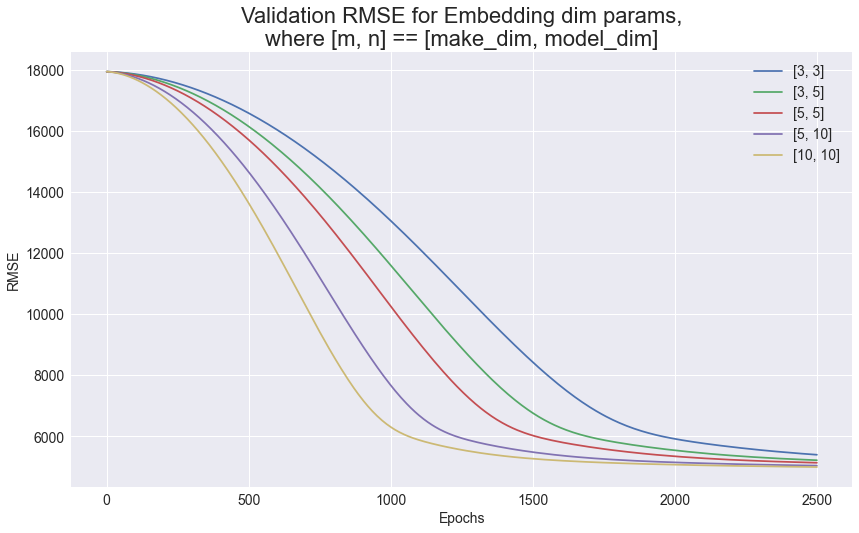

In [ ]:
# Generate a nice plot to compare the different embedding dimension choices
for i in range(len(histories)):
    plt.plot(range(len(histories[i].history['val_root_mean_squared_error'])),
             histories[i].history['val_root_mean_squared_error'])

plt.title('Validation RMSE for Embedding dim params,\nwhere [m, n] == [make_dim, model_dim]')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend([
    '[3, 3]',
    '[3, 5]',
    '[5, 5]',
    '[5, 10]',
    '[10, 10]',
])
plt.show()

With our hyperparameters chosen, we can train the layers fully. We will use early stopping to select the best model and prevent overfitting.

In [ ]:
# Early stopping callback, which stops training, and reverts back to the
# best model is saw after no improvement of validation loss
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
%%time
## Same again
make_dim = 3
model_dim = 5

input_make = tf.keras.layers.Input(shape=(1,))
input_model = tf.keras.layers.Input(shape=(1,))

embedding_make = Embedding(input_dim=num_make+1, output_dim=make_dim,
                           name='embedding_make')(input_make)
embedding_model = Embedding(input_dim=num_model+1, output_dim=model_dim,
                           name='embedding_model')(input_model)

concat = tf.keras.layers.Concatenate()([embedding_make, embedding_model])

output = tf.keras.layers.Dense(1)(concat)

model = tf.keras.Model(inputs=[input_make, input_model],
                      outputs=output)

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(lr=3e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit((make_train_labels, model_train_labels), y_train_array,
                    validation_data=((make_test_labels, model_test_labels), y_test_array),
                    epochs=10000, callbacks=[early_stopping], verbose=0)

Wall time: 31min 10s


In [ ]:
# Save the model after that hard work
model.save('trained_embedding_model.h5')

In [ ]:
# Checkpoint
model = tf.keras.models.load_model('trained_embedding_model.h5')

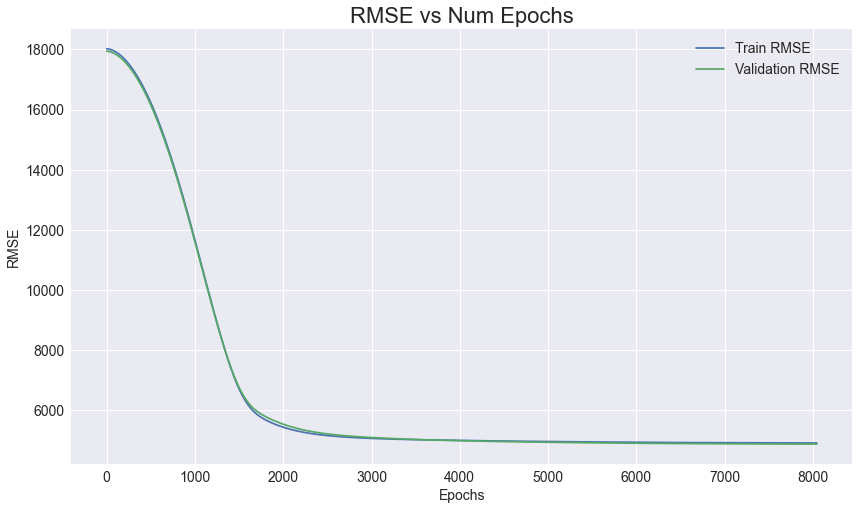

In [ ]:
# Though there is very little improvement beyond 2000 epochs,
# it doesn't appear to be overfitting, as the validation RMSE is not deteriorating.
# Thus, we are happy to keep the latest model
plt.plot(range(len(history.history['root_mean_squared_error'])),
         history.history['root_mean_squared_error'])
plt.plot(range(len(history.history['val_root_mean_squared_error'])),
         history.history['val_root_mean_squared_error'])

plt.title('RMSE vs Num Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['Train RMSE', 'Validation RMSE'])
plt.show()

In [ ]:
# Save the numpy array versions of the layers just in case they come in handy
embedding_matrix_make = model.get_layer('embedding_make').get_weights()[0]
embedding_matrix_model = model.get_layer('embedding_model').get_weights()[0]

In [ ]:
# Save
np.save('embedding_matrix_make.npy', embedding_matrix_make)
np.save('embedding_matrix_model.npy', embedding_matrix_model)

Great! Now that we have trained our model, we can generate our features to be used in our shallow learning models!

In [ ]:
# This was probably short-sighted as we didn't use an out-of-vocabulary token when encoding
# and sequences of length 0 due to OOV words cause a problem.
# Not to worry, we can add a 0 to those sequences,
# which will pass through the model unaffected
make_sequence = make_tokenizer.texts_to_sequences(X_emb['make'])
model_sequence = model_tokenizer.texts_to_sequences(X_emb['model'])

for i in range(len(model_sequence)):
    if len(model_sequence[i]) == 0:
        model_sequence[i].append(0)

make_sequence = tf.cast(tf.squeeze(tf.constant(make_sequence)), tf.float32)
model_sequence = tf.cast(tf.squeeze(tf.constant(model_sequence)), tf.float32)

In [ ]:
# Grab each embedding layer from the previous model
embedding_layer_make = model.get_layer('embedding_make')
# Ensure that the layer's parameters cannot be changed anymore!
embedding_layer_make.trainable = False

embedding_layer_model = model.get_layer('embedding_model')
embedding_layer_model.trainable = False

In [ ]:
# Create 2 new 'models', which recieve the sequences and matrix multiplies with
# the embedding layers to generate 3 and 5 features per sample,
# for make and model respectively

# Sequential model
feature_generator_make = tf.keras.models.Sequential([
    # Input layer to establish the array shape to expect. This layer is also not trainable
    tf.keras.layers.InputLayer(input_shape=[1,]),
    # The learned embedding layer!
    embedding_layer_make
])
# Same for second model
feature_generator_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1,]),
    embedding_layer_model
])

In [ ]:
# Use the model's fit method to create the new features
make_array = feature_generator_make.predict(make_sequence)
print(make_array.shape)
# Remove inner dimension, to go from 3D to 2D
make_array = np.squeeze(make_array, axis=1)
print(make_array.shape)

(4386, 1, 3)
(4386, 3)


In [ ]:
# Same as above
model_array = feature_generator_model.predict(model_sequence)
model_array = np.squeeze(model_array, axis=1)

In [ ]:
# Concatenated array of on 8 features (3 for make, 5 for model)
features_array = np.concatenate((make_array, model_array), axis=1)

In [ ]:
# Quick inpection!
make_array[0]

array([-23.71849 , -23.670856, -23.650126], dtype=float32)

In [ ]:
model_array[0]

array([-0.02695912,  0.03777892, -0.00145058,  0.002194  ,  0.00422692],
      dtype=float32)

In [ ]:
features_array[0]

array([-2.3718491e+01, -2.3670856e+01, -2.3650126e+01, -2.6959121e-02,
        3.7778918e-02, -1.4505759e-03,  2.1939985e-03,  4.2269230e-03],
      dtype=float32)

In [ ]:
# create features

In [ ]:
# Feature names for creating a pandas DataFrame
columns = ['make_embedding_1', 'make_embedding_2', 'make_embedding_3',
          'model_embedding_1', 'model_embedding_2', 'model_embedding_3',
          'model_embedding_4', 'model_embedding_5']

feature_embeddings_df = pd.DataFrame(features_array, columns=columns)

In [ ]:
# Create a final DataFrame with all the features, including all learned latent features
# as well as the tokenized label encoding for make and model (both won't be used together)
final_df = numeric_vars.join(
    categorical_vars_2).drop(
    'Unnamed: 0', axis=1).join(
    feature_embeddings_df)

final_df['make'] = make_sequence
final_df['model'] = model_sequence

final_df

price  reg_year  mileage  seats  engine  gearbox  prev_owners  \
0     14350.0    2019.0   9044.0    5.0     1.3      6.0          1.0   
1     15525.0    2017.0  29578.0    5.0     2.0      6.0          1.0   
2     11550.0    2018.0  31400.0    5.0     1.3      6.0          1.0   
3     17125.0    2016.0  51307.0    5.0     2.0      6.0          2.0   
4      7700.0    2016.0  38475.0    5.0     1.2      5.0          2.0   
...       ...       ...      ...    ...     ...      ...          ...   
4381  14625.0    2018.0  28094.0    5.0     1.5      6.0          1.0   
4382   9525.0    2017.0  24701.0    5.0     1.0      5.0          2.0   
4383  17725.0    2018.0  31775.0    5.0     2.0      8.0          1.0   
4384  10950.0    2018.0  13236.0    5.0     1.0      6.0          2.0   
4385  20075.0    2017.0  10552.0    5.0     3.0      8.0          1.0   

      num_keys  emissions  ulez_compliant  ...  drive_type_missing  \
0          2.0      146.0             1.0  ...                 0.0   
1          3.0      119.0             1.0  ...                 0.0   
2          2.0      134.0             1.0  ...                 0.0   
3          2.0      168.0             1.0  ...                 0.0   
4          2.0      114.0             1.0  ...                 0.0   
...        ...        ...             ...  ...                 ...   
4381       1.0      145.0             1.0  ...                 0.0   
4382       NaN        NaN             NaN  ...                 1.0   
4383       2.0      123.0             1.0  ...                 0.0   
4384       2.0      110.0             1.0  ...                 0.0   
4385       2.0      131.0             1.0  ...                 0.0   

      drive_type_rwd  make_embedding_1  make_embedding_2  make_embedding_3  \
0                0.0        -23.718491        -23.670856        -23.650126   
1                0.0        -27.307554        -27.190817        -27.170572   
2                0.0        -23.718491        -23.670856        -23.650126   
3                0.0        -32.064629        -32.019272        -31.933037   
4                0.0        -29.889017        -29.762043        -29.697151   
...              ...               ...               ...               ...   
4381             0.0        -25.504082        -25.365002        -25.330496   
4382             0.0        -25.504082        -25.365002        -25.330496   
4383             0.0        -39.808937        -39.623867        -39.680172   
4384             0.0        -25.504082        -25.365002        -25.330496   
4385             1.0        -39.808937        -39.623867        -39.680172   

      model_embedding_1  model_embedding_2  model_embedding_3  \
0             -0.026959           0.037779          -0.001451   
1              0.020059          -0.037154           0.036534   
2              0.013896           0.006950           0.015837   
3             25.291424          25.502977         -25.578434   
4             -0.020811           0.034222          -0.028426   
...                 ...                ...                ...   
4381          50.359318          50.478611         -50.465485   
4382          40.149166          40.288261         -40.303856   
4383          45.150036          45.269394         -45.260277   
4384          40.149166          40.288261         -40.303856   
4385          45.150036          45.269394         -45.260277   

      model_embedding_4  model_embedding_5  
0              0.002194           0.004227  
1              0.047990           0.013081  
2             -0.026286          -0.023134  
3            -25.461617          25.480682  
4             -0.017493          -0.016079  
...                 ...                ...  
4381         -50.444931          50.458416  
4382         -40.255322          40.204727  
4383         -45.241737          45.176308  
4384         -40.255322          40.204727  
4385         -45.241737          45.176308  

[4386 rows x 54 columns]

In [ ]:
# Save!
final_df.to_csv('final_df.csv')

In [ ]:
# Checkpoint 
final_df = pd.read_csv('final_df.csv')

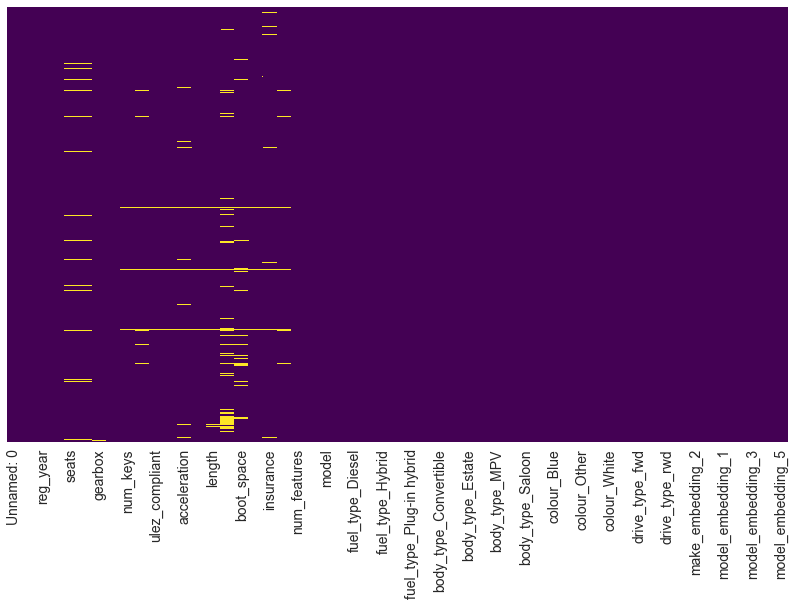

In [ ]:
# Inspect missing Values
sns.heatmap(final_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

## Re-test all models
We can now repeat our model test process, and see if these added engineered features have improved our model's performances.

First I would like to develop a baseline, by training a model with the numeric and one-hot features. This is see whether going to all the trouble of creating feature embeddings was worth it, or add any value. Recall that our most promising model was the LightGBM which had an RMSE of 1803. So let's quickly test that again with default hyperparameters.


In [ ]:
# Remove make and model token sequences, and target variable price
X = final_df.drop(['make', 'model', 'price', 'Unnamed: 0'], axis=1)
# Remove all latent features from the embeddings
X = X.drop(columns, axis=1)
# Create target data
y = final_df['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute median for missing values
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
# Use a gradient boosted model with default values (LightGBM)
lgb_reg = LGBMRegressor()
lgb_reg.fit(X_train, y_train)
y_pred = lgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1847.231361310627

Interestingly, adding all the one-hot encoded categorical features has deteriorated the model performance! With an RMSE of 1845 (roughly 3% worse). We will need to do some variable reduction to keep on the useful features.

## Test all features together
Great, now that we have our final dataset and have established a baseline with numeric, and with one-hot features, we can do a second round of model training to see if all this hard work as paid off.<br>
<br>
We again need to do a small amount of preprocessing. We will split again into a train test split, ensuring the same split as last time using the random_seed parameter.<br>
<br>
We'll then impute missing values with their column's median learned from the train set.
<br>
As before, we'll have a standardised set for the linear model, a MinMax scaled set for our deep neural net, and an unscaled set for the tree-based models.<br>
<br>
We'll drop the token sequences from the tree and linear model's datasets, as that was the purpose of creating the latent features for them to learn from.<br>
<br>
For our deep neural net, we will drop the latent features, as they will be redundant to re-use, when we can learn them again, but alonside all the other variables (we can also increase complexity and not limit to 3 and 5 embedding dimensions).

In [ ]:
def create_data_split(X, y, scaling=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, random_state=42)
    
    # Learn medians
    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train)
    
    # Impute median for missing values
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)
    
    # For tree based models where no scaling is required
    if scaling == None:
        return X_train, X_test, y_train, y_test
    
    # For for linear models we use a standard scaler
    elif scaling == 'standard_scale':
        standardiser = StandardScaler()
        standardiser.fit(X_train)
        
        X_train = standardiser.transform(X_train)
        X_test = standardiser.transform(X_test)
        
        return X_train, X_test, y_train, y_test
    
    # For DNN model we use min max scaling
    elif scaling == 'min_max_scale':
        normaliser = MinMaxScaler()
        normaliser.fit(X_train)
        
        X_train = normaliser.transform(X_train)
        X_test = normaliser.transform(X_test)
        
        X_train = np.expand_dims(X_train, axis=1)
        X_test = np.expand_dims(X_test, axis=1)
        
        return X_train, X_test, y_train, y_test

In [ ]:
# Separate features and target
X = final_df.drop(['make', 'model', 'price', 'Unnamed: 0'], axis=1)
y = final_df['price']

# Specific set for dnn
X_dnn = X.drop(columns, axis=1)

In [ ]:
# Data for trees
X_train, X_test, y_train, y_test = create_data_split(X, y)

# Data for linear model
X_train_standard, X_test_standard, \
y_train, y_test = create_data_split(X, y, scaling='standard_scale')

# Data for trees
X_train_dnn, X_test_dnn, \
y_train, y_test = create_data_split(X_dnn, y, scaling='min_max_scale')

## Re-test all models
We can now repeat our model test process, and see if these added engineered features have improved our model's performances.

In [ ]:
# Use a linear model with default values
lin_reg = LinearRegression()
lin_reg.fit(X_train_standard, y_train)
y_pred = lin_reg.predict(X_test_standard)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

2227.5785523508257

In [ ]:
# Use a random forest model with default values
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1818.5872321079012

In [ ]:
# Use a gradient boosted model with default values (xgboost)
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1703.984007625385

In [ ]:
# Use a gradient boosted model with default values (LightGBM)
lgb_reg = LGBMRegressor()
lgb_reg.fit(X_train, y_train)
y_pred = lgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1669.3879551292173

All models improved! Fantastic! This displays the power of learned latent features using word embeddings.<br>
<br>
Our initial most promising model LightGBM went from roughly 1803 RMSE to 1669! A ~7% improvement. In fact, it would be fairer to compare to the version which had the numeric AND one-hot categorical features to isolate the added value of the latent features: from 1847 to 1669 RMSE: ~10% improvement!<br>

The following is the is deep neural net model, which relearned the embeddings and combined them with the rest of the features. The rest of the architecture is identical to before:

In [ ]:
# Concatenate layer requires a dim of [None, 1, n] to join layers
# our data currently has dim of [None, n] per sample, so we add a dimension 
X_train_dnn = np.expand_dims(X_train_dnn, axis=1)
X_test_dnn = np.expand_dims(X_test_dnn, axis=1)

In [ ]:
# As a rule of thumb, the fourth root of the length of your vocabulary
# (number of unique car makes and models) is a good value for embedding dimensions
# In retrospect, this may have been useful earlier
# We will use 3 and 4
num_make**0.25

2.449489742783178

In [ ]:
num_model**0.25

4.030890324639449

In [ ]:
%%time

## Train a deep neural net using TensorFlow using the Functional API
# We have 3 seperate inputs: make token sequence, model token sequence,
# and the rest of the data.
# These concatenate into the same feed-forward network of Dense layers as before

# Embedding dims
make_dim = 3
model_dim = 4

# 3 input layers
input_make = tf.keras.layers.Input(shape=(1,))
input_model = tf.keras.layers.Input(shape=(1,))
input_rest = tf.keras.layers.Input(shape=(1,43))

# Both embedding layers
embedding_make = Embedding(input_dim=num_make+1, output_dim=make_dim,
                           embeddings_regularizer=tf.keras.regularizers.L2(),
                           name='embedding_make')(input_make)

embedding_model = Embedding(input_dim=num_model+1, output_dim=model_dim,
                            embeddings_regularizer=tf.keras.regularizers.L2(),
                            name='embedding_model')(input_model)

# Concatenate 2 embedding layers with input of the regular features
concat = tf.keras.layers.Concatenate()([embedding_make, embedding_model, input_rest])

# Standard feed-forward network, with the same architecture as before
x = tf.keras.layers.Dense(1024, activation='relu')(concat)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)

# Single node output layer with no activation function as this is a regression problem
output = tf.keras.layers.Dense(1)(x)

# Create the model by giving all the layers
dnn_model = tf.keras.Model(inputs=[input_make, input_model, input_rest],
                           outputs=output)

# Compile the model, giving a loss, optimizer and metric to monitor
dnn_model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(lr=3e-4),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit the model
history = dnn_model.fit((make_train_labels, model_train_labels, X_train_dnn),
                        y_train_array, epochs=100, verbose=0)

Wall time: 1min 1s


In [ ]:
# Evaluate the performance
dnn_model.evaluate((make_test_labels, model_test_labels, X_test_dnn), y_test_array)

28/28 [==============================] - 0s 4ms/step - loss: 2475267.5000 - root_mean_squared_error: 1573.2983


[2475267.5, 1573.29833984375]

Incredible! the dnn went from performing worse than all of the tree ensemble models, to now having the best performance! An RMSE improvement of ~27%!

## Feature Selection
As we saw earlier, adding the one-hot categorical data actually reduced performance. Let's see which redundant features we can remove.

### First let's look at feature importance.
Unfortunately, each model had different features that it found useful, so we can't remove these features across the board if we want to give each model a fair chance when doing the final model selection.

In [ ]:
# Helper function to retrieve feature importance of each model
# and put into a DataFrame ranked most import first
def feature_importance(model, df):
    return pd.DataFrame({'features':df.columns, 'importance':model.feature_importances_}
                       ).sort_values('importance', ascending=False)

In [ ]:
# A handy plot to view the relative importances
def plot_fi(fi):
    return fi.plot('features', 'importance', 'barh', legend=False)

### Random Forest
First lets take a look at the top 10 most important features to the model.<br>
<br>
Some are quite intuitive, and would likely inform the pricing of the car, such as engine power; a more powerful car will likely be more expensive.<br>
<br>
Others will likely will not cause the price, but in fact be caused BY the price. For example vehicle_tax would likely come after a cars valuation (not by cazoo, but by insurance company's own pricing models), as more expensive cars are more expensive to insure (as they cost more to repair).<br>
<br>
Really cool to see that a make embedding made it to the top 10. Meaning the dnn model learned something about the value of a car's brand!

In [ ]:
# Top 10 most important features of the Random Forest model 
rf_fi = feature_importance(forest_reg, X)
rf_fi.head(10)

features  importance
11      engine_power    0.354738
15       vehicle_tax    0.197242
4            gearbox    0.074077
16         insurance    0.063089
7          emissions    0.051556
1            mileage    0.037448
12            length    0.028127
18      num_features    0.025225
3             engine    0.014299
45  make_embedding_3    0.013574

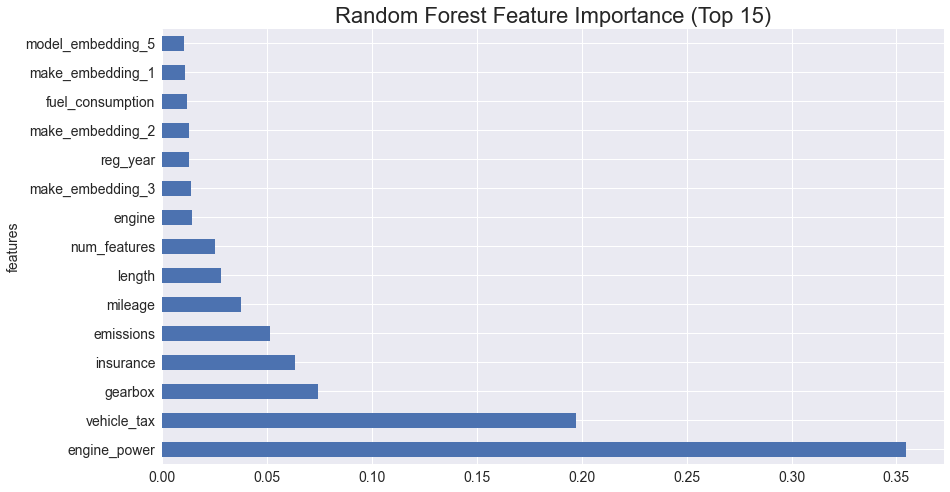

In [ ]:
plot_fi(rf_fi.head(15))
plt.title('Random Forest Feature Importance (Top 15)')
plt.show()

Now let's take a look at the least important features. As predicted earlier, colour made very little impact on the model. ulez_compiant was also pretty useless, since nearly every car was ULEZ complaint.<br>
<br>
Fuel type also unimportant (we can imagine an expesive BMW regardless of diesel or petrol electric etc.)

In [ ]:
rf_fi.tail(10)

features  importance
27           body_type_Coupe    0.000325
20          fuel_type_Diesel    0.000319
34               colour_Blue    0.000307
42            drive_type_rwd    0.000291
22          fuel_type_Hybrid    0.000186
26     body_type_Convertible    0.000169
30             body_type_MPV    0.000157
24  fuel_type_Plug-in hybrid    0.000081
41        drive_type_missing    0.000076
8             ulez_compliant    0.000053

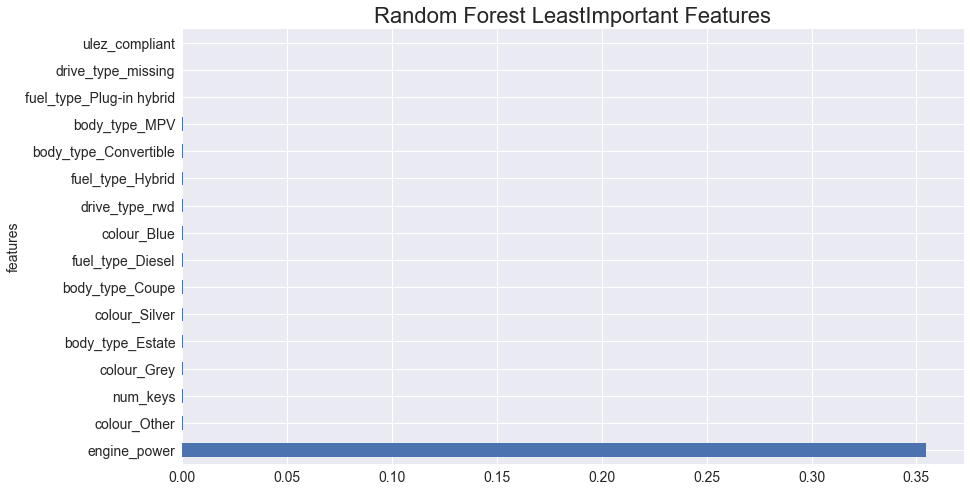

In [ ]:
# Plot of the 15 least important features, with the most important feature for comparison
# Otherwise, the features scaled to fill the y-axis and looked deceivingly important!
plot_fi(pd.concat([rf_fi.head(1), rf_fi.tail(15)]))
plt.title('Random Forest LeastImportant Features')
plt.show()

### XGBoost
Now let's repeat the process for XGBoost and LightGBM

In [ ]:
# Top 10 most important features of the XGBoost model 
xgb_fi = feature_importance(xgb_reg, X)
xgb_fi.head(10)

features  importance
4               gearbox    0.191990
11         engine_power    0.183601
15          vehicle_tax    0.140002
29  body_type_Hatchback    0.139323
39       drive_type_4x4    0.066315
40       drive_type_fwd    0.038050
31        body_type_SUV    0.030652
45     make_embedding_3    0.026749
43     make_embedding_1    0.019296
7             emissions    0.018707

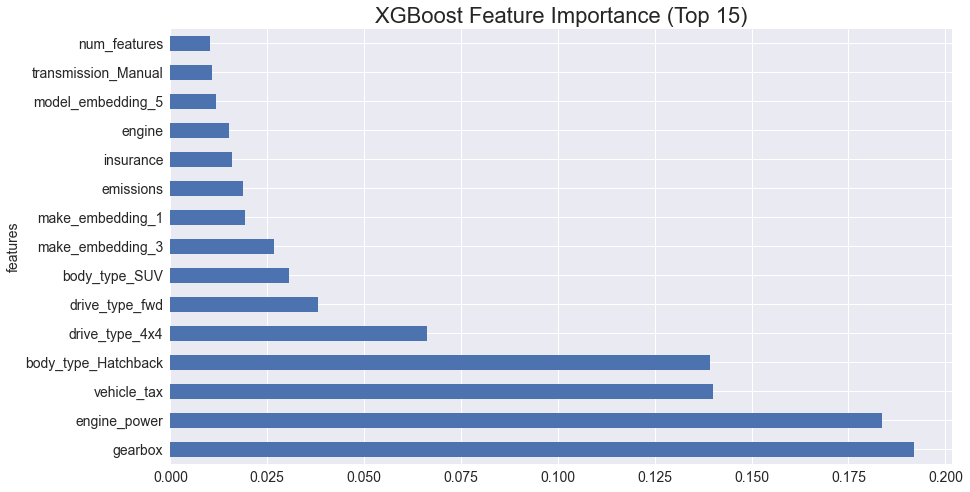

In [ ]:
plot_fi(xgb_fi.head(15))
plt.title('XGBoost Feature Importance (Top 15)')
plt.show()

In [ ]:
xgb_fi.tail(10)

features  importance
5                prev_owners    0.000603
37             colour_Silver    0.000587
36              colour_Other    0.000521
30             body_type_MPV    0.000373
6                   num_keys    0.000286
33              colour_Black    0.000283
38              colour_White    0.000259
34               colour_Blue    0.000246
24  fuel_type_Plug-in hybrid    0.000203
42            drive_type_rwd    0.000186

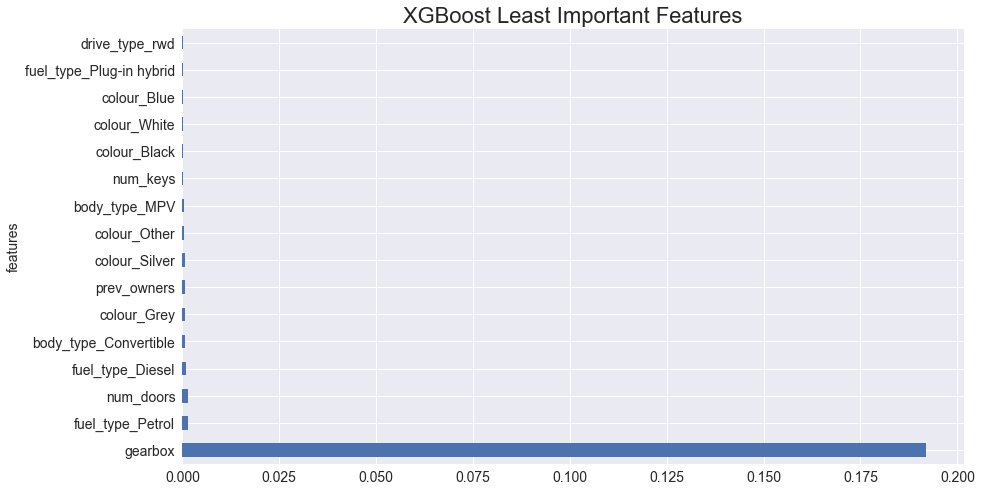

In [ ]:
plot_fi(pd.concat([xgb_fi.head(1), xgb_fi.tail(15)]))
plt.title('XGBoost Least Important Features')
plt.show()

### LightGBM
Interesting to see insurance as the top predictor, but it is as we mentioned before, directly correlated with price, and in fact based on the price. If cazoo were a car insurance company, insurance price would be the target variable and car price would be an input variable!.

In [ ]:
# Top 10 most important features of the XGBoost model 
lgb_fi = feature_importance(lgb_reg, X)
lgb_fi.head(10)

features  importance
16          insurance         314
1             mileage         281
11       engine_power         191
43   make_embedding_1         169
0            reg_year         161
12             length         161
7           emissions         161
14         boot_space         146
18       num_features         125
46  model_embedding_1         121

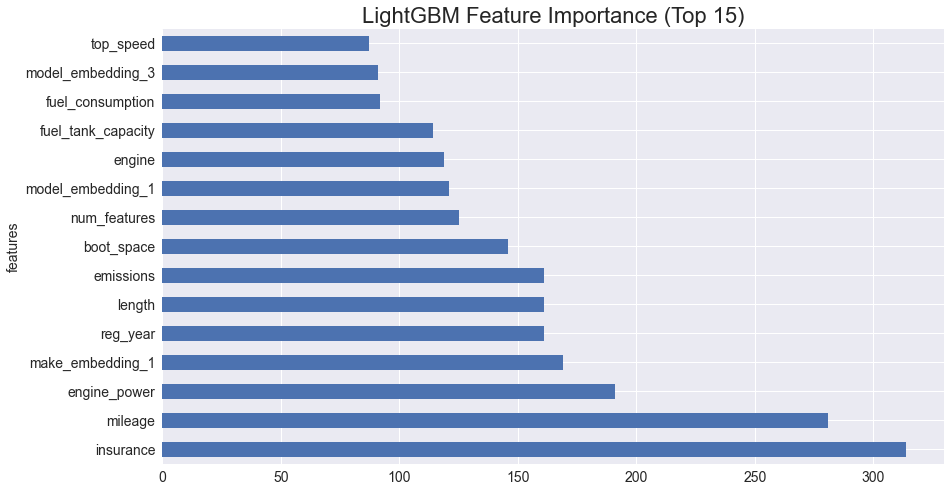

In [ ]:
plot_fi(lgb_fi.head(15))
plt.title('LightGBM Feature Importance (Top 15)')
plt.show()

In [ ]:
lgb_fi.tail(10)

features  importance
24  fuel_type_Plug-in hybrid           4
45          make_embedding_3           3
6                   num_keys           2
34               colour_Blue           2
44          make_embedding_2           2
33              colour_Black           2
26     body_type_Convertible           1
22          fuel_type_Hybrid           1
42            drive_type_rwd           1
8             ulez_compliant           0

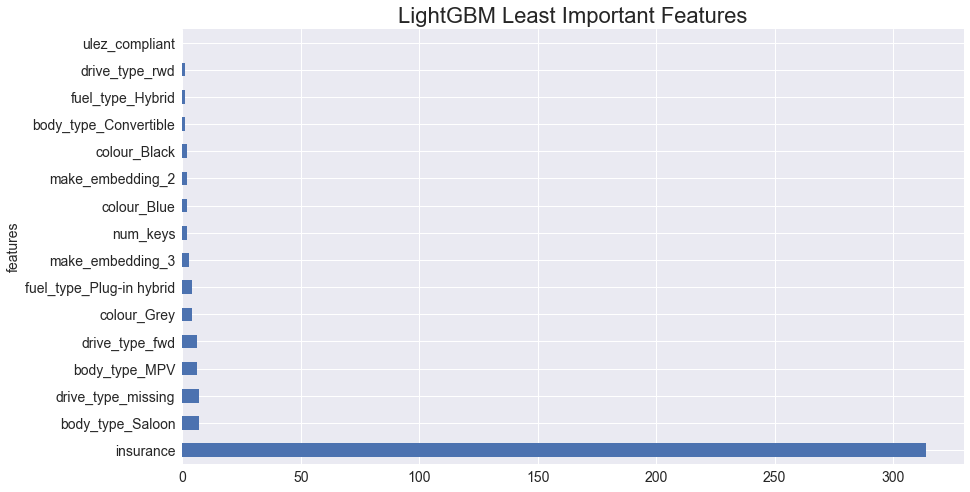

In [ ]:
plot_fi(pd.concat([lgb_fi.head(1), lgb_fi.tail(15)]))
plt.title('LightGBM Least Important Features')
plt.show()

## Which Feautes are Commonly Important to Each Model
Let's check which feautes have high importance for all three models

In [ ]:
# Check the top n features of each model
n = 15

# Use 2 inner joins to find the interset between all three tables of top n features
intersect = pd.merge(rf_fi.head(n), xgb_fi.head(n), how='inner', on='features')
intersect = pd.merge(intersect, xgb_fi.head(n), how='inner', on='features')

In [ ]:
# Generate a new column which is the average importance of all three models
intersect['mean_importance'] = (intersect['importance_x'] + \
                                intersect['importance_y'] + \
                                intersect['importance']) / 3.

In [ ]:
# =Sort by most important
intersect.sort_values(by='mean_importance', ascending=False, inplace=True)

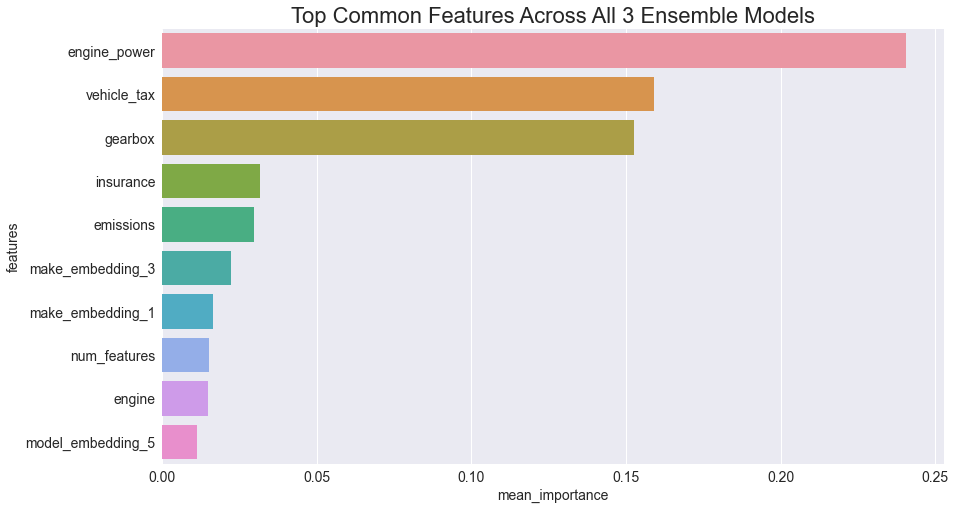

In [ ]:
# Check out the results in a bar plot
sns.barplot(x='mean_importance', y='features', data=intersect, orient='h')
plt.title('Top Common Features Across All 3 Ensemble Models')
plt.show()

Nice! We have car mechanical atributes (such as power, gearbox, engine, and number of features), then we have perceived value from branding (make and model), and finally again the chicken-and-the-egg scenario where insurance and tax don't necessarily 'predict' the price, but are highly correlated, as THEY are predicted FROM the price.

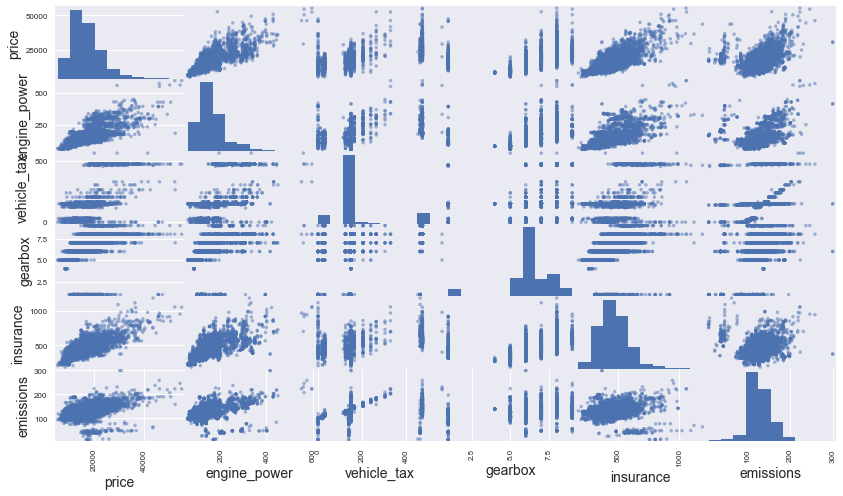

In [ ]:
# We can also create a scatter matrix
# and see how the top 5 features correlate with price (and each other)
top_features = ['price']
for feature in list(intersect['features'].head(5)):
    top_features.append(feature)

scatter_matrix(final_df[top_features])
plt.show()

### With all this in mind, let's reduce some less important features and see how it affects each model

#### Random Forest (baseline RMSE: 1818.6)

In [ ]:
# Keep only columns above 0.005 relative importance
rf_to_keep = rf_fi[rf_fi.importance>0.005].features
# Check how many features we are keeping
len(rf_to_keep)

23

In [ ]:
# New train test split of the reduced features
X_train_rf, X_test_rf, y_train, y_test = create_data_split(X[rf_to_keep], y)

In [ ]:
# Random Forest with the reduced features
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_rf, y_train)
y_pred = forest_reg.predict(X_test_rf)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1810.293693746057

Great, that improved our score. But imporantly, didn't make it worse, and we were able to reduce the model's complexity.

#### XGBoost (baseline RMSE: 1704.0)

In [ ]:
# Keep only columns above 0.002 relative importance
xgb_to_keep = xgb_fi[xgb_fi.importance>0.002].features
# Check how many features we are keeping
len(xgb_to_keep)

34

In [ ]:
# New train test split of the reduced features
X_train_xgb, X_test_xgb, y_train, y_test = create_data_split(X[xgb_to_keep], y)

In [ ]:
# XGBoost with the reduced features
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train_xgb, y_train)
y_pred = xgb_reg.predict(X_test_xgb)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1642.4112139530416

In [ ]:
Another great improvement

#### LightGBM (baseline RMSE: 1669.4)

In [ ]:
# Keep only columns above 50 relative importance
# (LightGBM gives relative feature importance on a different scale)
lgb_to_keep = lgb_fi[lgb_fi.importance>50].features
# Check how many features we are keeping
len(lgb_to_keep)

20

In [ ]:
X_train_lgb, X_test_lgb, y_train, y_test = create_data_split(X[lgb_to_keep], y)

In [ ]:
# Use a gradient boosted model with default values (LightGBM)
lgb_reg = LGBMRegressor()
lgb_reg.fit(X_train_lgb, y_train)
y_pred = lgb_reg.predict(X_test_lgb)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1601.111761282081

Down to 1600 RMSE!

## One final step of investigating feature importance
We can look at the coefficients learned in our linear regression model to get an intuitive look at how the top features affected price

In [ ]:
# Create a list of lists with each feature and its corresponding coefficient
i = 0
col_df = []
for m in lin_reg.coef_:
    col_df.append([list(X.columns)[i], m])
    i+=1

In [ ]:
# Convert to pandas DataFrame
col_df = pd.DataFrame(col_df)

In [ ]:
# Sort by largest coefficients
col_df[2] = col_df[1].apply(lambda x: abs(x))
col_df.sort_values(by=2, ascending=False, inplace=True)
col_df.reset_index(drop=True, inplace=True)
col_df

0              1              2
0          model_embedding_3  174474.430465  174474.430465
1          model_embedding_2  127082.207646  127082.207646
2           make_embedding_3   48833.324784   48833.324784
3          model_embedding_5   38053.104947   38053.104947
4           make_embedding_2   28790.378855   28790.378855
5           make_embedding_1   21686.208483   21686.208483
6          model_embedding_1    8553.213529    8553.213529
7               engine_power    2030.306823    2030.306823
8                  insurance    1747.222489    1747.222489
9                   reg_year    1012.444012    1012.444012
10         model_embedding_4    1002.160978    1002.160978
11                    engine    1001.502713    1001.502713
12                   mileage     986.845763     986.845763
13          body_type_Saloon     625.787364     625.787364
14                 emissions     592.033767     592.033767
15               vehicle_tax     568.793069     568.793069
16             body_type_SUV     538.362627     538.362627
17          fuel_type_Hybrid     473.227310     473.227310
18       transmission_Manual     443.196110     443.196110
19                     seats     415.735415     415.735415
20                 num_doors     350.555948     350.555948
21              acceleration     334.713571     334.713571
22        fuel_type_Electric     332.027873     332.027873
23          fuel_type_Petrol     330.226628     330.226628
24            drive_type_rwd     275.645810     275.645810
25  fuel_type_Plug-in hybrid     268.305303     268.305303
26              num_features     245.679096     245.679096
27                   gearbox     192.707698     192.707698
28             body_type_MPV     179.311787     179.311787
29                boot_space     174.392182     174.392182
30          body_type_Estate     148.945556     148.945556
31                    length     130.449925     130.449925
32            drive_type_4x4     129.298348     129.298348
33            drive_type_fwd      83.562335      83.562335
34                 top_speed      82.328280      82.328280
35               prev_owners      56.310249      56.310249
36             colour_Silver      54.103631      54.103631
37           body_type_Coupe      43.343786      43.343786
38               colour_Grey      39.436988      39.436988
39              colour_White      37.048870      37.048870
40               colour_Blue      36.846269      36.846269
41        drive_type_missing      33.147757      33.147757
42       body_type_Hatchback      32.380043      32.380043
43          fuel_type_Diesel      31.772672      31.772672
44            ulez_compliant      31.013353      31.013353
45     body_type_Convertible      20.839466      20.839466
46          fuel_consumption      18.303904      18.303904
47                  num_keys      15.989932      15.989932
48              colour_Black       6.854135       6.854135
49        fuel_tank_capacity       5.186367       5.186367
50              colour_Other       5.001246       5.001246

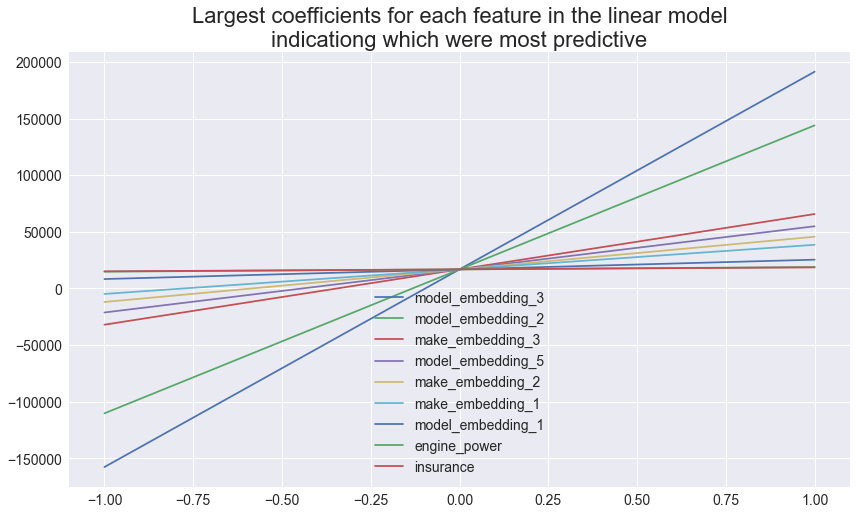

In [ ]:
# Plot each line y = mx + c
# where m are the coefficients, and c is the intercept
# Again, we see the latent features from the embeddings to be really powerful!
legend = []
c = lin_reg.intercept_
x = np.linspace(-1, 1, 100)

for i in range(9):
    m = col_df[1][i]
    y = m*x + c
    plt.plot(x, y)
    legend.append(col_df[0][i])

plt.title('Largest coefficients for each feature in the linear model\nindicationg which were most predictive')
plt.legend(legend, loc='lower center')
plt.show()

## Fine Tuning
Now let's fine-tune our best 3 models; XGBoost, LightGBM and a Deep Neural Network.

### XGBoost random grid search

In [ ]:
# All the different parameters that we want to search through
xgb_param_grid = [
    {'max_depth': [3, 4, 5, 6, 7, 8, 9],
     'learning_rate': [0.15, 0.25, 0.3, 0.35, 0.4, 0.45],
     'max_leaves': [0, 200, 250, 300, 350, 500],
     'tree_method': ['auto', 'exact', 'approx', 'hist']
    }]

# Fit random search cross-validator
xgb_reg = XGBRegressor()
xgb_grid_search = RandomizedSearchCV(xgb_reg, xgb_param_grid, cv=5, n_iter=200,
                                    scoring='neg_mean_squared_error',
                                    return_train_score=True,
                                    random_state=42, n_jobs=-1)

xgb_grid_search.fit(X_train_xgb, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [ ]:
xgb_grid_search.best_params_

{'tree_method': 'exact',
 'max_leaves': 0,
 'max_depth': 4,
 'learning_rate': 0.35}

In [ ]:
# Use a gradient boosted model with default values (LightGBM)
xgb_reg = XGBRegressor()

xgb_reg.fit(X_train_xgb, y_train)
y_pred = xgb_reg.predict(X_test_xgb)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1642.4112139530416

Couldn't get any better performance than the default values!

### LightGBM random grid search

In [ ]:
# All the different parameters that we want to search through
lgb_param_grid = [
    {'max_depth': [-1, 10, 15, 20, 25, 30, 40, 50, 60, 70, 100],
     'num_leaves': [5, 10, 20, 31, 35, 40, 45, 50, 100],
     'boosting_type': ['gbdt', 'dart'],
     'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.5]
    }]

# Fit random search cross-validator
lgb_reg = LGBMRegressor()
lgb_grid_search = RandomizedSearchCV(lgb_reg, lgb_param_grid, cv=5, n_iter=300,
                                    scoring='neg_mean_squared_error',
                                    return_train_score=True,
                                    random_state=42, n_jobs=-1)

lgb_grid_search.fit(X_train_lgb, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=300, n_jobs=-1,
                   param_distributions=[{'boosting_type': ['gbdt', 'dart'],
                                         'learning_rate': [0.001, 0.01, 0.05,
                                                           0.1, 0.15, 0.5],
                                         'max_depth': [-1, 10, 15, 20, 25, 30,
                                                       40, 50, 60, 70, 100],
                                         'num_leaves': [5, 10, 20, 31, 35, 40,
                                                        45, 50, 100]}],
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [ ]:
lgb_grid_search.best_params_

{'num_leaves': 45,
 'max_depth': 20,
 'learning_rate': 0.15,
 'boosting_type': 'gbdt'}

In [ ]:
# Test new params LightGBM
lgb_reg = LGBMRegressor(learning_rate=0.15, max_depth=20, num_leaves=45,
                        random_state=42)
lgb_reg.fit(X_train_lgb, y_train)
y_pred = lgb_reg.predict(X_test_lgb)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1557.6318736953465

RMSE of 1557.6! The lowest so far!

### Deep Neural Net
Now let's build our final Deep Net. We can remove the features that ranked bottom for importance for the three tree-based model.<br>
<br>
We'll use quite an exotic architecture, with a high level of complexity. To prevent overfitting, we can use regularisation techniques.<br>
<br>
We'll be using residual learning with skip connections, similar to the ResNet model https://arxiv.org/abs/1512.03385, and a wide & deep architecture https://arxiv.org/abs/1606.07792.<br>
<br>
We will also use L2 regularisation and Dropout layers at 50% rate.


In [ ]:
# Check the bottom n features of each model
n = 20

# Use 2 inner joins to find the interset between all three tables of top n features
bottom_intersect = pd.merge(rf_fi.tail(n), xgb_fi.tail(n), how='inner', on='features')
bottom_intersect = pd.merge(bottom_intersect, xgb_fi.tail(n), how='inner', on='features')

# Generate a new column which is the average importance of all three models
bottom_intersect['mean_importance'] = (bottom_intersect['importance_x'] + \
                                       bottom_intersect['importance_y'] + \
                                       bottom_intersect['importance']) / 3.

# Sort by least important
bottom_intersect.sort_values(by='mean_importance', ascending=True, inplace=True)

In [ ]:
# Least important features
bottom_intersect

features  importance_x  importance_y  importance  \
14  fuel_type_Plug-in hybrid      0.000081      0.000203    0.000203   
11            drive_type_rwd      0.000291      0.000186    0.000186   
10               colour_Blue      0.000307      0.000246    0.000246   
13             body_type_MPV      0.000157      0.000373    0.000373   
5                   num_keys      0.000546      0.000286    0.000286   
3               colour_Black      0.000561      0.000283    0.000283   
2               colour_White      0.000610      0.000259    0.000259   
8              colour_Silver      0.000333      0.000587    0.000587   
4               colour_Other      0.000546      0.000521    0.000521   
12     body_type_Convertible      0.000169      0.000734    0.000734   
6                colour_Grey      0.000520      0.000641    0.000641   
0                prev_owners      0.000916      0.000603    0.000603   
9           fuel_type_Diesel      0.000319      0.001039    0.001039   
1           fuel_type_Petrol      0.000872      0.001592    0.001592   
15        drive_type_missing      0.000076      0.002357    0.002357   
7           body_type_Estate      0.000374      0.002326    0.002326   

    mean_importance  
14         0.000162  
11         0.000221  
10         0.000267  
13         0.000301  
5          0.000373  
3          0.000375  
2          0.000376  
8          0.000502  
4          0.000529  
12         0.000546  
6          0.000601  
0          0.000707  
9          0.000799  
1          0.001352  
15         0.001597  
7          0.001676

In [ ]:
# List of column names
dnn_to_drop = list(bottom_intersect['features'])

In [ ]:
# We'll be dropping 16 columns
len(dnn_to_drop)

16

In [ ]:
# New train test split of the reduced features
X_train_dnn, X_test_dnn, \
y_train, y_test = create_data_split(X.drop(dnn_to_drop, axis=1), y,
                                    scaling='min_max_scale')

In [ ]:
## We will create a residual block so that we can repeat the structure easily in the model
class ResidualBlock(tf.keras.layers.Layer):
    # Inherit from Layer class
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        # Generate n layers of Dense layers
        self.hidden = [tf.keras.layers.Dense(n_neurons,
                                             activation="elu",
                                             kernel_initializer="he_normal",
                                             kernel_regularizer='l2')
                                             for _ in range(n_layers)]
    # call is used when a layers is called
    def call(self, inputs):
        # layer that was fed into the res block
        Z = inputs
        # Feed forward through n Dense layers
        for layer in self.hidden:
            Z = layer(Z)
        # Combine the input to the res block with the output of the Dense layers
        return inputs + Z

In [ ]:
%%time

# Train the dnn
make_dim = 3
model_dim = 4

# Input layers
input_make = tf.keras.layers.Input(shape=(1,), name='input_make')
input_model = tf.keras.layers.Input(shape=(1,), name='input_model')
input_rest = tf.keras.layers.Input(shape=(1,35), name='input_rest')

# Regularized embedding layers
embedding_make = Embedding(input_dim=num_make+1, output_dim=make_dim,
                           embeddings_regularizer=tf.keras.regularizers.L2(),
                           name='embedding_make')(input_make)

embedding_model = Embedding(input_dim=num_model+1, output_dim=model_dim,
                            embeddings_regularizer=tf.keras.regularizers.L2(),
                            name='embedding_model')(input_model)

# Join two embeddings with the third input
concat_1 = tf.keras.layers.Concatenate()([embedding_make, embedding_model, input_rest])
x = tf.keras.layers.Dense(1024, activation='elu',
                          kernel_initializer='he_normal',
                          kernel_regularizer='l2')(concat_1)
# Residual blocks and Dropout layers
x = ResidualBlock(2, 1024)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = ResidualBlock(2, 1024)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = ResidualBlock(2, 1024)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = ResidualBlock(2, 1024)(x)
# Wide and Deep architecture, joining the end of the deep layers with the input
concat_2 = tf.keras.layers.Concatenate()([x, input_rest])
output = tf.keras.layers.Dense(1)(concat_2)

# Build model
dnn_model = tf.keras.Model(inputs=[input_make, input_model, input_rest],
                           outputs=output)

# Compile model
dnn_model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(lr=3e-4),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit model
history = dnn_model.fit((make_train_labels, model_train_labels, X_train_dnn),
                        y_train_array,
                        validation_data=((make_test_labels, model_test_labels,
                                          X_test_dnn), y_test_array),
                        epochs=2500, verbose=2)

Epoch 1/300
110/110 - 1s - loss: 46472608.0000 - root_mean_squared_error: 6817.0654 - val_loss: 23180516.0000 - val_root_mean_squared_error: 4814.5957
Epoch 2/300
110/110 - 1s - loss: 9337014.0000 - root_mean_squared_error: 3055.6223 - val_loss: 12610431.0000 - val_root_mean_squared_error: 3551.0903
Epoch 3/300
110/110 - 1s - loss: 7178926.5000 - root_mean_squared_error: 2679.3169 - val_loss: 9660671.0000 - val_root_mean_squared_error: 3108.1321
Epoch 4/300
110/110 - 1s - loss: 6386096.0000 - root_mean_squared_error: 2527.0354 - val_loss: 6701500.0000 - val_root_mean_squared_error: 2588.6895
Epoch 5/300
110/110 - 1s - loss: 6606816.0000 - root_mean_squared_error: 2570.3364 - val_loss: 4646025.0000 - val_root_mean_squared_error: 2155.4204
Epoch 6/300
110/110 - 1s - loss: 5879665.5000 - root_mean_squared_error: 2424.7637 - val_loss: 5352625.5000 - val_root_mean_squared_error: 2313.5334
Epoch 7/300
110/110 - 1s - loss: 5432079.5000 - root_mean_squared_error: 2330.6421 - val_loss: 8425399.

Epoch 56/300
110/110 - 1s - loss: 2829802.7500 - root_mean_squared_error: 1682.1373 - val_loss: 4618765.0000 - val_root_mean_squared_error: 2149.0806
Epoch 57/300
110/110 - 1s - loss: 3222712.5000 - root_mean_squared_error: 1795.1304 - val_loss: 3145065.0000 - val_root_mean_squared_error: 1773.3710
Epoch 58/300
110/110 - 1s - loss: 2949095.5000 - root_mean_squared_error: 1717.2294 - val_loss: 3138528.7500 - val_root_mean_squared_error: 1771.5270
Epoch 59/300
110/110 - 1s - loss: 2719826.0000 - root_mean_squared_error: 1649.1224 - val_loss: 4878219.5000 - val_root_mean_squared_error: 2208.6191
Epoch 60/300
110/110 - 1s - loss: 2663856.5000 - root_mean_squared_error: 1632.0646 - val_loss: 3362761.0000 - val_root_mean_squared_error: 1833.7229
Epoch 61/300
110/110 - 1s - loss: 2770331.2500 - root_mean_squared_error: 1664.3643 - val_loss: 3633764.0000 - val_root_mean_squared_error: 1906.1849
Epoch 62/300
110/110 - 1s - loss: 2769816.0000 - root_mean_squared_error: 1664.2092 - val_loss: 3881

Epoch 111/300
110/110 - 1s - loss: 2072169.3750 - root_mean_squared_error: 1439.4113 - val_loss: 2536657.0000 - val_root_mean_squared_error: 1592.6055
Epoch 112/300
110/110 - 1s - loss: 1876254.1250 - root_mean_squared_error: 1369.6674 - val_loss: 2440408.7500 - val_root_mean_squared_error: 1562.0957
Epoch 113/300
110/110 - 1s - loss: 1663590.2500 - root_mean_squared_error: 1289.6991 - val_loss: 2690373.0000 - val_root_mean_squared_error: 1640.1543
Epoch 114/300
110/110 - 1s - loss: 1730686.5000 - root_mean_squared_error: 1315.4542 - val_loss: 2507631.7500 - val_root_mean_squared_error: 1583.4659
Epoch 115/300
110/110 - 1s - loss: 1800737.1250 - root_mean_squared_error: 1341.8157 - val_loss: 2582524.2500 - val_root_mean_squared_error: 1606.9397
Epoch 116/300
110/110 - 1s - loss: 1875544.8750 - root_mean_squared_error: 1369.4069 - val_loss: 3474703.5000 - val_root_mean_squared_error: 1863.9833
Epoch 117/300
110/110 - 1s - loss: 1731262.6250 - root_mean_squared_error: 1315.6718 - val_los

Epoch 166/300
110/110 - 1s - loss: 1412607.3750 - root_mean_squared_error: 1188.3960 - val_loss: 2565047.7500 - val_root_mean_squared_error: 1601.4757
Epoch 167/300
110/110 - 1s - loss: 1287582.7500 - root_mean_squared_error: 1134.5741 - val_loss: 2474413.2500 - val_root_mean_squared_error: 1572.9233
Epoch 168/300
110/110 - 1s - loss: 1477329.0000 - root_mean_squared_error: 1215.3202 - val_loss: 2302694.7500 - val_root_mean_squared_error: 1517.3558
Epoch 169/300
110/110 - 1s - loss: 1261380.8750 - root_mean_squared_error: 1122.9670 - val_loss: 2236098.5000 - val_root_mean_squared_error: 1495.2495
Epoch 170/300
110/110 - 1s - loss: 1331113.7500 - root_mean_squared_error: 1153.5969 - val_loss: 2378338.7500 - val_root_mean_squared_error: 1542.0797
Epoch 171/300
110/110 - 1s - loss: 1498519.3750 - root_mean_squared_error: 1224.0057 - val_loss: 2226043.5000 - val_root_mean_squared_error: 1491.8826
Epoch 172/300
110/110 - 1s - loss: 1189535.5000 - root_mean_squared_error: 1090.5067 - val_los

Epoch 221/300
110/110 - 1s - loss: 1249326.8750 - root_mean_squared_error: 1117.5466 - val_loss: 3632459.0000 - val_root_mean_squared_error: 1905.7916
Epoch 222/300
110/110 - 1s - loss: 1207473.1250 - root_mean_squared_error: 1098.6602 - val_loss: 2295699.7500 - val_root_mean_squared_error: 1515.0182
Epoch 223/300
110/110 - 1s - loss: 1227633.0000 - root_mean_squared_error: 1107.7959 - val_loss: 2865632.7500 - val_root_mean_squared_error: 1692.6932
Epoch 224/300
110/110 - 1s - loss: 1196900.0000 - root_mean_squared_error: 1093.8357 - val_loss: 2257816.0000 - val_root_mean_squared_error: 1502.4619
Epoch 225/300
110/110 - 1s - loss: 1267498.5000 - root_mean_squared_error: 1125.6436 - val_loss: 2493602.0000 - val_root_mean_squared_error: 1578.9792
Epoch 226/300
110/110 - 1s - loss: 1304720.2500 - root_mean_squared_error: 1142.0563 - val_loss: 2818933.2500 - val_root_mean_squared_error: 1678.8401
Epoch 227/300
110/110 - 1s - loss: 1139061.1250 - root_mean_squared_error: 1067.0667 - val_los

Epoch 276/300
110/110 - 1s - loss: 874605.7500 - root_mean_squared_error: 934.9002 - val_loss: 2474396.5000 - val_root_mean_squared_error: 1572.8407
Epoch 277/300
110/110 - 1s - loss: 965120.5000 - root_mean_squared_error: 982.1154 - val_loss: 2641720.0000 - val_root_mean_squared_error: 1625.1610
Epoch 278/300
110/110 - 1s - loss: 946135.8125 - root_mean_squared_error: 972.4000 - val_loss: 2921568.2500 - val_root_mean_squared_error: 1709.0913
Epoch 279/300
110/110 - 1s - loss: 1048916.0000 - root_mean_squared_error: 1023.8844 - val_loss: 2454679.5000 - val_root_mean_squared_error: 1566.5571
Epoch 280/300
110/110 - 1s - loss: 1045694.1875 - root_mean_squared_error: 1022.3083 - val_loss: 2275267.0000 - val_root_mean_squared_error: 1508.2059
Epoch 281/300
110/110 - 1s - loss: 904825.5625 - root_mean_squared_error: 950.9166 - val_loss: 2487603.5000 - val_root_mean_squared_error: 1577.0283
Epoch 282/300
110/110 - 1s - loss: 1071529.8750 - root_mean_squared_error: 1034.8640 - val_loss: 28819

In [ ]:
# Evaluate the performance
dnn_model.evaluate((make_test_labels, model_test_labels, X_test_dnn), y_test_array)

28/28 [==============================] - 0s 5ms/step - loss: 2779309.0000 - root_mean_squared_error: 1666.3412


[2779309.0, 1666.3411865234375]

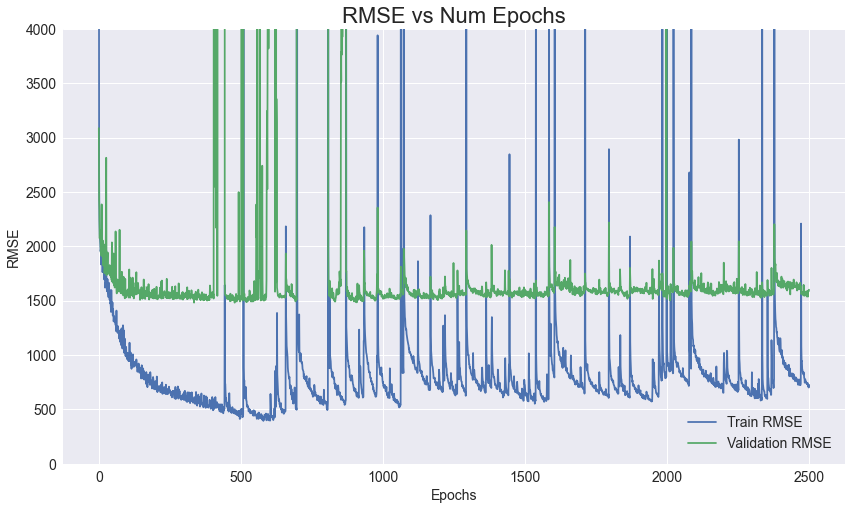

In [ ]:
# View the RMSE per epoch for the training and valiation data
plt.plot(range(len(history.history['root_mean_squared_error'])),
         history.history['root_mean_squared_error'])
plt.plot(range(len(history.history['val_root_mean_squared_error'])),
         history.history['val_root_mean_squared_error'])

plt.title('RMSE vs Num Epochs')
# plt.ylim(0, 4000)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['Train RMSE', 'Validation RMSE'])
plt.show()

In [ ]:
1666.3 RMSE

## Monte Carlo Dropout
Dropout layers are inactive during inference. But if we activate them during prediction, they introduce some variance to the prediction. Similar to ensembling weak learners like random forests, we can average over multiple predictions with dropout to give a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout turned off.<br>
<br>
https://arxiv.org/abs/1506.02142

In [ ]:
# This layer is actually redundanct if you call training=True during inference
# However, it is good practice to specify how the MCDropout layer works during inference
# so that other layers that act differently during training and inference,
# such as batch normalisation
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
%%time

# Exact same as last model but with Dropout() replace with MCDropout()
make_dim = 3
model_dim = 4

input_make = tf.keras.layers.Input(shape=(1,), name='input_make')
input_model = tf.keras.layers.Input(shape=(1,), name='input_model')
input_rest = tf.keras.layers.Input(shape=(1,35), name='input_rest')

embedding_make = Embedding(input_dim=num_make+1, output_dim=make_dim,
                           embeddings_regularizer=tf.keras.regularizers.L2(),
                           name='embedding_make')(input_make)

embedding_model = Embedding(input_dim=num_model+1, output_dim=model_dim,
                            embeddings_regularizer=tf.keras.regularizers.L2(),
                            name='embedding_model')(input_model)

concat_1 = tf.keras.layers.Concatenate()([embedding_make, embedding_model, input_rest])
x = tf.keras.layers.Dense(1024, activation='elu',
                          kernel_initializer='he_normal',
                          kernel_regularizer='l2')(concat_1)
x = ResidualBlock(2, 1024)(x)
x = MCDropout(0.5)(x)
x = ResidualBlock(2, 1024)(x)
x = MCDropout(0.5)(x)
x = ResidualBlock(2, 1024)(x)
x = MCDropout(0.5)(x)
x = ResidualBlock(2, 1024)(x)
concat_2 = tf.keras.layers.Concatenate()([x, input_rest])
output = tf.keras.layers.Dense(1)(concat_2)

dnn_model = tf.keras.Model(inputs=[input_make, input_model, input_rest],
                           outputs=output)

dnn_model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(lr=3e-4),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = dnn_model.fit((make_train_labels, model_train_labels, X_train_dnn),
                        y_train_array,
                        validation_data=((make_test_labels, model_test_labels,
                                          X_test_dnn), y_test_array),
                        epochs=3000, verbose=2)

Epoch 1/3000


C:\Users\Justin\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


110/110 - 2s - loss: 46256708.0000 - root_mean_squared_error: 6801.2144 - val_loss: 13447356.0000 - val_root_mean_squared_error: 3667.0383
Epoch 2/3000
110/110 - 1s - loss: 9409316.0000 - root_mean_squared_error: 3067.4302 - val_loss: 14164184.0000 - val_root_mean_squared_error: 3763.5085
Epoch 3/3000
110/110 - 1s - loss: 7470611.5000 - root_mean_squared_error: 2733.2075 - val_loss: 9237180.0000 - val_root_mean_squared_error: 3039.2422
Epoch 4/3000
110/110 - 1s - loss: 6266473.0000 - root_mean_squared_error: 2503.2549 - val_loss: 6176714.5000 - val_root_mean_squared_error: 2485.2620
Epoch 5/3000
110/110 - 1s - loss: 6608193.0000 - root_mean_squared_error: 2570.6040 - val_loss: 8033827.5000 - val_root_mean_squared_error: 2834.3677
Epoch 6/3000
110/110 - 1s - loss: 6189546.5000 - root_mean_squared_error: 2487.8418 - val_loss: 5768650.5000 - val_root_mean_squared_error: 2401.7622
Epoch 7/3000
110/110 - 1s - loss: 5044207.5000 - root_mean_squared_error: 2245.8894 - val_loss: 5875317.0000 -

Epoch 56/3000
110/110 - 1s - loss: 2576615.2500 - root_mean_squared_error: 1605.1161 - val_loss: 4272788.5000 - val_root_mean_squared_error: 2067.0195
Epoch 57/3000
110/110 - 1s - loss: 2657650.5000 - root_mean_squared_error: 1630.1627 - val_loss: 4182231.0000 - val_root_mean_squared_error: 2044.9965
Epoch 58/3000
110/110 - 1s - loss: 2766971.2500 - root_mean_squared_error: 1663.3552 - val_loss: 3847315.0000 - val_root_mean_squared_error: 1961.4010
Epoch 59/3000
110/110 - 1s - loss: 2913180.0000 - root_mean_squared_error: 1706.7390 - val_loss: 4391710.5000 - val_root_mean_squared_error: 2095.5881
Epoch 60/3000
110/110 - 1s - loss: 2639136.5000 - root_mean_squared_error: 1624.4735 - val_loss: 4014636.5000 - val_root_mean_squared_error: 2003.6002
Epoch 61/3000
110/110 - 1s - loss: 2795136.5000 - root_mean_squared_error: 1671.7992 - val_loss: 5096836.0000 - val_root_mean_squared_error: 2257.5679
Epoch 62/3000
110/110 - 1s - loss: 2759666.7500 - root_mean_squared_error: 1661.1569 - val_los

Epoch 111/3000
110/110 - 1s - loss: 1798950.5000 - root_mean_squared_error: 1341.1505 - val_loss: 3204440.0000 - val_root_mean_squared_error: 1790.0204
Epoch 112/3000
110/110 - 1s - loss: 1902631.1250 - root_mean_squared_error: 1379.2620 - val_loss: 3264494.5000 - val_root_mean_squared_error: 1806.7172
Epoch 113/3000
110/110 - 1s - loss: 1739413.6250 - root_mean_squared_error: 1318.7666 - val_loss: 3113260.5000 - val_root_mean_squared_error: 1764.3673
Epoch 114/3000
110/110 - 1s - loss: 1814932.6250 - root_mean_squared_error: 1347.0946 - val_loss: 3276148.0000 - val_root_mean_squared_error: 1809.9391
Epoch 115/3000
110/110 - 1s - loss: 1848373.7500 - root_mean_squared_error: 1359.4497 - val_loss: 2847412.0000 - val_root_mean_squared_error: 1687.3475
Epoch 116/3000
110/110 - 1s - loss: 1633755.7500 - root_mean_squared_error: 1278.0787 - val_loss: 3024601.7500 - val_root_mean_squared_error: 1739.0604
Epoch 117/3000
110/110 - 1s - loss: 1660120.1250 - root_mean_squared_error: 1288.3512 - 

Epoch 165/3000
110/110 - 1s - loss: 1391859.5000 - root_mean_squared_error: 1179.6350 - val_loss: 3193410.7500 - val_root_mean_squared_error: 1786.9219
Epoch 166/3000
110/110 - 1s - loss: 1288721.5000 - root_mean_squared_error: 1135.0770 - val_loss: 3399974.0000 - val_root_mean_squared_error: 1843.8142
Epoch 167/3000
110/110 - 1s - loss: 1582648.0000 - root_mean_squared_error: 1257.9049 - val_loss: 3324524.5000 - val_root_mean_squared_error: 1823.2389
Epoch 168/3000
110/110 - 1s - loss: 2037574.2500 - root_mean_squared_error: 1427.3223 - val_loss: 3090778.0000 - val_root_mean_squared_error: 1757.9683
Epoch 169/3000
110/110 - 1s - loss: 1665281.8750 - root_mean_squared_error: 1290.3315 - val_loss: 3203183.7500 - val_root_mean_squared_error: 1789.6526
Epoch 170/3000
110/110 - 1s - loss: 1477142.5000 - root_mean_squared_error: 1215.2426 - val_loss: 3376075.0000 - val_root_mean_squared_error: 1837.3204
Epoch 171/3000
110/110 - 1s - loss: 1452909.1250 - root_mean_squared_error: 1205.2305 - 

Epoch 219/3000
110/110 - 1s - loss: 1249752.2500 - root_mean_squared_error: 1117.7454 - val_loss: 2950405.2500 - val_root_mean_squared_error: 1717.5585
Epoch 220/3000
110/110 - 1s - loss: 1248102.7500 - root_mean_squared_error: 1117.0067 - val_loss: 2955219.5000 - val_root_mean_squared_error: 1718.9587
Epoch 221/3000
110/110 - 1s - loss: 1117279.7500 - root_mean_squared_error: 1056.8250 - val_loss: 3355376.7500 - val_root_mean_squared_error: 1831.6591
Epoch 222/3000
110/110 - 1s - loss: 1258364.0000 - root_mean_squared_error: 1121.5887 - val_loss: 3014792.7500 - val_root_mean_squared_error: 1736.1995
Epoch 223/3000
110/110 - 1s - loss: 1153510.5000 - root_mean_squared_error: 1073.8275 - val_loss: 3306900.0000 - val_root_mean_squared_error: 1818.3770
Epoch 224/3000
110/110 - 1s - loss: 1198461.5000 - root_mean_squared_error: 1094.5568 - val_loss: 3157753.0000 - val_root_mean_squared_error: 1776.8918
Epoch 225/3000
110/110 - 1s - loss: 1348323.1250 - root_mean_squared_error: 1160.9973 - 

Epoch 273/3000
110/110 - 1s - loss: 1298940.7500 - root_mean_squared_error: 1139.4800 - val_loss: 3351963.0000 - val_root_mean_squared_error: 1830.6924
Epoch 274/3000
110/110 - 1s - loss: 1059225.5000 - root_mean_squared_error: 1028.9298 - val_loss: 2896301.7500 - val_root_mean_squared_error: 1701.6963
Epoch 275/3000
110/110 - 1s - loss: 1066350.0000 - root_mean_squared_error: 1032.3848 - val_loss: 2690485.0000 - val_root_mean_squared_error: 1640.1072
Epoch 276/3000
110/110 - 1s - loss: 969234.2500 - root_mean_squared_error: 984.2255 - val_loss: 2741533.7500 - val_root_mean_squared_error: 1655.5958
Epoch 277/3000
110/110 - 1s - loss: 942314.7500 - root_mean_squared_error: 970.4521 - val_loss: 2885177.7500 - val_root_mean_squared_error: 1698.4224
Epoch 278/3000
110/110 - 1s - loss: 1017010.1875 - root_mean_squared_error: 1008.2018 - val_loss: 2911173.7500 - val_root_mean_squared_error: 1706.0577
Epoch 279/3000
110/110 - 1s - loss: 1027642.7500 - root_mean_squared_error: 1013.4595 - val_

Epoch 328/3000
110/110 - 1s - loss: 836592.0000 - root_mean_squared_error: 914.2769 - val_loss: 2820827.7500 - val_root_mean_squared_error: 1679.3263
Epoch 329/3000
110/110 - 1s - loss: 797866.3750 - root_mean_squared_error: 892.8457 - val_loss: 2719702.2500 - val_root_mean_squared_error: 1648.9414
Epoch 330/3000
110/110 - 1s - loss: 789222.1875 - root_mean_squared_error: 887.9899 - val_loss: 2580965.7500 - val_root_mean_squared_error: 1606.3213
Epoch 331/3000
110/110 - 1s - loss: 861348.6250 - root_mean_squared_error: 927.7119 - val_loss: 2493768.2500 - val_root_mean_squared_error: 1578.9449
Epoch 332/3000
110/110 - 1s - loss: 820463.7500 - root_mean_squared_error: 905.4066 - val_loss: 2784097.5000 - val_root_mean_squared_error: 1668.3505
Epoch 333/3000
110/110 - 1s - loss: 1081844.7500 - root_mean_squared_error: 1039.7784 - val_loss: 3302508.0000 - val_root_mean_squared_error: 1817.0853
Epoch 334/3000
110/110 - 1s - loss: 1005836.6250 - root_mean_squared_error: 1002.5601 - val_loss: 

Epoch 383/3000
110/110 - 1s - loss: 762906.8125 - root_mean_squared_error: 872.9490 - val_loss: 2822456.2500 - val_root_mean_squared_error: 1679.7578
Epoch 384/3000
110/110 - 1s - loss: 653277.6250 - root_mean_squared_error: 807.7180 - val_loss: 2681197.2500 - val_root_mean_squared_error: 1637.1699
Epoch 385/3000
110/110 - 1s - loss: 634349.1875 - root_mean_squared_error: 795.9119 - val_loss: 2651935.7500 - val_root_mean_squared_error: 1628.2076
Epoch 386/3000
110/110 - 1s - loss: 699696.4375 - root_mean_squared_error: 835.9545 - val_loss: 2481816.2500 - val_root_mean_squared_error: 1575.0995
Epoch 387/3000
110/110 - 1s - loss: 619661.9375 - root_mean_squared_error: 786.6273 - val_loss: 2425041.2500 - val_root_mean_squared_error: 1556.9717
Epoch 388/3000
110/110 - 1s - loss: 646701.4375 - root_mean_squared_error: 803.6287 - val_loss: 2640360.5000 - val_root_mean_squared_error: 1624.6466
Epoch 389/3000
110/110 - 1s - loss: 643319.8750 - root_mean_squared_error: 801.5203 - val_loss: 2575

Epoch 438/3000
110/110 - 1s - loss: 780544.0625 - root_mean_squared_error: 882.9198 - val_loss: 2587788.2500 - val_root_mean_squared_error: 1608.3508
Epoch 439/3000
110/110 - 1s - loss: 620228.7500 - root_mean_squared_error: 786.9122 - val_loss: 2681322.7500 - val_root_mean_squared_error: 1637.1697
Epoch 440/3000
110/110 - 1s - loss: 578772.2500 - root_mean_squared_error: 760.1140 - val_loss: 2905035.0000 - val_root_mean_squared_error: 1704.1233
Epoch 441/3000
110/110 - 1s - loss: 576798.5625 - root_mean_squared_error: 758.8134 - val_loss: 2553407.5000 - val_root_mean_squared_error: 1597.6255
Epoch 442/3000
110/110 - 1s - loss: 2171358.2500 - root_mean_squared_error: 1473.2134 - val_loss: 3090056.2500 - val_root_mean_squared_error: 1757.5701
Epoch 443/3000
110/110 - 1s - loss: 927606.7500 - root_mean_squared_error: 962.6025 - val_loss: 2734771.5000 - val_root_mean_squared_error: 1653.4109
Epoch 444/3000
110/110 - 1s - loss: 765351.2500 - root_mean_squared_error: 874.2689 - val_loss: 26

Epoch 493/3000
110/110 - 1s - loss: 596087.9375 - root_mean_squared_error: 771.3701 - val_loss: 2963883.5000 - val_root_mean_squared_error: 1721.2805
Epoch 494/3000
110/110 - 1s - loss: 595290.3750 - root_mean_squared_error: 770.8524 - val_loss: 2766346.2500 - val_root_mean_squared_error: 1662.9095
Epoch 495/3000
110/110 - 1s - loss: 528001.1250 - root_mean_squared_error: 725.8946 - val_loss: 2747413.0000 - val_root_mean_squared_error: 1657.2075
Epoch 496/3000
110/110 - 1s - loss: 574477.5625 - root_mean_squared_error: 757.2308 - val_loss: 2520774.5000 - val_root_mean_squared_error: 1587.3540
Epoch 497/3000
110/110 - 1s - loss: 573291.6875 - root_mean_squared_error: 756.4464 - val_loss: 2318366.5000 - val_root_mean_squared_error: 1522.2634
Epoch 498/3000
110/110 - 1s - loss: 578124.6250 - root_mean_squared_error: 759.6338 - val_loss: 2557880.5000 - val_root_mean_squared_error: 1598.9996
Epoch 499/3000
110/110 - 1s - loss: 514701.2500 - root_mean_squared_error: 716.6721 - val_loss: 2492

Epoch 548/3000
110/110 - 1s - loss: 497460.0000 - root_mean_squared_error: 704.5051 - val_loss: 2419166.0000 - val_root_mean_squared_error: 1555.0024
Epoch 549/3000
110/110 - 1s - loss: 531772.6875 - root_mean_squared_error: 728.4495 - val_loss: 2443640.5000 - val_root_mean_squared_error: 1562.8517
Epoch 550/3000
110/110 - 1s - loss: 492287.8438 - root_mean_squared_error: 700.8227 - val_loss: 2385439.7500 - val_root_mean_squared_error: 1544.1194
Epoch 551/3000
110/110 - 1s - loss: 566989.8125 - root_mean_squared_error: 752.2324 - val_loss: 41500268.0000 - val_root_mean_squared_error: 6441.9819
Epoch 552/3000
110/110 - 1s - loss: 974461.8125 - root_mean_squared_error: 986.5710 - val_loss: 3111826.0000 - val_root_mean_squared_error: 1763.7136
Epoch 553/3000
110/110 - 1s - loss: 724377.6250 - root_mean_squared_error: 850.4340 - val_loss: 2455713.0000 - val_root_mean_squared_error: 1566.7075
Epoch 554/3000
110/110 - 1s - loss: 744848.0625 - root_mean_squared_error: 862.3844 - val_loss: 255

Epoch 603/3000
110/110 - 1s - loss: 596268.8750 - root_mean_squared_error: 771.4213 - val_loss: 2589636.5000 - val_root_mean_squared_error: 1608.8691
Epoch 604/3000
110/110 - 1s - loss: 622161.9375 - root_mean_squared_error: 788.0253 - val_loss: 2461403.7500 - val_root_mean_squared_error: 1568.5100
Epoch 605/3000
110/110 - 1s - loss: 572570.6250 - root_mean_squared_error: 755.9041 - val_loss: 2447979.2500 - val_root_mean_squared_error: 1564.2249
Epoch 606/3000
110/110 - 1s - loss: 599223.6250 - root_mean_squared_error: 773.3331 - val_loss: 2419589.0000 - val_root_mean_squared_error: 1555.1237
Epoch 607/3000
110/110 - 1s - loss: 534628.5000 - root_mean_squared_error: 730.3755 - val_loss: 2394290.2500 - val_root_mean_squared_error: 1546.9677
Epoch 608/3000
110/110 - 1s - loss: 605476.5000 - root_mean_squared_error: 777.3640 - val_loss: 2482167.0000 - val_root_mean_squared_error: 1575.1140
Epoch 609/3000
110/110 - 1s - loss: 530097.2500 - root_mean_squared_error: 727.2650 - val_loss: 2420

Epoch 658/3000
110/110 - 1s - loss: 609683.5000 - root_mean_squared_error: 780.0396 - val_loss: 2317389.5000 - val_root_mean_squared_error: 1521.8961
Epoch 659/3000
110/110 - 1s - loss: 563517.7500 - root_mean_squared_error: 749.8637 - val_loss: 2542852.2500 - val_root_mean_squared_error: 1594.2488
Epoch 660/3000
110/110 - 1s - loss: 555130.0000 - root_mean_squared_error: 744.2495 - val_loss: 2666776.2500 - val_root_mean_squared_error: 1632.6511
Epoch 661/3000
110/110 - 1s - loss: 595223.9375 - root_mean_squared_error: 770.7132 - val_loss: 2414617.0000 - val_root_mean_squared_error: 1553.5095
Epoch 662/3000
110/110 - 1s - loss: 603044.1250 - root_mean_squared_error: 775.7700 - val_loss: 2453650.7500 - val_root_mean_squared_error: 1566.0223
Epoch 663/3000
110/110 - 1s - loss: 570467.8125 - root_mean_squared_error: 754.4816 - val_loss: 2370285.2500 - val_root_mean_squared_error: 1539.1749
Epoch 664/3000
110/110 - 1s - loss: 534734.8750 - root_mean_squared_error: 730.4166 - val_loss: 2487

Epoch 713/3000
110/110 - 1s - loss: 20583792.0000 - root_mean_squared_error: 4536.7969 - val_loss: 3278658.7500 - val_root_mean_squared_error: 1810.3557
Epoch 714/3000
110/110 - 1s - loss: 1000357.8125 - root_mean_squared_error: 999.5448 - val_loss: 2549181.5000 - val_root_mean_squared_error: 1596.2192
Epoch 715/3000
110/110 - 1s - loss: 827486.0625 - root_mean_squared_error: 908.9660 - val_loss: 2283226.0000 - val_root_mean_squared_error: 1510.6150
Epoch 716/3000
110/110 - 1s - loss: 682482.1875 - root_mean_squared_error: 825.3572 - val_loss: 2593414.5000 - val_root_mean_squared_error: 1610.0142
Epoch 717/3000
110/110 - 1s - loss: 678347.3125 - root_mean_squared_error: 822.8477 - val_loss: 2800921.2500 - val_root_mean_squared_error: 1673.2162
Epoch 718/3000
110/110 - 1s - loss: 619841.4375 - root_mean_squared_error: 786.4936 - val_loss: 2479840.0000 - val_root_mean_squared_error: 1574.3472
Epoch 719/3000
110/110 - 1s - loss: 550543.3125 - root_mean_squared_error: 741.1301 - val_loss: 

Epoch 768/3000
110/110 - 1s - loss: 1001545.0000 - root_mean_squared_error: 1000.1273 - val_loss: 3222646.0000 - val_root_mean_squared_error: 1794.8130
Epoch 769/3000
110/110 - 1s - loss: 914151.7500 - root_mean_squared_error: 955.4357 - val_loss: 3406533.7500 - val_root_mean_squared_error: 1845.3290
Epoch 770/3000
110/110 - 1s - loss: 846459.5625 - root_mean_squared_error: 919.3289 - val_loss: 2872093.7500 - val_root_mean_squared_error: 1694.3436
Epoch 771/3000
110/110 - 1s - loss: 808065.2500 - root_mean_squared_error: 898.2039 - val_loss: 3624493.0000 - val_root_mean_squared_error: 1903.4700
Epoch 772/3000
110/110 - 1s - loss: 818043.0625 - root_mean_squared_error: 903.7403 - val_loss: 2651358.7500 - val_root_mean_squared_error: 1627.9010
Epoch 773/3000
110/110 - 1s - loss: 851107.3750 - root_mean_squared_error: 921.8511 - val_loss: 2696950.5000 - val_root_mean_squared_error: 1641.8446
Epoch 774/3000
110/110 - 1s - loss: 839358.7500 - root_mean_squared_error: 915.4571 - val_loss: 28

Epoch 823/3000
110/110 - 1s - loss: 1106125.2500 - root_mean_squared_error: 1051.0901 - val_loss: 2874595.2500 - val_root_mean_squared_error: 1695.0699
Epoch 824/3000
110/110 - 1s - loss: 1055141.1250 - root_mean_squared_error: 1026.5510 - val_loss: 2953612.7500 - val_root_mean_squared_error: 1718.2196
Epoch 825/3000
110/110 - 1s - loss: 1125528.7500 - root_mean_squared_error: 1060.2812 - val_loss: 2690116.2500 - val_root_mean_squared_error: 1639.7512
Epoch 826/3000
110/110 - 1s - loss: 1040717.7500 - root_mean_squared_error: 1019.5011 - val_loss: 3185641.0000 - val_root_mean_squared_error: 1784.4623
Epoch 827/3000
110/110 - 1s - loss: 1018353.5000 - root_mean_squared_error: 1008.4724 - val_loss: 2784955.0000 - val_root_mean_squared_error: 1668.4175
Epoch 828/3000
110/110 - 1s - loss: 1018760.0000 - root_mean_squared_error: 1008.6734 - val_loss: 3116551.7500 - val_root_mean_squared_error: 1764.9967
Epoch 829/3000
110/110 - 1s - loss: 931731.5000 - root_mean_squared_error: 964.5693 - va

Epoch 878/3000
110/110 - 1s - loss: 3588733.7500 - root_mean_squared_error: 1894.0343 - val_loss: 5185964.5000 - val_root_mean_squared_error: 2276.9717
Epoch 879/3000
110/110 - 1s - loss: 3364527.5000 - root_mean_squared_error: 1833.8916 - val_loss: 5164565.5000 - val_root_mean_squared_error: 2272.2668
Epoch 880/3000
110/110 - 1s - loss: 3059486.7500 - root_mean_squared_error: 1748.7473 - val_loss: 4452693.0000 - val_root_mean_squared_error: 2109.8157
Epoch 881/3000
110/110 - 1s - loss: 2942969.2500 - root_mean_squared_error: 1715.1095 - val_loss: 4113394.0000 - val_root_mean_squared_error: 2027.8124
Epoch 882/3000
110/110 - 1s - loss: 2725138.5000 - root_mean_squared_error: 1650.3842 - val_loss: 4314835.0000 - val_root_mean_squared_error: 2076.8879
Epoch 883/3000
110/110 - 1s - loss: 2673253.5000 - root_mean_squared_error: 1634.5894 - val_loss: 4576146.0000 - val_root_mean_squared_error: 2138.8718
Epoch 884/3000
110/110 - 1s - loss: 2583345.5000 - root_mean_squared_error: 1606.8519 - 

Epoch 932/3000
110/110 - 1s - loss: 1169251.8750 - root_mean_squared_error: 1080.6699 - val_loss: 2800061.2500 - val_root_mean_squared_error: 1672.9186
Epoch 933/3000
110/110 - 1s - loss: 1278305.2500 - root_mean_squared_error: 1130.0000 - val_loss: 3070402.7500 - val_root_mean_squared_error: 1751.8553
Epoch 934/3000
110/110 - 1s - loss: 1307076.7500 - root_mean_squared_error: 1142.6592 - val_loss: 3025399.7500 - val_root_mean_squared_error: 1738.9623
Epoch 935/3000
110/110 - 1s - loss: 1179985.1250 - root_mean_squared_error: 1085.6226 - val_loss: 2756088.7500 - val_root_mean_squared_error: 1659.7231
Epoch 936/3000
110/110 - 1s - loss: 1131426.5000 - root_mean_squared_error: 1063.0231 - val_loss: 2755291.2500 - val_root_mean_squared_error: 1659.4824
Epoch 937/3000
110/110 - 1s - loss: 1121016.0000 - root_mean_squared_error: 1058.1151 - val_loss: 2933016.2500 - val_root_mean_squared_error: 1712.1941
Epoch 938/3000
110/110 - 1s - loss: 1126091.7500 - root_mean_squared_error: 1060.5107 - 

110/110 - 1s - loss: 958684.6875 - root_mean_squared_error: 978.3845 - val_loss: 2716046.2500 - val_root_mean_squared_error: 1647.6031
Epoch 987/3000
110/110 - 1s - loss: 910169.4375 - root_mean_squared_error: 953.2684 - val_loss: 2674659.7500 - val_root_mean_squared_error: 1634.9958
Epoch 988/3000
110/110 - 1s - loss: 977688.2500 - root_mean_squared_error: 988.0479 - val_loss: 2711238.2500 - val_root_mean_squared_error: 1646.1428
Epoch 989/3000
110/110 - 1s - loss: 930818.0000 - root_mean_squared_error: 964.0366 - val_loss: 2424419.5000 - val_root_mean_squared_error: 1556.5883
Epoch 990/3000
110/110 - 1s - loss: 880484.4375 - root_mean_squared_error: 937.5667 - val_loss: 3649145.2500 - val_root_mean_squared_error: 1909.8933
Epoch 991/3000
110/110 - 1s - loss: 878385.8125 - root_mean_squared_error: 936.4476 - val_loss: 2628121.0000 - val_root_mean_squared_error: 1620.7002
Epoch 992/3000
110/110 - 1s - loss: 884396.3125 - root_mean_squared_error: 939.6504 - val_loss: 2572184.2500 - val_

Epoch 1040/3000
110/110 - 1s - loss: 947291.6875 - root_mean_squared_error: 972.5268 - val_loss: 3364499.2500 - val_root_mean_squared_error: 1833.8524
Epoch 1041/3000
110/110 - 1s - loss: 954207.2500 - root_mean_squared_error: 976.0756 - val_loss: 2949698.2500 - val_root_mean_squared_error: 1717.0371
Epoch 1042/3000
110/110 - 1s - loss: 911222.7500 - root_mean_squared_error: 953.8038 - val_loss: 3035914.2500 - val_root_mean_squared_error: 1741.9625
Epoch 1043/3000
110/110 - 1s - loss: 954501.0625 - root_mean_squared_error: 976.2270 - val_loss: 2877698.2500 - val_root_mean_squared_error: 1695.9409
Epoch 1044/3000
110/110 - 1s - loss: 940168.4375 - root_mean_squared_error: 968.8578 - val_loss: 2999138.5000 - val_root_mean_squared_error: 1731.3735
Epoch 1045/3000
110/110 - 1s - loss: 1406885.1250 - root_mean_squared_error: 1185.4963 - val_loss: 3534928.5000 - val_root_mean_squared_error: 1879.7462
Epoch 1046/3000
110/110 - 1s - loss: 1082148.3750 - root_mean_squared_error: 1039.5508 - val

110/110 - 1s - loss: 735774.3125 - root_mean_squared_error: 856.8882 - val_loss: 2947049.5000 - val_root_mean_squared_error: 1716.2556
Epoch 1095/3000
110/110 - 1s - loss: 968921.2500 - root_mean_squared_error: 983.5654 - val_loss: 2828226.5000 - val_root_mean_squared_error: 1681.2805
Epoch 1096/3000
110/110 - 1s - loss: 996091.3750 - root_mean_squared_error: 997.2818 - val_loss: 3034768.5000 - val_root_mean_squared_error: 1741.6224
Epoch 1097/3000
110/110 - 1s - loss: 840221.3125 - root_mean_squared_error: 915.8068 - val_loss: 2845048.2500 - val_root_mean_squared_error: 1686.2766
Epoch 1098/3000
110/110 - 1s - loss: 827067.9375 - root_mean_squared_error: 908.5956 - val_loss: 2803864.0000 - val_root_mean_squared_error: 1674.0198
Epoch 1099/3000
110/110 - 1s - loss: 867039.7500 - root_mean_squared_error: 930.3317 - val_loss: 2636441.2500 - val_root_mean_squared_error: 1623.2428
Epoch 1100/3000
110/110 - 1s - loss: 854511.8125 - root_mean_squared_error: 923.5748 - val_loss: 2814163.0000 

Epoch 1148/3000
110/110 - 1s - loss: 1231980.8750 - root_mean_squared_error: 1109.2458 - val_loss: 3056005.0000 - val_root_mean_squared_error: 1747.6995
Epoch 1149/3000
110/110 - 1s - loss: 1161074.6250 - root_mean_squared_error: 1076.8112 - val_loss: 3154717.7500 - val_root_mean_squared_error: 1775.7151
Epoch 1150/3000
110/110 - 1s - loss: 1136200.7500 - root_mean_squared_error: 1065.1982 - val_loss: 3032166.0000 - val_root_mean_squared_error: 1740.8654
Epoch 1151/3000
110/110 - 1s - loss: 1165564.6250 - root_mean_squared_error: 1078.8931 - val_loss: 3064854.7500 - val_root_mean_squared_error: 1750.2285
Epoch 1152/3000
110/110 - 1s - loss: 1128857.8750 - root_mean_squared_error: 1061.7467 - val_loss: 2739175.2500 - val_root_mean_squared_error: 1654.5768
Epoch 1153/3000
110/110 - 1s - loss: 1134079.1250 - root_mean_squared_error: 1064.2019 - val_loss: 3025341.5000 - val_root_mean_squared_error: 1738.9041
Epoch 1154/3000
110/110 - 1s - loss: 1121273.6250 - root_mean_squared_error: 1058.

Epoch 1202/3000
110/110 - 1s - loss: 2181649.7500 - root_mean_squared_error: 1476.4622 - val_loss: 3906301.5000 - val_root_mean_squared_error: 1976.0038
Epoch 1203/3000
110/110 - 1s - loss: 2052400.1250 - root_mean_squared_error: 1432.0229 - val_loss: 3669318.7500 - val_root_mean_squared_error: 1915.1007
Epoch 1204/3000
110/110 - 1s - loss: 1954833.5000 - root_mean_squared_error: 1397.5430 - val_loss: 4002022.7500 - val_root_mean_squared_error: 2000.0789
Epoch 1205/3000
110/110 - 1s - loss: 2000545.1250 - root_mean_squared_error: 1413.8032 - val_loss: 3764755.0000 - val_root_mean_squared_error: 1939.8584
Epoch 1206/3000
110/110 - 1s - loss: 1907265.8750 - root_mean_squared_error: 1380.4200 - val_loss: 3696172.2500 - val_root_mean_squared_error: 1922.0990
Epoch 1207/3000
110/110 - 1s - loss: 5531661.0000 - root_mean_squared_error: 2351.5872 - val_loss: 4139300.2500 - val_root_mean_squared_error: 2034.1105
Epoch 1208/3000
110/110 - 1s - loss: 2485365.0000 - root_mean_squared_error: 1575.

Epoch 1256/3000
110/110 - 1s - loss: 2225625.2500 - root_mean_squared_error: 1491.2791 - val_loss: 3785156.7500 - val_root_mean_squared_error: 1945.1074
Epoch 1257/3000
110/110 - 1s - loss: 2562865.0000 - root_mean_squared_error: 1600.3604 - val_loss: 5571352.0000 - val_root_mean_squared_error: 2360.0117
Epoch 1258/3000
110/110 - 1s - loss: 2573621.7500 - root_mean_squared_error: 1603.7216 - val_loss: 4004116.0000 - val_root_mean_squared_error: 2000.6040
Epoch 1259/3000
110/110 - 1s - loss: 2330777.7500 - root_mean_squared_error: 1526.1318 - val_loss: 3991573.0000 - val_root_mean_squared_error: 1997.4668
Epoch 1260/3000
110/110 - 1s - loss: 2148655.5000 - root_mean_squared_error: 1465.2484 - val_loss: 3797083.0000 - val_root_mean_squared_error: 1948.1729
Epoch 1261/3000
110/110 - 1s - loss: 1996204.3750 - root_mean_squared_error: 1412.2678 - val_loss: 4009966.2500 - val_root_mean_squared_error: 2002.0649
Epoch 1262/3000
110/110 - 1s - loss: 1980610.5000 - root_mean_squared_error: 1406.

Epoch 1310/3000
110/110 - 1s - loss: 1813153.3750 - root_mean_squared_error: 1345.8685 - val_loss: 3469924.0000 - val_root_mean_squared_error: 1862.2928
Epoch 1311/3000
110/110 - 1s - loss: 1776268.8750 - root_mean_squared_error: 1332.0959 - val_loss: 3464086.2500 - val_root_mean_squared_error: 1860.7246
Epoch 1312/3000
110/110 - 1s - loss: 1759157.0000 - root_mean_squared_error: 1325.6580 - val_loss: 3638960.5000 - val_root_mean_squared_error: 1907.1375
Epoch 1313/3000
110/110 - 1s - loss: 1839835.7500 - root_mean_squared_error: 1355.7467 - val_loss: 3672394.0000 - val_root_mean_squared_error: 1915.8828
Epoch 1314/3000
110/110 - 1s - loss: 1673735.1250 - root_mean_squared_error: 1293.0381 - val_loss: 3763935.7500 - val_root_mean_squared_error: 1939.6252
Epoch 1315/3000
110/110 - 1s - loss: 1618146.3750 - root_mean_squared_error: 1271.3606 - val_loss: 3523645.2500 - val_root_mean_squared_error: 1876.6615
Epoch 1316/3000
110/110 - 1s - loss: 1667018.0000 - root_mean_squared_error: 1290.

Epoch 1364/3000
110/110 - 1s - loss: 1109388.8750 - root_mean_squared_error: 1052.4242 - val_loss: 2827185.7500 - val_root_mean_squared_error: 1680.8907
Epoch 1365/3000
110/110 - 1s - loss: 1083704.7500 - root_mean_squared_error: 1040.1497 - val_loss: 3161825.7500 - val_root_mean_squared_error: 1777.6477
Epoch 1366/3000
110/110 - 1s - loss: 1065148.0000 - root_mean_squared_error: 1031.1901 - val_loss: 2930258.0000 - val_root_mean_squared_error: 1711.2755
Epoch 1367/3000
110/110 - 1s - loss: 1005178.0000 - root_mean_squared_error: 1001.6902 - val_loss: 2976456.0000 - val_root_mean_squared_error: 1724.7202
Epoch 1368/3000
110/110 - 1s - loss: 1068631.7500 - root_mean_squared_error: 1032.8783 - val_loss: 3137299.2500 - val_root_mean_squared_error: 1770.7363
Epoch 1369/3000
110/110 - 1s - loss: 1059580.6250 - root_mean_squared_error: 1028.4886 - val_loss: 2970586.0000 - val_root_mean_squared_error: 1723.0182
Epoch 1370/3000
110/110 - 1s - loss: 1084799.5000 - root_mean_squared_error: 1040.

Epoch 1418/3000
110/110 - 1s - loss: 894750.8750 - root_mean_squared_error: 944.9588 - val_loss: 2730246.0000 - val_root_mean_squared_error: 1651.7997
Epoch 1419/3000
110/110 - 1s - loss: 795252.3125 - root_mean_squared_error: 890.7563 - val_loss: 2820996.0000 - val_root_mean_squared_error: 1679.0447
Epoch 1420/3000
110/110 - 1s - loss: 1519226.5000 - root_mean_squared_error: 1231.8306 - val_loss: 3112992.0000 - val_root_mean_squared_error: 1763.8494
Epoch 1421/3000
110/110 - 1s - loss: 1107882.1250 - root_mean_squared_error: 1051.6932 - val_loss: 2968008.2500 - val_root_mean_squared_error: 1722.2631
Epoch 1422/3000
110/110 - 1s - loss: 1045721.6250 - root_mean_squared_error: 1021.7142 - val_loss: 3110055.7500 - val_root_mean_squared_error: 1763.0183
Epoch 1423/3000
110/110 - 1s - loss: 958448.3125 - root_mean_squared_error: 978.0730 - val_loss: 2890524.5000 - val_root_mean_squared_error: 1699.6195
Epoch 1424/3000
110/110 - 1s - loss: 892329.1875 - root_mean_squared_error: 943.6688 - v

Epoch 1473/3000
110/110 - 1s - loss: 678915.8125 - root_mean_squared_error: 822.8546 - val_loss: 3168455.2500 - val_root_mean_squared_error: 1779.5021
Epoch 1474/3000
110/110 - 1s - loss: 690453.9375 - root_mean_squared_error: 829.8349 - val_loss: 2710778.0000 - val_root_mean_squared_error: 1645.8892
Epoch 1475/3000
110/110 - 1s - loss: 648091.9375 - root_mean_squared_error: 803.9062 - val_loss: 2704733.2500 - val_root_mean_squared_error: 1644.0522
Epoch 1476/3000
110/110 - 1s - loss: 726675.5000 - root_mean_squared_error: 851.3800 - val_loss: 2831938.5000 - val_root_mean_squared_error: 1682.2924
Epoch 1477/3000
110/110 - 1s - loss: 631619.4375 - root_mean_squared_error: 793.5939 - val_loss: 2903050.0000 - val_root_mean_squared_error: 1703.2977
Epoch 1478/3000
110/110 - 1s - loss: 651341.1250 - root_mean_squared_error: 805.9238 - val_loss: 2752765.7500 - val_root_mean_squared_error: 1658.5946
Epoch 1479/3000
110/110 - 1s - loss: 678407.9375 - root_mean_squared_error: 822.5441 - val_los

Epoch 1527/3000
110/110 - 1s - loss: 1916905.2500 - root_mean_squared_error: 1383.8423 - val_loss: 69302408.0000 - val_root_mean_squared_error: 8324.6934
Epoch 1528/3000
110/110 - 1s - loss: 1867103.1250 - root_mean_squared_error: 1365.7295 - val_loss: 107749761024.0000 - val_root_mean_squared_error: 328252.5938
Epoch 1529/3000
110/110 - 1s - loss: 135948480.0000 - root_mean_squared_error: 11659.6143 - val_loss: 4235393.5000 - val_root_mean_squared_error: 2057.5454
Epoch 1530/3000
110/110 - 1s - loss: 2281245.0000 - root_mean_squared_error: 1509.7513 - val_loss: 4460734.5000 - val_root_mean_squared_error: 2111.5962
Epoch 1531/3000
110/110 - 1s - loss: 1989036.6250 - root_mean_squared_error: 1409.6594 - val_loss: 4119966.0000 - val_root_mean_squared_error: 2029.3029
Epoch 1532/3000
110/110 - 1s - loss: 1873167.1250 - root_mean_squared_error: 1367.9432 - val_loss: 3916458.0000 - val_root_mean_squared_error: 1978.5250
Epoch 1533/3000
110/110 - 1s - loss: 1709899.2500 - root_mean_squared_e

Epoch 1581/3000
110/110 - 1s - loss: 1328436.2500 - root_mean_squared_error: 1151.7374 - val_loss: 3485406.2500 - val_root_mean_squared_error: 1866.4060
Epoch 1582/3000
110/110 - 1s - loss: 1174524.6250 - root_mean_squared_error: 1082.8630 - val_loss: 3271500.5000 - val_root_mean_squared_error: 1808.1938
Epoch 1583/3000
110/110 - 1s - loss: 1167014.8750 - root_mean_squared_error: 1079.3895 - val_loss: 3377983.2500 - val_root_mean_squared_error: 1837.4036
Epoch 1584/3000
110/110 - 1s - loss: 1158469.1250 - root_mean_squared_error: 1075.4238 - val_loss: 3268925.2500 - val_root_mean_squared_error: 1807.4819
Epoch 1585/3000
110/110 - 1s - loss: 1144730.8750 - root_mean_squared_error: 1069.0160 - val_loss: 3417820.7500 - val_root_mean_squared_error: 1848.2112
Epoch 1586/3000
110/110 - 1s - loss: 1132659.0000 - root_mean_squared_error: 1063.3546 - val_loss: 3389410.2500 - val_root_mean_squared_error: 1840.5093
Epoch 1587/3000
110/110 - 1s - loss: 1062756.7500 - root_mean_squared_error: 1029.

Epoch 1635/3000
110/110 - 1s - loss: 1149706.6250 - root_mean_squared_error: 1071.3062 - val_loss: 3560341.5000 - val_root_mean_squared_error: 1886.3542
Epoch 1636/3000
110/110 - 1s - loss: 1069986.1250 - root_mean_squared_error: 1033.4307 - val_loss: 3494544.2500 - val_root_mean_squared_error: 1868.8337
Epoch 1637/3000
110/110 - 1s - loss: 1168244.8750 - root_mean_squared_error: 1079.9257 - val_loss: 3483317.0000 - val_root_mean_squared_error: 1865.8281
Epoch 1638/3000
110/110 - 1s - loss: 1124953.6250 - root_mean_squared_error: 1059.6920 - val_loss: 3434636.7500 - val_root_mean_squared_error: 1852.7358
Epoch 1639/3000
110/110 - 1s - loss: 1178636.5000 - root_mean_squared_error: 1084.7262 - val_loss: 3427106.0000 - val_root_mean_squared_error: 1850.7024
Epoch 1640/3000
110/110 - 1s - loss: 1135230.6250 - root_mean_squared_error: 1064.5309 - val_loss: 3352334.2500 - val_root_mean_squared_error: 1830.3907
Epoch 1641/3000
110/110 - 1s - loss: 1092442.0000 - root_mean_squared_error: 1044.

Epoch 1689/3000
110/110 - 1s - loss: 927903.0000 - root_mean_squared_error: 962.2168 - val_loss: 3120755.5000 - val_root_mean_squared_error: 1765.9893
Epoch 1690/3000
110/110 - 1s - loss: 834876.8750 - root_mean_squared_error: 912.5999 - val_loss: 3027308.5000 - val_root_mean_squared_error: 1739.3308
Epoch 1691/3000
110/110 - 1s - loss: 855767.1875 - root_mean_squared_error: 923.9750 - val_loss: 3130217.2500 - val_root_mean_squared_error: 1768.6665
Epoch 1692/3000
110/110 - 1s - loss: 922539.1875 - root_mean_squared_error: 959.4275 - val_loss: 2898852.7500 - val_root_mean_squared_error: 1702.0028
Epoch 1693/3000
110/110 - 1s - loss: 850610.5000 - root_mean_squared_error: 921.1804 - val_loss: 3051757.2500 - val_root_mean_squared_error: 1746.3453
Epoch 1694/3000
110/110 - 1s - loss: 838137.0625 - root_mean_squared_error: 914.3844 - val_loss: 3140062.5000 - val_root_mean_squared_error: 1771.4470
Epoch 1695/3000
110/110 - 1s - loss: 829009.0000 - root_mean_squared_error: 909.3812 - val_los

Epoch 1743/3000
110/110 - 1s - loss: 1773538.6250 - root_mean_squared_error: 1330.9174 - val_loss: 3940948.7500 - val_root_mean_squared_error: 1984.6295
Epoch 1744/3000
110/110 - 1s - loss: 1766990.5000 - root_mean_squared_error: 1328.4576 - val_loss: 4028689.2500 - val_root_mean_squared_error: 2006.6136
Epoch 1745/3000
110/110 - 1s - loss: 1720563.5000 - root_mean_squared_error: 1310.8666 - val_loss: 3709830.5000 - val_root_mean_squared_error: 1925.5236
Epoch 1746/3000
110/110 - 1s - loss: 1621500.0000 - root_mean_squared_error: 1272.5212 - val_loss: 3853005.2500 - val_root_mean_squared_error: 1962.3499
Epoch 1747/3000
110/110 - 1s - loss: 1649395.5000 - root_mean_squared_error: 1283.4348 - val_loss: 3593632.7500 - val_root_mean_squared_error: 1895.1100
Epoch 1748/3000
110/110 - 1s - loss: 1583352.0000 - root_mean_squared_error: 1257.4420 - val_loss: 3619318.7500 - val_root_mean_squared_error: 1901.8748
Epoch 1749/3000
110/110 - 1s - loss: 1469464.5000 - root_mean_squared_error: 1211.

Epoch 1797/3000
110/110 - 1s - loss: 951238.0000 - root_mean_squared_error: 974.1868 - val_loss: 3085996.0000 - val_root_mean_squared_error: 1756.0747
Epoch 1798/3000
110/110 - 1s - loss: 998230.1250 - root_mean_squared_error: 998.0145 - val_loss: 3288184.7500 - val_root_mean_squared_error: 1812.7290
Epoch 1799/3000
110/110 - 1s - loss: 908249.8125 - root_mean_squared_error: 951.8685 - val_loss: 3026160.2500 - val_root_mean_squared_error: 1738.9550
Epoch 1800/3000
110/110 - 1s - loss: 967576.8125 - root_mean_squared_error: 982.5379 - val_loss: 3041941.7500 - val_root_mean_squared_error: 1743.4879
Epoch 1801/3000
110/110 - 1s - loss: 1108707.6250 - root_mean_squared_error: 1051.9105 - val_loss: 3316876.0000 - val_root_mean_squared_error: 1820.6278
Epoch 1802/3000
110/110 - 1s - loss: 1206561.2500 - root_mean_squared_error: 1097.4384 - val_loss: 3183754.2500 - val_root_mean_squared_error: 1783.6936
Epoch 1803/3000
110/110 - 1s - loss: 977657.3750 - root_mean_squared_error: 987.6578 - val

Epoch 1852/3000
110/110 - 1s - loss: 892419.6250 - root_mean_squared_error: 943.5164 - val_loss: 3101218.0000 - val_root_mean_squared_error: 1760.4041
Epoch 1853/3000
110/110 - 1s - loss: 777000.8750 - root_mean_squared_error: 880.2288 - val_loss: 2956400.2500 - val_root_mean_squared_error: 1718.7789
Epoch 1854/3000
110/110 - 1s - loss: 816131.0000 - root_mean_squared_error: 902.1822 - val_loss: 2929011.7500 - val_root_mean_squared_error: 1710.7941
Epoch 1855/3000
110/110 - 1s - loss: 799785.8125 - root_mean_squared_error: 893.0803 - val_loss: 2944664.5000 - val_root_mean_squared_error: 1715.3636
Epoch 1856/3000
110/110 - 1s - loss: 866247.0625 - root_mean_squared_error: 929.5458 - val_loss: 3052243.7500 - val_root_mean_squared_error: 1746.4393
Epoch 1857/3000
110/110 - 1s - loss: 854470.6875 - root_mean_squared_error: 923.1879 - val_loss: 2842119.2500 - val_root_mean_squared_error: 1685.2076
Epoch 1858/3000
110/110 - 1s - loss: 784393.4375 - root_mean_squared_error: 884.4188 - val_los

Epoch 1907/3000
110/110 - 1s - loss: 679404.0000 - root_mean_squared_error: 822.9322 - val_loss: 3037419.5000 - val_root_mean_squared_error: 1742.1932
Epoch 1908/3000
110/110 - 1s - loss: 784485.1250 - root_mean_squared_error: 884.4783 - val_loss: 2950284.0000 - val_root_mean_squared_error: 1717.0039
Epoch 1909/3000
110/110 - 1s - loss: 702127.8125 - root_mean_squared_error: 836.6269 - val_loss: 2647896.7500 - val_root_mean_squared_error: 1626.5647
Epoch 1910/3000
110/110 - 1s - loss: 675065.3750 - root_mean_squared_error: 820.2947 - val_loss: 2935930.7500 - val_root_mean_squared_error: 1712.8193
Epoch 1911/3000
110/110 - 1s - loss: 717095.0625 - root_mean_squared_error: 845.5268 - val_loss: 3080141.7500 - val_root_mean_squared_error: 1754.4128
Epoch 1912/3000
110/110 - 1s - loss: 865191.3125 - root_mean_squared_error: 928.9849 - val_loss: 1583475195904.0000 - val_root_mean_squared_error: 1258362.1250
Epoch 1913/3000
110/110 - 1s - loss: 20899286.0000 - root_mean_squared_error: 4571.33

Epoch 1962/3000
110/110 - 1s - loss: 662517.5625 - root_mean_squared_error: 812.6158 - val_loss: 2857079.0000 - val_root_mean_squared_error: 1689.6464
Epoch 1963/3000
110/110 - 1s - loss: 618647.8750 - root_mean_squared_error: 785.1597 - val_loss: 2860428.7500 - val_root_mean_squared_error: 1690.6382
Epoch 1964/3000
110/110 - 1s - loss: 650414.5000 - root_mean_squared_error: 805.1367 - val_loss: 2856518.5000 - val_root_mean_squared_error: 1689.4828
Epoch 1965/3000
110/110 - 1s - loss: 618749.1250 - root_mean_squared_error: 785.2281 - val_loss: 2751354.2500 - val_root_mean_squared_error: 1658.0679
Epoch 1966/3000
110/110 - 1s - loss: 628479.0625 - root_mean_squared_error: 791.3991 - val_loss: 2892983.0000 - val_root_mean_squared_error: 1700.2404
Epoch 1967/3000
110/110 - 1s - loss: 648040.5625 - root_mean_squared_error: 803.6640 - val_loss: 2774000.0000 - val_root_mean_squared_error: 1664.8828
Epoch 1968/3000
110/110 - 1s - loss: 651038.8750 - root_mean_squared_error: 805.5268 - val_los

Epoch 2017/3000
110/110 - 1s - loss: 609564.1250 - root_mean_squared_error: 779.3224 - val_loss: 2891490.5000 - val_root_mean_squared_error: 1699.7850
Epoch 2018/3000
110/110 - 1s - loss: 663192.3750 - root_mean_squared_error: 813.0015 - val_loss: 2989780.7500 - val_root_mean_squared_error: 1728.4561
Epoch 2019/3000
110/110 - 1s - loss: 613991.6250 - root_mean_squared_error: 782.1580 - val_loss: 2846170.5000 - val_root_mean_squared_error: 1686.4015
Epoch 2020/3000
110/110 - 1s - loss: 628277.2500 - root_mean_squared_error: 791.2374 - val_loss: 2782441.2500 - val_root_mean_squared_error: 1667.4004
Epoch 2021/3000
110/110 - 1s - loss: 620161.6250 - root_mean_squared_error: 786.0930 - val_loss: 2922539.7500 - val_root_mean_squared_error: 1708.8954
Epoch 2022/3000
110/110 - 1s - loss: 616399.0625 - root_mean_squared_error: 783.6954 - val_loss: 2934671.5000 - val_root_mean_squared_error: 1712.4406
Epoch 2023/3000
110/110 - 1s - loss: 666655.3125 - root_mean_squared_error: 815.1292 - val_los

Epoch 2072/3000
110/110 - 1s - loss: 576302.0625 - root_mean_squared_error: 757.6960 - val_loss: 2776215.0000 - val_root_mean_squared_error: 1665.5388
Epoch 2073/3000
110/110 - 1s - loss: 598423.7500 - root_mean_squared_error: 772.1547 - val_loss: 2959863.7500 - val_root_mean_squared_error: 1719.7839
Epoch 2074/3000
110/110 - 1s - loss: 515203.6250 - root_mean_squared_error: 716.2391 - val_loss: 2912466.0000 - val_root_mean_squared_error: 1705.9491
Epoch 2075/3000
110/110 - 1s - loss: 602150.4375 - root_mean_squared_error: 774.5634 - val_loss: 2754618.0000 - val_root_mean_squared_error: 1659.0406
Epoch 2076/3000
110/110 - 1s - loss: 545010.5625 - root_mean_squared_error: 736.7568 - val_loss: 2920768.2500 - val_root_mean_squared_error: 1708.3813
Epoch 2077/3000
110/110 - 1s - loss: 574399.3750 - root_mean_squared_error: 756.4379 - val_loss: 2851459.5000 - val_root_mean_squared_error: 1687.9747
Epoch 2078/3000
110/110 - 1s - loss: 552636.0000 - root_mean_squared_error: 741.9133 - val_los

Epoch 2127/3000
110/110 - 1s - loss: 533803.2500 - root_mean_squared_error: 729.1152 - val_loss: 2725425.0000 - val_root_mean_squared_error: 1650.2229
Epoch 2128/3000
110/110 - 1s - loss: 533444.8750 - root_mean_squared_error: 728.8739 - val_loss: 2892636.2500 - val_root_mean_squared_error: 1700.1311
Epoch 2129/3000
110/110 - 1s - loss: 500217.0625 - root_mean_squared_error: 705.7125 - val_loss: 2938829.0000 - val_root_mean_squared_error: 1713.6639
Epoch 2130/3000
110/110 - 1s - loss: 525370.4375 - root_mean_squared_error: 723.3137 - val_loss: 2886021.5000 - val_root_mean_squared_error: 1698.1857
Epoch 2131/3000
110/110 - 1s - loss: 545670.7500 - root_mean_squared_error: 737.2136 - val_loss: 2905086.2500 - val_root_mean_squared_error: 1703.7899
Epoch 2132/3000
110/110 - 1s - loss: 598596.3750 - root_mean_squared_error: 772.2750 - val_loss: 2803722.7500 - val_root_mean_squared_error: 1673.7784
Epoch 2133/3000
110/110 - 1s - loss: 575458.9375 - root_mean_squared_error: 757.1458 - val_los

Epoch 2182/3000
110/110 - 1s - loss: 650846.3125 - root_mean_squared_error: 805.3839 - val_loss: 2879191.0000 - val_root_mean_squared_error: 1696.1685
Epoch 2183/3000
110/110 - 1s - loss: 521885.2188 - root_mean_squared_error: 720.8892 - val_loss: 2981984.7500 - val_root_mean_squared_error: 1726.2039
Epoch 2184/3000
110/110 - 1s - loss: 543402.0000 - root_mean_squared_error: 735.6607 - val_loss: 2984584.7500 - val_root_mean_squared_error: 1726.9564
Epoch 2185/3000
110/110 - 1s - loss: 636095.4375 - root_mean_squared_error: 796.1706 - val_loss: 2843729.2500 - val_root_mean_squared_error: 1685.6807
Epoch 2186/3000
110/110 - 1s - loss: 505781.4688 - root_mean_squared_error: 709.6300 - val_loss: 2988223.0000 - val_root_mean_squared_error: 1728.0093
Epoch 2187/3000
110/110 - 1s - loss: 498486.3438 - root_mean_squared_error: 704.4728 - val_loss: 2802933.7500 - val_root_mean_squared_error: 1673.5382
Epoch 2188/3000
110/110 - 1s - loss: 486090.2500 - root_mean_squared_error: 695.6200 - val_los

Epoch 2237/3000
110/110 - 1s - loss: 486508.5625 - root_mean_squared_error: 695.8977 - val_loss: 3024694.0000 - val_root_mean_squared_error: 1738.5220
Epoch 2238/3000
110/110 - 1s - loss: 516789.5000 - root_mean_squared_error: 717.3214 - val_loss: 2792397.0000 - val_root_mean_squared_error: 1670.3766
Epoch 2239/3000
110/110 - 1s - loss: 508652.3750 - root_mean_squared_error: 711.6292 - val_loss: 2738110.5000 - val_root_mean_squared_error: 1654.0474
Epoch 2240/3000
110/110 - 1s - loss: 518038.3438 - root_mean_squared_error: 718.1917 - val_loss: 2713541.7500 - val_root_mean_squared_error: 1646.6039
Epoch 2241/3000
110/110 - 1s - loss: 612736.5000 - root_mean_squared_error: 781.3433 - val_loss: 2817061.2500 - val_root_mean_squared_error: 1677.7415
Epoch 2242/3000
110/110 - 1s - loss: 555725.1250 - root_mean_squared_error: 743.9641 - val_loss: 2854473.5000 - val_root_mean_squared_error: 1688.8556
Epoch 2243/3000
110/110 - 1s - loss: 470401.1562 - root_mean_squared_error: 684.2224 - val_los

Epoch 2292/3000
110/110 - 1s - loss: 556003.1250 - root_mean_squared_error: 744.1360 - val_loss: 2870729.5000 - val_root_mean_squared_error: 1693.6539
Epoch 2293/3000
110/110 - 1s - loss: 502709.2812 - root_mean_squared_error: 707.4202 - val_loss: 3049288.0000 - val_root_mean_squared_error: 1745.5724
Epoch 2294/3000
110/110 - 1s - loss: 500671.7812 - root_mean_squared_error: 705.9808 - val_loss: 2830558.7500 - val_root_mean_squared_error: 1681.7548
Epoch 2295/3000
110/110 - 1s - loss: 501800.5000 - root_mean_squared_error: 706.7807 - val_loss: 3008075.5000 - val_root_mean_squared_error: 1733.7278
Epoch 2296/3000
110/110 - 1s - loss: 478983.0938 - root_mean_squared_error: 690.4491 - val_loss: 2938331.2500 - val_root_mean_squared_error: 1713.4968
Epoch 2297/3000
110/110 - 1s - loss: 510516.6250 - root_mean_squared_error: 712.9202 - val_loss: 2947490.7500 - val_root_mean_squared_error: 1716.1661
Epoch 2298/3000
110/110 - 1s - loss: 489811.3125 - root_mean_squared_error: 698.2444 - val_los

Epoch 2347/3000
110/110 - 1s - loss: 543643.8125 - root_mean_squared_error: 735.7721 - val_loss: 2916649.7500 - val_root_mean_squared_error: 1707.1516
Epoch 2348/3000
110/110 - 1s - loss: 532364.2500 - root_mean_squared_error: 728.0676 - val_loss: 2834726.5000 - val_root_mean_squared_error: 1682.9877
Epoch 2349/3000
110/110 - 1s - loss: 457093.7500 - root_mean_squared_error: 674.3995 - val_loss: 2980633.7500 - val_root_mean_squared_error: 1725.7903
Epoch 2350/3000
110/110 - 1s - loss: 480676.9375 - root_mean_squared_error: 691.6617 - val_loss: 2978119.2500 - val_root_mean_squared_error: 1725.0631
Epoch 2351/3000
110/110 - 1s - loss: 527156.5625 - root_mean_squared_error: 724.4800 - val_loss: 2761220.0000 - val_root_mean_squared_error: 1661.0043
Epoch 2352/3000
110/110 - 1s - loss: 448602.1250 - root_mean_squared_error: 668.0680 - val_loss: 2813856.7500 - val_root_mean_squared_error: 1676.7727
Epoch 2353/3000
110/110 - 1s - loss: 467496.0938 - root_mean_squared_error: 682.0611 - val_los

Epoch 2402/3000
110/110 - 1s - loss: 529073.5000 - root_mean_squared_error: 725.7910 - val_loss: 3053948.7500 - val_root_mean_squared_error: 1746.8953
Epoch 2403/3000
110/110 - 1s - loss: 527391.8125 - root_mean_squared_error: 724.6279 - val_loss: 3321656.0000 - val_root_mean_squared_error: 1821.9081
Epoch 2404/3000
110/110 - 1s - loss: 493452.2188 - root_mean_squared_error: 700.8173 - val_loss: 2883573.2500 - val_root_mean_squared_error: 1697.4277
Epoch 2405/3000
110/110 - 1s - loss: 509314.3125 - root_mean_squared_error: 712.0392 - val_loss: 3015524.5000 - val_root_mean_squared_error: 1735.8608
Epoch 2406/3000
110/110 - 1s - loss: 515830.7812 - root_mean_squared_error: 716.6025 - val_loss: 3088201.2500 - val_root_mean_squared_error: 1756.6697
Epoch 2407/3000
110/110 - 1s - loss: 475232.9375 - root_mean_squared_error: 687.6906 - val_loss: 2883665.7500 - val_root_mean_squared_error: 1697.4541
Epoch 2408/3000
110/110 - 1s - loss: 461173.7188 - root_mean_squared_error: 677.3915 - val_los

Epoch 2457/3000
110/110 - 1s - loss: 631723.5000 - root_mean_squared_error: 793.3323 - val_loss: 2943521.7500 - val_root_mean_squared_error: 1714.9849
Epoch 2458/3000
110/110 - 1s - loss: 592712.6250 - root_mean_squared_error: 768.3533 - val_loss: 2999146.7500 - val_root_mean_squared_error: 1731.1267
Epoch 2459/3000
110/110 - 1s - loss: 582220.4375 - root_mean_squared_error: 761.4938 - val_loss: 2971269.5000 - val_root_mean_squared_error: 1723.0562
Epoch 2460/3000
110/110 - 1s - loss: 535671.6250 - root_mean_squared_error: 730.2925 - val_loss: 3027538.0000 - val_root_mean_squared_error: 1739.3090
Epoch 2461/3000
110/110 - 1s - loss: 492003.0000 - root_mean_squared_error: 699.7578 - val_loss: 3051539.7500 - val_root_mean_squared_error: 1746.1959
Epoch 2462/3000
110/110 - 1s - loss: 520787.4375 - root_mean_squared_error: 720.0331 - val_loss: 3111645.5000 - val_root_mean_squared_error: 1763.3215
Epoch 2463/3000
110/110 - 1s - loss: 559376.8125 - root_mean_squared_error: 746.3447 - val_los

Epoch 2512/3000
110/110 - 1s - loss: 471309.1250 - root_mean_squared_error: 684.7977 - val_loss: 2985940.7500 - val_root_mean_squared_error: 1727.3055
Epoch 2513/3000
110/110 - 1s - loss: 493557.7188 - root_mean_squared_error: 700.8583 - val_loss: 2920902.0000 - val_root_mean_squared_error: 1708.3756
Epoch 2514/3000
110/110 - 1s - loss: 476568.5312 - root_mean_squared_error: 688.6329 - val_loss: 3266669.2500 - val_root_mean_squared_error: 1806.7415
Epoch 2515/3000
110/110 - 1s - loss: 426062.5938 - root_mean_squared_error: 650.9276 - val_loss: 2948046.2500 - val_root_mean_squared_error: 1716.3008
Epoch 2516/3000
110/110 - 1s - loss: 475447.0625 - root_mean_squared_error: 687.8152 - val_loss: 2718923.0000 - val_root_mean_squared_error: 1648.2002
Epoch 2517/3000
110/110 - 1s - loss: 445276.2188 - root_mean_squared_error: 665.5209 - val_loss: 2893143.2500 - val_root_mean_squared_error: 1700.2310
Epoch 2518/3000
110/110 - 1s - loss: 612614.5000 - root_mean_squared_error: 781.1890 - val_los

Epoch 2567/3000
110/110 - 1s - loss: 467626.5938 - root_mean_squared_error: 682.0889 - val_loss: 2824051.2500 - val_root_mean_squared_error: 1679.7834
Epoch 2568/3000
110/110 - 1s - loss: 454460.8750 - root_mean_squared_error: 672.3689 - val_loss: 2891937.2500 - val_root_mean_squared_error: 1699.8700
Epoch 2569/3000
110/110 - 1s - loss: 465589.9375 - root_mean_squared_error: 680.5956 - val_loss: 3117205.7500 - val_root_mean_squared_error: 1764.8859
Epoch 2570/3000
110/110 - 1s - loss: 509725.1562 - root_mean_squared_error: 712.2795 - val_loss: 2985920.5000 - val_root_mean_squared_error: 1727.2910
Epoch 2571/3000
110/110 - 1s - loss: 448140.4375 - root_mean_squared_error: 667.6495 - val_loss: 2937504.2500 - val_root_mean_squared_error: 1713.2192
Epoch 2572/3000
110/110 - 1s - loss: 434393.1875 - root_mean_squared_error: 657.2758 - val_loss: 2867921.0000 - val_root_mean_squared_error: 1692.7899
Epoch 2573/3000
110/110 - 1s - loss: 465631.1250 - root_mean_squared_error: 680.6248 - val_los

Epoch 2622/3000
110/110 - 1s - loss: 496250.9062 - root_mean_squared_error: 702.7377 - val_loss: 2853426.5000 - val_root_mean_squared_error: 1688.4952
Epoch 2623/3000
110/110 - 1s - loss: 482299.0000 - root_mean_squared_error: 692.7396 - val_loss: 2800359.0000 - val_root_mean_squared_error: 1672.7065
Epoch 2624/3000
110/110 - 1s - loss: 513545.8750 - root_mean_squared_error: 714.9368 - val_loss: 2993034.2500 - val_root_mean_squared_error: 1729.3424
Epoch 2625/3000
110/110 - 1s - loss: 502278.7188 - root_mean_squared_error: 707.0145 - val_loss: 2904276.7500 - val_root_mean_squared_error: 1703.4873
Epoch 2626/3000
110/110 - 1s - loss: 502925.0312 - root_mean_squared_error: 707.4734 - val_loss: 3133379.0000 - val_root_mean_squared_error: 1769.4550
Epoch 2627/3000
110/110 - 1s - loss: 543562.7500 - root_mean_squared_error: 735.6309 - val_loss: 3196764.7500 - val_root_mean_squared_error: 1787.2742
Epoch 2628/3000
110/110 - 1s - loss: 526789.5000 - root_mean_squared_error: 724.1386 - val_los

Epoch 2677/3000
110/110 - 1s - loss: 515517.0938 - root_mean_squared_error: 716.2757 - val_loss: 2991927.5000 - val_root_mean_squared_error: 1729.0077
Epoch 2678/3000
110/110 - 1s - loss: 496578.0312 - root_mean_squared_error: 702.9352 - val_loss: 3086593.2500 - val_root_mean_squared_error: 1756.1697
Epoch 2679/3000
110/110 - 1s - loss: 511284.5312 - root_mean_squared_error: 713.3192 - val_loss: 2949087.0000 - val_root_mean_squared_error: 1716.5745
Epoch 2680/3000
110/110 - 1s - loss: 487245.0000 - root_mean_squared_error: 696.2690 - val_loss: 2883595.7500 - val_root_mean_squared_error: 1697.3927
Epoch 2681/3000
110/110 - 1s - loss: 481148.7500 - root_mean_squared_error: 691.8754 - val_loss: 3099532.5000 - val_root_mean_squared_error: 1759.8507
Epoch 2682/3000
110/110 - 1s - loss: 489295.8750 - root_mean_squared_error: 697.7381 - val_loss: 3090742.0000 - val_root_mean_squared_error: 1757.3518
Epoch 2683/3000
110/110 - 1s - loss: 490361.1875 - root_mean_squared_error: 698.5045 - val_los

Epoch 2732/3000
110/110 - 1s - loss: 524769.3125 - root_mean_squared_error: 722.7244 - val_loss: 2844282.5000 - val_root_mean_squared_error: 1685.7777
Epoch 2733/3000
110/110 - 1s - loss: 435784.9062 - root_mean_squared_error: 658.2900 - val_loss: 2984906.0000 - val_root_mean_squared_error: 1726.9803
Epoch 2734/3000
110/110 - 1s - loss: 460144.6250 - root_mean_squared_error: 676.5357 - val_loss: 2935082.0000 - val_root_mean_squared_error: 1712.4952
Epoch 2735/3000
110/110 - 1s - loss: 460997.6250 - root_mean_squared_error: 677.1703 - val_loss: 2928740.2500 - val_root_mean_squared_error: 1710.6438
Epoch 2736/3000
110/110 - 1s - loss: 510515.6562 - root_mean_squared_error: 712.7943 - val_loss: 3073502.2500 - val_root_mean_squared_error: 1752.4453
Epoch 2737/3000
110/110 - 1s - loss: 445186.6875 - root_mean_squared_error: 665.3936 - val_loss: 2760069.7500 - val_root_mean_squared_error: 1660.6112
Epoch 2738/3000
110/110 - 1s - loss: 437943.8750 - root_mean_squared_error: 659.9304 - val_los

Epoch 2787/3000
110/110 - 1s - loss: 430618.0938 - root_mean_squared_error: 654.3303 - val_loss: 2823987.2500 - val_root_mean_squared_error: 1679.7365
Epoch 2788/3000
110/110 - 1s - loss: 457004.8438 - root_mean_squared_error: 674.1901 - val_loss: 2779245.7500 - val_root_mean_squared_error: 1666.3657
Epoch 2789/3000
110/110 - 1s - loss: 552287.6250 - root_mean_squared_error: 741.4968 - val_loss: 2789218.7500 - val_root_mean_squared_error: 1669.3564
Epoch 2790/3000
110/110 - 1s - loss: 523641.2188 - root_mean_squared_error: 721.9221 - val_loss: 2791938.2500 - val_root_mean_squared_error: 1670.1697
Epoch 2791/3000
110/110 - 1s - loss: 489190.3438 - root_mean_squared_error: 697.6526 - val_loss: 2745213.0000 - val_root_mean_squared_error: 1656.1232
Epoch 2792/3000
110/110 - 1s - loss: 418234.5625 - root_mean_squared_error: 644.7980 - val_loss: 2897052.0000 - val_root_mean_squared_error: 1701.3473
Epoch 2793/3000
110/110 - 1s - loss: 437187.6250 - root_mean_squared_error: 659.3329 - val_los

Epoch 2842/3000
110/110 - 1s - loss: 522369.6875 - root_mean_squared_error: 721.0167 - val_loss: 2721868.7500 - val_root_mean_squared_error: 1649.0509
Epoch 2843/3000
110/110 - 1s - loss: 413112.1875 - root_mean_squared_error: 640.7917 - val_loss: 2892565.2500 - val_root_mean_squared_error: 1700.0197
Epoch 2844/3000
110/110 - 1s - loss: 425399.8750 - root_mean_squared_error: 650.3073 - val_loss: 2800904.7500 - val_root_mean_squared_error: 1672.8436
Epoch 2845/3000
110/110 - 1s - loss: 465852.4375 - root_mean_squared_error: 680.6980 - val_loss: 2986144.0000 - val_root_mean_squared_error: 1727.3221
Epoch 2846/3000
110/110 - 1s - loss: 383246.0938 - root_mean_squared_error: 617.0446 - val_loss: 2692514.5000 - val_root_mean_squared_error: 1640.1254
Epoch 2847/3000
110/110 - 1s - loss: 372728.8125 - root_mean_squared_error: 608.4637 - val_loss: 2824844.5000 - val_root_mean_squared_error: 1679.9834
Epoch 2848/3000
110/110 - 1s - loss: 438311.4375 - root_mean_squared_error: 660.1591 - val_los

110/110 - 1s - loss: 835545.3125 - root_mean_squared_error: 912.7156 - val_loss: 2854770.5000 - val_root_mean_squared_error: 1688.8678
Epoch 2897/3000
110/110 - 1s - loss: 789960.6875 - root_mean_squared_error: 887.3929 - val_loss: 2767670.7500 - val_root_mean_squared_error: 1662.8821
Epoch 2898/3000
110/110 - 1s - loss: 719962.1250 - root_mean_squared_error: 847.0350 - val_loss: 3029246.7500 - val_root_mean_squared_error: 1739.7560
Epoch 2899/3000
110/110 - 1s - loss: 665189.3125 - root_mean_squared_error: 814.0611 - val_loss: 2976636.7500 - val_root_mean_squared_error: 1724.5702
Epoch 2900/3000
110/110 - 1s - loss: 695723.5625 - root_mean_squared_error: 832.6047 - val_loss: 2811358.2500 - val_root_mean_squared_error: 1675.9670
Epoch 2901/3000
110/110 - 1s - loss: 691645.1250 - root_mean_squared_error: 830.1525 - val_loss: 2825244.7500 - val_root_mean_squared_error: 1680.1045
Epoch 2902/3000
110/110 - 1s - loss: 633057.3750 - root_mean_squared_error: 794.0791 - val_loss: 2980560.2500 

Epoch 2951/3000
110/110 - 1s - loss: 438894.5312 - root_mean_squared_error: 660.5826 - val_loss: 2703262.5000 - val_root_mean_squared_error: 1643.3928
Epoch 2952/3000
110/110 - 1s - loss: 468402.0625 - root_mean_squared_error: 682.5522 - val_loss: 2960518.0000 - val_root_mean_squared_error: 1719.8823
Epoch 2953/3000
110/110 - 1s - loss: 417946.2812 - root_mean_squared_error: 644.5319 - val_loss: 2721450.7500 - val_root_mean_squared_error: 1648.9164
Epoch 2954/3000
110/110 - 1s - loss: 485262.9688 - root_mean_squared_error: 694.7918 - val_loss: 2807988.7500 - val_root_mean_squared_error: 1674.9497
Epoch 2955/3000
110/110 - 1s - loss: 422628.0938 - root_mean_squared_error: 648.1472 - val_loss: 2789581.2500 - val_root_mean_squared_error: 1669.4448
Epoch 2956/3000
110/110 - 1s - loss: 463866.1562 - root_mean_squared_error: 679.2144 - val_loss: 2978214.0000 - val_root_mean_squared_error: 1725.0161
Epoch 2957/3000
110/110 - 1s - loss: 439736.8750 - root_mean_squared_error: 661.2096 - val_los

In [ ]:
# Monte Carlo inference averaged over 100 predictions
dnn_y_preds = np.stack([dnn_model((make_test_labels, model_test_labels, X_test_dnn),
                                  training=True) for _ in range(100)])

dnn_y_pred = dnn_y_preds.mean(axis=0)
dnn_y_pred = dnn_y_pred[:,0, 0]
dnn_mse = mean_squared_error(dnn_y_pred, y_test_array)
dnn_rmse = np.sqrt(dnn_mse)
dnn_rmse

1570.1494632075187

RMSE of 1570. Roughly the same as our LightGBM model

## Final Ensemble
Just for fun, lets build an ensemble of ensembles!<br>
We average the prediction from our XGBoost model, LightGBM and MonteCarlo DNN (which are each themselves ensembles).

In [ ]:
# Average all three model's predictions
def giant_ensemble():
    dnn_y_preds = np.stack([dnn_model((make_test_labels, model_test_labels, X_test_dnn),
                                      training=True) for _ in range(100)])
    
    dnn_y_pred = dnn_y_preds.mean(axis=0)
    dnn_y_pred = dnn_y_pred[:,0, 0]
    
    xgb_y_pred = xgb_reg.predict(X_test_xgb)
    lgb_y_pred = lgb_reg.predict(X_test_lgb)

    ensemble_y_preds = np.stack((xgb_y_pred, lgb_y_pred, dnn_y_pred), axis=0)
    ensemble_y_pred = ensemble_y_preds.mean(axis=0)
    ensemble_mse = mean_squared_error(ensemble_y_pred, y_test)
    ensemble_rmse = np.sqrt(ensemble_mse)
    
    return ensemble_rmse

giant_ensemble()

1447.5561544549787

## Results

If we consider our initial Linear Regression model on our numerical values to be a baseline (since linear models can often be industry standard, and numerical information is more readily availible). We've gone from 2878.2 RMSE to 1447.6! That's halved the error. Giving ~50% improvement.


## Conclusion

We were able to create our own dataset and inspect the relationships between a car's price and its different attributes. Through exploration we could see tangible/mechanical features like the engine's capacity, power, gearbox etc, were highly predictive, and things like colour were not.<br>
<br>
As well as measurable features like engine size, we were able to demonstrate more intangiable feature such as branding are very important in informing a car's price. We were able to re-create latent features from embedings layers in an artificial neural net, and combine these with tree-based model to dratically improve performance.<br>
<br>
Finally, we used a state of the art ensemble of models to successfully recreate the pricing model to a good degree of accuracy.